<a href="https://colab.research.google.com/github/tu55287/Prototype-Learning-for-Frame-Semantic-Parsing-with-Transformers/blob/main/Prototype_Learning_for_Frame_Semantic_Parsing_with_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title üß† encode_target_spans_batch encode_sentences_batch
def encode_target_spans_batch(sentences, target_spans_list, tokenizer, model,
                             batch_size=32, max_length=512, train_mode=False, verbose=False):
    """
    ÊâπÈáèÁºñÁ†Åtarget spansÔºå‰ΩøÁî®Á≤æÁ°ÆÂÆö‰Ωç+Âπ≥ÂùáÊ±†ÂåñÔºå‰ºòÂåñGPUÊÄßËÉΩ
    """

    model.eval()
    device = next(model.parameters()).device  # Âè™Ê£ÄÊü•‰∏ÄÊ¨°ËÆæÂ§á
    all_embeddings = []

    if verbose:
        print(f"üîÑ ÊâπÈáèÁºñÁ†Å {len(sentences)} ‰∏™target spans (batch_size={batch_size})...")

    # Ê†πÊçÆverboseÂèÇÊï∞ÂÜ≥ÂÆöÊòØÂê¶ÊòæÁ§∫ËøõÂ∫¶Êù°
    iterator = range(0, len(sentences), batch_size)
    if verbose:
        from tqdm import tqdm
        iterator = tqdm(iterator, desc="Encoding target spans", total=len(sentences)//batch_size + (1 if len(sentences)%batch_size else 0))

    # Ê£ÄÊü•tokenizerÊòØÂê¶ÊîØÊåÅoffset_mapping
    supports_offset_mapping = hasattr(tokenizer, 'is_fast') and tokenizer.is_fast

    for i in iterator:
        batch_sentences = sentences[i:i + batch_size]
        batch_spans = target_spans_list[i:i + batch_size]

        # È¢ÑÂ§ÑÁêÜspansÔºåÁªü‰∏ÄËΩ¨Êç¢‰∏∫‰ΩçÁΩÆÂùêÊ†á
        processed_spans = []
        for j, spans in enumerate(batch_spans):
            sentence = batch_sentences[j]

            # Â§ÑÁêÜ‰∏çÂêåÊ†ºÂºèÁöÑspans
            if isinstance(spans, str):
                start = sentence.find(spans.strip())
                if start != -1:
                    processed_spans.append([(start, start + len(spans.strip()))])
                else:
                    processed_spans.append([])
            elif isinstance(spans, list):
                if spans and isinstance(spans[0], str):
                    positions = []
                    for span_text in spans:
                        start = sentence.find(span_text.strip())
                        if start != -1:
                            positions.append((start, start + len(span_text.strip())))
                    processed_spans.append(positions)
                else:
                    normalized = []
                    for span in spans:
                        if isinstance(span, (list, tuple)) and len(span) == 2:
                            normalized.append((int(span[0]), int(span[1])))
                    processed_spans.append(normalized)
            else:
                processed_spans.append([])

        # ÊâπÈáètokenize - Ê†πÊçÆÊîØÊåÅÊÉÖÂÜµÂÜ≥ÂÆöÊòØÂê¶‰ΩøÁî®offset_mapping
        if supports_offset_mapping:
            try:
                encoding = tokenizer(
                    batch_sentences,
                    return_tensors='pt',
                    truncation=True,
                    max_length=max_length,
                    padding=True,
                    return_offsets_mapping=True,
                    return_attention_mask=True
                )
                use_offset_mapping = True
            except:
                # FallbackÂ¶ÇÊûúoffset mappingÂ§±Ë¥•
                encoding = tokenizer(
                    batch_sentences,
                    return_tensors='pt',
                    truncation=True,
                    max_length=max_length,
                    padding=True,
                    return_attention_mask=True
                )
                use_offset_mapping = False
        else:
            encoding = tokenizer(
                batch_sentences,
                return_tensors='pt',
                truncation=True,
                max_length=max_length,
                padding=True,
                return_attention_mask=True
            )
            use_offset_mapping = False

        # Áõ¥Êé•ÁßªÂä®Âà∞ËÆæÂ§áÔºåÈÅøÂÖçÈáçÂ§çËΩ¨Êç¢
        input_ids = encoding['input_ids'].to(device, non_blocking=True)
        attention_mask = encoding['attention_mask'].to(device, non_blocking=True)

        if use_offset_mapping:
            offset_mappings = encoding['offset_mapping']  # ‰øùÊåÅÂú®CPU‰∏ä

        with torch.set_grad_enabled(train_mode):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            last_hidden = outputs.last_hidden_state

            batch_embeddings = []

            for j in range(len(batch_sentences)):
                target_spans = processed_spans[j]

                if use_offset_mapping:
                    # Á≤æÁ°ÆÁöÑoffset mappingÂåπÈÖç
                    offset_mapping = offset_mappings[j]
                    selected_indices = []
                    for start_char, end_char in target_spans:
                        for token_idx, (token_start, token_end) in enumerate(offset_mapping):
                            if token_start == 0 and token_end == 0:
                                continue
                            if token_start < end_char and token_end > start_char:
                                selected_indices.append(token_idx)

                    selected_indices = list(set(selected_indices))
                else:
                    # Fallback: Âü∫‰∫éÁ∫øÊÄßÊò†Â∞ÑÁöÑËøë‰ººÊñπÊ≥ï
                    selected_indices = []
                    if target_spans:
                        sentence_len = len(batch_sentences[j])
                        seq_len = attention_mask[j].sum().item() - 2  # ÂáèÂéª[CLS]Âíå[SEP]

                        for start_char, end_char in target_spans:
                            start_token = int((start_char / sentence_len) * seq_len) + 1
                            end_token = int((end_char / sentence_len) * seq_len) + 1
                            start_token = max(1, min(start_token, seq_len))
                            end_token = max(start_token, min(end_token, seq_len))
                            selected_indices.extend(range(start_token, end_token + 1))

                        selected_indices = list(set(selected_indices))

                if selected_indices:
                    selected_hidden = last_hidden[j, selected_indices, :]
                    embedding = selected_hidden.mean(dim=0)
                else:
                    valid_mask = attention_mask[j].bool()
                    valid_hidden = last_hidden[j][valid_mask]
                    embedding = valid_hidden[1:-1].mean(dim=0) if len(valid_hidden) > 2 else valid_hidden.mean(dim=0)

                batch_embeddings.append(embedding)

            # Âú®GPU‰∏äÂ†ÜÂè†Ôºå‰∏ÄÊ¨°ÊÄßËΩ¨Êç¢
            batch_embeddings_tensor = torch.stack(batch_embeddings)
            all_embeddings.append(batch_embeddings_tensor)

    # ÊãºÊé•Âπ∂ËøîÂõû
    final_embeddings = torch.cat(all_embeddings, dim=0)
    return final_embeddings


def encode_sentences_batch(sentences, tokenizer, model, batch_size=32,
                          max_length=512, train_mode=False, verbose=False):
    """
    ÊâπÈáèÂè•Â≠êÁºñÁ†ÅÂáΩÊï∞Ôºå‰ΩøÁî®CLS tokenÔºå‰ºòÂåñGPUÊÄßËÉΩ
    """
    model.eval()
    device = next(model.parameters()).device  # Âè™Ê£ÄÊü•‰∏ÄÊ¨°ËÆæÂ§á
    all_embeddings = []

    if verbose:
        print(f"üîÑ ÊâπÈáèÁºñÁ†Å {len(sentences)} ‰∏™Âè•Â≠ê (batch_size={batch_size})...")

    # Ê†πÊçÆverboseÂèÇÊï∞ÂÜ≥ÂÆöÊòØÂê¶ÊòæÁ§∫ËøõÂ∫¶Êù°
    iterator = range(0, len(sentences), batch_size)
    if verbose:
        from tqdm import tqdm
        iterator = tqdm(iterator, desc="Encoding sentences", total=len(sentences)//batch_size + (1 if len(sentences)%batch_size else 0))

    for i in iterator:
        batch_sentences = sentences[i:i + batch_size]

        # ÊâπÈáètokenize
        encoding = tokenizer(
            batch_sentences,
            return_tensors='pt',
            truncation=True,
            max_length=max_length,
            padding=True,
            return_attention_mask=True
        )

        # Áõ¥Êé•ÁßªÂä®Âà∞ËÆæÂ§áÔºå‰ΩøÁî®non_blocking‰ºòÂåñ
        input_ids = encoding['input_ids'].to(device, non_blocking=True)
        attention_mask = encoding['attention_mask'].to(device, non_blocking=True)

        with torch.set_grad_enabled(train_mode):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]
            all_embeddings.append(cls_embeddings)

    final_embeddings = torch.cat(all_embeddings, dim=0)
    return final_embeddings

In [2]:
# @title üß† extract_frame_prototypes

def extract_frame_prototypes(model, tokenizer, df, batch_size=64):
    """
    ÊèêÂèñframeÂéüÂûãÔºå‰ΩøÁî®Âπ≥Âùápooling

    Args:
        model: ËÆ≠ÁªÉÂ•ΩÁöÑTransformerÊ®°Âûã
        tokenizer: HuggingFaceÂàÜËØçÂô®
        df: ÂåÖÂê´ËÆ≠ÁªÉÊ†∑Êú¨ÁöÑDataFrame
        batch_size: ÊâπÂ§ÑÁêÜÂ§ßÂ∞è

    Returns:
        dict: Êò†Â∞ÑframeÂêçÁß∞Âà∞ÂéüÂûãÂêëÈáèÁöÑÂ≠óÂÖ∏
    """

    model.eval()
    frame_prototypes = {}
    frame_groups = df.groupby('frame_name')

    for frame_name, frame_df in tqdm(frame_groups, desc="ÊèêÂèñframeÂéüÂûã"):
        sentences = frame_df['sentence'].tolist()
        target_spans_list = frame_df['target_spans'].tolist()

        # ÊâπÈáèÁºñÁ†Åtarget spans
        target_embeddings = encode_target_spans_batch(
            sentences, target_spans_list, tokenizer, model,
            batch_size=batch_size, train_mode=False
        )

        # ËÆ°ÁÆóÂπ≥ÂùáÂéüÂûã
        prototype = target_embeddings.mean(dim=0).cpu().numpy()
        frame_prototypes[frame_name] = prototype

    print(f"‚úÖ ÊèêÂèñ‰∫Ü {len(frame_prototypes)} ‰∏™frameÂéüÂûã")
    return frame_prototypes



In [3]:
# @title üß† evaluate_target_known evaluate_target_unknown

def evaluate_target_known(model, tokenizer, test_df, frame_prototypes=None,
                         train_df=None, top_n=3, batch_size=64):
    """
    Target-knownËØÑ‰º∞ÔºöÁªôÂÆötarget spanÔºåËØÑ‰º∞frameÂàÜÁ±ªÂáÜÁ°ÆÁéá

    Args:
        model: ËÆ≠ÁªÉÂ•ΩÁöÑÊ®°Âûã
        tokenizer: HuggingFaceÂàÜËØçÂô®
        test_df: ÊµãËØïÊï∞ÊçÆÈõÜ
        frame_prototypes: È¢ÑËÆ°ÁÆóÁöÑframeÂéüÂûãÂ≠óÂÖ∏ÔºàÂèØÈÄâÔºâ
        train_df: ËÆ≠ÁªÉÊï∞ÊçÆÈõÜÔºàÂ¶ÇÊûúÊ≤°ÊúâÂéüÂûãÂàôÁî®‰∫éÁé∞Âú∫ËÆ°ÁÆóÔºâ
        top_n: ËÄÉËôëÂâçN‰∏™È¢ÑÊµã
        batch_size: ÊâπÂ§ÑÁêÜÂ§ßÂ∞è

    Returns:
        dict: ËØÑ‰º∞ÁªìÊûúÂ≠óÂÖ∏
    """

    model.eval()

    # Ëé∑ÂèñÊàñËÆ°ÁÆóframeÂéüÂûã
    if frame_prototypes is None:
        if train_df is None:
            raise ValueError("ÂøÖÈ°ªÊèê‰æõframe_prototypesÊàñtrain_df‰πã‰∏Ä")
        print("üîÑ Áé∞Âú∫ËÆ°ÁÆóframeÂéüÂûã...")
        frame_prototypes = extract_frame_prototypes(model, tokenizer, train_df, batch_size)
    else:
        print("üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã")

    # ÂáÜÂ§áÂéüÂûãÁü©Èòµ
    prototype_frames = list(frame_prototypes.keys())
    prototype_vectors = [frame_prototypes[frame] for frame in prototype_frames]
    prototype_matrix = np.array(prototype_vectors)

    print(f"üéØ ËØÑ‰º∞ {len(test_df)} ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå{len(prototype_frames)} ‰∏™frameÂéüÂûã")

    # ÊâπÈáèÁºñÁ†ÅÊµãËØïÊï∞ÊçÆÁöÑtarget spans
    test_sentences = test_df['sentence'].tolist()
    test_spans_list = test_df['target_spans'].tolist()
    test_frames = test_df['frame_name'].tolist()

    # ËøáÊª§Êó†Êïàspans
    valid_indices = []
    valid_sentences = []
    valid_spans = []
    valid_frames = []

    for i, spans in enumerate(test_spans_list):
        if spans and len(spans) > 0:
            valid_indices.append(i)
            valid_sentences.append(test_sentences[i])
            valid_spans.append(spans)
            valid_frames.append(test_frames[i])

    print(f"üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: {len(valid_indices)}/{len(test_df)}")

    # ÊâπÈáèÁºñÁ†Åtarget embeddings
    test_embeddings = encode_target_spans_batch(
        valid_sentences, valid_spans, tokenizer, model,
        batch_size=batch_size, train_mode=False
    ).cpu().numpy()

    # ËÆ°ÁÆócosineÁõ∏‰ººÂ∫¶
    similarities = cosine_similarity(test_embeddings, prototype_matrix)

    # ËØÑ‰º∞ÁªìÊûú
    y_true = []
    y_pred_top1 = []
    correct_top1 = 0
    correct_top3 = 0

    for i, gold_frame in enumerate(valid_frames):
        # Ëé∑Âèñtop-NÈ¢ÑÊµã
        scores = similarities[i]
        top_indices = np.argsort(scores)[-top_n:][::-1]  # ÈôçÂ∫èÊéíÂàó
        top_preds = [prototype_frames[idx] for idx in top_indices]

        y_true.append(gold_frame)
        y_pred_top1.append(top_preds[0])

        if gold_frame == top_preds[0]:
            correct_top1 += 1
        if gold_frame in top_preds:
            correct_top3 += 1

    # ËÆ°ÁÆóÂêÑÁßçÊåáÊ†á
    macro_p, macro_r, macro_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="macro", zero_division=0
    )
    weighted_p, weighted_r, weighted_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="weighted", zero_division=0
    )

    results = {
        "top1_accuracy": correct_top1 / len(valid_frames),
        "top3_accuracy": correct_top3 / len(valid_frames),
        "macro_precision": macro_p,
        "macro_recall": macro_r,
        "macro_f1": macro_f,
        "weighted_precision": weighted_p,
        "weighted_recall": weighted_r,
        "weighted_f1": weighted_f,
        "total_samples": len(valid_frames),
        "valid_samples": len(valid_frames),
        "prototype_count": len(prototype_frames)
    }

    # ÊâìÂç∞ÁªìÊûú
    print(f"\n‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)")
    print(f"Top-1ÂáÜÁ°ÆÁéá: {results['top1_accuracy']:.4f}")
    print(f"Top-3ÂáÜÁ°ÆÁéá: {results['top3_accuracy']:.4f}")
    print(f"Macro F1: {results['macro_f1']:.4f}")
    print(f"Weighted F1: {results['weighted_f1']:.4f}")
    print(f"Â§ÑÁêÜÊ†∑Êú¨: {results['valid_samples']}/{len(test_df)}")

    return results




def evaluate_target_unknown(model, tokenizer, test_df, frame_prototypes=None,
                           train_df=None, top_n=3, batch_size=64,
                           span_strategy='smart_filter'):
    """
    Target-unknownËØÑ‰º∞Ôºö‰ªéÂéüÂßãÂè•Â≠êÈ¢ÑÊµãtarget spansÂíåframeÊ†áÁ≠æ

    Args:
        model: ËÆ≠ÁªÉÂ•ΩÁöÑÊ®°Âûã
        tokenizer: HuggingFaceÂàÜËØçÂô®
        test_df: ÊµãËØïÊï∞ÊçÆÈõÜ
        frame_prototypes: È¢ÑËÆ°ÁÆóÁöÑframeÂéüÂûãÂ≠óÂÖ∏ÔºàÂèØÈÄâÔºâ
        train_df: ËÆ≠ÁªÉÊï∞ÊçÆÈõÜÔºàÂ¶ÇÊûúÊ≤°ÊúâÂéüÂûãÂàôÁî®‰∫éÁé∞Âú∫ËÆ°ÁÆóÔºâ
        top_n: ËØÑ‰º∞ÂâçN‰∏™È¢ÑÊµã
        batch_size: ÊâπÂ§ÑÁêÜÂ§ßÂ∞è
        span_strategy: ÂÄôÈÄâspanÁ≠õÈÄâÁ≠ñÁï•
            - 'stopwords': ÂÅúÁî®ËØçËøáÊª§Ôºà‰øùÁïôdoÁ≠âÂä®ËØçÔºâ
            - 'pos_filter': Âü∫‰∫éËØçÊÄßÊ†áÊ≥®

    Returns:
        dict: ËØÑ‰º∞ÁªìÊûúÂ≠óÂÖ∏
    """

    model.eval()

    # Ëé∑ÂèñÊàñËÆ°ÁÆóframeÂéüÂûã
    if frame_prototypes is None:
        if train_df is None:
            raise ValueError("ÂøÖÈ°ªÊèê‰æõframe_prototypesÊàñtrain_df‰πã‰∏Ä")
        print("üîÑ Áé∞Âú∫ËÆ°ÁÆóframeÂéüÂûã...")
        frame_prototypes = extract_frame_prototypes(model, tokenizer, train_df, batch_size)
    else:
        print("üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã")

    # ÂáÜÂ§áÂéüÂûãÁü©Èòµ
    prototype_frames = list(frame_prototypes.keys())
    prototype_vectors = [frame_prototypes[frame] for frame in prototype_frames]
    prototype_matrix = np.array(prototype_vectors)

    print(f"üéØ Target-unknownËØÑ‰º∞: {len(test_df)} Ê†∑Êú¨ÔºåÁ≠ñÁï•: {span_strategy}")

    # ÂàùÂßãÂåñËÆ°Êï∞Âô®
    target_correct = 0
    target_predicted = 0
    target_total = 0
    frame_correct_top1 = 0
    frame_correct_top3 = 0
    frame_total = 0
    y_true = []
    y_pred = []

    sentences = test_df["sentence"].unique()

    for sentence in tqdm(sentences, desc="Target-unknownËØÑ‰º∞"):
        sentence_rows = test_df[test_df["sentence"] == sentence]

        # Êî∂ÈõÜËØ•Âè•Â≠êÁöÑÊâÄÊúâgold spansÂíåframes
        gold_spans = []
        gold_frames = []
        for _, row in sentence_rows.iterrows():
            spans = row["target_spans"]
            if spans and len(spans) > 0:
                # Â§ÑÁêÜ‰∏çÂêåÊ†ºÂºèÁöÑspans
                if isinstance(spans, list):
                    if isinstance(spans[0], (list, tuple)) and len(spans[0]) == 2:
                        # ‰ΩçÁΩÆÂùêÊ†áÊ†ºÂºè
                        gold_spans.extend([(int(s[0]), int(s[1])) for s in spans])
                        gold_frames.extend([row["frame_name"]] * len(spans))
                    elif isinstance(spans[0], str):
                        # Â≠óÁ¨¶‰∏≤Ê†ºÂºèÔºåÈúÄË¶ÅÂú®Âè•Â≠ê‰∏≠Êâæ‰ΩçÁΩÆ
                        for span_text in spans:
                            start = sentence.find(span_text.strip())
                            if start != -1:
                                gold_spans.append((start, start + len(span_text.strip())))
                                gold_frames.append(row["frame_name"])

        target_total += len(gold_spans)

        # ÁîüÊàêÂÄôÈÄâspans
        candidate_spans = _generate_candidate_spans(sentence, tokenizer, span_strategy)
        target_predicted += len(candidate_spans)

        if not candidate_spans:
            continue

        # ÊâπÈáèÁºñÁ†ÅÂÄôÈÄâspans
        try:
            candidate_sentences = [sentence] * len(candidate_spans)
            candidate_embeddings = encode_target_spans_batch(
                candidate_sentences, candidate_spans, tokenizer, model,
                batch_size=batch_size, train_mode=False
            ).cpu().numpy()

            # ËÆ°ÁÆóÁõ∏‰ººÂ∫¶
            similarities = cosine_similarity(candidate_embeddings, prototype_matrix)

            # Â§ÑÁêÜÊØè‰∏™ÂÄôÈÄâspan
            for i, span in enumerate(candidate_spans):
                scores = similarities[i]
                top_indices = np.argsort(scores)[-top_n:][::-1]
                top_preds = [prototype_frames[idx] for idx in top_indices]

                # Ê£ÄÊü•ÊòØÂê¶‰∏égold spanÈáçÂè†
                for j, g_span in enumerate(gold_spans):
                    if _spans_overlap(span, g_span):
                        target_correct += 1
                        frame_total += 1

                        gold_frame = gold_frames[j]
                        pred_frame = top_preds[0]

                        y_true.append(gold_frame)
                        y_pred.append(pred_frame)

                        if pred_frame == gold_frame:
                            frame_correct_top1 += 1
                        if gold_frame in top_preds:
                            frame_correct_top3 += 1
                        break

        except Exception as e:
            print(f"‚ö†Ô∏è Â§ÑÁêÜÂè•Â≠êÂ§±Ë¥•: {e}")
            continue

    # ËÆ°ÁÆóÊåáÊ†á
    target_precision = target_correct / target_predicted if target_predicted > 0 else 0
    target_recall = target_correct / target_total if target_total > 0 else 0
    target_f1 = (2 * target_precision * target_recall / (target_precision + target_recall)
                 if (target_precision + target_recall) > 0 else 0)

    top1_accuracy = frame_correct_top1 / frame_total if frame_total > 0 else 0
    top3_accuracy = frame_correct_top3 / frame_total if frame_total > 0 else 0

    # ËÆ°ÁÆóframeÂàÜÁ±ªÊåáÊ†á
    if y_true and y_pred:
        macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average="macro", zero_division=0, labels=list(set(y_true))
        )
        weighted_p, weighted_r, weighted_f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average="weighted", zero_division=0, labels=list(set(y_true))
        )
    else:
        macro_p = macro_r = macro_f1 = 0
        weighted_p = weighted_r = weighted_f1 = 0

    results = {
        "target_precision": target_precision,
        "target_recall": target_recall,
        "target_f1": target_f1,
        "frame_top1_accuracy": top1_accuracy,
        "frame_top3_accuracy": top3_accuracy,
        "macro_precision": macro_p,
        "macro_recall": macro_r,
        "macro_f1": macro_f1,
        "weighted_precision": weighted_p,
        "weighted_recall": weighted_r,
        "weighted_f1": weighted_f1,
        "target_total": target_total,
        "target_predicted": target_predicted,
        "target_correct": target_correct,
        "frame_total": frame_total
    }

    # ÊâìÂç∞ÁªìÊûú
    print(f"\n‚úÖ Target-unknownËØÑ‰º∞ÁªìÊûú ({span_strategy})")
    print(f"Target F1: {results['target_f1']:.4f} (P:{target_precision:.4f}, R:{target_recall:.4f})")
    print(f"Frame Top-1: {results['frame_top1_accuracy']:.4f}")
    print(f"Frame Top-3: {results['frame_top3_accuracy']:.4f}")
    print(f"Macro F1: {results['macro_f1']:.4f}")
    print(f"ÁªüËÆ°: È¢ÑÊµã{target_predicted}‰∏™spansÔºåÂëΩ‰∏≠{target_correct}‰∏™ÔºåÊÄªËÆ°{target_total}‰∏™gold spans")

    return results


def _generate_candidate_spans(sentence, tokenizer, strategy='stopwords'):
    """ÁîüÊàêÂÄôÈÄâtarget spans"""

    if strategy == 'stopwords':
        # ÊîπËøõÁöÑÂÅúÁî®ËØçÊñπÊ≥ïÔºöÂè™ËøáÊª§ÁúüÊ≠£ÁöÑÂäüËÉΩËØçÔºå‰øùÁïôÂèØËÉΩÁöÑtarget words
        # ÂéªÊéâdo, go, runÁ≠âÂèØËÉΩÁöÑÂä®ËØçtarget words
        stop_words = {
            'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for',
            'of', 'with', 'by', 'from', 'up', 'about', 'into', 'through', 'during',
            'before', 'after', 'above', 'below', 'between', 'among', 'under', 'over',
            'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
            'will', 'would', 'could', 'should', 'may', 'might', 'can', 'must', 'shall',
            'this', 'that', 'these', 'those', 'i', 'you', 'he', 'she', 'it', 'we',
            'they', 'me', 'him', 'her', 'us', 'them', 'my', 'your', 'his', 'her',
            'its', 'our', 'their'
        }

        encoding = tokenizer(sentence, return_offsets_mapping=True, add_special_tokens=False)
        offsets = encoding["offset_mapping"]
        spans = []

        for start, end in offsets:
            if start == end:
                continue
            token = sentence[start:end].strip()

            # ÂÖÅËÆ∏ÂçïÂ≠óÊØçÔºàÂ¶Ç 'I', 'a'‰Ωú‰∏∫target wordÔºâÂíå‰ªª‰ΩïÈùûÂÅúÁî®ËØç
            if (token.lower() not in stop_words and
                any(c.isalnum() for c in token) and  # ÂåÖÂê´Â≠óÊØçÊàñÊï∞Â≠ó
                not all(c in '.,!?;:"()[]{}' for c in token)):  # ‰∏çÊòØÁ∫ØÊ†áÁÇπ
                spans.append((start, end))
        return spans

    elif strategy == 'pos_filter':
        # Âü∫‰∫éËØçÊÄßÊ†áÊ≥®ÔºàÈúÄË¶ÅÂÆâË£ÖspacyÔºâ
        try:
            import spacy
            nlp = spacy.load("en_core_web_sm")
            doc = nlp(sentence)

            spans = []
            for token in doc:
                # ‰øùÁïôÂêçËØç„ÄÅÂä®ËØç„ÄÅÂΩ¢ÂÆπËØç„ÄÅÂâØËØçÔºåÂÖÅËÆ∏ÂçïÂ≠óÊØçËØç
                if (token.pos_ in ['NOUN', 'VERB', 'ADJ', 'ADV'] and
                    not token.is_stop):  # ÂéªÊéâÈïøÂ∫¶ÈôêÂà∂
                    spans.append((token.idx, token.idx + len(token.text)))
            return spans

        except ImportError:
            print("‚ö†Ô∏è spacyÊú™ÂÆâË£ÖÔºåÂõûÈÄÄÂà∞stopwordsÊñπÊ≥ï")
            return _generate_candidate_spans(sentence, tokenizer, 'stopwords')

    else:
        # ÈªòËÆ§ÂõûÈÄÄÂà∞stopwords
        return _generate_candidate_spans(sentence, tokenizer, 'stopwords')


def _spans_overlap(span1, span2):
    """Ê£ÄÊü•‰∏§‰∏™spanÊòØÂê¶ÈáçÂè†"""
    return span1[1] > span2[0] and span1[0] < span2[1]


In [4]:
# @title ‚öôÔ∏è Import Required Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
from collections import defaultdict
from tqdm.auto import tqdm
import random
import nltk
from sklearn.cluster import KMeans, AgglomerativeClustering
import networkx as nx
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import pickle
import os
import warnings
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import json
from sklearn.preprocessing import normalize
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from nltk.corpus import stopwords
import shutil
from datetime import datetime

from collections import Counter
from matplotlib.patches import FancyArrowPatch
from nltk.corpus import framenet as fn
import pprint

from datetime import datetime, timezone, timedelta
from google.colab import drive
import copy
import xml.etree.ElementTree as ET
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import davies_bouldin_score, precision_recall_fscore_support
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import os, pickle

import pandas as pd
from tqdm import tqdm
import nltk
from nltk.corpus import framenet as fn

from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer



from sklearn.metrics import precision_recall_fscore_support, davies_bouldin_score
from sklearn.cluster import KMeans

from collections import defaultdict, Counter


In [7]:
# @title ‚öôÔ∏è Environment Setup: Download FrameNet, Enable GPU, Set Seed

"""
Prototype Learning for Frame Semantic Parsing with Transformers

"""
print("Downloading all required NLTK resources...")
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab', quiet=True)
warnings.filterwarnings('ignore')

# Download FrameNet data (if not already available)
nltk.download('framenet_v17')
from nltk.corpus import framenet as fn

# Set device (GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ====== Reproducibility: Set Random Seed ======

def set_seed(seed=42):
    """
    Set random seed for reproducibility across Python, NumPy, PyTorch, CuDNN, and OS hash.
    """
    os.environ["PYTHONHASHSEED"] = str(seed)     # For hash() stability
    random.seed(seed)                            # Python RNG
    np.random.seed(seed)                         # NumPy RNG
    torch.manual_seed(seed)                      # PyTorch CPU
    torch.cuda.manual_seed(seed)                 # Single-GPU
    torch.cuda.manual_seed_all(seed)             # Multi-GPU
    torch.backends.cudnn.deterministic = True    # CuDNN deterministic
    torch.backends.cudnn.benchmark = False       # Disable CuDNN autotune

# Call early in the script
set_seed(42)

# ÊåÇËΩΩ Google Drive
drive.mount('/content/drive')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package framenet_v17 to /root/nltk_data...
[nltk_data]   Package framenet_v17 is already up-to-date!


Using device: cuda
Mounted at /content/drive


In [ ]:
import os
import pickle

# ËÆæÁΩÆË∑ØÂæÑÔºà‰Ω†‰πãÂâç‰øùÂ≠òÁöÑ‰ΩçÁΩÆÔºâ
load_dir = "/content/drive/MyDrive/more50/framenet_data"

# Âä†ËΩΩ‰∏ªÊï∞ÊçÆ DataFrame
with open(os.path.join(load_dir, "framenet_df.pkl"), "rb") as f:
    framenet_df = pickle.load(f)

# Âä†ËΩΩ frame ÂÆö‰πâ
with open(os.path.join(load_dir, "frame_definitions.pkl"), "rb") as f:
    frame_definitions = pickle.load(f)

# Âä†ËΩΩ frame ËØ≠‰πâÂÖ≥Á≥ª
with open(os.path.join(load_dir, "frame_relations.pkl"), "rb") as f:
    frame_relations = pickle.load(f)

print("‚úÖ FrameNet Êï∞ÊçÆÂä†ËΩΩÂÆåÊØï")
print(f"üìÑ Total exemplars: {len(framenet_df)}")
print(f"üß† Unique frames: {framenet_df['frame_name'].nunique()}")
print(f"üìö Sample columns: {list(framenet_df.columns)}")


‚úÖ FrameNet Êï∞ÊçÆÂä†ËΩΩÂÆåÊØï
üìÑ Total exemplars: 200750
üß† Unique frames: 1014
üìö Sample columns: ['sentence', 'target_spans', 'target_text', 'frame_name', 'frame_id', 'lexical_unit', 'lu_id', 'lu_definition', 'frame_elements', 'fe_spans', 'frame_definition']


In [8]:
# @title üì¶ Extract FrameNet Data

"""
This module extracts structured data from FrameNet 1.7, including both semantic frame exemplars
and the inter-frame graph structure. It performs the following steps:

1. Constructs a directed frame-to-frame graph from all definable FrameNet relations,
   using role-specific directionality and edge labels for each relation type.

2. Iterates over all exemplars to extract sentence-level annotations, including:
   - Target word spans
   - Frame names and definitions
   - Lexical units (LUs) and LU definitions
   - Frame elements and their textual spans

3. Aggregates the extracted information into a structured DataFrame, filters by a per-frame limit,
   and saves both the data and metadata (frame definitions and frame relations) for future use.
"""

# ========== Frame-to-Frame Relation Definitions ==========
RELATION_FIELDS = {
    "Inheritance": ("Parent", "Child"),
    "Using": ("Parent", "Child"),
    "Subframe": ("Complex", "Component"),
    "Perspective_on": ("Neutral", "Perspectivized"),
    "Precedes": ("Earlier", "Later"),
    "Causative_of": ("Causative", "Inchoative/state"),
    "Inchoative_of": ("Inchoative", "Stative"),
    "ReFraming_Mapping": ("Source", "Target"),
    "Metaphor": ("Source", "Target"),
    "See_also": ("MainEntry", "ReferringEntry")
}

RELATION_LABELS = {
    "Inheritance": ("Is Inherited by", "Inherits from"),
    "Using": ("Is Used by", "Uses"),
    "Subframe": ("Has Subframe(s)", "Subframe of"),
    "Perspective_on": ("Perspective on", "Is Perspectivized in"),
    "Precedes": ("Precedes", "Is Preceded by"),
    "Causative_of": ("Is Causative of", "Is Inchoative of"),
    "Inchoative_of": ("Is Inchoative of", "Is Causative of"),
    "ReFraming_Mapping": ("Reframes", "Is Reframed by"),
    "Metaphor": ("Metaphor: Source", "Metaphor: Target"),
    "See_also": ("See also", "See also")
}


# ÊâÄÊúâÊîØÊåÅÁöÑÂÖ≥Á≥ªÁ±ªÂûã
FRAMENET_RELATION_TYPES = [
    'Inheritance', 'Using', 'See_also', 'Perspective_on', 'ReFraming_Mapping',
    'Causative_of', 'Subframe', 'Precedes', 'Inchoative_of', 'Metaphor', 'Unrelated'
]


# === ÂèçÂêëÂÖ≥Á≥ªÊò†Â∞ÑÔºà‰øùÁïôÔºâ ===
REVERSE_RELATIONS = {
    'Parent': 'Child',
    'Child': 'Parent',
    'Uses': 'Used_by',
    'Used_by': 'Uses',
    'Perspective_on': 'Perspectivised_by',
    'Perspectivised_by': 'Perspective_on',
    'Includes_subframe': 'Subframe_of',
    'Precedes': 'Follows',
    'Follows': 'Precedes',
    'Initiates': 'Initiated_by',
    'Initiated_by': 'Initiates',
    'Causes': 'Caused_by',
    'Caused_by': 'Causes',
    'See_also': 'See_also'
}


# ========== Main Extraction Function ==========
def extract_framenet_data(max_per_frame=50, save_path="framenet_data.pkl"):
    print("Extracting FrameNet data...")
    exemplar_data = []
    frame_definitions = {}
    frame_relations = defaultdict(list)
    skipped = 0

    # Step 1: Extract frame definitions and frame-frame relations
    for frame in tqdm(fn.frames(), desc="Extracting frame definitions and relations"):
        frame_name = frame.name
        frame_definitions[frame_name] = frame.definition

        for relation in frame.frameRelations:
            try:
                rel_type = relation.type.name
                if rel_type not in RELATION_FIELDS:
                    continue
                source_field, target_field = RELATION_FIELDS[rel_type]
                label_out, label_in = RELATION_LABELS.get(rel_type, (rel_type, rel_type))
                source = getattr(relation, source_field, None)
                target = getattr(relation, target_field, None)
                if not source or not target:
                    continue

                if hasattr(source, "name") and source.name == frame_name:
                    frame_relations[frame_name].append((target.name, rel_type, "out", label_out))
                elif hasattr(target, "name") and target.name == frame_name:
                    frame_relations[frame_name].append((source.name, rel_type, "in", label_in))
                elif rel_type == "See_also":
                    if hasattr(source, "name") and source.name == frame_name:
                        frame_relations[frame_name].append((target.name, rel_type, "undirected", label_out))
                    elif hasattr(target, "name") and target.name == frame_name:
                        frame_relations[frame_name].append((source.name, rel_type, "undirected", label_in))
            except Exception:
                continue

    # Step 2: Extract exemplar annotations
    for ex in tqdm(fn.exemplars(), desc="Extracting exemplars"):
        try:
            sentence = ex["text"]
            frame = ex.get("frame")
            frame_name = frame.name if hasattr(frame, "name") else None
            frame_id = frame.ID if hasattr(frame, "ID") else None
            if frame_name is None:
                skipped += 1
                continue

            lu = ex.get("LU")
            lu_name = lu.name if hasattr(lu, "name") else None
            lu_id = lu.ID if hasattr(lu, "ID") else None
            lu_definition = lu.definition if hasattr(lu, "definition") else None

            annotation_sets = ex.get("annotationSet", [])
            if not annotation_sets or len(annotation_sets) < 2:
                skipped += 1
                continue

            target_annotation = annotation_sets[1]
            layers = target_annotation.get("layer", [])
            target_spans, fes, fe_spans = [], defaultdict(list), []

            for layer in layers:
                if layer["name"] == "Target":
                    for label in layer.get("label", []):
                        start, end = label.get("start"), label.get("end")
                        if isinstance(start, int) and isinstance(end, int):
                            target_spans.append((start, end))
                elif layer["name"] == "FE":
                    for label in layer.get("label", []):
                        fe_name = label.get("name")
                        start, end = label.get("start"), label.get("end")
                        if isinstance(start, int) and isinstance(end, int) and fe_name:
                            fes[fe_name].append(sentence[start:end])
                            fe_spans.append({"fe_name": fe_name, "start": start, "end": end})

            if not target_spans:
                skipped += 1
                continue

            target_text = " ".join([sentence[start:end] for start, end in target_spans])

            exemplar_data.append({
                "sentence": sentence,
                "target_spans": target_spans,
                "target_text": target_text,
                "frame_name": frame_name,
                "frame_id": frame_id,
                "lexical_unit": lu_name,
                "lu_id": lu_id,
                "lu_definition": lu_definition,
                "frame_elements": {k: " / ".join(v) for k, v in fes.items()},
                "fe_spans": fe_spans,
            })
        except Exception:
            skipped += 1
            continue

    print(f"[DEBUG] Extracted {len(exemplar_data)} examples; Skipped: {skipped}")
    if not exemplar_data:
        raise ValueError("[DEBUG] No exemplar extracted ‚Äî logic failure.")

    df = pd.DataFrame(exemplar_data)
    if max_per_frame is not None:
        df = df.groupby("frame_name").head(max_per_frame).reset_index(drop=True)

    df["frame_definition"] = df["frame_name"].map(frame_definitions)

    data_to_save = {
        "dataframe": df,
        "frame_definitions": frame_definitions,
        "frame_relations": dict(frame_relations),
    }

    with open(save_path, "wb") as f:
        pickle.dump(data_to_save, f)

    return data_to_save

# ========== Wrapper: Check Cache or Extract ==========
def load_or_extract_framenet_data(
    max_per_frame=None,
    save_dir="/content/drive/MyDrive/more50/framenet_data",
    df_name="framenet_df.pkl",
    defs_name="frame_definitions.pkl",
    rels_name="frame_relations.pkl",
):
    os.makedirs(save_dir, exist_ok=True)
    df_path = os.path.join(save_dir, df_name)
    defs_path = os.path.join(save_dir, defs_name)
    rels_path = os.path.join(save_dir, rels_name)

    if os.path.exists(df_path) and os.path.exists(defs_path) and os.path.exists(rels_path):
        print("üì¶ Ê£ÄÊµãÂà∞ÁºìÂ≠òÊñá‰ª∂ÔºåËá™Âä®Âä†ËΩΩ:")
        with open(df_path, "rb") as f:
            df = pickle.load(f)
        with open(defs_path, "rb") as f:
            frame_definitions = pickle.load(f)
        with open(rels_path, "rb") as f:
            frame_relations = pickle.load(f)
        print(f"‚úÖ Â∑≤Âä†ËΩΩ {len(df)} Êù°Ê†∑Êú¨ÔºåË¶ÜÁõñ {df['frame_name'].nunique()} ‰∏™frames")
        return df, frame_definitions, frame_relations

    print("üîç Êú™ÊâæÂà∞ÁºìÂ≠òÔºåÂºÄÂßãÊèêÂèñ FrameNet Êï∞ÊçÆ...")
    data = extract_framenet_data(
        max_per_frame=max_per_frame,
        save_path=os.path.join(save_dir, "framenet_data.pkl")
    )

    df = data['dataframe']
    frame_definitions = data['frame_definitions']
    frame_relations = data['frame_relations']

    with open(df_path, "wb") as f:
        pickle.dump(df, f)

    with open(def_path, "wb") as f:
        pickle.dump(frame_definitions, f)

    with open(rel_path, "wb") as f:
        pickle.dump(frame_relations, f)


    print(f"‚úÖ FrameNet Êï∞ÊçÆÊèêÂèñÂÆåÊàêÂπ∂Â∑≤‰øùÂ≠òÔºåÂÖ± {len(df)} Êù°Ê†∑Êú¨")
    return df, frame_definitions, frame_relations

# ========== üèÉ‚Äç‚ôÇÔ∏è ÊâßË°åËøêË°åÈÉ®ÂàÜ ==========
df, frame_definitions, frame_relations = load_or_extract_framenet_data(
    max_per_frame=None,
    save_dir="/content/drive/MyDrive/more50/framenet_data"
)

print("\nüìä Êï∞ÊçÆÊ¶ÇËßà:")
print(f"Total extracted samples: {len(df)}")
print(f"Number of distinct frames: {df['frame_name'].nunique()}")
print("\nüìÑ Ê†∑‰æãÊï∞ÊçÆ:")
print(df.head().to_string())

import pickle

save_dir = "/content/drive/MyDrive/more50/framenet_data"

with open(os.path.join(save_dir, "framenet_df.pkl"), "rb") as f:
    df = pickle.load(f)

print("‚úÖ Loaded df with shape:", df.shape)

üì¶ Ê£ÄÊµãÂà∞ÁºìÂ≠òÊñá‰ª∂ÔºåËá™Âä®Âä†ËΩΩ:
‚úÖ Â∑≤Âä†ËΩΩ 200750 Êù°Ê†∑Êú¨ÔºåË¶ÜÁõñ 1014 ‰∏™frames

üìä Êï∞ÊçÆÊ¶ÇËßà:
Total extracted samples: 200750
Number of distinct frames: 1014

üìÑ Ê†∑‰æãÊï∞ÊçÆ:
                                                                                                                                                                      sentence  target_spans target_text   frame_name  frame_id lexical_unit  lu_id     lu_definition                                                                                                              frame_elements                                                                                                                                        fe_spans                                                                                                                                                                                                                                                                             

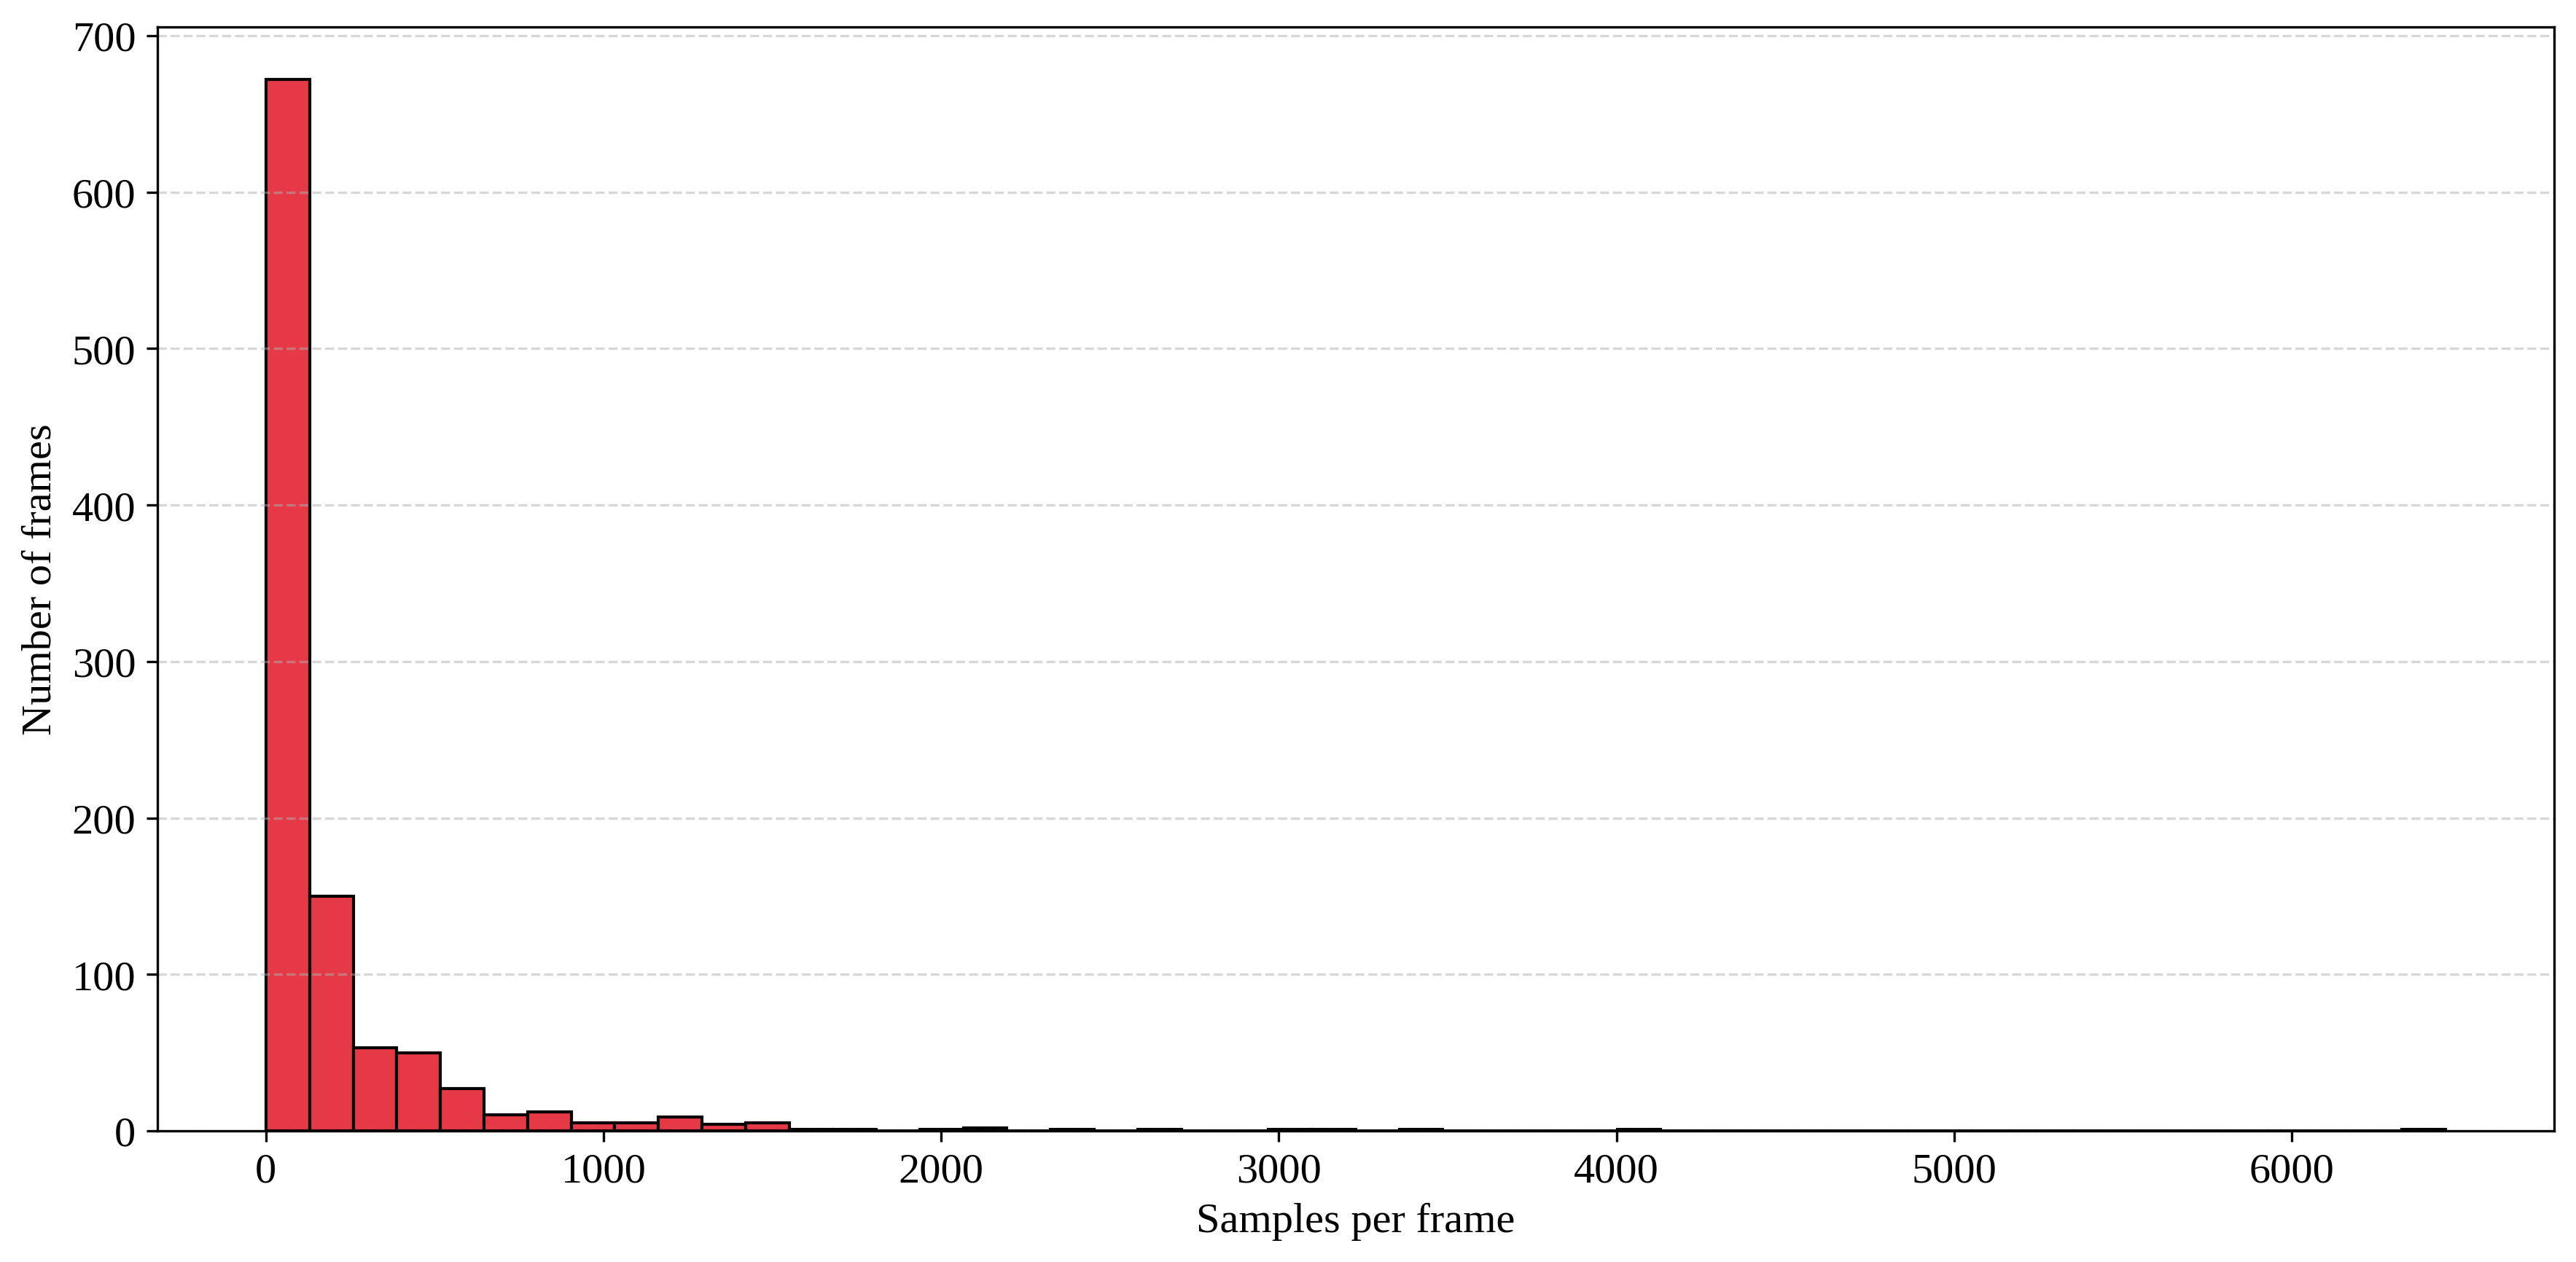

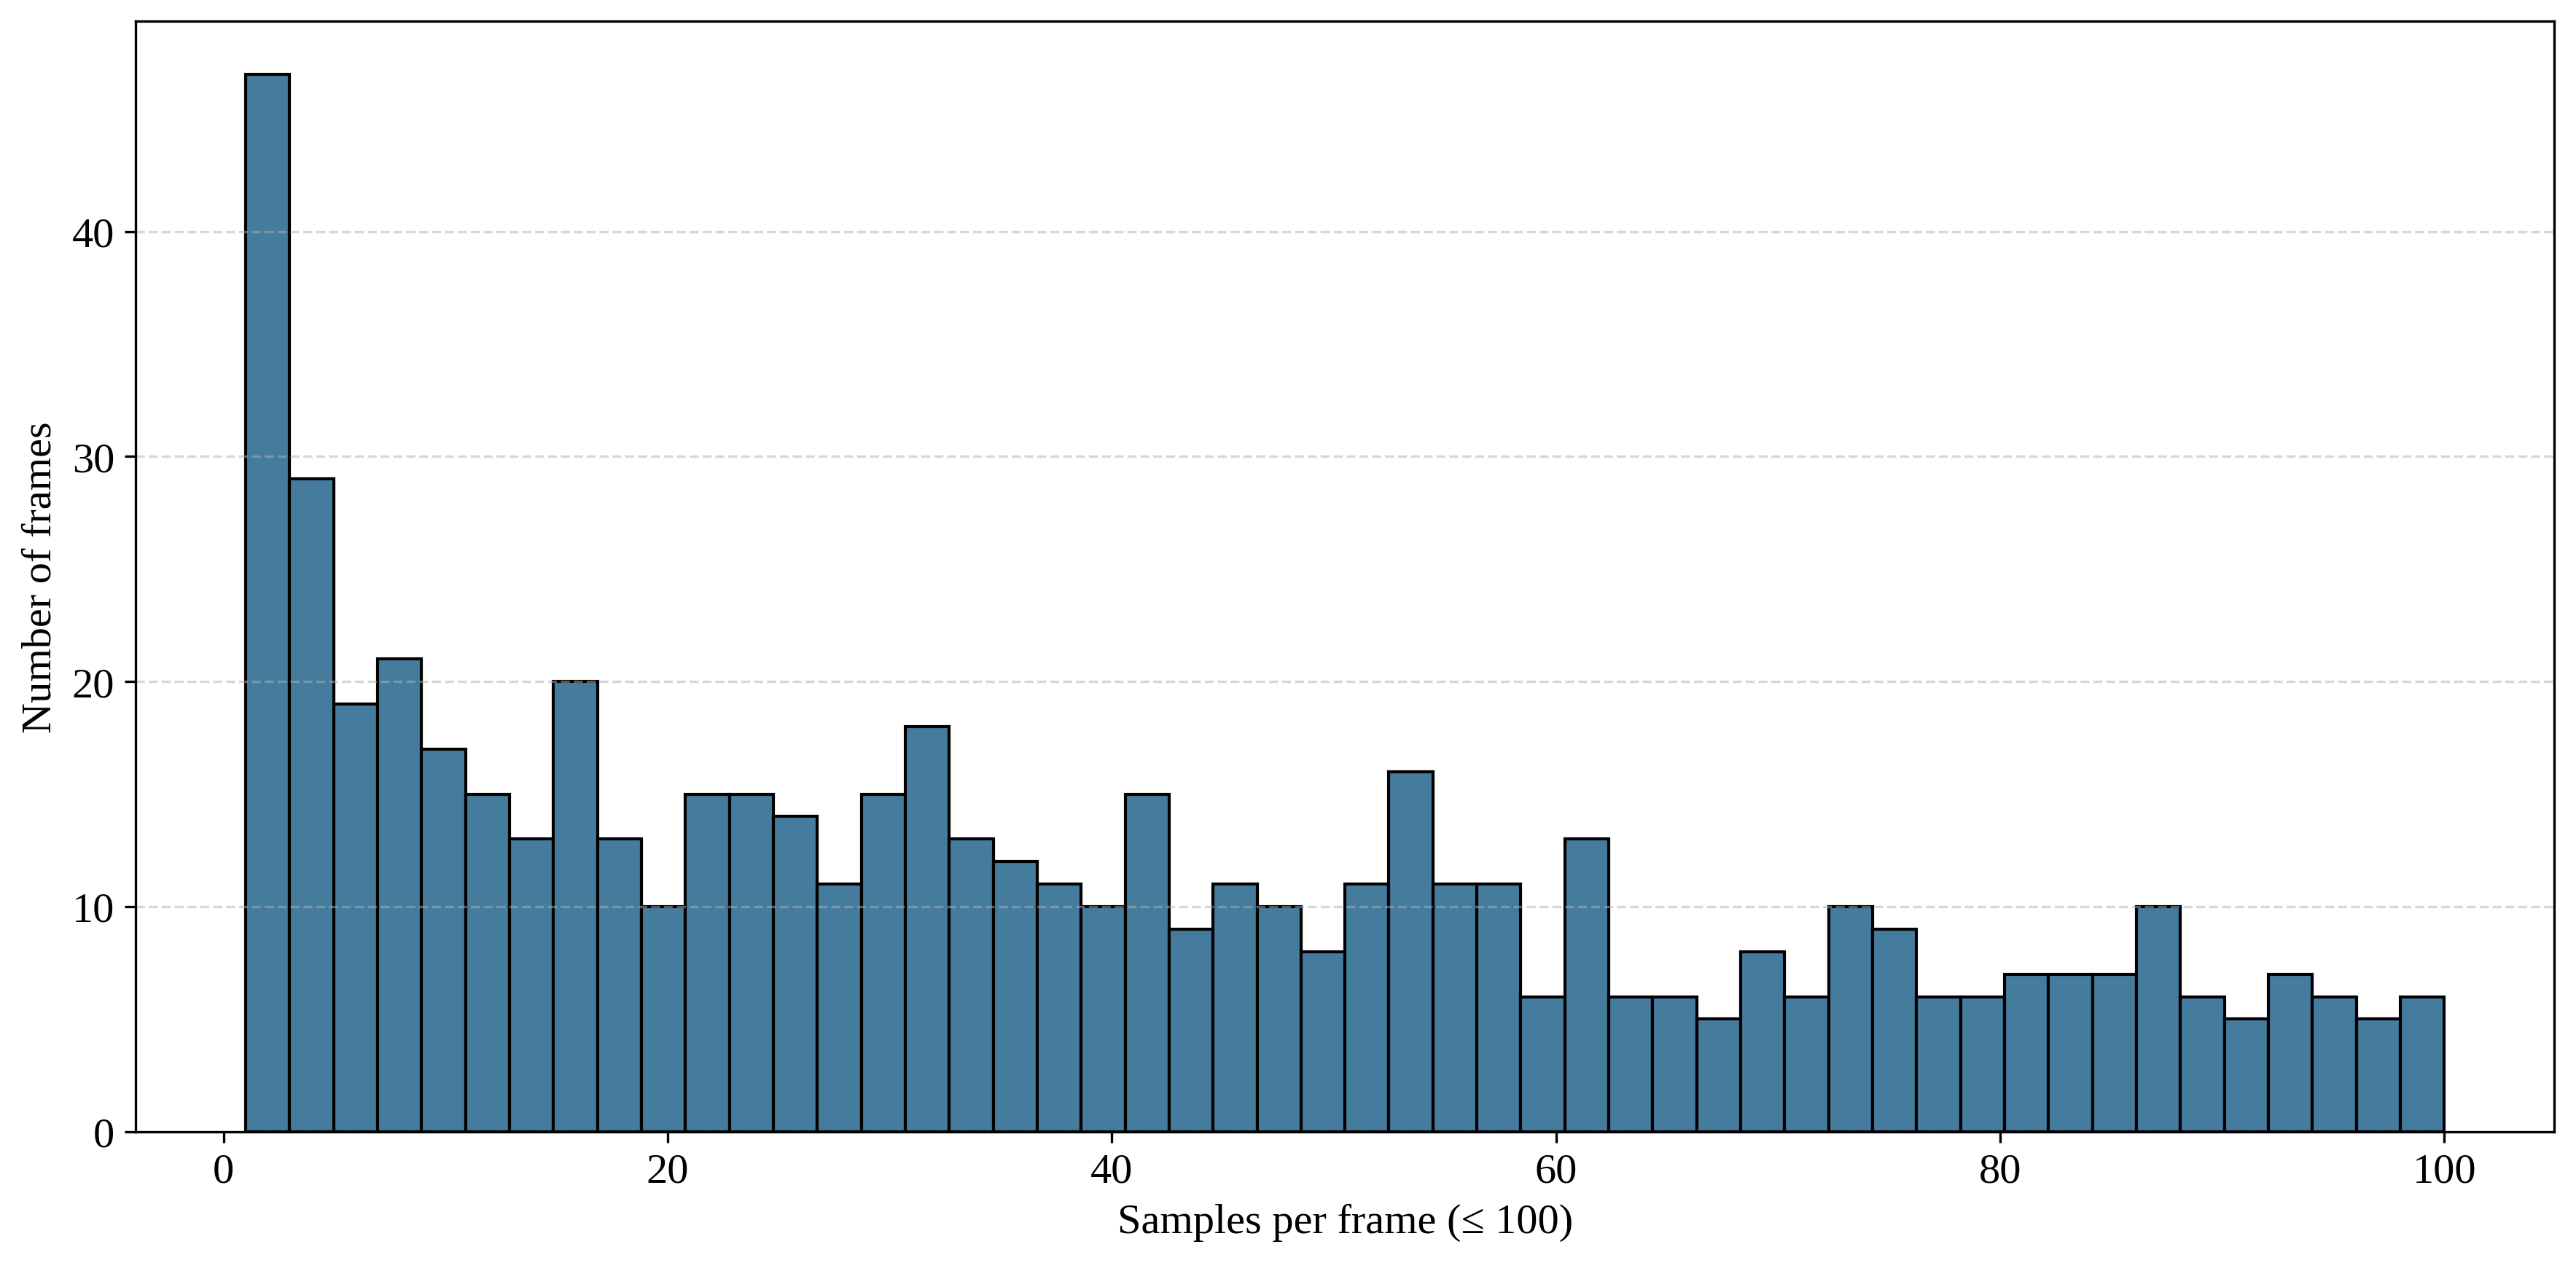

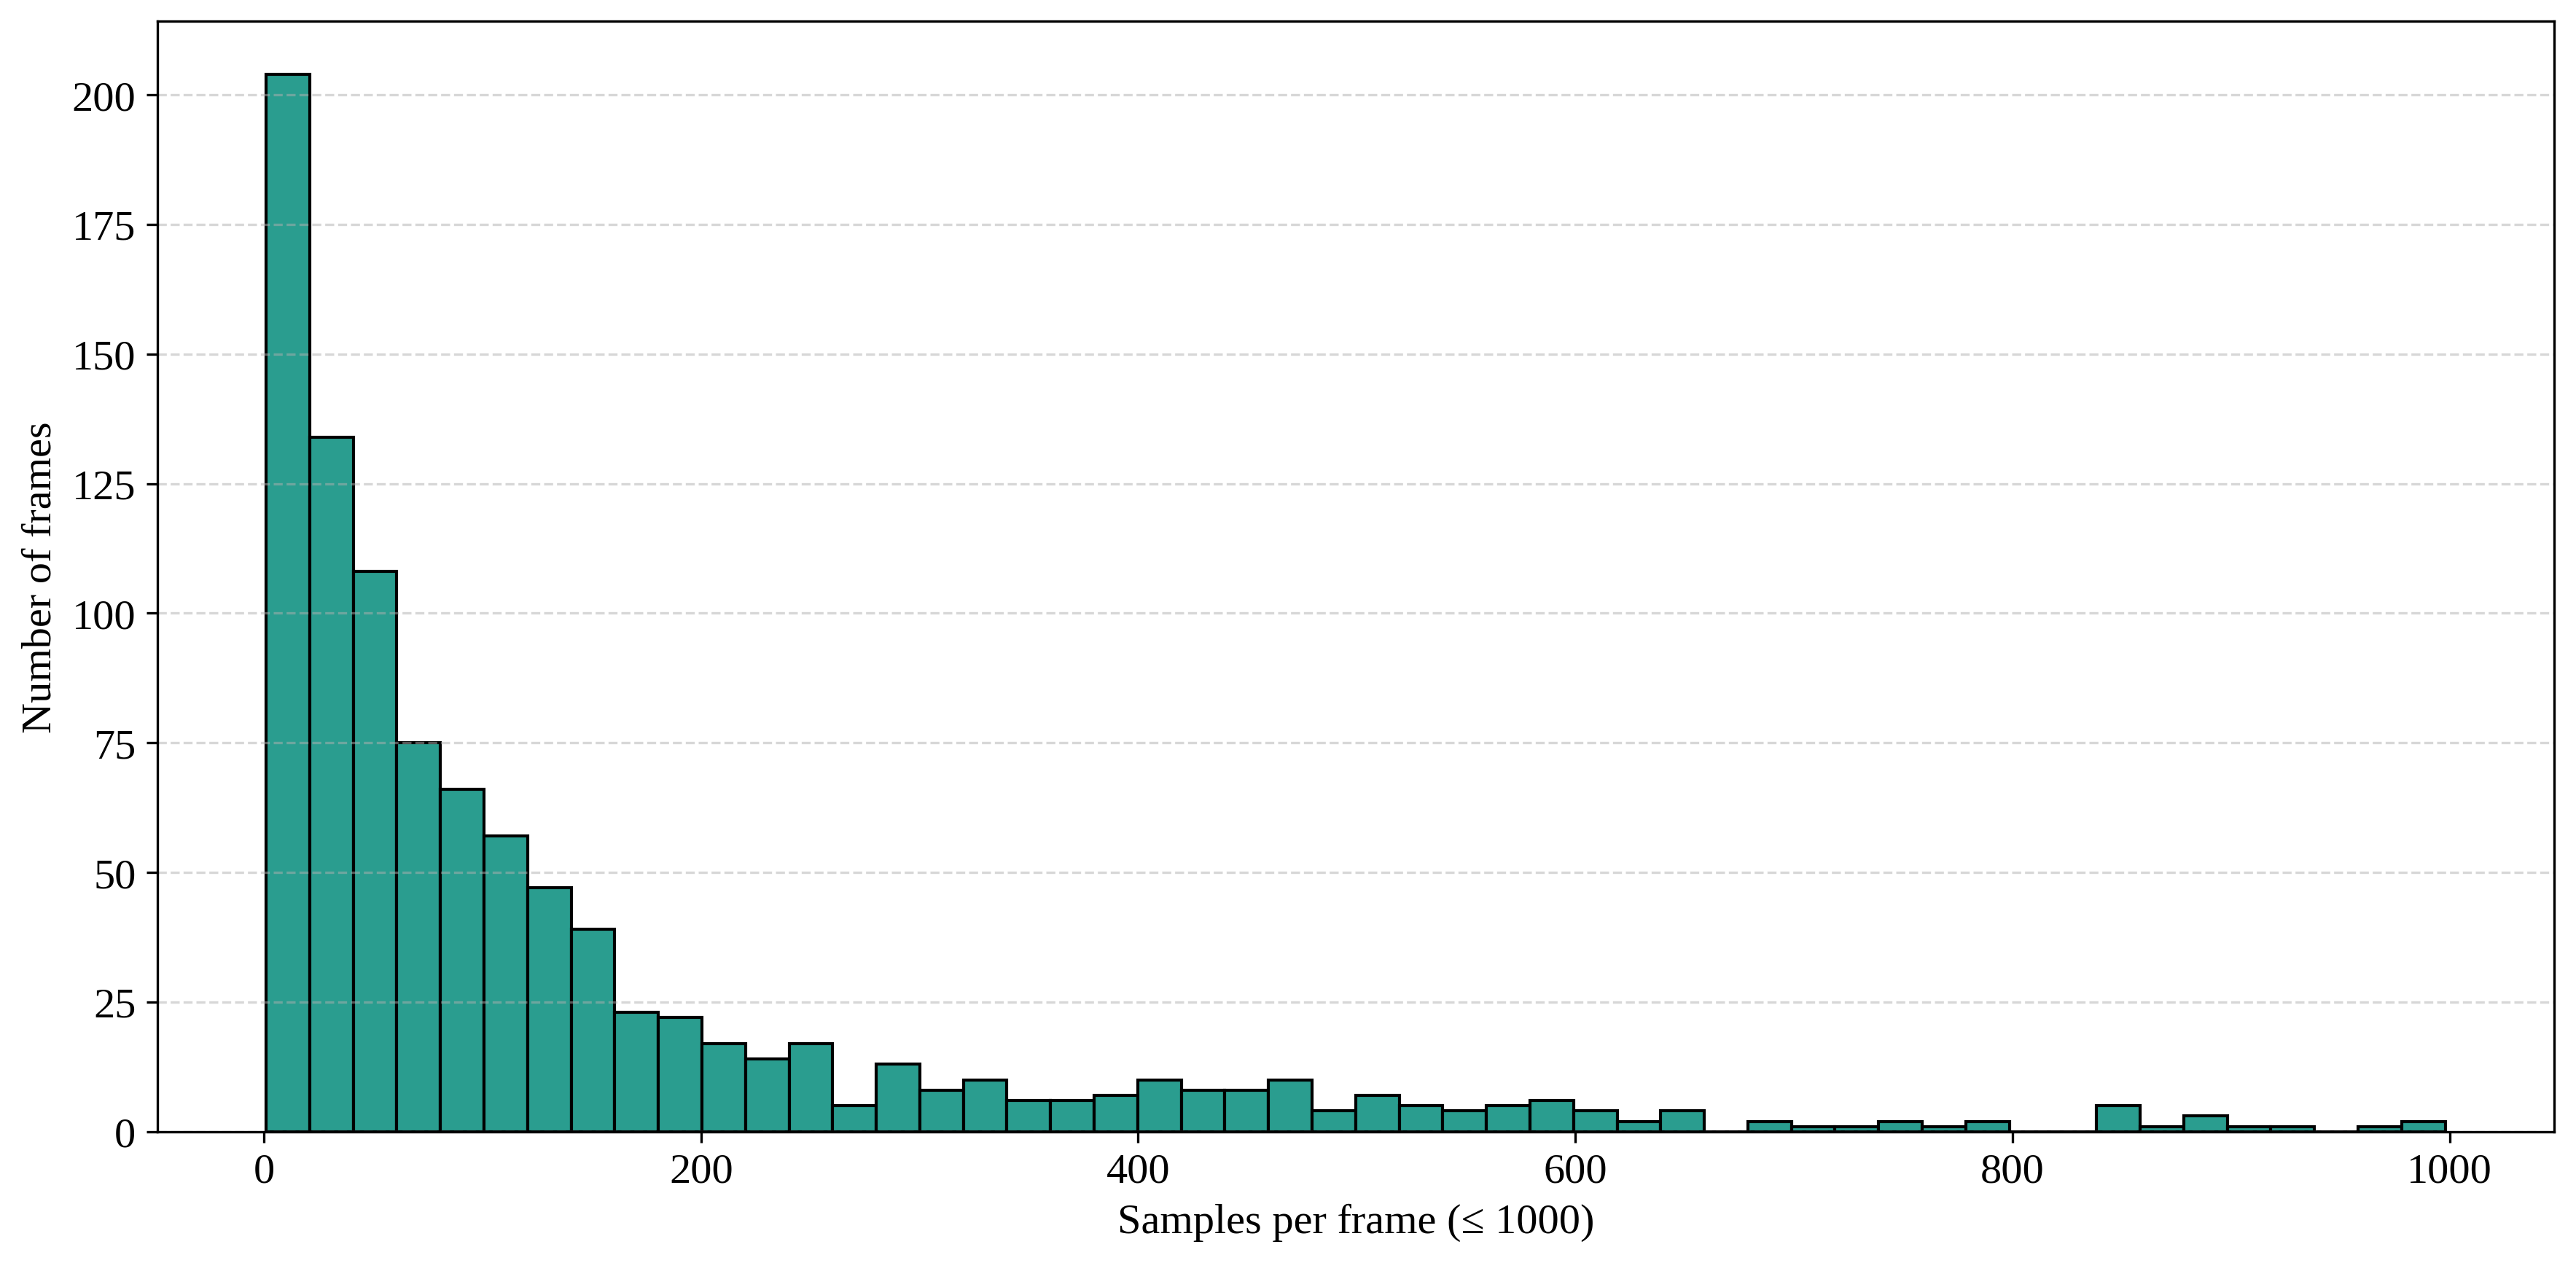

In [ ]:
import matplotlib.pyplot as plt

# ‚úÖ ËÆæÁΩÆÊõ¥Â§ßÂ≠ó‰ΩìÔºå‰æø‰∫éWordÁº©ÊîæÂêé‰ªçÊ∏ÖÊô∞
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14  # ÊØîÂéüÊù•Êõ¥Â§ßÔºåÈÄÇÂêàÊèíÂÖ•ÊñáÊ°£

# ‚úÖ Ëé∑ÂèñÊØè‰∏™ frame ÁöÑÊ†∑Êú¨Êï∞
frame_counts = df['frame_name'].value_counts()

# ================= Âõæ1ÔºöÂÖ®ÈõÜ =================
plt.figure(figsize=(12, 6), dpi=300)
plt.hist(frame_counts.values, bins=50, color='#e63946', edgecolor='black')
plt.xlabel("Samples per frame")
plt.ylabel("Number of frames")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("samples_full_distribution_hd.png", dpi=300, bbox_inches='tight')  # ‰øùÂ≠òÈ´òÊ∏ÖÂõæ
plt.show()

# ================= Âõæ2ÔºöÊ†∑Êú¨Êï∞ ‚â§ 100 =================
plt.figure(figsize=(12, 6), dpi=300)
plt.hist(frame_counts[frame_counts <= 100].values, bins=50, color='#457b9d', edgecolor='black')
plt.xlabel("Samples per frame (‚â§ 100)")
plt.ylabel("Number of frames")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("samples_under100_distribution_hd.png", dpi=300, bbox_inches='tight')
plt.show()

# ================= Âõæ3ÔºöÊ†∑Êú¨Êï∞ ‚â§ 1000 =================
plt.figure(figsize=(12, 6), dpi=300)
plt.hist(frame_counts[frame_counts <= 1000].values, bins=50, color='#2a9d8f', edgecolor='black')
plt.xlabel("Samples per frame (‚â§ 1000)")
plt.ylabel("Number of frames")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("samples_under1000_distribution_hd.png", dpi=300, bbox_inches='tight')
plt.show()



In [ ]:
import pandas as pd
import pickle
from collections import defaultdict, Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def extract_pos_from_lu(lexical_unit):
    """‰ªélexical unit‰∏≠ÊèêÂèñËØçÊÄß"""
    if pd.isna(lexical_unit) or not isinstance(lexical_unit, str):
        return 'UNKNOWN'

    lu = lexical_unit.lower()

    # Âü∫‰∫éFrameNetÁöÑLUÂëΩÂêçËßÑÂàô
    if '.v' in lu:
        return 'VERB'
    elif '.n' in lu:
        return 'NOUN'
    elif '.a' in lu:
        return 'ADJ'
    elif '.adv' in lu:
        return 'ADV'
    elif '.prep' in lu:
        return 'PREP'
    elif '.num' in lu:
        return 'NUM'
    elif '.intj' in lu:
        return 'INTJ'
    elif '.art' in lu:
        return 'ART'
    else:
        return 'OTHER'

def analyze_frame_pos_preferences(df):
    """ÂàÜÊûêÊØè‰∏™frameÁöÑËØçÊÄßÂÅèÂ•Ω"""

    print("=== Frame-ËØçÊÄßÂÅèÂ•ΩÂàÜÊûê ===")
    print(f"ÂàÜÊûêÊï∞ÊçÆ: {len(df)} ‰∏™Ê†∑Êú¨, {df['frame_name'].nunique()} ‰∏™frames")

    # ÊèêÂèñËØçÊÄß‰ø°ÊÅØ
    df['pos'] = df['lexical_unit'].apply(extract_pos_from_lu)

    # ÁªüËÆ°Êï¥‰ΩìËØçÊÄßÂàÜÂ∏É
    overall_pos_counts = df['pos'].value_counts()
    print(f"\nÊï¥‰ΩìËØçÊÄßÂàÜÂ∏É:")
    for pos, count in overall_pos_counts.items():
        print(f"  {pos}: {count} ({count/len(df):.1%})")

    # ÁªüËÆ°ÊØè‰∏™frameÁöÑËØçÊÄßÂàÜÂ∏É
    frame_pos_stats = defaultdict(lambda: defaultdict(int))

    for _, row in df.iterrows():
        frame = row['frame_name']
        pos = row['pos']
        frame_pos_stats[frame][pos] += 1

    # ËÆ°ÁÆóÊØè‰∏™frameÁöÑËØçÊÄßÂÅèÂ•ΩÂàÜÂ∏É
    frame_pos_preferences = {}

    for frame, pos_counts in frame_pos_stats.items():
        total = sum(pos_counts.values())
        if total > 0:
            preferences = {pos: count/total for pos, count in pos_counts.items()}
            frame_pos_preferences[frame] = preferences

    return frame_pos_stats, frame_pos_preferences, overall_pos_counts

def find_interesting_patterns(frame_pos_preferences, min_samples=10):
    """ÊâæÂá∫ÊúâË∂£ÁöÑframe-ËØçÊÄßÊ®°Âºè"""

    print(f"\n=== ÊúâË∂£ÁöÑFrame-ËØçÊÄßÊ®°Âºè (Ëá≥Â∞ë{min_samples}‰∏™Ê†∑Êú¨) ===")

    # È´òÂ∫¶ÂÅèÂ•ΩÊüê‰∏™ËØçÊÄßÁöÑframes
    highly_biased_frames = []

    for frame, preferences in frame_pos_preferences.items():
        if sum(frame_pos_stats[frame].values()) < min_samples:
            continue

        max_pos = max(preferences.keys(), key=lambda x: preferences[x])
        max_ratio = preferences[max_pos]

        if max_ratio >= 0.8:  # 80%‰ª•‰∏äÈÉΩÊòØÂêå‰∏ÄËØçÊÄß
            total_samples = sum(frame_pos_stats[frame].values())
            highly_biased_frames.append((frame, max_pos, max_ratio, total_samples))

    # ÊåâÂÅèÂ•ΩÂº∫Â∫¶ÊéíÂ∫è
    highly_biased_frames.sort(key=lambda x: x[2], reverse=True)

    print(f"\nÈ´òÂ∫¶ÂÅèÂ•ΩÂçï‰∏ÄËØçÊÄßÁöÑFrames (ÂÅèÂ•ΩÂ∫¶>=80%):")
    for frame, pos, ratio, total in highly_biased_frames[:20]:
        print(f"  {frame}: {pos} ({ratio:.1%}, {total}Ê†∑Êú¨)")

    # ËØçÊÄßÂàÜÂ∏ÉÊØîËæÉÂùáÂåÄÁöÑframes
    balanced_frames = []

    for frame, preferences in frame_pos_preferences.items():
        if sum(frame_pos_stats[frame].values()) < min_samples:
            continue

        # ËÆ°ÁÆóËØçÊÄßÂàÜÂ∏ÉÁöÑÂùáÂåÄÂ∫¶ (ÁÜµ)
        entropy = -sum(p * np.log2(p) for p in preferences.values() if p > 0)
        max_entropy = np.log2(len(preferences))  # ÊúÄÂ§ßÂèØËÉΩÁÜµ
        normalized_entropy = entropy / max_entropy if max_entropy > 0 else 0

        if normalized_entropy >= 0.8 and len(preferences) >= 3:  # Áõ∏ÂØπÂùáÂåÄ‰∏îÊúâÂ§öÁßçËØçÊÄß
            total_samples = sum(frame_pos_stats[frame].values())
            balanced_frames.append((frame, normalized_entropy, total_samples, preferences))

    balanced_frames.sort(key=lambda x: x[1], reverse=True)

    print(f"\nËØçÊÄßÂàÜÂ∏ÉÁõ∏ÂØπÂùáÂåÄÁöÑFrames:")
    for frame, entropy, total, prefs in balanced_frames[:10]:
        top_poses = sorted(prefs.items(), key=lambda x: x[1], reverse=True)[:3]
        pos_str = ", ".join([f"{pos}:{ratio:.1%}" for pos, ratio in top_poses])
        print(f"  {frame}: {pos_str} (ÊÄªËÆ°{total}Ê†∑Êú¨)")

    return highly_biased_frames, balanced_frames

def analyze_pos_frame_compatibility(frame_pos_preferences):
    """ÂàÜÊûêËØçÊÄß-frameÂÖºÂÆπÊÄßÔºåÁîüÊàêËØÑÂàÜÁü©Èòµ"""

    print(f"\n=== ÁîüÊàêËØçÊÄß-FrameÂÖºÂÆπÊÄßÁü©Èòµ ===")

    # Ëé∑ÂèñÊâÄÊúâËØçÊÄßÂíåframes
    all_poses = set()
    all_frames = list(frame_pos_preferences.keys())

    for prefs in frame_pos_preferences.values():
        all_poses.update(prefs.keys())

    all_poses = sorted(list(all_poses))

    print(f"ËØçÊÄßÁ±ªÂà´: {all_poses}")
    print(f"FrameÊï∞Èáè: {len(all_frames)}")

    # ÂàõÂª∫ÂÖºÂÆπÊÄßÁü©Èòµ
    compatibility_matrix = np.zeros((len(all_poses), len(all_frames)))

    for j, frame in enumerate(all_frames):
        if frame in frame_pos_preferences:
            for i, pos in enumerate(all_poses):
                compatibility_matrix[i, j] = frame_pos_preferences[frame].get(pos, 0.0)

    # ‰øùÂ≠òÁü©ÈòµÂà∞Êñá‰ª∂
    save_path = "/content/drive/MyDrive/more50/framenet_data/"

    compatibility_data = {
        'matrix': compatibility_matrix,
        'pos_names': all_poses,
        'frame_names': all_frames,
        'frame_pos_preferences': frame_pos_preferences
    }

    with open(save_path + "frame_pos_compatibility.pkl", 'wb') as f:
        pickle.dump(compatibility_data, f)

    print(f"ÂÖºÂÆπÊÄßÁü©ÈòµÂ∑≤‰øùÂ≠òÂà∞: {save_path}frame_pos_compatibility.pkl")

    return compatibility_matrix, all_poses, all_frames

def show_examples_by_pos(df, target_pos='VERB', num_examples=10):
    """ÊòæÁ§∫ÁâπÂÆöËØçÊÄßÁöÑ‰æãÂ≠ê"""

    print(f"\n=== {target_pos}ËØçÊÄßÁöÑ‰æãÂ≠ê ===")

    pos_examples = df[df['pos'] == target_pos].sample(min(num_examples, len(df[df['pos'] == target_pos])))

    for _, row in pos_examples.iterrows():
        print(f"Frame: {row['frame_name']}")
        print(f"LU: {row['lexical_unit']}")
        print(f"Target: {row['target_text']}")
        print(f"Sentence: {row['sentence'][:80]}...")
        print()

# ÊâßË°åÂàÜÊûê
def run_complete_analysis():
    """ËøêË°åÂÆåÊï¥ÁöÑÂàÜÊûê"""

    # Âä†ËΩΩÊï∞ÊçÆ
    data_path = "/content/drive/MyDrive/more50/framenet_data/framenet_df.pkl"

    with open(data_path, "rb") as f:
        df = pickle.load(f)

    print(f"Âä†ËΩΩÊï∞ÊçÆ: {len(df)} ‰∏™Ê†∑Êú¨")

    # ËøõË°åÂàÜÊûê
    global frame_pos_stats, frame_pos_preferences  # ‰æõÂÖ∂‰ªñÂáΩÊï∞‰ΩøÁî®
    frame_pos_stats, frame_pos_preferences, overall_pos_counts = analyze_frame_pos_preferences(df)

    # ÊâæÂá∫ÊúâË∂£ÁöÑÊ®°Âºè
    highly_biased, balanced = find_interesting_patterns(frame_pos_preferences, min_samples=15)

    # ÁîüÊàêÂÖºÂÆπÊÄßÁü©Èòµ
    matrix, pos_names, frame_names = analyze_pos_frame_compatibility(frame_pos_preferences)

    # ÊòæÁ§∫‰∏Ä‰∫õ‰æãÂ≠ê
    for pos in ['VERB', 'NOUN', 'ADJ']:
        if pos in overall_pos_counts:
            show_examples_by_pos(df, pos, 5)

    return frame_pos_preferences, matrix, pos_names, frame_names

# ËøêË°åÂàÜÊûê
if __name__ == "__main__":
    preferences, matrix, pos_names, frame_names = run_complete_analysis()

Âä†ËΩΩÊï∞ÊçÆ: 200750 ‰∏™Ê†∑Êú¨
=== Frame-ËØçÊÄßÂÅèÂ•ΩÂàÜÊûê ===
ÂàÜÊûêÊï∞ÊçÆ: 200750 ‰∏™Ê†∑Êú¨, 1014 ‰∏™frames

Êï¥‰ΩìËØçÊÄßÂàÜÂ∏É:
  VERB: 82610 (41.2%)
  NOUN: 78086 (38.9%)
  ADJ: 36180 (18.0%)
  PREP: 2961 (1.5%)
  OTHER: 913 (0.5%)

=== ÊúâË∂£ÁöÑFrame-ËØçÊÄßÊ®°Âºè (Ëá≥Â∞ë15‰∏™Ê†∑Êú¨) ===

È´òÂ∫¶ÂÅèÂ•ΩÂçï‰∏ÄËØçÊÄßÁöÑFrames (ÂÅèÂ•ΩÂ∫¶>=80%):
  Absorb_heat: VERB (100.0%, 41Ê†∑Êú¨)
  Accompaniment: PREP (100.0%, 43Ê†∑Êú¨)
  Accoutrements: NOUN (100.0%, 1148Ê†∑Êú¨)
  Accuracy: ADJ (100.0%, 73Ê†∑Êú¨)
  Active_substance: NOUN (100.0%, 141Ê†∑Êú¨)
  Activity_ready_state: ADJ (100.0%, 34Ê†∑Êú¨)
  Activity_resume: VERB (100.0%, 41Ê†∑Êú¨)
  Activity_stop: VERB (100.0%, 129Ê†∑Êú¨)
  Actually_occurring_entity: ADJ (100.0%, 19Ê†∑Êú¨)
  Adding_up: VERB (100.0%, 15Ê†∑Êú¨)
  Adducing: VERB (100.0%, 59Ê†∑Êú¨)
  Adopt_selection: VERB (100.0%, 52Ê†∑Êú¨)
  Aesthetics: ADJ (100.0%, 106Ê†∑Êú¨)
  Aggregate: NOUN (100.0%, 1455Ê†∑Êú¨)
  Alliance: NOUN (100.0%, 23Ê†∑Êú¨)
  Alternatives: NOUN (100.0%, 24Ê†∑Êú

In [ ]:
import pandas as pd
import pickle
import xml.etree.ElementTree as ET
from tqdm import tqdm

# === ‰Ω†Êèê‰æõÁöÑÂéüÂßãÂáΩÊï∞ÔºåÂÆåÂÖ®ÊåâÁÖß‰Ω†ÁöÑÈÄªËæë ===
def extract_pure_definition_from_markup(def_markup: str) -> str:
    try:
        def_markup = def_markup.strip()
        root = ET.fromstring(def_markup)

        parts = []
        if root.text and root.text.strip():
            parts.append(root.text.strip())

        for elem in root:
            if elem.tag == "ex":
                continue
            if elem.text and elem.text.strip():
                parts.append(elem.text.strip())
            if elem.tail and elem.tail.strip():
                parts.append(elem.tail.strip())

        return ' '.join(parts).strip()

    except ET.ParseError:
        return "[ParseError]"

def add_pure_definition_column(file_path: str, output_path: str = None):
    """
    ‰∏∫pickleÊñá‰ª∂‰∏≠ÁöÑDataFrameÊ∑ªÂä†Á∫ØÂÆö‰πâÂàó
    """
    print(f"Processing file: {file_path}")

    # Âä†ËΩΩÊï∞ÊçÆ
    with open(file_path, "rb") as f:
        data = pickle.load(f)

    # Â¶ÇÊûúÊï∞ÊçÆÊòØÂ≠óÂÖ∏Ê†ºÂºèÔºàÂåÖÂê´dataframeÈîÆÔºâ
    if isinstance(data, dict) and "dataframe" in data:
        df = data["dataframe"]
    elif isinstance(data, pd.DataFrame):
        df = data
    else:
        print(f"Unexpected data format in {file_path}")
        return

    print(f"Original dataframe shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")

    # Ê£ÄÊü•ÊòØÂê¶Â∑≤ÁªèÊúâpure_definitionÂàó
    if "pure_definition" in df.columns:
        print("pure_definition column already exists, will overwrite...")

    # Á°ÆÂÆöÂÆö‰πâÂàóÁöÑÂêçÁß∞
    definition_column = None
    for col in ["frame_definition", "definition", "frame_def"]:
        if col in df.columns:
            definition_column = col
            break

    if definition_column is None:
        print("Warning: No definition column found. Looking for columns containing 'def'...")
        def_cols = [col for col in df.columns if 'def' in col.lower()]
        if def_cols:
            definition_column = def_cols[0]
            print(f"Using column: {definition_column}")
        else:
            print("Error: No definition column found!")
            return

    print(f"Using definition column: {definition_column}")

    # Â∫îÁî®Á∫ØÂÆö‰πâÊèêÂèñ
    print("Extracting pure definitions...")
    tqdm.pandas(desc="Processing definitions")
    df["pure_definition"] = df[definition_column].progress_apply(extract_pure_definition_from_markup)

    # ÊòæÁ§∫‰∏Ä‰∫õÁ§∫‰æã
    print("\nSample results:")
    for i in range(min(3, len(df))):
        print(f"\nExample {i+1}:")
        print(f"Original: {df.iloc[i][definition_column][:200]}...")
        print(f"Pure: {df.iloc[i]['pure_definition'][:200]}...")

    # ‰øùÂ≠òÁªìÊûú
    if output_path is None:
        output_path = file_path.replace(".pkl", "_with_pure_def.pkl")

    if isinstance(data, dict):
        data["dataframe"] = df
        save_data = data
    else:
        save_data = df

    with open(output_path, "wb") as f:
        pickle.dump(save_data, f)

    print(f"\nSaved to: {output_path}")
    print(f"Final dataframe shape: {df.shape}")

    return df

def main():
    """
    Â§ÑÁêÜÊâÄÊúâÊï∞ÊçÆÈõÜÊñá‰ª∂
    """
    # ÂÆö‰πâÊñá‰ª∂Ë∑ØÂæÑ
    file_paths = {
        "train": "/content/drive/MyDrive/more50/framenet_data/train_df_distilbert_balanced.pkl",
        "val": "/content/drive/MyDrive/more50/framenet_data/val_df.pkl",
        "test": "/content/drive/MyDrive/more50/framenet_data/test_df.pkl"
    }

    processed_files = {}

    for dataset_name, file_path in file_paths.items():
        try:
            print(f"\n{'='*50}")
            print(f"Processing {dataset_name} dataset")
            print(f"{'='*50}")

            output_path = file_path.replace(".pkl", "_with_pure_def.pkl")
            df = add_pure_definition_column(file_path, output_path)
            processed_files[dataset_name] = output_path

            print(f"‚úÖ Successfully processed {dataset_name} dataset")

        except FileNotFoundError:
            print(f"‚ùå File not found: {file_path}")
        except Exception as e:
            print(f"‚ùå Error processing {dataset_name}: {e}")

    print(f"\n{'='*50}")
    print("Summary of processed files:")
    print(f"{'='*50}")
    for dataset_name, output_path in processed_files.items():
        print(f"{dataset_name}: {output_path}")

if __name__ == "__main__":
    main()


Processing train dataset
Processing file: /content/drive/MyDrive/more50/framenet_data/train_df_distilbert_balanced.pkl
Unexpected data format in /content/drive/MyDrive/more50/framenet_data/train_df_distilbert_balanced.pkl
‚úÖ Successfully processed train dataset

Processing val dataset
Processing file: /content/drive/MyDrive/more50/framenet_data/val_df.pkl
Original dataframe shape: (25179, 11)
Columns: ['sentence', 'target_spans', 'target_text', 'frame_name', 'frame_id', 'lexical_unit', 'lu_id', 'lu_definition', 'frame_elements', 'fe_spans', 'frame_definition']
Using definition column: frame_definition
Extracting pure definitions...


Processing definitions: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 25179/25179 [00:00<00:00, 143058.14it/s]



Sample results:

Example 1:
Original: These words refer to Parts merging to form a Whole.  (The Parts may also be encoded as Part_1 and Part_2.)  There is a symmetrical relationship between the components that undergo the process, and aft...
Pure: [ParseError]...

Example 2:
Original: An Owner has (or lacks) a Possession. '' 'The river's part of my  manor, but of course it also belongs to the River Police.'  'It's a nuisance having to abandon my belongings, though.'...
Pure: [ParseError]...

Example 3:
Original: An Assessor examines a Phenomenon to figure out its Value according to some Feature of the Phenomenon.  This Value is a factor in determining the acceptability of the Phenomenon.  In some cases, a Met...
Pure: [ParseError]...

Saved to: /content/drive/MyDrive/more50/framenet_data/val_df_with_pure_def.pkl
Final dataframe shape: (25179, 12)
‚úÖ Successfully processed val dataset

Processing test dataset
Processing file: /content/drive/MyDrive/more50/framenet_data/test_df.pkl
Ori

Processing definitions: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 25579/25579 [00:00<00:00, 143092.78it/s]



Sample results:

Example 1:
Original: An Agent makes a particular facial expression, generally in response to some Internal_cause (generally an emotional state).  Sometimes the Body_part involved in the expression is mentioned in lieu of ...
Pure: [ParseError]...

Example 2:
Original: This frame contains nouns denoting Aggregates of Individuals.  The Aggregates may be described by an Aggregate_property.   'An army of postal workers descended on my office.'  ...
Pure: [ParseError]...

Example 3:
Original: This frame concerns people's knowledge or skill in certain domains.  It does not concern acquaintance or familiarity with people. With adjectives as targets in this frame, we annotate on two FE layers...
Pure: [ParseError]...

Saved to: /content/drive/MyDrive/more50/framenet_data/test_df_with_pure_def.pkl
Final dataframe shape: (25579, 12)
‚úÖ Successfully processed test dataset

Summary of processed files:
train: /content/drive/MyDrive/more50/framenet_data/train_df_distilbert_balance

In [9]:
# @title üì¶ Dataset Splitting with Stratified Sampling



split_save_dir = "/content/drive/MyDrive/more50/framenet_data"
os.makedirs(split_save_dir, exist_ok=True)

train_path = os.path.join(split_save_dir, "train_df.pkl")
val_path = os.path.join(split_save_dir, "val_df.pkl")
test_path = os.path.join(split_save_dir, "test_df.pkl")

def split_data_stratified(df, frame_relations, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_state=42, force=False):
    """
    Perform stratified sampling to split the dataset, ensuring each frame is represented in all subsets.
    If split files already exist and force=False, skip re-splitting.

    Args:
        df: DataFrame containing sentences, target words, and frame labels
        frame_relations: Dictionary of frame-to-frame relationships
        train_ratio: Proportion of training set
        val_ratio: Proportion of validation set
        test_ratio: Proportion of test set
        random_state: Random seed
        force: If True, redo the split even if files exist

    Returns:
        train_df, val_df, test_df: Splitted DataFrames
    """
    if (not force
        and os.path.exists(train_path)
        and os.path.exists(val_path)
        and os.path.exists(test_path)):
        print("‚úÖ Split files already exist. Skipping split (use force=True to regenerate).")
        with open(train_path, "rb") as f:
            train_df = pickle.load(f)
        with open(val_path, "rb") as f:
            val_df = pickle.load(f)
        with open(test_path, "rb") as f:
            test_df = pickle.load(f)
        return train_df, val_df, test_df

    # --- your original splitting logic starts here ---
    from collections import defaultdict
    import numpy as np

    print("Grouping by sentence...")
    sentence_groups = {}
    for idx, row in df.iterrows():
        sentence = row['sentence']
        if sentence not in sentence_groups:
            sentence_groups[sentence] = []
        sentence_groups[sentence].append(idx)

    print("Collecting sentences for each frame...")
    frame_sentences = defaultdict(set)
    for sentence, indices in sentence_groups.items():
        frames = set(df.loc[idx, 'frame_name'] for idx in indices)
        for frame in frames:
            frame_sentences[frame].add(sentence)

    frame_counts = {frame: len(sentences) for frame, sentences in frame_sentences.items()}
    print(f"Total number of frames: {len(frame_counts)}")

    rare_frames = {f: c for f, c in frame_counts.items() if c < 5}
    medium_frames = {f: c for f, c in frame_counts.items() if 5 <= c < 20}
    common_frames = {f: c for f, c in frame_counts.items() if c >= 20}

    print(f"Rare frames (<5 sentences): {len(rare_frames)}")
    print(f"Medium-frequency frames (5‚Äì19 sentences): {len(medium_frames)}")
    print(f"Common frames (‚â•20 sentences): {len(common_frames)}")

    train_sentences, val_sentences, test_sentences = set(), set(), set()
    rare_frame_sentences = set()
    for frame in rare_frames:
        rare_frame_sentences.update(frame_sentences[frame])

    np.random.seed(random_state)

    for frame in common_frames:
        sentences = list(frame_sentences[frame])
        np.random.shuffle(sentences)
        n = len(sentences)
        n_train = int(n * train_ratio)
        n_val = int(n * val_ratio)
        train_sentences.update(sentences[:n_train])
        val_sentences.update(sentences[n_train:n_train+n_val])
        test_sentences.update(sentences[n_train+n_val:])

    for frame in medium_frames:
        sentences = list(frame_sentences[frame])
        np.random.shuffle(sentences)
        n = len(sentences)
        n_train = max(n // 2, 2)
        remaining = n - n_train
        n_val = remaining // 2
        n_test = remaining - n_val
        if n_val == 0 and n > 2:
            n_val = 1
            n_train -= 1
        if n_test == 0 and n > 2:
            n_test = 1
            n_train -= 1
        train_sentences.update(sentences[:n_train])
        val_sentences.update(sentences[n_train:n_train+n_val])
        test_sentences.update(sentences[n_train+n_val:])

    train_sentences.update(rare_frame_sentences)
    val_sentences -= train_sentences
    test_sentences -= train_sentences | val_sentences

    print(f"Number of training sentences: {len(train_sentences)}")
    print(f"Number of validation sentences: {len(val_sentences)}")
    print(f"Number of test sentences: {len(test_sentences)}")

    train_indices = [idx for s in train_sentences for idx in sentence_groups.get(s, [])]
    val_indices = [idx for s in val_sentences for idx in sentence_groups.get(s, [])]
    test_indices = [idx for s in test_sentences for idx in sentence_groups.get(s, [])]

    train_df = df.loc[train_indices].reset_index(drop=True)
    val_df = df.loc[val_indices].reset_index(drop=True)
    test_df = df.loc[test_indices].reset_index(drop=True)

    train_frames = set(train_df['frame_name'])
    val_frames = set(val_df['frame_name'])
    test_frames = set(test_df['frame_name'])

    print(f"Number of frames in training set: {len(train_frames)}")
    print(f"Number of frames in validation set: {len(val_frames)}")
    print(f"Number of frames in test set: {len(test_frames)}")
    print(f"Validation-only frames: {len(val_frames - train_frames)}")
    print(f"Test-only frames: {len(test_frames - train_frames)}")

    for i in range(1, 6):
        exact_frames = [f for f, c in frame_counts.items() if c == i]
        print(f"Frames with exactly {i} sentence(s): {len(exact_frames)}")
        if exact_frames:
            print(f"  ‚Üí Frame names: {', '.join(exact_frames)}")

    # Save to disk
    with open(train_path, "wb") as f:
        pickle.dump(train_df, f)
    with open(val_path, "wb") as f:
        pickle.dump(val_df, f)
    with open(test_path, "wb") as f:
        pickle.dump(test_df, f)
    print("‚úÖ Saved train/val/test splits to disk.")

    return train_df, val_df, test_df


# Apply stratified dataset split
train_df, val_df, test_df = split_data_stratified(df, frame_relations)

frame_freq_df = df['frame_name'].value_counts().reset_index()
frame_freq_df.columns = ['frame_name', 'sentence_count']
frame_freq_df = frame_freq_df.sort_values(by='sentence_count', ascending=False).reset_index(drop=True)


‚úÖ Split files already exist. Skipping split (use force=True to regenerate).


In [19]:
# ÁÆÄÂåñÁöÑÂø´ÈÄüÊµãËØï‰ª£Á†Å
def quick_test_tokenizer_strategy(dataset="original", num_sentences=50):
    """Âø´ÈÄüÊµãËØïtokenizerÁ≠ñÁï•ÔºåÂè™ÊµãËØïÈÉ®ÂàÜÊï∞ÊçÆ"""

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"üöÄ Âø´ÈÄüÊµãËØï {dataset} Êï∞ÊçÆÈõÜ (Ââç{num_sentences}‰∏™Âè•Â≠ê)")

    # ÁÆÄÂåñÁöÑÊ®°ÂûãÂä†ËΩΩ
    from transformers import AutoModel, AutoTokenizer

    model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

    # Âä†ËΩΩcheckpoint
    checkpoint = torch.load("/content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt",
                           map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])

    # ËΩ¨Êç¢prototypes
    raw_prototypes = checkpoint['prototypes']
    prototypes = {}
    for frame_name, proto in raw_prototypes.items():
        if isinstance(proto, torch.Tensor):
            prototypes[frame_name] = proto.cpu().numpy()
        else:
            prototypes[frame_name] = proto

    # Âä†ËΩΩÊï∞ÊçÆ
    if dataset == "fulltext":
        test_path = "/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl"
    else:
        test_path = "/content/drive/MyDrive/more50/framenet_data/test_df.pkl"

    test_df = pd.read_pickle(test_path)

    # Âè™ÂèñÂâçN‰∏™Âè•Â≠ê
    sentences = test_df["sentence"].unique()[:num_sentences]
    subset_df = test_df[test_df["sentence"].isin(sentences)]

    print(f"üìä ÊµãËØïÊï∞ÊçÆ: {len(subset_df)} Ê†∑Êú¨Ôºå{len(sentences)} ‰∏™Âè•Â≠ê")

    # ÂáÜÂ§áÂéüÂûãÁü©Èòµ
    prototype_frames = list(prototypes.keys())
    prototype_matrix = np.array([prototypes[f] for f in prototype_frames])

    # Âø´ÈÄüËØÑ‰º∞
    target_correct = 0
    target_predicted = 0
    target_total = 0
    frame_correct = 0
    frame_total = 0

    for sentence in tqdm(sentences, desc="Âø´ÈÄüÊµãËØï"):
        sentence_rows = subset_df[subset_df["sentence"] == sentence]

        # Êî∂ÈõÜgold spans
        gold_spans = []
        gold_frames = []
        for _, row in sentence_rows.iterrows():
            spans = row["target_spans"]
            if spans and len(spans) > 0:
                if isinstance(spans, list):
                    if len(spans) > 0 and isinstance(spans[0], (list, tuple)) and len(spans[0]) == 2:
                        for s in spans:
                            gold_spans.append((int(s[0]), int(s[1])))
                            gold_frames.append(row["frame_name"])

        target_total += len(gold_spans)

        # ÁîüÊàêÂÄôÈÄâspans (tokenizerÊñπÊ≥ï)
        predicted_spans = generate_candidate_spans_tokenizer_based(sentence, tokenizer)
        target_predicted += len(predicted_spans)

        # Âø´ÈÄüÈ¢ÑÊµãÂíåËØÑ‰º∞
        for span in predicted_spans:
            try:
                # ÁºñÁ†Å
                emb = encode_target_spans_batch(
                    [sentence], [[span]], tokenizer, model,
                    batch_size=1, train_mode=False
                ).cpu().numpy()[0]

                # È¢ÑÊµã
                scores = cosine_similarity([emb], prototype_matrix)[0]
                pred_frame = prototype_frames[np.argmax(scores)]

                # Ê£ÄÊü•ÂåπÈÖç
                for j, g_span in enumerate(gold_spans):
                    if span[1] > g_span[0] and span[0] < g_span[1]:  # ÈáçÂè†
                        target_correct += 1
                        frame_total += 1
                        if pred_frame == gold_frames[j]:
                            frame_correct += 1
                        break

            except Exception as e:
                continue

    # ËÆ°ÁÆóÊåáÊ†á
    coverage = target_correct / target_total if target_total > 0 else 0
    precision = target_correct / target_predicted if target_predicted > 0 else 0
    frame_acc = frame_correct / frame_total if frame_total > 0 else 0

    print(f"\n‚úÖ Âø´ÈÄüÊµãËØïÁªìÊûú:")
    print(f"Ë¶ÜÁõñÁéá: {coverage:.4f} ({target_correct}/{target_total})")
    print(f"TargetÁ≤æÁ°ÆÁéá: {precision:.4f} ({target_correct}/{target_predicted})")
    print(f"FrameÂáÜÁ°ÆÁéá: {frame_acc:.4f} ({frame_correct}/{frame_total})")
    print(f"ÊÄªÈ¢ÑÊµãspans: {target_predicted}")

    return {
        'coverage': coverage,
        'precision': precision,
        'frame_accuracy': frame_acc,
        'stats': {
            'target_correct': target_correct,
            'target_predicted': target_predicted,
            'target_total': target_total,
            'frame_correct': frame_correct,
            'frame_total': frame_total
        }
    }

# Âø´ÈÄüÊµãËØï
print("üîß Âø´ÈÄüÊµãËØïÂéüÂßãÊï∞ÊçÆÈõÜ...")
original_quick = quick_test_tokenizer_strategy("original", 100)

print("\nüîß Âø´ÈÄüÊµãËØïFull TextÊï∞ÊçÆÈõÜ...")
fulltext_quick = quick_test_tokenizer_strategy("fulltext", 50)

üîß Âø´ÈÄüÊµãËØïÂéüÂßãÊï∞ÊçÆÈõÜ...
üöÄ Âø´ÈÄüÊµãËØï original Êï∞ÊçÆÈõÜ (Ââç100‰∏™Âè•Â≠ê)


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

üìä ÊµãËØïÊï∞ÊçÆ: 101 Ê†∑Êú¨Ôºå100 ‰∏™Âè•Â≠ê


Âø´ÈÄüÊµãËØï: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [00:27<00:00,  3.68it/s]



‚úÖ Âø´ÈÄüÊµãËØïÁªìÊûú:
Ë¶ÜÁõñÁéá: 1.3137 (134/102)
TargetÁ≤æÁ°ÆÁéá: 0.0613 (134/2187)
FrameÂáÜÁ°ÆÁéá: 0.9552 (128/134)
ÊÄªÈ¢ÑÊµãspans: 2187

üîß Âø´ÈÄüÊµãËØïFull TextÊï∞ÊçÆÈõÜ...
üöÄ Âø´ÈÄüÊµãËØï fulltext Êï∞ÊçÆÈõÜ (Ââç50‰∏™Âè•Â≠ê)
üìä ÊµãËØïÊï∞ÊçÆ: 248 Ê†∑Êú¨Ôºå50 ‰∏™Âè•Â≠ê


Âø´ÈÄüÊµãËØï: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 50/50 [00:07<00:00,  6.59it/s]


‚úÖ Âø´ÈÄüÊµãËØïÁªìÊûú:
Ë¶ÜÁõñÁéá: 0.9839 (244/248)
TargetÁ≤æÁ°ÆÁéá: 0.3461 (244/705)
FrameÂáÜÁ°ÆÁéá: 0.9303 (227/244)
ÊÄªÈ¢ÑÊµãspans: 705


In [22]:
def quick_test_tokenizer_strategy_fixed(dataset="original", num_sentences=50):
    """‰øÆÊ≠£ÁöÑÂø´ÈÄüÊµãËØï - ÈÅøÂÖçÈáçÂ§çËÆ°Êï∞"""

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"üöÄ Âø´ÈÄüÊµãËØï {dataset} Êï∞ÊçÆÈõÜ (Ââç{num_sentences}‰∏™Âè•Â≠ê)")

    # ÁÆÄÂåñÁöÑÊ®°ÂûãÂä†ËΩΩ
    from transformers import AutoModel, AutoTokenizer

    model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

    # Âä†ËΩΩcheckpoint
    checkpoint = torch.load("/content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt",
                           map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])

    # ËΩ¨Êç¢prototypes
    raw_prototypes = checkpoint['prototypes']
    prototypes = {}
    for frame_name, proto in raw_prototypes.items():
        if isinstance(proto, torch.Tensor):
            prototypes[frame_name] = proto.cpu().numpy()
        else:
            prototypes[frame_name] = proto

    # Âä†ËΩΩÊï∞ÊçÆ
    if dataset == "fulltext":
        test_path = "/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl"
    else:
        test_path = "/content/drive/MyDrive/more50/framenet_data/test_df.pkl"

    test_df = pd.read_pickle(test_path)

    # Âè™ÂèñÂâçN‰∏™Âè•Â≠ê
    sentences = test_df["sentence"].unique()[:num_sentences]
    subset_df = test_df[test_df["sentence"].isin(sentences)]

    print(f"üìä ÊµãËØïÊï∞ÊçÆ: {len(subset_df)} Ê†∑Êú¨Ôºå{len(sentences)} ‰∏™Âè•Â≠ê")

    # ÂáÜÂ§áÂéüÂûãÁü©Èòµ
    prototype_frames = list(prototypes.keys())
    prototype_matrix = np.array([prototypes[f] for f in prototype_frames])

    # ‰øÆÊ≠£ÁöÑËØÑ‰º∞ÈÄªËæë
    matched_golds = 0  # Ë¢´ÂåπÈÖçÂà∞ÁöÑgold spansÊï∞Èáè
    total_golds = 0
    total_predictions = 0
    frame_correct = 0
    frame_total = 0

    for sentence in tqdm(sentences, desc="Âø´ÈÄüÊµãËØï"):
        sentence_rows = subset_df[subset_df["sentence"] == sentence]

        # Êî∂ÈõÜgold spans
        gold_spans = []
        gold_frames = []
        for _, row in sentence_rows.iterrows():
            spans = row["target_spans"]
            if spans and len(spans) > 0:
                if isinstance(spans, list):
                    if len(spans) > 0 and isinstance(spans[0], (list, tuple)) and len(spans[0]) == 2:
                        for s in spans:
                            gold_spans.append((int(s[0]), int(s[1])))
                            gold_frames.append(row["frame_name"])

        total_golds += len(gold_spans)

        # ÁîüÊàêÂÄôÈÄâspans
        predicted_spans = generate_candidate_spans_tokenizer_based(sentence, tokenizer)
        total_predictions += len(predicted_spans)

        # ËÆ∞ÂΩïÂì™‰∫õgold spansË¢´ÂåπÈÖç‰∫ÜÔºàÈÅøÂÖçÈáçÂ§çËÆ°Êï∞Ôºâ
        matched_gold_indices = set()

        # È¢ÑÊµãÂíåËØÑ‰º∞
        for span in predicted_spans:
            try:
                # ÁºñÁ†ÅÂíåÈ¢ÑÊµã
                emb = encode_target_spans_batch(
                    [sentence], [[span]], tokenizer, model,
                    batch_size=1, train_mode=False
                ).cpu().numpy()[0]

                scores = cosine_similarity([emb], prototype_matrix)[0]
                pred_frame = prototype_frames[np.argmax(scores)]

                # ÊâæÂà∞Á¨¨‰∏Ä‰∏™ÈáçÂè†ÁöÑgold spanÔºàÈÅøÂÖçÈáçÂ§çÂåπÈÖçÔºâ
                for j, g_span in enumerate(gold_spans):
                    if j not in matched_gold_indices and span[1] > g_span[0] and span[0] < g_span[1]:
                        matched_gold_indices.add(j)  # Ê†áËÆ∞Ëøô‰∏™gold spanÂ∑≤Ë¢´ÂåπÈÖç
                        frame_total += 1
                        if pred_frame == gold_frames[j]:
                            frame_correct += 1
                        break  # Âè™ÂåπÈÖçÁ¨¨‰∏Ä‰∏™ÈáçÂè†ÁöÑgold span

            except Exception as e:
                continue

        matched_golds += len(matched_gold_indices)

    # Ê≠£Á°ÆÁöÑÊåáÊ†áËÆ°ÁÆó
    coverage = matched_golds / total_golds if total_golds > 0 else 0
    precision = matched_golds / total_predictions if total_predictions > 0 else 0
    frame_acc = frame_correct / frame_total if frame_total > 0 else 0

    print(f"\n‚úÖ ‰øÆÊ≠£ÁöÑÂø´ÈÄüÊµãËØïÁªìÊûú:")
    print(f"Ë¶ÜÁõñÁéá: {coverage:.4f} ({matched_golds}/{total_golds})")
    print(f"TargetÁ≤æÁ°ÆÁéá: {precision:.4f} ({matched_golds}/{total_predictions})")
    print(f"FrameÂáÜÁ°ÆÁéá: {frame_acc:.4f} ({frame_correct}/{frame_total})")
    print(f"ÊÄªÈ¢ÑÊµãspans: {total_predictions}")

    return {
        'coverage': coverage,
        'precision': precision,
        'frame_accuracy': frame_acc
    }

# ÈáçÊñ∞ÊµãËØï
print("üîß ‰øÆÊ≠£ÂêéÁöÑÂø´ÈÄüÊµãËØï...")
original_fixed = quick_test_tokenizer_strategy_fixed("original", 100)
fulltext_fixed = quick_test_tokenizer_strategy_fixed("fulltext", 50)

üîß ‰øÆÊ≠£ÂêéÁöÑÂø´ÈÄüÊµãËØï...
üöÄ Âø´ÈÄüÊµãËØï original Êï∞ÊçÆÈõÜ (Ââç100‰∏™Âè•Â≠ê)
üìä ÊµãËØïÊï∞ÊçÆ: 101 Ê†∑Êú¨Ôºå100 ‰∏™Âè•Â≠ê


Âø´ÈÄüÊµãËØï: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [00:27<00:00,  3.66it/s]



‚úÖ ‰øÆÊ≠£ÁöÑÂø´ÈÄüÊµãËØïÁªìÊûú:
Ë¶ÜÁõñÁéá: 0.9902 (101/102)
TargetÁ≤æÁ°ÆÁéá: 0.0462 (101/2187)
FrameÂáÜÁ°ÆÁéá: 0.9505 (96/101)
ÊÄªÈ¢ÑÊµãspans: 2187
üöÄ Âø´ÈÄüÊµãËØï fulltext Êï∞ÊçÆÈõÜ (Ââç50‰∏™Âè•Â≠ê)
üìä ÊµãËØïÊï∞ÊçÆ: 248 Ê†∑Êú¨Ôºå50 ‰∏™Âè•Â≠ê


Âø´ÈÄüÊµãËØï: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 50/50 [00:08<00:00,  6.15it/s]


‚úÖ ‰øÆÊ≠£ÁöÑÂø´ÈÄüÊµãËØïÁªìÊûú:
Ë¶ÜÁõñÁéá: 0.9798 (243/248)
TargetÁ≤æÁ°ÆÁéá: 0.3447 (243/705)
FrameÂáÜÁ°ÆÁéá: 0.9300 (226/243)
ÊÄªÈ¢ÑÊµãspans: 705


In [ ]:
import pandas as pd

import pandas as pd

# ‚úÖ 1. ËÆæÁΩÆË∑ØÂæÑ
full_path = "/content/drive/MyDrive/more50/framenet_data/framenet_df.pkl"
train_path = "/content/drive/MyDrive/Open_sesame/framenet_data/train_df.pkl"
val_path   = "/content/drive/MyDrive/Open_sesame/framenet_data/dev_df.pkl"
test_path  = "/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl"

# ‚úÖ 2. Âä†ËΩΩÊï∞ÊçÆÈõÜÔºàÈÉΩÊòØÁõ¥Êé•Áî® pd.read_pickleÔºå‰∏çÈúÄË¶ÅÂÜç openÔºâ
all_df   = pd.read_pickle(full_path)
train_df = pd.read_pickle(train_path)
val_df   = pd.read_pickle(val_path)
test_df  = pd.read_pickle(test_path)


# ‚úÖ 2. ÁªüËÆ°ÂáΩÊï∞
def analyze_framenet_splits(all_df, train_df, val_df, test_df, save_excel=True):
    subsets = {
        "All": all_df,
        "Train": train_df,
        "Val": val_df,
        "Test": test_df
    }

    stats = []
    for name, subset in subsets.items():
        num_samples = len(subset)
        num_frames = subset["frame_name"].nunique()
        num_sentences = subset["sentence"].nunique()

        stats.append({
            "Subset": name,
            "#Frames": num_frames,
            "#Samples": num_samples,
            "#Sentences": num_sentences
        })

        print(f"\nüìÇ {name} ÈõÜÁªüËÆ°:")
        print(f"   ‚Üí Ê†∑Êú¨Êï∞ (#Samples): {num_samples:,}")
        print(f"   ‚Üí Frame Êï∞ (#Frames): {num_frames:,}")
        print(f"   ‚Üí Âè•Â≠êÊï∞ (#Sentences): {num_sentences:,}")

    summary_df = pd.DataFrame(stats)

    if save_excel:
        save_path = "/content/drive/MyDrive/more50/framenet_data/stratified_split_summary.xlsx"
        summary_df.to_excel(save_path, index=False)
        print(f"\n‚úÖ Ê±áÊÄªË°®Ê†ºÂ∑≤‰øùÂ≠òËá≥: {save_path}")

    return summary_df

# ‚úÖ 3. ÊâßË°å
summary_df = analyze_framenet_splits(all_df, train_df, val_df, test_df)




üìÇ All ÈõÜÁªüËÆ°:
   ‚Üí Ê†∑Êú¨Êï∞ (#Samples): 200,750
   ‚Üí Frame Êï∞ (#Frames): 1,014
   ‚Üí Âè•Â≠êÊï∞ (#Sentences): 171,664

üìÇ Train ÈõÜÁªüËÆ°:
   ‚Üí Ê†∑Êú¨Êï∞ (#Samples): 20,105
   ‚Üí Frame Êï∞ (#Frames): 753
   ‚Üí Âè•Â≠êÊï∞ (#Sentences): 3,353

üìÇ Val ÈõÜÁªüËÆ°:
   ‚Üí Ê†∑Êú¨Êï∞ (#Samples): 2,382
   ‚Üí Frame Êï∞ (#Frames): 368
   ‚Üí Âè•Â≠êÊï∞ (#Sentences): 326

üìÇ Test ÈõÜÁªüËÆ°:
   ‚Üí Ê†∑Êú¨Êï∞ (#Samples): 6,872
   ‚Üí Frame Êï∞ (#Frames): 574
   ‚Üí Âè•Â≠êÊï∞ (#Sentences): 1,247

‚úÖ Ê±áÊÄªË°®Ê†ºÂ∑≤‰øùÂ≠òËá≥: /content/drive/MyDrive/more50/framenet_data/stratified_split_summary.xlsx


In [ ]:
def print_frame_and_sample_stats(train_df, val_df, test_df):
    datasets = {
        "ËÆ≠ÁªÉÈõÜ": train_df,
        "È™åËØÅÈõÜ": val_df,
        "ÊµãËØïÈõÜ": test_df
    }

    print("\nüìä Êï∞ÊçÆÈõÜÊ†∑Êú¨‰∏é frame Êï∞ÈáèÁªüËÆ°:")
    for name, df in datasets.items():
        num_samples = len(df)
        num_frames = df['frame_name'].nunique()
        print(f"{name}:")
        print(f"   Ê†∑Êú¨Êù°Êï∞: {num_samples:,}")
        print(f"   Frame Êï∞Èáè: {num_frames:,}")
        print("-" * 40)

# ‚úÖ Ë∞ÉÁî®ÂáΩÊï∞ÔºàÁ°Æ‰øù‰Ω†Â∑≤ÁªèÂä†ËΩΩ‰∫ÜËøô‰∏â‰∏™ DataFrameÔºâ
print_frame_and_sample_stats(train_df, val_df, test_df)



üìä Êï∞ÊçÆÈõÜÊ†∑Êú¨‰∏é frame Êï∞ÈáèÁªüËÆ°:
ËÆ≠ÁªÉÈõÜ:
   Ê†∑Êú¨Êù°Êï∞: 150,101
   Frame Êï∞Èáè: 1,014
----------------------------------------
È™åËØÅÈõÜ:
   Ê†∑Êú¨Êù°Êï∞: 25,086
   Frame Êï∞Èáè: 904
----------------------------------------
ÊµãËØïÈõÜ:
   Ê†∑Êú¨Êù°Êï∞: 25,563
   Frame Êï∞Èáè: 907
----------------------------------------


In [ ]:
import pandas as pd
import pickle
import os
from collections import defaultdict
from tabulate import tabulate

# Ë∑ØÂæÑ
base_dir = "/content/drive/MyDrive/more50/framenet_data"
train_path = os.path.join(base_dir, "train_df.pkl")
val_path = os.path.join(base_dir, "val_df.pkl")
test_path = os.path.join(base_dir, "test_df.pkl")

# Âä†ËΩΩÊï∞ÊçÆ
with open(train_path, "rb") as f:
    train_df = pickle.load(f)
with open(val_path, "rb") as f:
    val_df = pickle.load(f)
with open(test_path, "rb") as f:
    test_df = pickle.load(f)

df_all = pd.concat([train_df, val_df, test_df])

# ========== Frame ÂàÜÁ±ª ==========
frame_counts = df_all["frame_name"].value_counts()
common_frames = frame_counts[frame_counts >= 20].index.tolist()
medium_frames = frame_counts[(frame_counts >= 5) & (frame_counts < 20)].index.tolist()
rare_frames = frame_counts[frame_counts < 5].index.tolist()
all_frames = frame_counts.index.tolist()

frame_groups = {
    "All": all_frames,
    "Common": common_frames,
    "Medium": medium_frames,
    "Rare": rare_frames
}

subsets = {
    "Train": train_df,
    "Val": val_df,
    "Test": test_df
}

# ========== ÁªüËÆ°ÈÄªËæë ==========
rows = []
for group_name, group_frames in frame_groups.items():
    total_frames_in_group = len(group_frames)
    total_samples_in_group = len(df_all[df_all["frame_name"].isin(group_frames)])

    for subset_name, subset_df in subsets.items():
        subset_df_filtered = subset_df[subset_df["frame_name"].isin(group_frames)]

        num_frames = subset_df_filtered["frame_name"].nunique()
        num_samples = len(subset_df_filtered)

        frame_percent = (num_frames / total_frames_in_group) * 100 if total_frames_in_group > 0 else 0
        sample_percent = (num_samples / total_samples_in_group) * 100 if total_samples_in_group > 0 else 0

        rows.append({
            "Frame Group": group_name,
            "Subset": subset_name,
            "#Frames": num_frames,
            "%Frames": f"{frame_percent:.1f}%",
            "#Samples": num_samples,
            "%Samples": f"{sample_percent:.1f}%"
        })

# ========== Ë°®Ê†ºËæìÂá∫ ==========
df_table = pd.DataFrame(rows)
df_table = df_table[["Frame Group", "Subset", "#Frames", "%Frames", "#Samples", "%Samples"]]

# ‰∏âÁ∫øË°®Â±ïÁ§∫
print(tabulate(df_table, headers="keys", tablefmt="grid", showindex=False))

# ‚úÖ ÈúÄË¶Å‰øùÂ≠òÁöÑËØùÔºö
df_table.to_csv("/content/frame_split_summary.csv", index=False)
df_table.to_latex(index=False)


+---------------+----------+-----------+-----------+------------+------------+
| Frame Group   | Subset   |   #Frames | %Frames   |   #Samples | %Samples   |
+===============+==========+===========+===========+============+============+
| All           | Train    |      1014 | 100.0%    |     150101 | 74.8%      |
+---------------+----------+-----------+-----------+------------+------------+
| All           | Val      |       904 | 89.2%     |      25086 | 12.5%      |
+---------------+----------+-----------+-----------+------------+------------+
| All           | Test     |       907 | 89.4%     |      25563 | 12.7%      |
+---------------+----------+-----------+-----------+------------+------------+
| Common        | Train    |       814 | 100.0%    |     149029 | 74.8%      |
+---------------+----------+-----------+-----------+------------+------------+
| Common        | Val      |       804 | 98.8%     |      24855 | 12.5%      |
+---------------+----------+-----------+-----------+

'\\begin{tabular}{llrlrl}\n\\toprule\nFrame Group & Subset & #Frames & %Frames & #Samples & %Samples \\\\\n\\midrule\nAll & Train & 1014 & 100.0% & 150101 & 74.8% \\\\\nAll & Val & 904 & 89.2% & 25086 & 12.5% \\\\\nAll & Test & 907 & 89.4% & 25563 & 12.7% \\\\\nCommon & Train & 814 & 100.0% & 149029 & 74.8% \\\\\nCommon & Val & 804 & 98.8% & 24855 & 12.5% \\\\\nCommon & Test & 803 & 98.6% & 25281 & 12.7% \\\\\nMedium & Train & 124 & 100.0% & 908 & 63.9% \\\\\nMedium & Val & 100 & 80.6% & 231 & 16.3% \\\\\nMedium & Test & 104 & 83.9% & 282 & 19.8% \\\\\nRare & Train & 76 & 100.0% & 164 & 100.0% \\\\\nRare & Val & 0 & 0.0% & 0 & 0.0% \\\\\nRare & Test & 0 & 0.0% & 0 & 0.0% \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
import pandas as pd
import pickle

# Âä†ËΩΩÊï∞ÊçÆÊ£ÄÊü•ÂÆö‰πâÊ†ºÂºè
with open("/content/drive/MyDrive/more50/framenet_data/val_df.pkl", "rb") as f:
    data = pickle.load(f)

df = data["dataframe"] if isinstance(data, dict) else data

print("Ê£ÄÊü•Ââç3‰∏™ÂÆö‰πâÁöÑÊ†ºÂºè:")
for i in range(3):
    definition = df.iloc[i]['frame_definition']
    print(f"\n=== ÂÆö‰πâ {i+1} ===")
    print(f"Á±ªÂûã: {type(definition)}")
    print(f"ÈïøÂ∫¶: {len(definition) if definition else 'None'}")
    print(f"Ââç100Â≠óÁ¨¶: {repr(definition[:100])}")
    print(f"ÊòØÂê¶‰ª•<ÂºÄÂ§¥: {str(definition).startswith('<') if definition else False}")
    print(f"ÂÆûÈôÖÂÜÖÂÆπ:")
    print(definition[:200] if definition else "None")
    print("-" * 50)

# ‰πüÊ£ÄÊü•‰∏Ä‰∏ãÊòØÂê¶ÊúâÁ©∫ÂÄº
print(f"\nÁ©∫ÂÄºÁªüËÆ°:")
print(f"frame_definitionÂàóÁ©∫ÂÄºÊï∞Èáè: {df['frame_definition'].isna().sum()}")
print(f"ÊÄªË°åÊï∞: {len(df)}")

# ÁúãÁúãÊúâÊ≤°ÊúâXMLÊ†ºÂºèÁöÑÂÆö‰πâ
xml_count = 0
for definition in df['frame_definition'].head(20):
    if definition and str(definition).strip().startswith('<'):
        xml_count += 1

print(f"\nÂâç20‰∏™ÂÆö‰πâ‰∏≠XMLÊ†ºÂºèÁöÑÊï∞Èáè: {xml_count}")

Ê£ÄÊü•Ââç3‰∏™ÂÆö‰πâÁöÑÊ†ºÂºè:

=== ÂÆö‰πâ 1 ===
Á±ªÂûã: <class 'str'>
ÈïøÂ∫¶: 397
Ââç100Â≠óÁ¨¶: 'These words refer to Parts merging to form a Whole.  (The Parts may also be encoded as Part_1 and Pa'
ÊòØÂê¶‰ª•<ÂºÄÂ§¥: False
ÂÆûÈôÖÂÜÖÂÆπ:
These words refer to Parts merging to form a Whole.  (The Parts may also be encoded as Part_1 and Part_2.)  There is a symmetrical relationship between the components that undergo the process, and aft
--------------------------------------------------

=== ÂÆö‰πâ 2 ===
Á±ªÂûã: <class 'str'>
ÈïøÂ∫¶: 184
Ââç100Â≠óÁ¨¶: "An Owner has (or lacks) a Possession. '' 'The river's part of my  manor, but of course it also belon"
ÊòØÂê¶‰ª•<ÂºÄÂ§¥: False
ÂÆûÈôÖÂÜÖÂÆπ:
An Owner has (or lacks) a Possession. '' 'The river's part of my  manor, but of course it also belongs to the River Police.'  'It's a nuisance having to abandon my belongings, though.'
--------------------------------------------------

=== ÂÆö‰πâ 3 ===
Á±ªÂûã: <class 'str'>
ÈïøÂ∫¶: 504
Ââç100Â≠óÁ¨¶: 'A

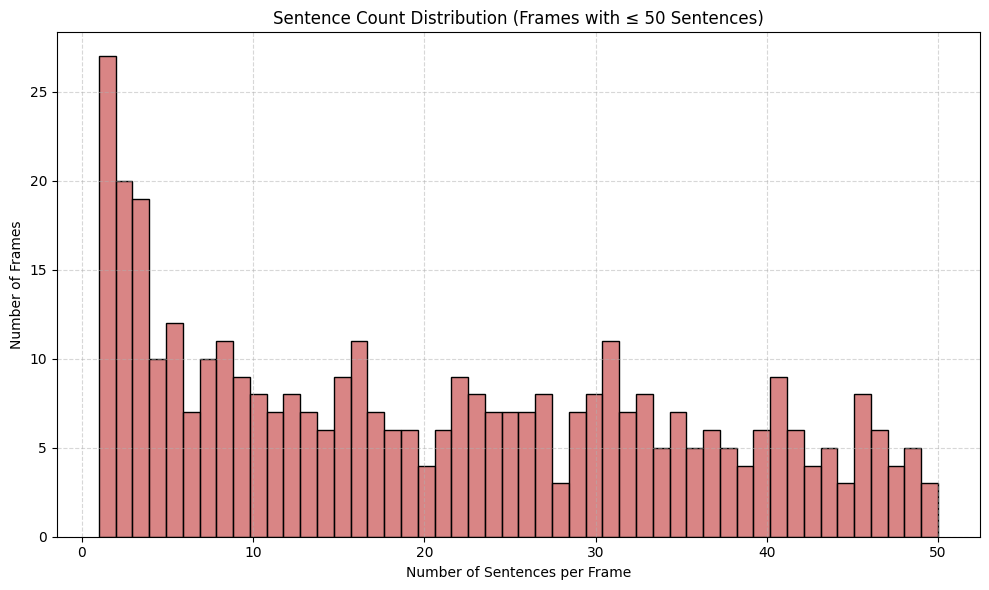

In [ ]:

# ÈôêÂÆöÂú®Âè•Â≠êÊï∞Èáè <= 50 ÁöÑ frame
subset_df = frame_freq_df[frame_freq_df['sentence_count'] <= 50]

plt.figure(figsize=(10, 6))
sns.histplot(
    data=subset_df,
    x='sentence_count',
    bins=50,  # ÊØè‰∏™Êï¥Êï∞‰∏Ä‰∏™ bin
    color='indianred',
    edgecolor='black'
)
plt.title("Sentence Count Distribution (Frames with ‚â§ 50 Sentences)")
plt.xlabel("Number of Sentences per Frame")
plt.ylabel("Number of Frames")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("frame_distribution_under_50.png", dpi=300)
plt.show()


In [ ]:
# Ê£ÄÊü•ÂèòÈáèÊòØÂê¶Áõ∏Âêå
print("ÂèòÈáèÂØπÊØî:")
print(f"balanced_df_with_analysis ÂΩ¢Áä∂: {balanced_df_with_analysis.shape}")
print(f"balanced_df ÊòØÂê¶Â≠òÂú®: {'balanced_df' in locals()}")

# Â¶ÇÊûú balanced_df Â≠òÂú®ÔºåÊØîËæÉÂÆÉ‰ª¨
if 'balanced_df' in locals():
    print(f"balanced_df ÂΩ¢Áä∂: {balanced_df.shape}")
    print(f"‰∏§‰∏™ÂèòÈáèÊòØÂê¶Áõ∏Âêå: {balanced_df_with_analysis.equals(balanced_df)}")

# Ê£ÄÊü•‰øùÂ≠òÁöÑÊñá‰ª∂
import os
file_path = "/content/drive/MyDrive/more50/framenet_data/train_df_balanced.pkl"
if os.path.exists(file_path):
    saved_df = pd.read_pickle(file_path)
    print(f"‰øùÂ≠òÊñá‰ª∂ÁöÑÂΩ¢Áä∂: {saved_df.shape}")
    print(f"‰∏éÂΩìÂâçÂèòÈáèÊòØÂê¶Áõ∏Âêå: {balanced_df_with_analysis.equals(saved_df)}")

ÂèòÈáèÂØπÊØî:
balanced_df_with_analysis ÂΩ¢Áä∂: (39536, 11)
balanced_df ÊòØÂê¶Â≠òÂú®: True
balanced_df ÂΩ¢Áä∂: (39536, 11)
‰∏§‰∏™ÂèòÈáèÊòØÂê¶Áõ∏Âêå: True
‰øùÂ≠òÊñá‰ª∂ÁöÑÂΩ¢Áä∂: (39536, 11)
‰∏éÂΩìÂâçÂèòÈáèÊòØÂê¶Áõ∏Âêå: True


In [ ]:
def analyze_frame_distribution(df):
    """ÂàÜÊûêframeÂàÜÂ∏ÉÊÉÖÂÜµ"""
    frame_counts = df['frame_name'].value_counts()

    print(f"ÊÄªframeÊï∞: {len(frame_counts)}")
    print(f"ÊÄªÊ†∑Êú¨Êï∞: {len(df)}")
    print(f"Âπ≥ÂùáÊØèframeÊ†∑Êú¨Êï∞: {frame_counts.mean():.1f}")
    print(f"‰∏≠‰ΩçÊï∞: {frame_counts.median():.1f}")
    print(f"ÊúÄÂ§öÊ†∑Êú¨frame: {frame_counts.iloc[0]} ‰∏™Ê†∑Êú¨")
    print(f"ÊúÄÂ∞ëÊ†∑Êú¨frame: {frame_counts.iloc[-1]} ‰∏™Ê†∑Êú¨")

    # ÂàÜÊûê‰∏çÂπ≥Ë°°Á®ãÂ∫¶
    q25, q75 = frame_counts.quantile([0.25, 0.75])
    print(f"\nÊ†∑Êú¨Êï∞ÂàÜÂ∏É:")
    print(f"Ââç25%ÁöÑframe: Âπ≥Âùá {frame_counts[frame_counts >= q75].mean():.1f} Ê†∑Êú¨")
    print(f"Âêé25%ÁöÑframe: Âπ≥Âùá {frame_counts[frame_counts <= q25].mean():.1f} Ê†∑Êú¨")

    # ÊâæÂá∫‰∏•Èáç‰∏çË∂≥ÁöÑframe
    insufficient_frames = frame_counts[frame_counts < 10]  # Â∞ë‰∫é10‰∏™Ê†∑Êú¨
    if len(insufficient_frames) > 0:
        print(f"\n‚ö†Ô∏è Ê†∑Êú¨‰∏çË∂≥(<10)ÁöÑframe: {len(insufficient_frames)}‰∏™")
        print(insufficient_frames.head(10))

    # Êõ¥ËØ¶ÁªÜÁöÑÂàÜÂ∏ÉÁªüËÆ°
    print(f"\nËØ¶ÁªÜÂàÜÂ∏É:")
    print(f"Ê†∑Êú¨Êï∞ >= 100: {(frame_counts >= 100).sum()} ‰∏™frame")
    print(f"Ê†∑Êú¨Êï∞ 50-99: {((frame_counts >= 50) & (frame_counts < 100)).sum()} ‰∏™frame")
    print(f"Ê†∑Êú¨Êï∞ 20-49: {((frame_counts >= 20) & (frame_counts < 50)).sum()} ‰∏™frame")
    print(f"Ê†∑Êú¨Êï∞ 10-19: {((frame_counts >= 10) & (frame_counts < 20)).sum()} ‰∏™frame")
    print(f"Ê†∑Êú¨Êï∞ < 10: {(frame_counts < 10).sum()} ‰∏™frame")

    return frame_counts

# ÂàÜÊûêÂéüÂßãËÆ≠ÁªÉÈõÜ
print("=== ÂéüÂßãËÆ≠ÁªÉÈõÜ (train_df) ÂàÜÊûê ===")
train_frame_counts = analyze_frame_distribution(train_df)

print("\n" + "="*50 + "\n")

# ÂàÜÊûêÂπ≥Ë°°ÂêéÁöÑÊï∞ÊçÆÈõÜ
print("=== Âπ≥Ë°°ÂêéÊï∞ÊçÆÈõÜ (balanced_df_with_analysis) ÂàÜÊûê ===")
balanced_frame_counts = analyze_frame_distribution(balanced_df_with_analysis)

print("\n" + "="*50 + "\n")

# ÂØπÊØîÂàÜÊûê
print("=== Âπ≥Ë°°ÊïàÊûúÂØπÊØî ===")
print(f"ÂéüÂßãÊï∞ÊçÆÊ†∑Êú¨Êï∞: {len(train_df):,}")
print(f"Âπ≥Ë°°ÂêéÊ†∑Êú¨Êï∞: {len(balanced_df_with_analysis):,}")
print(f"ÂéãÁº©ÊØî‰æã: {len(balanced_df_with_analysis)/len(train_df):.1%}")

# ÂàÜÊûêÊîπÂñÑÊïàÊûú
original_max_min_ratio = train_frame_counts.max() / train_frame_counts.min()
balanced_max_min_ratio = balanced_frame_counts.max() / balanced_frame_counts.min()

print(f"ÂéüÂßãÊúÄÂ§ßÊúÄÂ∞èÊØî‰æã: {original_max_min_ratio:.1f}:1")
print(f"Âπ≥Ë°°ÂêéÊúÄÂ§ßÊúÄÂ∞èÊØî‰æã: {balanced_max_min_ratio:.1f}:1")
print(f"‰∏çÂπ≥Ë°°ÊîπÂñÑ: {(original_max_min_ratio - balanced_max_min_ratio)/original_max_min_ratio:.1%}")

=== ÂéüÂßãËÆ≠ÁªÉÈõÜ (train_df) ÂàÜÊûê ===
ÊÄªframeÊï∞: 1014
ÊÄªÊ†∑Êú¨Êï∞: 150109
Âπ≥ÂùáÊØèframeÊ†∑Êú¨Êï∞: 148.0
‰∏≠‰ΩçÊï∞: 57.0
ÊúÄÂ§öÊ†∑Êú¨frame: 4639 ‰∏™Ê†∑Êú¨
ÊúÄÂ∞ëÊ†∑Êú¨frame: 1 ‰∏™Ê†∑Êú¨

Ê†∑Êú¨Êï∞ÂàÜÂ∏É:
Ââç25%ÁöÑframe: Âπ≥Âùá 454.2 Ê†∑Êú¨
Âêé25%ÁöÑframe: Âπ≥Âùá 8.0 Ê†∑Êú¨

‚ö†Ô∏è Ê†∑Êú¨‰∏çË∂≥(<10)ÁöÑframe: 171‰∏™
frame_name
Jury_deliberation         9
Front_for                 9
Regard                    9
Relating_concepts         9
Attempt_means             9
Reporting                 9
People_by_jurisdiction    9
Entity                    9
Emergency_fire            9
Sidereal_appearance       9
Name: count, dtype: int64

ËØ¶ÁªÜÂàÜÂ∏É:
Ê†∑Êú¨Êï∞ >= 100: 335 ‰∏™frame
Ê†∑Êú¨Êï∞ 50-99: 222 ‰∏™frame
Ê†∑Êú¨Êï∞ 20-49: 210 ‰∏™frame
Ê†∑Êú¨Êï∞ 10-19: 76 ‰∏™frame
Ê†∑Êú¨Êï∞ < 10: 171 ‰∏™frame


=== Âπ≥Ë°°ÂêéÊï∞ÊçÆÈõÜ (balanced_df_with_analysis) ÂàÜÊûê ===
ÊÄªframeÊï∞: 1014
ÊÄªÊ†∑Êú¨Êï∞: 39536
Âπ≥ÂùáÊØèframeÊ†∑Êú¨Êï∞: 39.0
‰∏≠‰ΩçÊï∞: 30.0
ÊúÄÂ§öÊ†∑Êú¨frame: 80 ‰∏™Ê†∑Êú¨
ÊúÄÂ∞ëÊ†∑Êú¨fram

In [ ]:
# 1. Ê£ÄÊü•ÂÜÖÂ≠ò‰∏≠ÁöÑÂèòÈáè
print("=== ÂÜÖÂ≠ò‰∏≠ÁöÑDataFrameÂèòÈáè ===")
dataframes_info = [
    ('train_df', train_df),
    ('balanced_df', balanced_df),
    ('balanced_df_with_analysis', balanced_df_with_analysis)
]

for name, df in dataframes_info:
    print(f"{name}:")
    print(f"  ÂΩ¢Áä∂: {df.shape}")
    print(f"  ÂÜÖÂ≠òÂú∞ÂùÄ: {id(df)}")
    print(f"  ÂàóÂêç: {list(df.columns)}")
    print()

# 2. Ê£ÄÊü•ÂÆÉ‰ª¨ÊòØÂê¶ÊòØÂêå‰∏Ä‰∏™ÂØπË±°
print("=== ÂèòÈáèÂÖ≥Á≥ªÊ£ÄÊü• ===")
print(f"balanced_df is balanced_df_with_analysis: {balanced_df is balanced_df_with_analysis}")
print(f"balanced_df.equals(balanced_df_with_analysis): {balanced_df.equals(balanced_df_with_analysis)}")
print(f"train_df.equals(balanced_df): {train_df.equals(balanced_df)}")

print("\n" + "="*60 + "\n")

# 3. Ê£ÄÊü•Á°¨Áõò‰∏äÁöÑÊñá‰ª∂
print("=== Á°¨ÁõòÊñá‰ª∂Ê£ÄÊü• ===")
import os

data_dir = "/content/drive/MyDrive/more50/framenet_data/"
files_to_check = [
    "train_df.pkl",
    "train_df_balanced.pkl",
    "train_df_distilbert_balanced.pkl"
]

for filename in files_to_check:
    filepath = os.path.join(data_dir, filename)
    if os.path.exists(filepath):
        try:
            df_from_file = pd.read_pickle(filepath)
            file_size = os.path.getsize(filepath) / (1024*1024)  # MB
            print(f"‚úÖ {filename}:")
            print(f"   ÂΩ¢Áä∂: {df_from_file.shape}")
            print(f"   Êñá‰ª∂Â§ßÂ∞è: {file_size:.1f} MB")
            print(f"   ‰øÆÊîπÊó∂Èó¥: {pd.to_datetime(os.path.getmtime(filepath), unit='s')}")

            # Ê£ÄÊü•‰∏éÂÜÖÂ≠òÂèòÈáèÁöÑÂÖ≥Á≥ª
            if 'train_df' in locals():
                print(f"   ‰∏étrain_dfÁõ∏Âêå: {df_from_file.equals(train_df)}")
            if 'balanced_df' in locals():
                print(f"   ‰∏ébalanced_dfÁõ∏Âêå: {df_from_file.equals(balanced_df)}")
            print()
        except Exception as e:
            print(f"‚ùå {filename}: ËØªÂèñÂ§±Ë¥• - {e}")
    else:
        print(f"‚ùå {filename}: Êñá‰ª∂‰∏çÂ≠òÂú®")

print("="*60)

=== ÂÜÖÂ≠ò‰∏≠ÁöÑDataFrameÂèòÈáè ===
train_df:
  ÂΩ¢Áä∂: (150109, 11)
  ÂÜÖÂ≠òÂú∞ÂùÄ: 133469599496208
  ÂàóÂêç: ['sentence', 'target_spans', 'target_text', 'frame_name', 'frame_id', 'lexical_unit', 'lu_id', 'lu_definition', 'frame_elements', 'fe_spans', 'frame_definition']

balanced_df:
  ÂΩ¢Áä∂: (39536, 11)
  ÂÜÖÂ≠òÂú∞ÂùÄ: 133463014666960
  ÂàóÂêç: ['sentence', 'target_spans', 'target_text', 'frame_name', 'frame_id', 'lexical_unit', 'lu_id', 'lu_definition', 'frame_elements', 'fe_spans', 'frame_definition']

balanced_df_with_analysis:
  ÂΩ¢Áä∂: (39536, 11)
  ÂÜÖÂ≠òÂú∞ÂùÄ: 133465709724880
  ÂàóÂêç: ['sentence', 'target_spans', 'target_text', 'frame_name', 'frame_id', 'lexical_unit', 'lu_id', 'lu_definition', 'frame_elements', 'fe_spans', 'frame_definition']

=== ÂèòÈáèÂÖ≥Á≥ªÊ£ÄÊü• ===
balanced_df is balanced_df_with_analysis: False
balanced_df.equals(balanced_df_with_analysis): True
train_df.equals(balanced_df): False


=== Á°¨ÁõòÊñá‰ª∂Ê£ÄÊü• ===
‚úÖ train_df.pkl:
   ÂΩ¢Áä∂: (150109, 11

In [19]:
# @title ‚úÖ ÊâÄÊúâÂàùÂßãÂéüÂûãÊµãËØïÔºàÈ™åËØÅÈõÜÔºâ
import torch
import pandas as pd
import numpy as np
from transformers import AutoModel, AutoTokenizer
from collections import defaultdict
from tqdm import tqdm
import torch.nn.functional as F
import os
import pickle

# Âä†ËΩΩÊï∞ÊçÆÂíåÊ®°Âûã
def load_data_and_model():
    """Âä†ËΩΩÊâÄÊúâÈúÄË¶ÅÁöÑÊï∞ÊçÆÂíåÊ®°Âûã"""
    print("Âä†ËΩΩÊï∞ÊçÆÂíåÊ®°Âûã...")

    # ËÆæÂ§á
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"‰ΩøÁî®ËÆæÂ§á: {device}")

    # Âä†ËΩΩËÆ≠ÁªÉÂíåÈ™åËØÅÊï∞ÊçÆ
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    val_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/val_df.pkl")

    # Âä†ËΩΩÂÆö‰πâembeddings
    definition_data = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/framenet_definition_embeddings_distilbert_cls.pkl")

    # Âä†ËΩΩÊú™ËÆ≠ÁªÉÁöÑÊ®°Âûã
    model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

    print(f"ËÆ≠ÁªÉÊ†∑Êú¨: {len(train_df):,}")
    print(f"È™åËØÅÊ†∑Êú¨: {len(val_df):,}")
    print(f"ÂÆö‰πâÊï∞ÊçÆÁ±ªÂûã: {type(definition_data)}")
    if isinstance(definition_data, dict):
        print(f"ÂÆö‰πâÊï∞ÊçÆÈïøÂ∫¶: {len(definition_data)}")
        print(f"ÂÆö‰πâÊï∞ÊçÆÂâçÂá†‰∏™key: {list(definition_data.keys())[:3]}")
    else:
        print(f"ÂÆö‰πâÊï∞ÊçÆshape: {definition_data.shape}")
        print(f"ÂÆö‰πâÊï∞ÊçÆcolumns: {definition_data.columns.tolist()}")
    print(f"ËÆ≠ÁªÉÈõÜFrameÊï∞: {len(train_df['frame_name'].unique()):,}")

    return train_df, val_df, definition_data, model, tokenizer, device

def analyze_frame_distribution(train_df):
    """ÂàÜÊûêframeÊï∞ÈáèÂàÜÂ∏É"""
    frame_counts = train_df['frame_name'].value_counts()

    print("\nFrameÊï∞ÈáèÂàÜÂ∏ÉÁªüËÆ°:")
    print(f"ÊÄªFrameÊï∞: {len(frame_counts)}")
    print(f"Ê†∑Êú¨Êï∞ÁªüËÆ°:")
    print(f"  >= 10Ê†∑Êú¨: {(frame_counts >= 10).sum()} frames")
    print(f"  >= 5Ê†∑Êú¨:  {(frame_counts >= 5).sum()} frames")
    print(f"  >= 3Ê†∑Êú¨:  {(frame_counts >= 3).sum()} frames")
    print(f"  = 1Ê†∑Êú¨:   {(frame_counts == 1).sum()} frames")
    print(f"  = 2Ê†∑Êú¨:   {(frame_counts == 2).sum()} frames")

    print(f"\nÂêÑshotËÆæÁΩÆÁöÑÂèØÁî®frameÊï∞:")
    for shot in [1, 3, 5, 10]:
        available = (frame_counts >= shot).sum()
        print(f"  {shot}-shot: {available} framesÂèØÁî® ({available/len(frame_counts)*100:.1f}%)")

    return frame_counts

def save_prototypes_to_drive(prototypes, save_path, description):
    """‰øùÂ≠òÂéüÂûãÂà∞drive"""
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # ËΩ¨Êç¢‰∏∫ÂèØ‰øùÂ≠òÁöÑÊ†ºÂºè
    save_dict = {}
    for frame_name, prototype in prototypes.items():
        if isinstance(prototype, torch.Tensor):
            save_dict[frame_name] = prototype.numpy()
        else:
            save_dict[frame_name] = prototype

    with open(save_path, 'wb') as f:
        pickle.dump(save_dict, f)

    file_name = os.path.basename(save_path)
    print(f"‚úÖ {description}Â∑≤‰øùÂ≠òÊàêÂäü:")
    print(f"   Êñá‰ª∂Âêç: {file_name}")
    print(f"   ÂÆåÊï¥Ë∑ØÂæÑ: {save_path}")
    return save_path

def analyze_prototype_similarity(prototypes, method_name):
    """ÂàÜÊûêÂéüÂûãÈó¥ÁöÑÂÜÖÈÉ®Áõ∏‰ººÂ∫¶Ôºà3‰∏™Ê†∏ÂøÉÊåáÊ†áÔºâ"""
    embeddings = np.array(list(prototypes.values()))

    # ËÆ°ÁÆó‰ΩôÂº¶Áõ∏‰ººÂ∫¶Áü©Èòµ
    from sklearn.metrics.pairwise import cosine_similarity
    sim_matrix = cosine_similarity(embeddings)

    # ÂéªÈô§ÂØπËßíÁ∫øÂÖÉÁ¥†ÔºàËá™Áõ∏‰ººÂ∫¶=1Ôºâ
    upper_triangle = sim_matrix[np.triu_indices_from(sim_matrix, k=1)]

    # 3‰∏™Ê†∏ÂøÉÊåáÊ†á
    mean_sim = np.mean(upper_triangle)      # Âπ≥ÂùáÁõ∏‰ººÂ∫¶ÔºöË∂ä‰ΩéË∂äÂ§öÊ†∑Âåñ
    std_sim = np.std(upper_triangle)        # Ê†áÂáÜÂ∑ÆÔºöË∂äÈ´òÂàÜÂ∏ÉË∂äÂàÜÊï£
    max_sim = np.max(upper_triangle)        # ÊúÄÂ§ßÁõ∏‰ººÂ∫¶ÔºöË∂ä‰ΩéÂàÜÁ¶ªÂ∫¶Ë∂äÂ•Ω

    print(f"  üìä {method_name}ÂÜÖÈÉ®Áõ∏‰ººÂ∫¶:")
    print(f"     Âπ≥ÂùáÁõ∏‰ººÂ∫¶: {mean_sim:.4f} (Ë∂ä‰ΩéË∂äÂ§öÊ†∑)")
    print(f"     Áõ∏‰ººÂ∫¶Ê†áÂáÜÂ∑Æ: {std_sim:.4f} (Ë∂äÈ´òË∂äÂàÜÊï£)")
    print(f"     ÊúÄÂ§ßÁõ∏‰ººÂ∫¶: {max_sim:.4f} (Ë∂ä‰ΩéÂàÜÁ¶ªÂ∫¶Ë∂äÂ•Ω)")

    return {
        'mean_similarity': mean_sim,
        'std_similarity': std_sim,
        'max_similarity': max_sim,
        'prototype_count': len(prototypes)
    }

def build_few_shot_prototypes(model, tokenizer, train_df, shot_num=5):
    """ÊûÑÂª∫few-shotÂéüÂûãÔºà‰ΩøÁî®Êú™ËÆ≠ÁªÉÊ®°ÂûãÁöÑÂπ≥ÂùáÊñπÊ≥ïÔºâ"""

    # Â§ÑÁêÜÁâπÊÆäÊÉÖÂÜµÔºö‰ΩøÁî®ÂÖ®ÈÉ®ÂèØÁî®Ê†∑Êú¨
    if shot_num == float('inf'):
        print(f"\nÊûÑÂª∫ÂÖ®ÈõÜÂàùÂßãÂéüÂûã...")
        shot_desc = "ÂÖ®ÈõÜ"
    else:
        print(f"\nÊûÑÂª∫{shot_num}-shotÂéüÂûã...")
        shot_desc = f"{shot_num}-shot"

    few_shot_prototypes = {}
    frame_groups = train_df.groupby('frame_name')

    stats = {
        'sufficient_samples': 0,
        'insufficient_samples': 0,
        'skipped_frames': 0,
        'actual_shots_used': []
    }

    error_count = 0

    model.eval()
    with torch.no_grad():
        for frame_name, group in tqdm(frame_groups, desc=f"ÊûÑÂª∫{shot_desc}ÂéüÂûã"):
            group_size = len(group)

            # ÂÜ≥ÂÆöÂÆûÈôÖ‰ΩøÁî®ÁöÑÊ†∑Êú¨Êï∞
            if shot_num == float('inf'):
                # ÂÖ®ÈõÜÊ®°ÂºèÔºö‰ΩøÁî®ÊâÄÊúâÊ†∑Êú¨
                actual_shot = group_size
                sampled = group
                stats['sufficient_samples'] += 1
            elif group_size >= shot_num:
                actual_shot = shot_num
                stats['sufficient_samples'] += 1
                sampled = group.sample(n=actual_shot, random_state=42)
            elif group_size > 0:
                actual_shot = group_size
                stats['insufficient_samples'] += 1
                sampled = group
            else:
                stats['skipped_frames'] += 1
                continue

            stats['actual_shots_used'].append(actual_shot)

            # ‰ΩøÁî®Áé∞ÊúâÁöÑÁºñÁ†ÅÂáΩÊï∞
            try:
                embeddings = encode_target_spans_batch(
                    sampled['sentence'].tolist(),
                    sampled['target_spans'].tolist(),
                    tokenizer, model,
                    batch_size=len(sampled), train_mode=False
                )

                # ÂèÇËÄÉÂéü‰ª£Á†ÅÁöÑÂ§ÑÁêÜÊñπÂºè
                if embeddings is not None and len(embeddings) > 0:
                    # Â∞ÜÊâÄÊúâembeddingsÊî∂ÈõÜÂà∞ÂàóË°®‰∏≠
                    embedding_list = []

                    # Â§ÑÁêÜ‰∏çÂêåÁöÑËøîÂõûÊ†ºÂºè
                    if isinstance(embeddings, torch.Tensor):
                        # Â¶ÇÊûúËøîÂõûÁöÑÊòØÂçï‰∏™tensorÔºåÊåâË°åÂàÜÂâ≤
                        if embeddings.dim() == 1:
                            embedding_list = [embeddings.cpu()]
                        else:
                            for i in range(embeddings.size(0)):
                                embedding_list.append(embeddings[i].cpu())
                    elif isinstance(embeddings, list):
                        # Â¶ÇÊûúËøîÂõûÁöÑÊòØtensorÂàóË°®
                        for emb in embeddings:
                            if isinstance(emb, torch.Tensor):
                                embedding_list.append(emb.cpu())
                            else:
                                embedding_list.append(torch.tensor(emb))

                    if embedding_list:
                        # Á°Æ‰øùÊâÄÊúâembeddingsÂΩ¢Áä∂‰∏ÄËá¥
                        standardized_embeddings = []
                        for emb in embedding_list:
                            if emb.dim() > 1:
                                emb = emb.squeeze()
                            standardized_embeddings.append(emb)

                        # ÂèÇËÄÉÂéü‰ª£Á†ÅÔºöÂÖàstackÂÜçmean
                        if len(standardized_embeddings) > 1:
                            stacked = torch.stack(standardized_embeddings)
                            prototype = stacked.mean(0)
                        else:
                            prototype = standardized_embeddings[0]

                        # Á°Æ‰øùÂéüÂûãÊòØ1DÂêëÈáè
                        if prototype.dim() > 1:
                            prototype = prototype.squeeze()

                        few_shot_prototypes[frame_name] = prototype

            except Exception as e:
                error_count += 1
                if error_count <= 3:  # Âè™ÊâìÂç∞Ââç3‰∏™ÈîôËØØ
                    print(f"  Error processing {frame_name}: {e}")
                elif error_count == 4:
                    print("  ... (Êõ¥Â§öÈîôËØØÂ∑≤ÁúÅÁï•)")
                stats['skipped_frames'] += 1
                continue

    # ÁªüËÆ°‰ø°ÊÅØ
    if shot_num == float('inf'):
        print(f"\nÂÖ®ÈõÜÂàùÂßãÂéüÂûãÊûÑÂª∫ÂÆåÊàê:")
    else:
        print(f"\n{shot_num}-shotÂéüÂûãÊûÑÂª∫ÂÆåÊàê:")
    print(f"  ÊàêÂäüÊûÑÂª∫: {len(few_shot_prototypes)} ‰∏™ÂéüÂûã")
    print(f"  Ê†∑Êú¨ÂÖÖË∂≥: {stats['sufficient_samples']} frames")
    print(f"  Ê†∑Êú¨‰∏çË∂≥: {stats['insufficient_samples']} frames")
    print(f"  Ë∑≥Ëøáframe: {stats['skipped_frames']} frames")
    if error_count > 0:
        print(f"  Â§ÑÁêÜÈîôËØØ: {error_count} frames")
    if stats['actual_shots_used']:
        avg_shots = np.mean(stats['actual_shots_used'])
        total_shots = np.sum(stats['actual_shots_used'])
        print(f"  Âπ≥Âùá‰ΩøÁî®: {avg_shots:.1f} shots")
        if shot_num == float('inf'):
            print(f"  ÊÄªÊ†∑Êú¨Êï∞: {total_shots:,}")

    return few_shot_prototypes, stats

def build_definition_prototypes(definition_data):
    """ÊûÑÂª∫ÂÆö‰πâÊñáÊú¨ÂéüÂûã"""
    print("\nÊûÑÂª∫ÂÆö‰πâÊñáÊú¨ÂéüÂûã...")

    definition_prototypes = {}

    # Ê£ÄÊü•ÂÆö‰πâÊï∞ÊçÆÁöÑÁªìÊûÑ
    print(f"ÂÆö‰πâÊï∞ÊçÆÁ±ªÂûã: {type(definition_data)}")

    if isinstance(definition_data, dict):
        # Â¶ÇÊûúÊòØÂ≠óÂÖ∏Ê†ºÂºèÔºåÁõ¥Êé•Â§ÑÁêÜ
        print(f"ÂÆö‰πâÊï∞ÊçÆÂåÖÂê´ {len(definition_data)} ‰∏™frame")
        print(f"ÂâçÂá†‰∏™frame: {list(definition_data.keys())[:3]}")

        for frame_name, data in definition_data.items():
            # Ê£ÄÊü•dataÁöÑÁªìÊûÑ
            if isinstance(data, dict) and 'embedding' in data:
                embedding = data['embedding']
            elif isinstance(data, (list, np.ndarray, torch.Tensor)):
                # Â¶ÇÊûúdataÁõ¥Êé•Â∞±ÊòØembedding
                embedding = data
            else:
                print(f"Ë∑≥Ëøáframe {frame_name}: Êï∞ÊçÆÊ†ºÂºè‰∏çËØÜÂà´")
                continue

            # Á°Æ‰øùembeddingÊòØtensorÊ†ºÂºèÂπ∂Âú®CPU‰∏äÔºå‰∏î‰∏∫1DÂêëÈáè
            if isinstance(embedding, list):
                embedding = torch.tensor(embedding, dtype=torch.float32)
            elif isinstance(embedding, np.ndarray):
                embedding = torch.tensor(embedding, dtype=torch.float32)
            elif isinstance(embedding, torch.Tensor):
                embedding = embedding.cpu().float()
            else:
                embedding = torch.tensor(embedding, dtype=torch.float32)

            # Á°Æ‰øùÊòØ1DÂêëÈáè
            if embedding.dim() > 1:
                embedding = embedding.squeeze()

            definition_prototypes[frame_name] = embedding

    else:
        # DataFrameÊ†ºÂºèÂ§ÑÁêÜ
        print(f"ÂÆö‰πâÊï∞ÊçÆÂàó: {definition_data.columns.tolist()}")
        print(f"ÂÆö‰πâÊï∞ÊçÆÊ†∑‰æã:")
        print(definition_data.head(2))

        # Êü•ÊâæframeÂíåembeddingÂàó
        frame_col = None
        embedding_col = None

        for col in definition_data.columns:
            if 'frame' in col.lower():
                frame_col = col
            if 'embedding' in col.lower():
                embedding_col = col

        if frame_col and embedding_col:
            print(f"‰ΩøÁî®Âàó: frame='{frame_col}', embedding='{embedding_col}'")

            for _, row in definition_data.iterrows():
                frame_name = row[frame_col]
                embedding = row[embedding_col]

                # Á°Æ‰øùembeddingÊòØtensorÊ†ºÂºèÂπ∂Âú®CPU‰∏äÔºå‰∏î‰∏∫1DÂêëÈáè
                if isinstance(embedding, list):
                    embedding = torch.tensor(embedding, dtype=torch.float32)
                elif isinstance(embedding, np.ndarray):
                    embedding = torch.tensor(embedding, dtype=torch.float32)
                elif isinstance(embedding, torch.Tensor):
                    embedding = embedding.cpu().float()
                else:
                    embedding = torch.tensor(embedding, dtype=torch.float32)

                # Á°Æ‰øùÊòØ1DÂêëÈáè
                if embedding.dim() > 1:
                    embedding = embedding.squeeze()

                definition_prototypes[frame_name] = embedding

        else:
            print("Êú™ÊâæÂà∞ÂêàÈÄÇÁöÑframeÂíåembeddingÂàóÔºåËØ∑Ê£ÄÊü•Êï∞ÊçÆÁªìÊûÑ")
            print(f"ÂèØÁî®Âàó: {definition_data.columns.tolist()}")
            return {}

    print(f"ÂÆö‰πâÂéüÂûãÊûÑÂª∫ÂÆåÊàê: {len(definition_prototypes)} ‰∏™ÂéüÂûã")
    return definition_prototypes

def run_experiments():
    """ËøêË°åÊâÄÊúâÂÆûÈ™å"""
    print("="*80)
    print("Few-shotÂíåZero-shotÂéüÂûãÊµãËØïÂÆûÈ™å")
    print("="*80)

    # Âä†ËΩΩÊï∞ÊçÆ
    train_df, val_df, definition_data, model, tokenizer, device = load_data_and_model()

    # ÂàÜÊûêÊï∞ÊçÆÂàÜÂ∏É
    frame_counts = analyze_frame_distribution(train_df)

    results = {}

    # ÂÆûÈ™å1: ÂÖ®ÈõÜÂàùÂßãÂéüÂûãÊµãËØï
    print("\n" + "="*60)
    print("ÂÆûÈ™å1: ÂÖ®ÈõÜÂàùÂßãÂéüÂûãÊµãËØïÔºàÊú™ËÆ≠ÁªÉÊ®°ÂûãÔºâ")
    print("="*60)

    try:
        # ‰ΩøÁî®ÂÖ®ÈÉ®ËÆ≠ÁªÉÊï∞ÊçÆÊûÑÂª∫ÂàùÂßãÂéüÂûã
        full_prototypes, full_stats = build_few_shot_prototypes(
            model, tokenizer, train_df, shot_num=float('inf')  # ‰ΩøÁî®ÊâÄÊúâÂèØÁî®Ê†∑Êú¨
        )

        print("‚è≥ ËØÑ‰º∞ÂÖ®ÈõÜÂàùÂßãÂéüÂûã...")
        full_result = evaluate_target_known(
            model, tokenizer, val_df, full_prototypes
        )

        results['full-initial'] = full_result

        print(f"ÂÖ®ÈõÜÂàùÂßãÂéüÂûãÁªìÊûú:")
        print(f"  Top-1ÂáÜÁ°ÆÁéá: {full_result['top1_accuracy']:.4f}")
        print(f"  Top-3ÂáÜÁ°ÆÁéá: {full_result.get('top3_accuracy', 'N/A')}")
        print(f"  Macro F1: {full_result['macro_f1']:.4f}")
        print(f"  Weighted F1: {full_result.get('weighted_f1', 'N/A')}")

        # ÂàÜÊûêÂÜÖÈÉ®Áõ∏‰ººÂ∫¶
        similarity_stats = analyze_prototype_similarity(full_prototypes, "ÂÖ®ÈõÜÂàùÂßãÂéüÂûã")

        # ‰øùÂ≠òÂÖ®ÈõÜÂàùÂßãÂéüÂûã
        save_prototypes_to_drive(
            full_prototypes,
            "/content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments/full_initial_prototypes.pkl",
            "ÂÖ®ÈõÜÂàùÂßãÂéüÂûã"
        )

    except Exception as e:
        print(f"ÂÖ®ÈõÜÂàùÂßãÂéüÂûãËØÑ‰º∞Â§±Ë¥•: {e}")
        print("Ë∑≥ËøáÂÖ®ÈõÜÂàùÂßãÂéüÂûãËØÑ‰º∞")

    # ÂÆûÈ™å2: Few-shotÂéüÂûãÊµãËØï
    print("\n" + "="*60)
    print("ÂÆûÈ™å2: Few-shotÂéüÂûãÊµãËØï")
    print("="*60)

    shots = [1, 3, 5, 10]
    for shot in shots:
        print(f"\n--- {shot}-shot ÊµãËØï ---")

        # ÊûÑÂª∫ÂéüÂûã
        few_shot_prototypes, stats = build_few_shot_prototypes(
            model, tokenizer, train_df, shot_num=shot
        )

        # ËØÑ‰º∞
        try:
            print(f"‚è≥ ËØÑ‰º∞{shot}-shotÂéüÂûã...")
            result = evaluate_target_known(
                model, tokenizer, val_df, few_shot_prototypes
            )

            results[f"{shot}-shot"] = result

            print(f"{shot}-shotÁªìÊûú:")
            print(f"  Top-1ÂáÜÁ°ÆÁéá: {result['top1_accuracy']:.4f}")
            print(f"  Top-3ÂáÜÁ°ÆÁéá: {result.get('top3_accuracy', 'N/A')}")
            print(f"  Macro F1: {result['macro_f1']:.4f}")
            print(f"  Weighted F1: {result.get('weighted_f1', 'N/A')}")

            # ÂàÜÊûêÂÜÖÈÉ®Áõ∏‰ººÂ∫¶
            similarity_stats = analyze_prototype_similarity(few_shot_prototypes, f"{shot}-shotÂéüÂûã")

            # ‰øùÂ≠òfew-shotÂéüÂûã
            save_prototypes_to_drive(
                few_shot_prototypes,
                f"/content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments/{shot}_shot_prototypes.pkl",
                f"{shot}-shotÂéüÂûã"
            )

        except Exception as e:
            print(f"  {shot}-shotËØÑ‰º∞Â§±Ë¥•: {e}")
            print(f"  Ë∑≥ËøáËØ•ËÆæÁΩÆ")
            continue

    # ÂÆûÈ™å3: Zero-shotÂÆö‰πâÂéüÂûãÊµãËØï
    print("\n" + "="*60)
    print("ÂÆûÈ™å3: Zero-shotÂÆö‰πâÂéüÂûãÊµãËØï")
    print("="*60)

    definition_prototypes = build_definition_prototypes(definition_data)

    if definition_prototypes:
        try:
            print("‚è≥ ËØÑ‰º∞Zero-shotÂÆö‰πâÂéüÂûã...")
            definition_result = evaluate_target_known(
                model, tokenizer, val_df, definition_prototypes
            )

            results['zero-shot'] = definition_result

            print(f"Zero-shotÁªìÊûú:")
            print(f"  Top-1ÂáÜÁ°ÆÁéá: {definition_result['top1_accuracy']:.4f}")
            print(f"  Top-3ÂáÜÁ°ÆÁéá: {definition_result.get('top3_accuracy', 'N/A')}")
            print(f"  Macro F1: {definition_result['macro_f1']:.4f}")
            print(f"  Weighted F1: {definition_result.get('weighted_f1', 'N/A')}")

            # ÂàÜÊûêÂÜÖÈÉ®Áõ∏‰ººÂ∫¶
            similarity_stats = analyze_prototype_similarity(definition_prototypes, "Zero-shotÂéüÂûã")

            # ‰øùÂ≠òzero-shotÂéüÂûã
            save_prototypes_to_drive(
                definition_prototypes,
                "/content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments/zero_shot_prototypes.pkl",
                "Zero-shotÂéüÂûã"
            )

        except Exception as e:
            print(f"Zero-shotËØÑ‰º∞Â§±Ë¥•: {e}")
            print("Ë∑≥Ëøázero-shotËØÑ‰º∞")

    # ÁªìÊûúÊ±áÊÄª
    print("\n" + "="*80)
    print("ÂÆûÈ™åÁªìÊûúÊ±áÊÄª")
    print("="*80)

    if results:
        print(f"{'ÊñπÊ≥ï':<15} {'Top-1':<8} {'Macro F1':<10}")
        print("-" * 40)

        for method, result in results.items():
            top1 = result['top1_accuracy']
            macro_f1 = result['macro_f1']
            print(f"{method:<15} {top1:<8.4f} {macro_f1:<10.4f}")
    else:
        print("Ê≤°ÊúâÊàêÂäüÁöÑÂÆûÈ™åÁªìÊûú")

    return results

# ËøêË°åÂÆûÈ™å
if __name__ == "__main__":
    try:
        results = run_experiments()
        print(f"\n‚úÖ ÂÆûÈ™åÂÆåÊàêÔºÅÁªìÊûú‰øùÂ≠òÂú® results ÂèòÈáè‰∏≠")
        print(f"Results Á±ªÂûã: {type(results)}")
        if results:
            print(f"ÂåÖÂê´ÊñπÊ≥ï: {list(results.keys())}")
    except Exception as e:
        print(f"‚ùå ÂÆûÈ™åËøêË°åÂ§±Ë¥•: {e}")
        import traceback
        traceback.print_exc()

Few-shotÂíåZero-shotÂéüÂûãÊµãËØïÂÆûÈ™å
Âä†ËΩΩÊï∞ÊçÆÂíåÊ®°Âûã...
‰ΩøÁî®ËÆæÂ§á: cuda
ËÆ≠ÁªÉÊ†∑Êú¨: 150,110
È™åËØÅÊ†∑Êú¨: 25,113
ÂÆö‰πâÊï∞ÊçÆÁ±ªÂûã: <class 'dict'>
ÂÆö‰πâÊï∞ÊçÆÈïøÂ∫¶: 1221
ÂÆö‰πâÊï∞ÊçÆÂâçÂá†‰∏™key: ['Abandonment', 'Abounding_with', 'Absorb_heat']
ËÆ≠ÁªÉÈõÜFrameÊï∞: 1,014

FrameÊï∞ÈáèÂàÜÂ∏ÉÁªüËÆ°:
ÊÄªFrameÊï∞: 1014
Ê†∑Êú¨Êï∞ÁªüËÆ°:
  >= 10Ê†∑Êú¨: 838 frames
  >= 5Ê†∑Êú¨:  910 frames
  >= 3Ê†∑Êú¨:  961 frames
  = 1Ê†∑Êú¨:   27 frames
  = 2Ê†∑Êú¨:   26 frames

ÂêÑshotËÆæÁΩÆÁöÑÂèØÁî®frameÊï∞:
  1-shot: 1014 framesÂèØÁî® (100.0%)
  3-shot: 961 framesÂèØÁî® (94.8%)
  5-shot: 910 framesÂèØÁî® (89.7%)
  10-shot: 838 framesÂèØÁî® (82.6%)

ÂÆûÈ™å1: ÂÖ®ÈõÜÂàùÂßãÂéüÂûãÊµãËØïÔºàÊú™ËÆ≠ÁªÉÊ®°ÂûãÔºâ

ÊûÑÂª∫ÂÖ®ÈõÜÂàùÂßãÂéüÂûã...


ÊûÑÂª∫ÂÖ®ÈõÜÂéüÂûã: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [08:09<00:00,  2.07it/s]



ÂÖ®ÈõÜÂàùÂßãÂéüÂûãÊûÑÂª∫ÂÆåÊàê:
  ÊàêÂäüÊûÑÂª∫: 1014 ‰∏™ÂéüÂûã
  Ê†∑Êú¨ÂÖÖË∂≥: 1014 frames
  Ê†∑Êú¨‰∏çË∂≥: 0 frames
  Ë∑≥Ëøáframe: 0 frames
  Âπ≥Âùá‰ΩøÁî®: 148.0 shots
  ÊÄªÊ†∑Êú¨Êï∞: 150,110
‚è≥ ËØÑ‰º∞ÂÖ®ÈõÜÂàùÂßãÂéüÂûã...
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.6744
Top-3ÂáÜÁ°ÆÁéá: 0.8617
Macro F1: 0.6170
Weighted F1: 0.6872
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
ÂÖ®ÈõÜÂàùÂßãÂéüÂûãÁªìÊûú:
  Top-1ÂáÜÁ°ÆÁéá: 0.6744
  Top-3ÂáÜÁ°ÆÁéá: 0.8616652729661928
  Macro F1: 0.6170
  Weighted F1: 0.6872252444372045
  üìä ÂÖ®ÈõÜÂàùÂßãÂéüÂûãÂÜÖÈÉ®Áõ∏‰ººÂ∫¶:
     Âπ≥ÂùáÁõ∏‰ººÂ∫¶: 0.6509 (Ë∂ä‰ΩéË∂äÂ§öÊ†∑)
     Áõ∏‰ººÂ∫¶Ê†áÂáÜÂ∑Æ: 0.0824 (Ë∂äÈ´òË∂äÂàÜÊï£)
     ÊúÄÂ§ßÁõ∏‰ººÂ∫¶: 0.9758 (Ë∂ä‰ΩéÂàÜÁ¶ªÂ∫¶Ë∂äÂ•Ω)
‚úÖ ÂÖ®ÈõÜÂàùÂßãÂéüÂûãÂ∑≤‰øùÂ≠òÊàêÂäü:
   Êñá‰ª∂Âêç: full_initial_prototypes.pkl
   ÂÆåÊï¥Ë∑ØÂæÑ: /content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_ex

ÊûÑÂª∫1-shotÂéüÂûã: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:06<00:00, 160.01it/s]



1-shotÂéüÂûãÊûÑÂª∫ÂÆåÊàê:
  ÊàêÂäüÊûÑÂª∫: 1014 ‰∏™ÂéüÂûã
  Ê†∑Êú¨ÂÖÖË∂≥: 1014 frames
  Ê†∑Êú¨‰∏çË∂≥: 0 frames
  Ë∑≥Ëøáframe: 0 frames
  Âπ≥Âùá‰ΩøÁî®: 1.0 shots
‚è≥ ËØÑ‰º∞1-shotÂéüÂûã...
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.2133
Top-3ÂáÜÁ°ÆÁéá: 0.3310
Macro F1: 0.2177
Weighted F1: 0.2171
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
1-shotÁªìÊûú:
  Top-1ÂáÜÁ°ÆÁéá: 0.2133
  Top-3ÂáÜÁ°ÆÁéá: 0.3310237725480827
  Macro F1: 0.2177
  Weighted F1: 0.21710241616601791
  üìä 1-shotÂéüÂûãÂÜÖÈÉ®Áõ∏‰ººÂ∫¶:
     Âπ≥ÂùáÁõ∏‰ººÂ∫¶: 0.4295 (Ë∂ä‰ΩéË∂äÂ§öÊ†∑)
     Áõ∏‰ººÂ∫¶Ê†áÂáÜÂ∑Æ: 0.0645 (Ë∂äÈ´òË∂äÂàÜÊï£)
     ÊúÄÂ§ßÁõ∏‰ººÂ∫¶: 0.8521 (Ë∂ä‰ΩéÂàÜÁ¶ªÂ∫¶Ë∂äÂ•Ω)
‚úÖ 1-shotÂéüÂûãÂ∑≤‰øùÂ≠òÊàêÂäü:
   Êñá‰ª∂Âêç: 1_shot_prototypes.pkl
   ÂÆåÊï¥Ë∑ØÂæÑ: /content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments/1_shot_prototypes.pkl

--- 3-shot ÊµãËØï ---

ÊûÑÂª∫3-sho

ÊûÑÂª∫3-shotÂéüÂûã: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:09<00:00, 105.99it/s]



3-shotÂéüÂûãÊûÑÂª∫ÂÆåÊàê:
  ÊàêÂäüÊûÑÂª∫: 1014 ‰∏™ÂéüÂûã
  Ê†∑Êú¨ÂÖÖË∂≥: 961 frames
  Ê†∑Êú¨‰∏çË∂≥: 53 frames
  Ë∑≥Ëøáframe: 0 frames
  Âπ≥Âùá‰ΩøÁî®: 2.9 shots
‚è≥ ËØÑ‰º∞3-shotÂéüÂûã...
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.4109
Top-3ÂáÜÁ°ÆÁéá: 0.5973
Macro F1: 0.3912
Weighted F1: 0.4250
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
3-shotÁªìÊûú:
  Top-1ÂáÜÁ°ÆÁéá: 0.4109
  Top-3ÂáÜÁ°ÆÁéá: 0.5973400230956079
  Macro F1: 0.3912
  Weighted F1: 0.42498879085976393
  üìä 3-shotÂéüÂûãÂÜÖÈÉ®Áõ∏‰ººÂ∫¶:
     Âπ≥ÂùáÁõ∏‰ººÂ∫¶: 0.5605 (Ë∂ä‰ΩéË∂äÂ§öÊ†∑)
     Áõ∏‰ººÂ∫¶Ê†áÂáÜÂ∑Æ: 0.0658 (Ë∂äÈ´òË∂äÂàÜÊï£)
     ÊúÄÂ§ßÁõ∏‰ººÂ∫¶: 0.9087 (Ë∂ä‰ΩéÂàÜÁ¶ªÂ∫¶Ë∂äÂ•Ω)
‚úÖ 3-shotÂéüÂûãÂ∑≤‰øùÂ≠òÊàêÂäü:
   Êñá‰ª∂Âêç: 3_shot_prototypes.pkl
   ÂÆåÊï¥Ë∑ØÂæÑ: /content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments/3_shot_prototypes.pkl

--- 5-shot ÊµãËØï ---

ÊûÑÂª∫5-sho

ÊûÑÂª∫5-shotÂéüÂûã: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:12<00:00, 83.80it/s]



5-shotÂéüÂûãÊûÑÂª∫ÂÆåÊàê:
  ÊàêÂäüÊûÑÂª∫: 1014 ‰∏™ÂéüÂûã
  Ê†∑Êú¨ÂÖÖË∂≥: 910 frames
  Ê†∑Êú¨‰∏çË∂≥: 104 frames
  Ë∑≥Ëøáframe: 0 frames
  Âπ≥Âùá‰ΩøÁî®: 4.7 shots
‚è≥ ËØÑ‰º∞5-shotÂéüÂûã...
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.4863
Top-3ÂáÜÁ°ÆÁéá: 0.6804
Macro F1: 0.4583
Weighted F1: 0.5019
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
5-shotÁªìÊûú:
  Top-1ÂáÜÁ°ÆÁéá: 0.4863
  Top-3ÂáÜÁ°ÆÁéá: 0.6804045713375543
  Macro F1: 0.4583
  Weighted F1: 0.5019036920285003
  üìä 5-shotÂéüÂûãÂÜÖÈÉ®Áõ∏‰ººÂ∫¶:
     Âπ≥ÂùáÁõ∏‰ººÂ∫¶: 0.5952 (Ë∂ä‰ΩéË∂äÂ§öÊ†∑)
     Áõ∏‰ººÂ∫¶Ê†áÂáÜÂ∑Æ: 0.0699 (Ë∂äÈ´òË∂äÂàÜÊï£)
     ÊúÄÂ§ßÁõ∏‰ººÂ∫¶: 0.9357 (Ë∂ä‰ΩéÂàÜÁ¶ªÂ∫¶Ë∂äÂ•Ω)
‚úÖ 5-shotÂéüÂûãÂ∑≤‰øùÂ≠òÊàêÂäü:
   Êñá‰ª∂Âêç: 5_shot_prototypes.pkl
   ÂÆåÊï¥Ë∑ØÂæÑ: /content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments/5_shot_prototypes.pkl

--- 10-shot ÊµãËØï ---

ÊûÑÂª∫10-s

ÊûÑÂª∫10-shotÂéüÂûã: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:18<00:00, 53.37it/s]



10-shotÂéüÂûãÊûÑÂª∫ÂÆåÊàê:
  ÊàêÂäüÊûÑÂª∫: 1014 ‰∏™ÂéüÂûã
  Ê†∑Êú¨ÂÖÖË∂≥: 838 frames
  Ê†∑Êú¨‰∏çË∂≥: 176 frames
  Ë∑≥Ëøáframe: 0 frames
  Âπ≥Âùá‰ΩøÁî®: 9.0 shots
‚è≥ ËØÑ‰º∞10-shotÂéüÂûã...
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.5598
Top-3ÂáÜÁ°ÆÁéá: 0.7549
Macro F1: 0.5339
Weighted F1: 0.5752
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
10-shotÁªìÊûú:
  Top-1ÂáÜÁ°ÆÁéá: 0.5598
  Top-3ÂáÜÁ°ÆÁéá: 0.7549078166686577
  Macro F1: 0.5339
  Weighted F1: 0.5751858892572475
  üìä 10-shotÂéüÂûãÂÜÖÈÉ®Áõ∏‰ººÂ∫¶:
     Âπ≥ÂùáÁõ∏‰ººÂ∫¶: 0.6244 (Ë∂ä‰ΩéË∂äÂ§öÊ†∑)
     Áõ∏‰ººÂ∫¶Ê†áÂáÜÂ∑Æ: 0.0742 (Ë∂äÈ´òË∂äÂàÜÊï£)
     ÊúÄÂ§ßÁõ∏‰ººÂ∫¶: 0.9662 (Ë∂ä‰ΩéÂàÜÁ¶ªÂ∫¶Ë∂äÂ•Ω)
‚úÖ 10-shotÂéüÂûãÂ∑≤‰øùÂ≠òÊàêÂäü:
   Êñá‰ª∂Âêç: 10_shot_prototypes.pkl
   ÂÆåÊï¥Ë∑ØÂæÑ: /content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments/10_shot_prototypes.pkl

ÂÆûÈ™å3: Zero-shotÂÆö‰πâÂéü

In [53]:
# @title ‚úÖ ÊâÄÊúâÂàùÂßãÂéüÂûãÊµãËØïÔºà‰∏§‰∏™ÊµãËØïÈõÜÔºâ

import torch
import pandas as pd
import numpy as np
import pickle
import os
from transformers import AutoModel, AutoTokenizer
from glob import glob

def load_saved_prototypes(prototype_path):
    """Âä†ËΩΩÂ∑≤‰øùÂ≠òÁöÑÂéüÂûã"""
    print(f"Âä†ËΩΩÂéüÂûã: {os.path.basename(prototype_path)}")

    try:
        with open(prototype_path, 'rb') as f:
            prototypes = pickle.load(f)

        # ËΩ¨Êç¢‰∏∫tensorÊ†ºÂºè
        converted_prototypes = {}
        for frame_name, prototype in prototypes.items():
            if isinstance(prototype, np.ndarray):
                converted_prototypes[frame_name] = torch.tensor(prototype, dtype=torch.float32)
            elif isinstance(prototype, torch.Tensor):
                converted_prototypes[frame_name] = prototype.float()
            else:
                converted_prototypes[frame_name] = torch.tensor(prototype, dtype=torch.float32)

        print(f"‚úÖ ÊàêÂäüÂä†ËΩΩ {len(converted_prototypes)} ‰∏™ÂéüÂûã")
        return converted_prototypes

    except Exception as e:
        print(f"‚ùå Âä†ËΩΩÂ§±Ë¥•: {e}")
        return None

def test_prototypes_on_datasets():
    """ÊµãËØïÂ∑≤‰øùÂ≠òÂéüÂûãÂú®‰∏§‰∏™ÊµãËØïÈõÜ‰∏äÁöÑË°®Áé∞"""
    print("="*80)
    print("ÊµãËØïÂ∑≤‰øùÂ≠òÂéüÂûãÂú®‰∏§‰∏™ÊµãËØïÈõÜ‰∏äÁöÑË°®Áé∞")
    print("="*80)

    # ËÆæÁΩÆËÆæÂ§á
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"‰ΩøÁî®ËÆæÂ§á: {device}")

    # Âä†ËΩΩÊ®°Âûã
    print("\nÂä†ËΩΩÊú™ËÆ≠ÁªÉÁöÑÊ®°Âûã...")
    model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

    # Âä†ËΩΩ‰∏§‰∏™ÊµãËØïÈõÜ
    print("\nÂä†ËΩΩÊµãËØïÈõÜ...")
    test_df_original = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")  # ÂéüÂßãÊµãËØïÈõÜ
    test_df_fulltext = pd.read_pickle("/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl")  # fulltextÊµãËØïÈõÜ

    print(f"ÂéüÂßãÊµãËØïÈõÜ: {len(test_df_original):,} Ê†∑Êú¨")
    print(f"FulltextÊµãËØïÈõÜ: {len(test_df_fulltext):,} Ê†∑Êú¨")

    # Êü•ÊâæÊâÄÊúâÂ∑≤‰øùÂ≠òÁöÑÂéüÂûãÊñá‰ª∂
    prototype_dir = "/content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments"
    prototype_files = glob(f"{prototype_dir}/*.pkl")

    if not prototype_files:
        print(f"‚ùå Âú® {prototype_dir} ‰∏≠Êú™ÊâæÂà∞ÂéüÂûãÊñá‰ª∂")
        return

    print(f"\nÊâæÂà∞ {len(prototype_files)} ‰∏™ÂéüÂûãÊñá‰ª∂:")
    for f in prototype_files:
        print(f"  {os.path.basename(f)}")

    # ÊµãËØïÁªìÊûúÂ≠òÂÇ®
    results = {
        'original_test': {},
        'fulltext_test': {}
    }

    # ÂØπÊØè‰∏™ÂéüÂûãÊñá‰ª∂ËøõË°åÊµãËØï
    for prototype_path in prototype_files:
        file_name = os.path.basename(prototype_path)
        method_name = file_name.replace('.pkl', '').replace('_prototypes', '')

        print(f"\n" + "="*60)
        print(f"ÊµãËØïÊñπÊ≥ï: {method_name}")
        print("="*60)

        # Âä†ËΩΩÂéüÂûã
        prototypes = load_saved_prototypes(prototype_path)
        if prototypes is None:
            continue

        # Âú®ÂéüÂßãÊµãËØïÈõÜ‰∏äÊµãËØï
        print(f"\nüìä Âú®ÂéüÂßãÊµãËØïÈõÜ‰∏äÊµãËØï...")
        try:
            result_original = evaluate_target_known_fixed(
                model, tokenizer, test_df_original, prototypes
            )
            results['original_test'][method_name] = result_original

            print(f"ÂéüÂßãÊµãËØïÈõÜÁªìÊûú:")
            print(f"  Top-1ÂáÜÁ°ÆÁéá: {result_original['top1_accuracy']:.4f}")
            print(f"  Top-3ÂáÜÁ°ÆÁéá: {result_original['top3_accuracy']:.4f}")
            print(f"  Macro F1: {result_original['macro_f1']:.4f}")
            print(f"  Weighted F1: {result_original['weighted_f1']:.4f}")

        except Exception as e:
            print(f"‚ùå ÂéüÂßãÊµãËØïÈõÜÊµãËØïÂ§±Ë¥•: {e}")
            results['original_test'][method_name] = None

        # Âú®fulltextÊµãËØïÈõÜ‰∏äÊµãËØï
        print(f"\nüéØ Âú®FulltextÊµãËØïÈõÜ‰∏äÊµãËØï...")
        try:
            result_fulltext = evaluate_target_known_fixed(
                model, tokenizer, test_df_fulltext, prototypes
            )
            results['fulltext_test'][method_name] = result_fulltext

            print(f"FulltextÊµãËØïÈõÜÁªìÊûú:")
            print(f"  Top-1ÂáÜÁ°ÆÁéá: {result_fulltext['top1_accuracy']:.4f}")
            print(f"  Top-3ÂáÜÁ°ÆÁéá: {result_fulltext['top3_accuracy']:.4f}")
            print(f"  Macro F1: {result_fulltext['macro_f1']:.4f}")
            print(f"  Weighted F1: {result_fulltext['weighted_f1']:.4f}")

        except Exception as e:
            print(f"‚ùå FulltextÊµãËØïÈõÜÊµãËØïÂ§±Ë¥•: {e}")
            results['fulltext_test'][method_name] = None

        # Ê∏ÖÁêÜGPUÂÜÖÂ≠ò
        torch.cuda.empty_cache()

    # ÁªìÊûúÊ±áÊÄª
    print(f"\n" + "="*90)
    print("ÊâÄÊúâÂéüÂûãÊñπÊ≥ïÂú®‰∏§‰∏™ÊµãËØïÈõÜ‰∏äÁöÑÁªìÊûúÊ±áÊÄª")
    print("="*90)

    # ÂàõÂª∫ÁªìÊûúË°®Ê†º
    print(f"{'ÊñπÊ≥ï':<20} {'ÂéüÂßãÊµãËØïÈõÜ':<25} {'FulltextÊµãËØïÈõÜ':<25}")
    print(f"{'':20} {'Top-1':<8} {'Macro F1':<8} {'Top-1':<8} {'Macro F1':<8}")
    print("-" * 85)

    # Êî∂ÈõÜÊâÄÊúâÊñπÊ≥ïÂêç
    all_methods = set(results['original_test'].keys()) | set(results['fulltext_test'].keys())

    for method in sorted(all_methods):
        orig_result = results['original_test'].get(method)
        full_result = results['fulltext_test'].get(method)

        # ÂéüÂßãÊµãËØïÈõÜÁªìÊûú
        if orig_result:
            orig_top1 = f"{orig_result['top1_accuracy']:.4f}"
            orig_f1 = f"{orig_result['macro_f1']:.4f}"
        else:
            orig_top1 = "Â§±Ë¥•"
            orig_f1 = "Â§±Ë¥•"

        # FulltextÊµãËØïÈõÜÁªìÊûú
        if full_result:
            full_top1 = f"{full_result['top1_accuracy']:.4f}"
            full_f1 = f"{full_result['macro_f1']:.4f}"
        else:
            full_top1 = "Â§±Ë¥•"
            full_f1 = "Â§±Ë¥•"

        print(f"{method:<20} {orig_top1:<8} {orig_f1:<8} {full_top1:<8} {full_f1:<8}")

    return results

def compare_datasets():
    """ÊØîËæÉ‰∏§‰∏™ÊµãËØïÈõÜÁöÑÂü∫Êú¨ÁªüËÆ°‰ø°ÊÅØ"""
    print(f"\n" + "="*60)
    print("ÊµãËØïÈõÜÂü∫Êú¨‰ø°ÊÅØÂØπÊØî")
    print("="*60)

    test_df_original = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")
    test_df_fulltext = pd.read_pickle("/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl")

    print(f"ÂéüÂßãÊµãËØïÈõÜ:")
    print(f"  Ê†∑Êú¨Êï∞: {len(test_df_original):,}")
    print(f"  FrameÊï∞: {test_df_original['frame_name'].nunique()}")
    print(f"  Âπ≥ÂùáÊØèFrameÊ†∑Êú¨Êï∞: {len(test_df_original) / test_df_original['frame_name'].nunique():.1f}")

    print(f"\nFulltextÊµãËØïÈõÜ:")
    print(f"  Ê†∑Êú¨Êï∞: {len(test_df_fulltext):,}")
    print(f"  FrameÊï∞: {test_df_fulltext['frame_name'].nunique()}")
    print(f"  Âπ≥ÂùáÊØèFrameÊ†∑Êú¨Êï∞: {len(test_df_fulltext) / test_df_fulltext['frame_name'].nunique():.1f}")

    # ÂÖ±ÂêåFrameÂàÜÊûê
    orig_frames = set(test_df_original['frame_name'].unique())
    full_frames = set(test_df_fulltext['frame_name'].unique())

    common_frames = orig_frames & full_frames
    orig_only = orig_frames - full_frames
    full_only = full_frames - orig_frames

    print(f"\nFrameÂàÜÂ∏É:")
    print(f"  ÂÖ±ÂêåFrame: {len(common_frames)}")
    print(f"  ‰ªÖÂú®ÂéüÂßãÊµãËØïÈõÜ: {len(orig_only)}")
    print(f"  ‰ªÖÂú®FulltextÊµãËØïÈõÜ: {len(full_only)}")
    print(f"  FrameÈáçÂè†Áéá: {len(common_frames) / len(orig_frames | full_frames) * 100:.1f}%")

def analyze_prototype_files():
    """ÂàÜÊûêÂéüÂûãÊñá‰ª∂‰ø°ÊÅØ"""
    print(f"\n" + "="*60)
    print("ÂéüÂûãÊñá‰ª∂‰ø°ÊÅØÂàÜÊûê")
    print("="*60)

    prototype_dir = "/content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments"
    prototype_files = glob(f"{prototype_dir}/*.pkl")

    if not prototype_files:
        print(f"‚ùå Êú™ÊâæÂà∞ÂéüÂûãÊñá‰ª∂")
        return

    print(f"{'Êñá‰ª∂Âêç':<30} {'ÂéüÂûãÊï∞Èáè':<10} {'Êñá‰ª∂Â§ßÂ∞è':<10}")
    print("-" * 55)

    for file_path in sorted(prototype_files):
        file_name = os.path.basename(file_path)
        file_size = os.path.getsize(file_path) / 1024  # KB

        try:
            with open(file_path, 'rb') as f:
                prototypes = pickle.load(f)
            prototype_count = len(prototypes)
        except:
            prototype_count = "Âä†ËΩΩÂ§±Ë¥•"

        print(f"{file_name:<30} {prototype_count:<10} {file_size:<10.1f}KB")

# ËøêË°åÊµãËØï
if __name__ == "__main__":
    # ÂàÜÊûêÂéüÂûãÊñá‰ª∂
    analyze_prototype_files()

    # ÊØîËæÉÊï∞ÊçÆÈõÜ
    compare_datasets()

    # ËøêË°å‰∏ªË¶ÅÊµãËØï
    print(f"\nÂºÄÂßãÊµãËØïÊâÄÊúâÂéüÂûã...")
    results = test_prototypes_on_datasets()

    print(f"\n‚úÖ ÊµãËØïÂÆåÊàêÔºÅ")
    print(f"ÁªìÊûúÂ∑≤‰øùÂ≠òÂú® results ÂèòÈáè‰∏≠")

    if results:
        print(f"ÊµãËØïÁöÑÊñπÊ≥ïÊï∞: {len(set(results['original_test'].keys()) | set(results['fulltext_test'].keys()))}")
        print(f"ÂéüÂßãÊµãËØïÈõÜÊàêÂäü: {len([r for r in results['original_test'].values() if r is not None])}")
        print(f"FulltextÊµãËØïÈõÜÊàêÂäü: {len([r for r in results['fulltext_test'].values() if r is not None])}")


ÂéüÂûãÊñá‰ª∂‰ø°ÊÅØÂàÜÊûê
Êñá‰ª∂Âêç                            ÂéüÂûãÊï∞Èáè       Êñá‰ª∂Â§ßÂ∞è      
-------------------------------------------------------
10_shot_prototypes.pkl         1014       3092.2    KB
1_shot_prototypes.pkl          1014       3092.2    KB
3_shot_prototypes.pkl          1014       3092.2    KB
5_shot_prototypes.pkl          1014       3092.2    KB
full_initial_prototypes.pkl    1014       3092.2    KB
zero_shot_prototypes.pkl       1221       3724.3    KB

ÊµãËØïÈõÜÂü∫Êú¨‰ø°ÊÅØÂØπÊØî
ÂéüÂßãÊµãËØïÈõÜ:
  Ê†∑Êú¨Êï∞: 25,527
  FrameÊï∞: 907
  Âπ≥ÂùáÊØèFrameÊ†∑Êú¨Êï∞: 28.1

FulltextÊµãËØïÈõÜ:
  Ê†∑Êú¨Êï∞: 6,872
  FrameÊï∞: 574
  Âπ≥ÂùáÊØèFrameÊ†∑Êú¨Êï∞: 12.0

FrameÂàÜÂ∏É:
  ÂÖ±ÂêåFrame: 544
  ‰ªÖÂú®ÂéüÂßãÊµãËØïÈõÜ: 363
  ‰ªÖÂú®FulltextÊµãËØïÈõÜ: 30
  FrameÈáçÂè†Áéá: 58.1%

ÂºÄÂßãÊµãËØïÊâÄÊúâÂéüÂûã...
ÊµãËØïÂ∑≤‰øùÂ≠òÂéüÂûãÂú®‰∏§‰∏™ÊµãËØïÈõÜ‰∏äÁöÑË°®Áé∞
‰ΩøÁî®ËÆæÂ§á: cuda

Âä†ËΩΩÊú™ËÆ≠ÁªÉÁöÑÊ®°Âûã...

Âä†ËΩΩÊµãËØïÈõÜ...
ÂéüÂßãÊµãËØïÈõÜ: 25,527 Ê†∑Êú¨
FulltextÊµãËØïÈõ

In [17]:
import numpy as np
import pickle
import os
from sklearn.metrics.pairwise import cosine_similarity

def load_all_prototypes():
    """Âä†ËΩΩÊâÄÊúâ‰øùÂ≠òÁöÑÂéüÂûãÊñá‰ª∂"""
    base_path = "/content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments/"

    prototype_files = {
        '1-shot': '1_shot_prototypes.pkl',
        '3-shot': '3_shot_prototypes.pkl',
        '5-shot': '5_shot_prototypes.pkl',
        '10-shot': '10_shot_prototypes.pkl',
        'full-initial': 'full_initial_prototypes.pkl',
        'zero-shot': 'zero_shot_prototypes.pkl'
    }

    prototypes = {}

    for method, filename in prototype_files.items():
        filepath = os.path.join(base_path, filename)
        if os.path.exists(filepath):
            with open(filepath, 'rb') as f:
                prototypes[method] = pickle.load(f)
            print(f"‚úÖ Âä†ËΩΩ {method}: {len(prototypes[method])} ‰∏™ÂéüÂûã")
        else:
            print(f"‚ùå Êñá‰ª∂‰∏çÂ≠òÂú®: {filepath}")

    return prototypes

def analyze_internal_similarity(prototypes_dict):
    """ÂàÜÊûêÂéüÂûãÈó¥ÁöÑÂÜÖÈÉ®Áõ∏‰ººÂ∫¶"""
    print("\n" + "="*60)
    print("ÂéüÂûãÂÜÖÈÉ®Áõ∏‰ººÂ∫¶ÁªüËÆ°")
    print("="*60)

    results = {}

    for method, prototypes in prototypes_dict.items():
        # ËΩ¨Êç¢‰∏∫Áü©Èòµ
        embeddings = np.array(list(prototypes.values()))

        # ËÆ°ÁÆó‰ΩôÂº¶Áõ∏‰ººÂ∫¶Áü©Èòµ
        sim_matrix = cosine_similarity(embeddings)

        # ÂéªÈô§ÂØπËßíÁ∫øÂÖÉÁ¥†ÔºàËá™Áõ∏‰ººÂ∫¶=1Ôºâ
        upper_triangle = sim_matrix[np.triu_indices_from(sim_matrix, k=1)]

        # ÁªüËÆ°ÊåáÊ†á
        mean_sim = np.mean(upper_triangle)
        std_sim = np.std(upper_triangle)
        min_sim = np.min(upper_triangle)
        max_sim = np.max(upper_triangle)
        median_sim = np.median(upper_triangle)

        results[method] = {
            'mean': mean_sim,
            'std': std_sim,
            'min': min_sim,
            'max': max_sim,
            'median': median_sim,
            'count': len(prototypes)
        }

        print(f"\n{method}:")
        print(f"  ÂéüÂûãÊï∞Èáè: {len(prototypes)}")
        print(f"  Âπ≥ÂùáÁõ∏‰ººÂ∫¶: {mean_sim:.4f}")
        print(f"  Ê†áÂáÜÂ∑Æ: {std_sim:.4f}")
        print(f"  ÊúÄÂ∞èÁõ∏‰ººÂ∫¶: {min_sim:.4f}")
        print(f"  ÊúÄÂ§ßÁõ∏‰ººÂ∫¶: {max_sim:.4f}")
        print(f"  ‰∏≠‰ΩçÊï∞: {median_sim:.4f}")

    return results

def print_comparison_table(results):
    """ÊâìÂç∞ÂØπÊØîË°®"""
    print("\n" + "="*60)
    print("ÂÜÖÈÉ®Áõ∏‰ººÂ∫¶ÂØπÊØîË°®")
    print("="*60)

    print(f"{'ÊñπÊ≥ï':<15} {'ÂéüÂûãÊï∞':<8} {'Âπ≥ÂùáÂÄº':<8} {'Ê†áÂáÜÂ∑Æ':<8} {'ÊúÄÂ∞èÂÄº':<8} {'ÊúÄÂ§ßÂÄº':<8}")
    print("-" * 65)

    for method, stats in results.items():
        print(f"{method:<15} {stats['count']:<8} {stats['mean']:<8.4f} {stats['std']:<8.4f} {stats['min']:<8.4f} {stats['max']:<8.4f}")

def run_similarity_analysis():
    """ËøêË°åÂÜÖÈÉ®Áõ∏‰ººÂ∫¶ÂàÜÊûê"""
    # Âä†ËΩΩÂéüÂûã
    prototypes_dict = load_all_prototypes()

    if not prototypes_dict:
        print("‚ùå Ê≤°ÊúâÊâæÂà∞ÂéüÂûãÊñá‰ª∂")
        return

    # ÂàÜÊûêÂÜÖÈÉ®Áõ∏‰ººÂ∫¶
    results = analyze_internal_similarity(prototypes_dict)

    # ÊâìÂç∞ÂØπÊØîË°®
    print_comparison_table(results)

    return results

# ËøêË°åÂàÜÊûê
if __name__ == "__main__":
    results = run_similarity_analysis()

‚ùå Êñá‰ª∂‰∏çÂ≠òÂú®: /content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments/1_shot_prototypes.pkl
‚ùå Êñá‰ª∂‰∏çÂ≠òÂú®: /content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments/3_shot_prototypes.pkl
‚ùå Êñá‰ª∂‰∏çÂ≠òÂú®: /content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments/5_shot_prototypes.pkl
‚ùå Êñá‰ª∂‰∏çÂ≠òÂú®: /content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments/10_shot_prototypes.pkl
‚ùå Êñá‰ª∂‰∏çÂ≠òÂú®: /content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments/full_initial_prototypes.pkl
‚ùå Êñá‰ª∂‰∏çÂ≠òÂú®: /content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments/zero_shot_prototypes.pkl
‚ùå Ê≤°ÊúâÊâæÂà∞ÂéüÂûãÊñá‰ª∂


In [6]:
# @title ‚úÖ ‰∏ªËÆ≠ÁªÉÊ®°Âûã



class OptimizedPrototypeLossWithSeparation(nn.Module):
    def __init__(self, initial_temperature=0.1, sep_weight=0.15, adaptive_temp=True):
        super().__init__()
        self.initial_temperature = initial_temperature
        self.current_temperature = initial_temperature
        self.sep_weight = sep_weight
        self.adaptive_temp = adaptive_temp

    def update_temperature(self, epoch, max_epochs):
        """‰øùÊåÅÂéüÊù•ÁöÑÊ∏©Â∫¶Ë∞ÉÊï¥Á≠ñÁï•Ôºå‰∏çËÆæ‰∫∫‰∏∫‰∏ãÈôê"""
        if self.adaptive_temp:
            # ‰øùÊåÅÂéüÊù•ÁöÑcosË°∞ÂáèÂÖ¨Âºè
            decay_factor = 0.6 + 0.4 * np.cos(np.pi * epoch / max_epochs)
            self.current_temperature = self.initial_temperature * decay_factor

    def forward(self, embeddings, labels, prototypes, epoch=0, max_epochs=8):
        device = embeddings.device

        # Êõ¥Êñ∞Ê∏©Â∫¶
        self.update_temperature(epoch, max_epochs)

        frame_names = list(prototypes.keys())
        proto_list = [prototypes[f] for f in frame_names]
        prototype_matrix = torch.stack(proto_list).to(device)

        frame_to_idx = {f: i for i, f in enumerate(frame_names)}
        target_indices = torch.tensor([frame_to_idx[label] for label in labels], device=device)

        sim_matrix = torch.matmul(embeddings, prototype_matrix.T) / self.current_temperature
        loss_ce = F.cross_entropy(sim_matrix, target_indices)

        # ÊîπËøõÁöÑÂàÜÁ¶ªÊçüÂ§±ÔºöÊõ¥Ê∏©ÂíåÁöÑÊÉ©ÁΩö
        if len(proto_list) > 1:
            proto_norm = F.normalize(prototype_matrix, dim=-1)
            sim_proto = torch.matmul(proto_norm, proto_norm.T)
            # ÂéªÈô§ÂØπËßíÁ∫øÔºåonlyÊÉ©ÁΩöÁõ∏‰ººÂ∫¶>0.4ÁöÑÂéüÂûãÂØπ
            mask = ~torch.eye(len(proto_norm), dtype=bool, device=device)
            off_diagonal_sims = sim_proto[mask]
            sep_loss = torch.relu(off_diagonal_sims - 0.4).mean()
        else:
            sep_loss = torch.tensor(0.0, device=device)

        total_loss = loss_ce + self.sep_weight * sep_loss
        return total_loss, {
            'cross_entropy': loss_ce.item(),
            'separation': sep_loss.item(),
            'total': total_loss.item(),
            'temperature': self.current_temperature
        }

class SimpleFrameDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        return {
            'sentence': row['sentence'],
            'target_spans': row['target_spans'],
            'frame_name': row['frame_name']
        }

def collate_fn(batch):
    return {
        'sentence': [x['sentence'] for x in batch],
        'target_spans': [x['target_spans'] for x in batch],
        'frame_name': [x['frame_name'] for x in batch]
    }

def stratified_evaluation(model, tokenizer, val_df, prototypes, train_counts):
    print("\nÂàÜÂ±ÇËØÑ‰º∞:")
    groups = [
        ('Rich', 50, float('inf')),
        ('Medium', 20, 49),
        ('Poor', 10, 19),
        ('Very Poor', 0, 9)
    ]
    for name, min_c, max_c in groups:
        frames = train_counts[(train_counts >= min_c) & (train_counts <= max_c)].index
        sub_df = val_df[val_df['frame_name'].isin(frames)]
        if len(sub_df) == 0:
            continue
        result = evaluate_target_known(model, tokenizer, sub_df, prototypes, batch_size=64)
        print(f"   {name:<12} ({len(sub_df)} samples) Top-1: {result['top1_accuracy']:.3f} | Macro F1: {result['macro_f1']:.3f}")

class PostClusteringAnalyzer:
    """ËÆ≠ÁªÉÂêéËÅöÁ±ªÂàÜÊûêÂô®"""

    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def extract_all_embeddings(self, df, batch_size=64):
        """ÊèêÂèñÊâÄÊúâÊ†∑Êú¨ÁöÑembeddings"""
        print("\nÊèêÂèñËÆ≠ÁªÉÊ†∑Êú¨embeddingsÁî®‰∫éÂêéËÅöÁ±ªÂàÜÊûê...")

        frame_embeddings = defaultdict(list)
        self.model.eval()

        with torch.no_grad():
            for i in tqdm(range(0, len(df), batch_size), desc="ÊèêÂèñembeddings"):
                batch = df.iloc[i:i+batch_size]

                try:
                    # ‰ΩøÁî®Áé∞ÊúâÁöÑencodeÂáΩÊï∞
                    embs = encode_target_spans_batch(
                        batch['sentence'].tolist(),
                        batch['target_spans'].tolist(),
                        self.tokenizer, self.model,
                        batch_size=len(batch), train_mode=False
                    )

                    for j, frame_name in enumerate(batch['frame_name']):
                        frame_embeddings[frame_name].append(embs[j].cpu())

                except Exception as e:
                    print(f"ÊâπÊ¨°Â§ÑÁêÜÈîôËØØ: {e}")
                    continue

        # ËΩ¨Êç¢‰∏∫tensor
        processed_embeddings = {}
        for frame, emb_list in frame_embeddings.items():
            if emb_list:
                processed_embeddings[frame] = torch.stack(emb_list)

        print(f"ÊèêÂèñÂÆåÊàê: {len(processed_embeddings)} frames")
        return processed_embeddings

    def analyze_clustering_potential(self, frame_embeddings, min_samples=10):
        """ÂàÜÊûêÊØè‰∏™frameÁöÑËÅöÁ±ªÊΩúÂäõ"""
        print("\nÂàÜÊûêÂêÑframeËÅöÁ±ªÊΩúÂäõ...")

        clustering_analysis = {}

        for frame_name, embeddings in frame_embeddings.items():
            if len(embeddings) < min_samples:
                clustering_analysis[frame_name] = {
                    'optimal_clusters': 1,
                    'reason': f'Ê†∑Êú¨Â§™Â∞ë({len(embeddings)})',
                    'internal_similarity': 0.0,
                    'dbi_score': 0.0
                }
                continue

            # ËÆ°ÁÆóÂÜÖÈÉ®Áõ∏‰ººÂ∫¶
            center = embeddings.mean(0)
            similarities = F.cosine_similarity(embeddings, center.unsqueeze(0))
            avg_similarity = similarities.mean().item()

            # Â∞ùËØï‰∏çÂêåÁöÑËÅöÁ±ªÊï∞Èáè
            best_k = 1
            best_dbi = float('inf')

            max_k = min(5, len(embeddings) // 10)  # ÊúÄÂ§ö5‰∏™Á∞á

            if max_k > 1:
                for k in range(2, max_k + 1):
                    try:
                        kmeans = KMeans(n_clusters=k, random_state=42, n_init=5)
                        labels = kmeans.fit_predict(embeddings.numpy())

                        # ËÆ°ÁÆóDBI
                        dbi = davies_bouldin_score(embeddings.numpy(), labels)

                        if dbi < best_dbi:
                            best_dbi = dbi
                            best_k = k

                    except Exception:
                        continue

            # ÂÜ≥Á≠ñÈÄªËæëÔºöÂÜÖÈÉ®Áõ∏‰ººÂ∫¶‰Ωé‰∏îDBIÂêàÁêÜÊó∂ÊâçËÅöÁ±ª
            if avg_similarity < 0.7 and best_k > 1 and best_dbi < 2.0:
                optimal_k = best_k
                reason = f'ÂÜÖËÅöÂ∫¶‰Ωé({avg_similarity:.3f}), DBI={best_dbi:.3f}'
            else:
                optimal_k = 1
                reason = f'ÂÜÖËÅöÂ∫¶È´ò({avg_similarity:.3f})'

            clustering_analysis[frame_name] = {
                'optimal_clusters': optimal_k,
                'reason': reason,
                'internal_similarity': avg_similarity,
                'dbi_score': best_dbi,
                'sample_count': len(embeddings)
            }

        return clustering_analysis

    def create_clustered_prototypes(self, frame_embeddings, clustering_analysis):
        """Âü∫‰∫éËÅöÁ±ªÂàÜÊûêÂàõÂª∫Êñ∞ÂéüÂûã"""
        print("\nÂü∫‰∫éËÅöÁ±ªÂàÜÊûêÂàõÂª∫Â§öÂéüÂûã...")

        new_prototypes = {}
        multi_prototype_count = 0

        for frame_name, embeddings in frame_embeddings.items():
            analysis = clustering_analysis[frame_name]
            optimal_k = analysis['optimal_clusters']

            if optimal_k == 1:
                # ÂçïÂéüÂûãÔºö‰ΩøÁî®‰∏≠ÂøÉÂåñÁöÑÂπ≥Âùá
                new_prototypes[frame_name] = self._create_robust_prototype(embeddings)
            else:
                # Â§öÂéüÂûãÔºöËÅöÁ±ªÂêéÊØè‰∏™Á∞á‰∏Ä‰∏™ÂéüÂûã
                kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
                labels = kmeans.fit_predict(embeddings.numpy())

                sub_prototypes = []
                for cluster_id in range(optimal_k):
                    cluster_mask = labels == cluster_id
                    if cluster_mask.sum() > 0:
                        cluster_embeddings = embeddings[cluster_mask]
                        prototype = self._create_robust_prototype(cluster_embeddings)
                        sub_prototypes.append(prototype)

                if sub_prototypes:
                    new_prototypes[frame_name] = sub_prototypes
                    multi_prototype_count += 1
                    print(f"   {frame_name}: {len(sub_prototypes)}‰∏™Â≠êÂéüÂûã "
                          f"({analysis['sample_count']}Ê†∑Êú¨, {analysis['reason']})")
                else:
                    # ËÅöÁ±ªÂ§±Ë¥•ÔºåÂõûÈÄÄÂà∞ÂçïÂéüÂûã
                    new_prototypes[frame_name] = self._create_robust_prototype(embeddings)

        print(f"Â§öÂéüÂûãÂàõÂª∫ÂÆåÊàê: {multi_prototype_count} frames‰ΩøÁî®Â§öÂéüÂûã")
        return new_prototypes

    def _create_robust_prototype(self, embeddings):
        """ÂàõÂª∫È≤ÅÊ£íÁöÑÂéüÂûãÔºàÂºÇÂ∏∏ÂÄºËøáÊª§Ôºâ"""
        if len(embeddings) <= 3:
            return embeddings.mean(0)

        # ÂºÇÂ∏∏ÂÄºËøáÊª§ÔºöÁßªÈô§Ë∑ùÁ¶ª‰∏≠ÂøÉÊúÄËøúÁöÑ20%
        center = embeddings.mean(0)
        distances = torch.norm(embeddings - center, dim=1)
        keep_ratio = 0.8
        keep_num = max(1, int(len(embeddings) * keep_ratio))

        _, keep_indices = torch.topk(distances, keep_num, largest=False)
        filtered_embeddings = embeddings[keep_indices]

        return filtered_embeddings.mean(0)

class OptimizedPrototypeLearner:
    def __init__(self, device, model_name="distilbert-base-uncased", save_dir="/content/drive/MyDrive/more50/framenet_data/checkpoints"):
        self.device = device
        self.model = AutoModel.from_pretrained(model_name).to(device)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        # ‰ΩøÁî®‰ºòÂåñÁöÑÊçüÂ§±ÂáΩÊï∞ - ‰øùÊåÅÂéüÊù•ÁöÑËÆæËÆ°
        self.criterion = OptimizedPrototypeLossWithSeparation(
            initial_temperature=0.1,
            sep_weight=0.15,          # ‰øùÊåÅÂéüÊù•ÁöÑÊùÉÈáç
            adaptive_temp=True        # ‰∏çËÆæÁΩÆmin_tempÈôêÂà∂
        )

        self.prototypes = {}
        self.best_val = 0
        self.save_dir = save_dir
        self.best_model_path = None

        # ÂàõÂª∫‰øùÂ≠òÁõÆÂΩï
        os.makedirs(save_dir, exist_ok=True)

        # ÂêéËÅöÁ±ªÂàÜÊûêÂô®
        self.clustering_analyzer = PostClusteringAnalyzer(self.model, self.tokenizer)

    def save_checkpoint(self, epoch, val_acc, loss, is_best=False):
        """‰øùÂ≠òÊ£ÄÊü•ÁÇπ"""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'prototypes': self.prototypes.copy(),
            'best_val_acc': self.best_val,
            'val_acc': val_acc,
            'loss': loss,
            'criterion_state': {
                'current_temperature': self.criterion.current_temperature,
                'initial_temperature': self.criterion.initial_temperature,
                'sep_weight': self.criterion.sep_weight
            }
        }

        if is_best:
            # ÊúÄ‰Ω≥Ê®°Âûã‰øùÂ≠ò
            save_path = f"{self.save_dir}/best_model.pt"
            torch.save(checkpoint, save_path)
            self.best_model_path = save_path
            print(f"  ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠ò: {save_path}")
            return save_path
        else:
            # ÂÆöÊúüÊ£ÄÊü•ÁÇπ‰øùÂ≠ò
            save_path = f"{self.save_dir}/checkpoint_epoch{epoch}.pt"
            torch.save(checkpoint, save_path)
            print(f"  Ê£ÄÊü•ÁÇπÂ∑≤‰øùÂ≠ò: {save_path}")
            return save_path

    def load_checkpoint(self, checkpoint_path):
        """Âä†ËΩΩÊ£ÄÊü•ÁÇπ"""
        checkpoint = torch.load(checkpoint_path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.prototypes = checkpoint['prototypes']
        self.best_val = checkpoint['best_val_acc']

        # ÊÅ¢Â§çÊçüÂ§±ÂáΩÊï∞Áä∂ÊÄÅ
        if 'criterion_state' in checkpoint:
            criterion_state = checkpoint['criterion_state']
            self.criterion.current_temperature = criterion_state['current_temperature']
            self.criterion.initial_temperature = criterion_state['initial_temperature']
            self.criterion.sep_weight = criterion_state['sep_weight']

        print(f"Â∑≤Âä†ËΩΩÊ£ÄÊü•ÁÇπ: {checkpoint_path}")
        print(f"   ÊÅ¢Â§çepoch: {checkpoint['epoch']}, ÊúÄ‰Ω≥ÂáÜÁ°ÆÁéá: {self.best_val:.4f}")
        return checkpoint['epoch']

    def train(self, train_df, val_df, epochs=25, lr=1e-5, rebuild_every=2, patience=3,
              save_every=2):

        # ÂàùÂßãÊûÑÂª∫ÂçïÂéüÂûã
        self.build_prototypes(train_df)

        # ‰ºòÂåñÂô®ËÆæÁΩÆ - ÊÅ¢Â§çÂà∞Êõ¥ÁßØÊûÅÁöÑÂèÇÊï∞ÔºåÂõ†‰∏∫Ê®°ÂûãÂú®ËøõÊ≠•
        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=lr,
            weight_decay=0.01,  # ÊÅ¢Â§çÂéüÊù•ÁöÑÊùÉÈáçË°∞Âáè
            eps=1e-6
        )

        # ÊÅ¢Â§çÂéüÊù•ÁöÑÂ≠¶‰π†ÁéáË∞ÉÂ∫¶Âô®
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=epochs, eta_min=lr * 0.1
        )

        train_counts = train_df['frame_name'].value_counts()
        train_loader = DataLoader(
            SimpleFrameDataset(train_df, self.tokenizer),
            batch_size=32,
            shuffle=True,
            collate_fn=collate_fn,
            # Ê∑ªÂä†Á°ÆÂÆöÊÄßÂèÇÊï∞
            generator=torch.Generator().manual_seed(42),  # Á°Æ‰øùshuffleÁöÑÂèØÈáçÁé∞ÊÄß
            num_workers=0  # ÈÅøÂÖçÂ§öËøõÁ®ãÂ∏¶Êù•ÁöÑÈöèÊú∫ÊÄß
        )

        patience_counter = 0

        print(f"\n" + "="*60)
        print(f"ÂºÄÂßãËÆ≠ÁªÉ - Â¢ûÂº∫‰øùÂ≠òÊú∫Âà∂")
        print(f"="*60)
        print(f"ËÆ≠ÁªÉÊ†∑Êú¨: {len(train_df):,}")
        print(f"È™åËØÅÊ†∑Êú¨: {len(val_df):,}")
        print(f"FrameÊï∞Èáè: {len(train_counts):,}")
        print(f"‰øùÂ≠òÁõÆÂΩï: {self.save_dir}")
        print(f"ÊÄªËΩÆÊï∞: {epochs}, Êó©ÂÅúpatience: {patience}")

        for ep in range(epochs):
            self.model.train()
            epoch_losses = {'total': [], 'cross_entropy': [], 'separation': []}

            print(f"\n" + "-"*60)
            print(f"Epoch {ep+1:2d}/{epochs}")
            print(f"-"*60)
            pbar = tqdm(train_loader, desc=f"Training Epoch {ep+1}", leave=False)

            for batch in pbar:
                embs = encode_target_spans_batch(
                    batch['sentence'], batch['target_spans'],
                    self.tokenizer, self.model,
                    batch_size=len(batch['sentence']), train_mode=True
                )

                loss, loss_dict = self.criterion(
                    embs, batch['frame_name'], self.prototypes,
                    epoch=ep, max_epochs=epochs
                )

                # Ê≠£Â∏∏ÁöÑÊ¢ØÂ∫¶Ë£ÅÂâ™
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()

                # ËÆ∞ÂΩïÊØè‰∏™batchÁöÑÊçüÂ§±Áî®‰∫éËÆ°ÁÆóepochÂπ≥ÂùáÂÄº
                epoch_losses['total'].append(loss_dict['total'])
                epoch_losses['cross_entropy'].append(loss_dict['cross_entropy'])
                epoch_losses['separation'].append(loss_dict['separation'])

                pbar.set_postfix({
                    'Loss': f"{loss_dict['total']:.3f}",
                    'CE': f"{loss_dict['cross_entropy']:.3f}",
                    'Sep': f"{loss_dict['separation']:.3f}",
                    'Temp': f"{loss_dict['temperature']:.3f}"
                })

            scheduler.step()

            # ËÆ°ÁÆóepochÂπ≥ÂùáÊçüÂ§±
            avg_total_loss = np.mean(epoch_losses['total'])
            avg_ce_loss = np.mean(epoch_losses['cross_entropy'])
            avg_sep_loss = np.mean(epoch_losses['separation'])
            current_temp = loss_dict['temperature']  # Ê∏©Â∫¶ÊòØÂõ∫ÂÆöÁöÑÔºåÂèñÊúÄÂêé‰∏Ä‰∏™Âç≥ÂèØ

            print(f"ËÆ≠ÁªÉÊçüÂ§± - Total: {avg_total_loss:.4f} | CE: {avg_ce_loss:.4f} | Sep: {avg_sep_loss:.4f} | Ê∏©Â∫¶: {current_temp:.3f}")

            # ÂÆöÊúüÈáçÂª∫ÂéüÂûã
            if (ep + 1) % rebuild_every == 0:
                self.build_prototypes(train_df)

            # ËØÑ‰º∞
            result = evaluate_target_known(self.model, self.tokenizer, val_df, self.prototypes)
            acc = result['top1_accuracy']
            print(f"È™åËØÅÂáÜÁ°ÆÁéá: {acc:.4f}")

            # ÂàÜÂ±ÇËØÑ‰º∞
            print(f"\nÂàÜÂ±ÇËØÑ‰º∞ÁªìÊûú:")
            stratified_evaluation(self.model, self.tokenizer, val_df, self.prototypes, train_counts)

            # ‰øùÂ≠òÈÄªËæë
            is_best = acc > self.best_val

            # ÊúÄ‰Ω≥Ê®°Âûã‰øùÂ≠ò
            if is_best:
                self.best_val = acc
                self.save_checkpoint(ep+1, acc, avg_total_loss, is_best=True)
                print(f"‰øùÂ≠òÊúÄ‰Ω≥Ê®°Âûã - ÂáÜÁ°ÆÁéá: {acc:.4f}")
                patience_counter = 0
            else:
                patience_counter += 1

            # ÂÆöÊúüÊ£ÄÊü•ÁÇπ‰øùÂ≠ò
            if (ep + 1) % save_every == 0:
                self.save_checkpoint(ep+1, acc, avg_total_loss)

            # Êó©ÂÅúÊ£ÄÊü•
            if patience_counter >= patience:
                print(f"ËøûÁª≠{patience}ËΩÆÊó†ÊîπÂñÑÔºåÊèêÂâçÂÅúÊ≠¢")
                break

        # ÊúÄÁªà‰øùÂ≠ò
        final_save_path = f"{self.save_dir}/final_model_epoch{ep+1}_acc{acc:.4f}.pt"
        self.save_checkpoint(ep+1, acc, avg_total_loss)

        # Âä†ËΩΩÊúÄ‰Ω≥Ê®°Âûã
        if self.best_model_path and os.path.exists(self.best_model_path):
            print(f"\n" + "="*60)
            print(f"Âä†ËΩΩÊúÄ‰Ω≥Ê®°Âûã: {self.best_model_path}")
            print(f"="*60)
            self.load_checkpoint(self.best_model_path)

        return self

    def build_prototypes(self, df):
        """ÊûÑÂª∫ÂéüÂûãÊó∂Â¢ûÂä†Á®≥ÂÆöÊÄß"""
        print(f"ÈáçÂª∫ÂéüÂûã‰∏≠...")
        frame2embeds = defaultdict(list)

        # ‰ΩøÁî®Áé∞ÊúâÁöÑÁºñÁ†ÅÂáΩÊï∞
        for i in tqdm(range(0, len(df), 32), desc="Encoding spans"):
            batch = df.iloc[i:i+32]
            try:
                embs = encode_target_spans_batch(
                    batch['sentence'].tolist(),
                    batch['target_spans'].tolist(),
                    self.tokenizer, self.model,
                    batch_size=32, train_mode=False
                )
                for f, e in zip(batch['frame_name'], embs):
                    frame2embeds[f].append(e)
            except Exception as e:
                print(f"  ÊâπÊ¨°Â§ÑÁêÜÂ§±Ë¥•: {e}")
                continue

        self.prototypes = {}
        for f, vecs in tqdm(frame2embeds.items(), desc="Computing prototypes"):
            if not vecs:
                continue

            X = torch.stack([v.cpu() if isinstance(v, torch.Tensor) else torch.tensor(v) for v in vecs])

            # Êõ¥È≤ÅÊ£íÁöÑÂéüÂûãÊûÑÂª∫
            if len(X) > 10:  # Ê†∑Êú¨Â§öÊó∂ËøõË°åÂºÇÂ∏∏ÂÄºËøáÊª§
                center = X.mean(0)
                distances = torch.norm(X - center, dim=1)
                keep_ratio = 0.85  # ‰øùÁïô85%ÁöÑÊï∞ÊçÆ
                keep_num = max(3, int(len(X) * keep_ratio))
                _, keep_indices = torch.topk(distances, keep_num, largest=False)
                X = X[keep_indices]

            self.prototypes[f] = X.mean(0)

        print(f"ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: {len(self.prototypes)} frames")

    def post_training_clustering(self, train_df):
        """ËÆ≠ÁªÉÂêéËÅöÁ±ªÂàÜÊûê"""
        print(f"\n" + "="*50)
        print("Á¨¨‰∫åÈò∂ÊÆµÔºöËÆ≠ÁªÉÂêéËÅöÁ±ªÂàÜÊûê")
        print(f"="*50)

        # ÊèêÂèñÊâÄÊúâembeddings
        frame_embeddings = self.clustering_analyzer.extract_all_embeddings(train_df)

        # ÂàÜÊûêËÅöÁ±ªÊΩúÂäõ
        clustering_analysis = self.clustering_analyzer.analyze_clustering_potential(frame_embeddings)

        # ÂàõÂª∫Â§öÂéüÂûã
        clustered_prototypes = self.clustering_analyzer.create_clustered_prototypes(
            frame_embeddings, clustering_analysis
        )

        return clustered_prototypes, clustering_analysis

# Á¨¨‰∏ÄÈò∂ÊÆµÔºöÂçïÂéüÂûãËÆ≠ÁªÉ
def run_first_stage_training():
    # Âú®ÂáΩÊï∞ÂºÄÂßãÊó∂ÂÜçÊ¨°ËÆæÁΩÆÈöèÊú∫ÁßçÂ≠êÔºåÁ°Æ‰øùÁîüÊïà
    def set_seed(seed=42):
        import os
        import random
        os.environ["PYTHONHASHSEED"] = str(seed)
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    set_seed(42)  # Á°Æ‰øùÂú®ËÆ≠ÁªÉÂºÄÂßãÂâçÂÜçÊ¨°ËÆæÁΩÆ

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"‰ΩøÁî®ËÆæÂ§á: {device}")
    print(f"ÈöèÊú∫ÁßçÂ≠êÂ∑≤ËÆæÁΩÆ: 42")

    # Âä†ËΩΩÊï∞ÊçÆ
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    val_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/val_df.pkl")

    print(f"\nÊï∞ÊçÆÂä†ËΩΩÂÆåÊàê:")
    print(f"ËÆ≠ÁªÉÊ†∑Êú¨: {len(train_df):,}")
    print(f"È™åËØÅÊ†∑Êú¨: {len(val_df):,}")
    print(f"FrameÊï∞Èáè: {len(train_df['frame_name'].unique()):,}")

    # ÂàõÂª∫Â≠¶‰π†Âô®
    learner = OptimizedPrototypeLearner(device)

    # Ê£ÄÊü•ÊòØÂê¶Êúâ‰πãÂâçÁöÑÊ£ÄÊü•ÁÇπ
    checkpoint_dir = learner.save_dir
    if os.path.exists(f"{checkpoint_dir}/best_model.pt"):
        print(f"\nÂèëÁé∞Â∑≤ÊúâÊúÄ‰Ω≥Ê®°Âûã")

    try:
        # Á¨¨‰∏ÄÈò∂ÊÆµÔºöÂçïÂéüÂûãËÆ≠ÁªÉ
        print(f"\n" + "="*60)
        print(f"="*60)
        learner.train(
            train_df, val_df,
            epochs=25,
            lr=1e-5,
            rebuild_every=2,
            patience=3,
            save_every=2
        )

    except KeyboardInterrupt:
        print(f"\nËÆ≠ÁªÉË¢´‰∏≠Êñ≠Ôºå‰ΩÜÂ∑≤‰øùÂ≠òÁöÑÊ®°ÂûãÊñá‰ª∂‰∏ç‰ºö‰∏¢Â§±")
        if learner.best_model_path:
            print(f"ÊúÄ‰Ω≥Ê®°ÂûãË∑ØÂæÑ: {learner.best_model_path}")
        return learner

    except Exception as e:
        print(f"\nËÆ≠ÁªÉÂá∫Èîô: {e}")
        if learner.best_model_path:
            print(f"ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠òËá≥: {learner.best_model_path}")
        return learner

    # Á¨¨‰∏ÄÈò∂ÊÆµÁªìÊûúËØÑ‰º∞
    baseline_result = evaluate_target_known(learner.model, learner.tokenizer, val_df, learner.prototypes)
    baseline_acc = baseline_result['top1_accuracy']
    print(f"\n" + "="*60)
    print(f"Á¨¨‰∏ÄÈò∂ÊÆµÁªìÊûú - ÂçïÂéüÂûãTop-1ÂáÜÁ°ÆÁéá: {baseline_acc:.4f}")
    print(f"="*60)

    # ‰øùÂ≠òÁ¨¨‰∏ÄÈò∂ÊÆµÁªìÊûú
    first_stage_save_path = f"{learner.save_dir}/first_stage_complete.pt"
    torch.save({
        'model_state_dict': learner.model.state_dict(),
        'prototypes': learner.prototypes,
        'baseline_accuracy': baseline_acc,
        'training_config': {
            'epochs': 25,
            'lr': 1e-5,
            'temperature': learner.criterion.initial_temperature,
            'sep_weight': learner.criterion.sep_weight
        }
    }, first_stage_save_path)

    print(f"Á¨¨‰∏ÄÈò∂ÊÆµÂÆåÊï¥Ê®°ÂûãÂ∑≤‰øùÂ≠òËá≥: {first_stage_save_path}")
    return learner

# Á¨¨‰∫åÈò∂ÊÆµÔºöÂêéËÅöÁ±ªÂàÜÊûê
def run_second_stage_clustering(learner=None, first_stage_model_path=None):
    """
    ËøêË°åÁ¨¨‰∫åÈò∂ÊÆµËÅöÁ±ªÂàÜÊûê
    Args:
        learner: Á¨¨‰∏ÄÈò∂ÊÆµËÆ≠ÁªÉÂÆåÊàêÁöÑlearnerÂØπË±°
        first_stage_model_path: Â¶ÇÊûúlearner‰∏∫NoneÔºå‰ªéÊ≠§Ë∑ØÂæÑÂä†ËΩΩÁ¨¨‰∏ÄÈò∂ÊÆµÊ®°Âûã
    """

    # Â¶ÇÊûúÊ≤°Êúâ‰º†ÂÖ•learnerÔºåÂàô‰ªéÊñá‰ª∂Âä†ËΩΩ
    if learner is None:
        if first_stage_model_path is None:
            first_stage_model_path = "/content/drive/MyDrive/more50/framenet_data/checkpoints/first_stage_complete.pt"

        print(f"‰ªéÊñá‰ª∂Âä†ËΩΩÁ¨¨‰∏ÄÈò∂ÊÆµÊ®°Âûã: {first_stage_model_path}")
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        learner = OptimizedPrototypeLearner(device)

        # Âä†ËΩΩÁ¨¨‰∏ÄÈò∂ÊÆµÊ®°Âûã
        checkpoint = torch.load(first_stage_model_path, map_location=device)
        learner.model.load_state_dict(checkpoint['model_state_dict'])
        learner.prototypes = checkpoint['prototypes']
        baseline_acc = checkpoint['baseline_accuracy']
        print(f"Á¨¨‰∏ÄÈò∂ÊÆµÂáÜÁ°ÆÁéá: {baseline_acc:.4f}")
    else:
        # ‰ªéÁ¨¨‰∏ÄÈò∂ÊÆµËé∑ÂèñÂü∫ÂáÜÂáÜÁ°ÆÁéá
        train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
        val_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/val_df.pkl")
        baseline_result = evaluate_target_known(learner.model, learner.tokenizer, val_df, learner.prototypes)
        baseline_acc = baseline_result['top1_accuracy']

    # Âä†ËΩΩËÆ≠ÁªÉÊï∞ÊçÆÁî®‰∫éËÅöÁ±ªÂàÜÊûê
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    val_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/val_df.pkl")

    try:
        print(f"\n" + "="*60)
        print(f"Á¨¨‰∫åÈò∂ÊÆµÔºöËÆ≠ÁªÉÂêéËÅöÁ±ªÂàÜÊûê")
        print(f"="*60)
        clustered_prototypes, clustering_analysis = learner.post_training_clustering(train_df)

        # Êõ¥Êñ∞ÂéüÂûãÂπ∂ËØÑ‰º∞
        original_prototypes = learner.prototypes.copy()  # ‰øùÂ≠òÂéüÂßãÂçïÂéüÂûã
        learner.prototypes = clustered_prototypes

        # Á¨¨‰∫åÈò∂ÊÆµÁªìÊûúËØÑ‰º∞
        final_result = evaluate_target_known(learner.model, learner.tokenizer, val_df, learner.prototypes)
        final_acc = final_result['top1_accuracy']

        print(f"\n" + "="*60)
        print(f"ÊúÄÁªàÁªìÊûúÂØπÊØî:")
        print(f"ÂçïÂéüÂûãÈò∂ÊÆµ: {baseline_acc:.4f}")
        print(f"Â§öÂéüÂûãÈò∂ÊÆµ: {final_acc:.4f}")
        print(f"ÊèêÂçáÂπÖÂ∫¶: {final_acc - baseline_acc:+.4f}")
        print(f"="*60)

        # ËÅöÁ±ªÂàÜÊûêÊä•Âëä
        multi_prototype_frames = sum(1 for analysis in clustering_analysis.values()
                                   if analysis['optimal_clusters'] > 1)
        print(f"\nËÅöÁ±ªÂàÜÊûêÊä•Âëä:")
        print(f"Â§öÂéüÂûãframes: {multi_prototype_frames}/{len(clustering_analysis)}")

        # ‰øùÂ≠òÊúÄÁªàÂÆåÊï¥Ê®°Âûã
        final_save_path = f"{learner.save_dir}/complete_model_final.pt"
        torch.save({
            'model_state_dict': learner.model.state_dict(),
            'single_prototypes': original_prototypes,  # ‰øùÂ≠òÂéüÂßãÂçïÂéüÂûã
            'clustered_prototypes': clustered_prototypes,
            'clustering_analysis': clustering_analysis,
            'baseline_accuracy': baseline_acc,
            'final_accuracy': final_acc,
            'training_config': {
                'epochs': 25,
                'lr': 1e-5,
                'temperature': learner.criterion.initial_temperature,
                'sep_weight': learner.criterion.sep_weight
            }
        }, final_save_path)

        print(f"ÂÆåÊï¥Ê®°ÂûãÂ∑≤‰øùÂ≠òËá≥: {final_save_path}")
        return learner, clustering_analysis

    except Exception as e:
        print(f"ÂêéËÅöÁ±ªÂàÜÊûêÂ§±Ë¥•: {e}")
        return learner, None

# ÂÆåÊï¥ÊµÅÁ®ãÔºàÂ¶ÇÊûú‰Ω†ÊÉ≥‰∏ÄÊ¨°ËøêË°åÂÆåÔºâ
def run_complete_training():
    """ËøêË°åÂÆåÊï¥ÁöÑ‰∏§Èò∂ÊÆµËÆ≠ÁªÉ"""
    print("ÂºÄÂßãÂÆåÊï¥ÁöÑ‰∏§Èò∂ÊÆµËÆ≠ÁªÉÊµÅÁ®ã")

    # Á¨¨‰∏ÄÈò∂ÊÆµ
    learner = run_first_stage_training()

    # Á¨¨‰∫åÈò∂ÊÆµ
    learner, analysis = run_second_stage_clustering(learner)

    return learner, analysis

In [ ]:
# @title ‚úÖ ËøêË°å‰∏ªËÆ≠ÁªÉÂáΩÊï∞

learner, analysis = run_complete_training()

ÂºÄÂßãÂÆåÊï¥ÁöÑ‰∏§Èò∂ÊÆµËÆ≠ÁªÉÊµÅÁ®ã
‰ΩøÁî®ËÆæÂ§á: cuda
ÈöèÊú∫ÁßçÂ≠êÂ∑≤ËÆæÁΩÆ: 42

Êï∞ÊçÆÂä†ËΩΩÂÆåÊàê:
ËÆ≠ÁªÉÊ†∑Êú¨: 150,168
È™åËØÅÊ†∑Êú¨: 25,104
FrameÊï∞Èáè: 1,014

ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:03<00:00, 326.31it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames

ÂºÄÂßãËÆ≠ÁªÉ - Â¢ûÂº∫‰øùÂ≠òÊú∫Âà∂
ËÆ≠ÁªÉÊ†∑Êú¨: 150,168
È™åËØÅÊ†∑Êú¨: 25,104
FrameÊï∞Èáè: 1,014
‰øùÂ≠òÁõÆÂΩï: /content/drive/MyDrive/more50/framenet_data/checkpoints
ÊÄªËΩÆÊï∞: 25, Êó©ÂÅúpatience: 3

------------------------------------------------------------
Epoch  1/25
------------------------------------------------------------


ËÆ≠ÁªÉÊçüÂ§± - Total: 1.0742 | CE: 1.0385 | Sep: 0.2383 | Ê∏©Â∫¶: 0.100
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25104 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25104/25104

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.1838
Top-3ÂáÜÁ°ÆÁéá: 0.2900
Macro F1: 0.0382
Weighted F1: 0.1308
Â§ÑÁêÜÊ†∑Êú¨: 25104/25104
È™åËØÅÂáÜÁ°ÆÁéá: 0.1838

ÂàÜÂ±ÇËØÑ‰º∞ÁªìÊûú:

ÂàÜÂ±ÇËØÑ‰º∞:
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 23618 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 23618/23618

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.1951
Top-3ÂáÜÁ°ÆÁéá: 0.3075
Macro F1: 0.0612
Weighted F1: 0.1405
Â§ÑÁêÜÊ†∑Êú¨: 23618/23618
   Rich         (23618 samples) Top-1: 0.195 | Macro F1: 0.061
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 1107 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 1107/1107

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.0027
Top-3ÂáÜÁ°ÆÁéá: 0.0072
Macro F1: 0.0023
Weighted F1: 0.00

ËÆ≠ÁªÉÊçüÂ§± - Total: 0.3039 | CE: 0.2681 | Sep: 0.2383 | Ê∏©Â∫¶: 0.100
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:03<00:00, 317.37it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25104 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25104/25104

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.8619
Top-3ÂáÜÁ°ÆÁéá: 0.9608
Macro F1: 0.7633
Weighted F1: 0.8714
Â§ÑÁêÜÊ†∑Êú¨: 25104/25104
È™åËØÅÂáÜÁ°ÆÁéá: 0.8619

ÂàÜÂ±ÇËØÑ‰º∞ÁªìÊûú:

ÂàÜÂ±ÇËØÑ‰º∞:
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 23618 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 23618/23618

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.8617
Top-3ÂáÜÁ°ÆÁéá: 0.9616
Macro F1: 0.5957
Weighted F1: 0.8804
Â§ÑÁêÜÊ†∑Êú¨: 23618/23618
   Rich         (23618 samples) Top-1: 0.862 | Macro F1: 0.596
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 1107 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 1107/1107

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.8591
Top-3ÂáÜÁ°ÆÁéá: 0.9449
Macro F1: 0.6615
Weighted F1: 0.8934
Â§ÑÁêÜÊ†∑Êú¨: 1107/1107
   Medium    

ËÆ≠ÁªÉÊçüÂ§± - Total: 0.3030 | CE: 0.2167 | Sep: 0.5752 | Ê∏©Â∫¶: 0.099
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25104 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25104/25104

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9085
Top-3ÂáÜÁ°ÆÁéá: 0.9822
Macro F1: 0.8344
Weighted F1: 0.9120
Â§ÑÁêÜÊ†∑Êú¨: 25104/25104
È™åËØÅÂáÜÁ°ÆÁéá: 0.9085

ÂàÜÂ±ÇËØÑ‰º∞ÁªìÊûú:

ÂàÜÂ±ÇËØÑ‰º∞:
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 23618 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 23618/23618

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9119
Top-3ÂáÜÁ°ÆÁéá: 0.9832
Macro F1: 0.7292
Weighted F1: 0.9205
Â§ÑÁêÜÊ†∑Êú¨: 23618/23618
   Rich         (23618 samples) Top-1: 0.912 | Macro F1: 0.729
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 1107 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 1107/1107

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.8699
Top-3ÂáÜÁ°ÆÁéá: 0.9666
Macro F1: 0.6685
Weighted F1: 0.90

ËÆ≠ÁªÉÊçüÂ§± - Total: 0.1756 | CE: 0.0893 | Sep: 0.5752 | Ê∏©Â∫¶: 0.097
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:03<00:00, 325.71it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25104 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25104/25104

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9173
Top-3ÂáÜÁ°ÆÁéá: 0.9831
Macro F1: 0.8400
Weighted F1: 0.9207
Â§ÑÁêÜÊ†∑Êú¨: 25104/25104
È™åËØÅÂáÜÁ°ÆÁéá: 0.9173

ÂàÜÂ±ÇËØÑ‰º∞ÁªìÊûú:

ÂàÜÂ±ÇËØÑ‰º∞:
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 23618 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 23618/23618

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9182
Top-3ÂáÜÁ°ÆÁéá: 0.9837
Macro F1: 0.7005
Weighted F1: 0.9268
Â§ÑÁêÜÊ†∑Êú¨: 23618/23618
   Rich         (23618 samples) Top-1: 0.918 | Macro F1: 0.701
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 1107 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 1107/1107

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9070
Top-3ÂáÜÁ°ÆÁéá: 0.9747
Macro F1: 0.7310
Weighted F1: 0.9300
Â§ÑÁêÜÊ†∑Êú¨: 1107/1107
   Medium    

ËÆ≠ÁªÉÊçüÂ§± - Total: 0.2352 | CE: 0.1751 | Sep: 0.4008 | Ê∏©Â∫¶: 0.095
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25104 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25104/25104

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.5554
Top-3ÂáÜÁ°ÆÁéá: 0.7607
Macro F1: 0.5425
Weighted F1: 0.6304
Â§ÑÁêÜÊ†∑Êú¨: 25104/25104
È™åËØÅÂáÜÁ°ÆÁéá: 0.5554

ÂàÜÂ±ÇËØÑ‰º∞ÁªìÊûú:

ÂàÜÂ±ÇËØÑ‰º∞:
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 23618 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 23618/23618

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.5556
Top-3ÂáÜÁ°ÆÁéá: 0.7614
Macro F1: 0.4778
Weighted F1: 0.6383
Â§ÑÁêÜÊ†∑Êú¨: 23618/23618
   Rich         (23618 samples) Top-1: 0.556 | Macro F1: 0.478
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 1107 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 1107/1107

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.5285
Top-3ÂáÜÁ°ÆÁéá: 0.7326
Macro F1: 0.4670
Weighted F1: 0.60

ËÆ≠ÁªÉÊçüÂ§± - Total: 0.1353 | CE: 0.0752 | Sep: 0.4008 | Ê∏©Â∫¶: 0.092
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:03<00:00, 321.14it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25104 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25104/25104

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9247
Top-3ÂáÜÁ°ÆÁéá: 0.9834
Macro F1: 0.8524
Weighted F1: 0.9278
Â§ÑÁêÜÊ†∑Êú¨: 25104/25104
È™åËØÅÂáÜÁ°ÆÁéá: 0.9247

ÂàÜÂ±ÇËØÑ‰º∞ÁªìÊûú:

ÂàÜÂ±ÇËØÑ‰º∞:
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 23618 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 23618/23618

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9265
Top-3ÂáÜÁ°ÆÁéá: 0.9843
Macro F1: 0.7220
Weighted F1: 0.9344
Â§ÑÁêÜÊ†∑Êú¨: 23618/23618
   Rich         (23618 samples) Top-1: 0.926 | Macro F1: 0.722
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 1107 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 1107/1107

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9015
Top-3ÂáÜÁ°ÆÁéá: 0.9675
Macro F1: 0.7294
Weighted F1: 0.9262
Â§ÑÁêÜÊ†∑Êú¨: 1107/1107
   Medium    

ËÆ≠ÁªÉÊçüÂ§± - Total: 0.1227 | CE: 0.0422 | Sep: 0.5370 | Ê∏©Â∫¶: 0.089
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25104 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25104/25104

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9222
Top-3ÂáÜÁ°ÆÁéá: 0.9818
Macro F1: 0.8519
Weighted F1: 0.9246
Â§ÑÁêÜÊ†∑Êú¨: 25104/25104
È™åËØÅÂáÜÁ°ÆÁéá: 0.9222

ÂàÜÂ±ÇËØÑ‰º∞ÁªìÊûú:

ÂàÜÂ±ÇËØÑ‰º∞:
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 23618 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 23618/23618

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9247
Top-3ÂáÜÁ°ÆÁéá: 0.9826
Macro F1: 0.7480
Weighted F1: 0.9313
Â§ÑÁêÜÊ†∑Êú¨: 23618/23618
   Rich         (23618 samples) Top-1: 0.925 | Macro F1: 0.748
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 1107 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 1107/1107

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.8997
Top-3ÂáÜÁ°ÆÁéá: 0.9720
Macro F1: 0.7128
Weighted F1: 0.92

ËÆ≠ÁªÉÊçüÂ§± - Total: 0.1149 | CE: 0.0344 | Sep: 0.5370 | Ê∏©Â∫¶: 0.085
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:03<00:00, 315.60it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25104 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25104/25104

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9273
Top-3ÂáÜÁ°ÆÁéá: 0.9841
Macro F1: 0.8559
Weighted F1: 0.9303
Â§ÑÁêÜÊ†∑Êú¨: 25104/25104
È™åËØÅÂáÜÁ°ÆÁéá: 0.9273

ÂàÜÂ±ÇËØÑ‰º∞ÁªìÊûú:

ÂàÜÂ±ÇËØÑ‰º∞:
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 23618 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 23618/23618

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9286
Top-3ÂáÜÁ°ÆÁéá: 0.9849
Macro F1: 0.7279
Weighted F1: 0.9364
Â§ÑÁêÜÊ†∑Êú¨: 23618/23618
   Rich         (23618 samples) Top-1: 0.929 | Macro F1: 0.728
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 1107 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 1107/1107

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9178
Top-3ÂáÜÁ°ÆÁéá: 0.9720
Macro F1: 0.7484
Weighted F1: 0.9390
Â§ÑÁêÜÊ†∑Êú¨: 1107/1107
   Medium    

ËÆ≠ÁªÉÊçüÂ§± - Total: 0.1124 | CE: 0.0412 | Sep: 0.4750 | Ê∏©Â∫¶: 0.081
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25104 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25104/25104

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.8340
Top-3ÂáÜÁ°ÆÁéá: 0.9380
Macro F1: 0.7758
Weighted F1: 0.8565
Â§ÑÁêÜÊ†∑Êú¨: 25104/25104
È™åËØÅÂáÜÁ°ÆÁéá: 0.8340

ÂàÜÂ±ÇËØÑ‰º∞ÁªìÊûú:

ÂàÜÂ±ÇËØÑ‰º∞:
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 23618 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 23618/23618

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.8343
Top-3ÂáÜÁ°ÆÁéá: 0.9382
Macro F1: 0.6619
Weighted F1: 0.8643
Â§ÑÁêÜÊ†∑Êú¨: 23618/23618
   Rich         (23618 samples) Top-1: 0.834 | Macro F1: 0.662
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 1107 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 1107/1107

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.8311
Top-3ÂáÜÁ°ÆÁéá: 0.9341
Macro F1: 0.6420
Weighted F1: 0.87

ËÆ≠ÁªÉÊçüÂ§± - Total: 0.1030 | CE: 0.0318 | Sep: 0.4750 | Ê∏©Â∫¶: 0.077
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:03<00:00, 322.50it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25104 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25104/25104

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9278
Top-3ÂáÜÁ°ÆÁéá: 0.9833
Macro F1: 0.8577
Weighted F1: 0.9306
Â§ÑÁêÜÊ†∑Êú¨: 25104/25104
È™åËØÅÂáÜÁ°ÆÁéá: 0.9278

ÂàÜÂ±ÇËØÑ‰º∞ÁªìÊûú:

ÂàÜÂ±ÇËØÑ‰º∞:
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 23618 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 23618/23618

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9297
Top-3ÂáÜÁ°ÆÁéá: 0.9841
Macro F1: 0.7277
Weighted F1: 0.9374
Â§ÑÁêÜÊ†∑Êú¨: 23618/23618
   Rich         (23618 samples) Top-1: 0.930 | Macro F1: 0.728
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 1107 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 1107/1107

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9042
Top-3ÂáÜÁ°ÆÁéá: 0.9702
Macro F1: 0.7326
Weighted F1: 0.9293
Â§ÑÁêÜÊ†∑Êú¨: 1107/1107
   Medium    

ËÆ≠ÁªÉÊçüÂ§± - Total: 0.1030 | CE: 0.0229 | Sep: 0.5338 | Ê∏©Â∫¶: 0.072
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25104 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25104/25104

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9189
Top-3ÂáÜÁ°ÆÁéá: 0.9797
Macro F1: 0.8487
Weighted F1: 0.9221
Â§ÑÁêÜÊ†∑Êú¨: 25104/25104
È™åËØÅÂáÜÁ°ÆÁéá: 0.9189

ÂàÜÂ±ÇËØÑ‰º∞ÁªìÊûú:

ÂàÜÂ±ÇËØÑ‰º∞:
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 23618 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 23618/23618

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9212
Top-3ÂáÜÁ°ÆÁéá: 0.9804
Macro F1: 0.7335
Weighted F1: 0.9291
Â§ÑÁêÜÊ†∑Êú¨: 23618/23618
   Rich         (23618 samples) Top-1: 0.921 | Macro F1: 0.734
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 1107 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 1107/1107

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.8907
Top-3ÂáÜÁ°ÆÁéá: 0.9693
Macro F1: 0.6948
Weighted F1: 0.91

ËÆ≠ÁªÉÊçüÂ§± - Total: 0.1015 | CE: 0.0214 | Sep: 0.5338 | Ê∏©Â∫¶: 0.067
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:03<00:00, 320.27it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25104 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25104/25104

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9282
Top-3ÂáÜÁ°ÆÁéá: 0.9830
Macro F1: 0.8615
Weighted F1: 0.9307
Â§ÑÁêÜÊ†∑Êú¨: 25104/25104
È™åËØÅÂáÜÁ°ÆÁéá: 0.9282

ÂàÜÂ±ÇËØÑ‰º∞ÁªìÊûú:

ÂàÜÂ±ÇËØÑ‰º∞:
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 23618 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 23618/23618

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9301
Top-3ÂáÜÁ°ÆÁéá: 0.9838
Macro F1: 0.7416
Weighted F1: 0.9370
Â§ÑÁêÜÊ†∑Êú¨: 23618/23618
   Rich         (23618 samples) Top-1: 0.930 | Macro F1: 0.742
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 1107 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 1107/1107

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9051
Top-3ÂáÜÁ°ÆÁéá: 0.9693
Macro F1: 0.7335
Weighted F1: 0.9297
Â§ÑÁêÜÊ†∑Êú¨: 1107/1107
   Medium    

ËÆ≠ÁªÉÊçüÂ§± - Total: 0.1014 | CE: 0.0231 | Sep: 0.5219 | Ê∏©Â∫¶: 0.063
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25104 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25104/25104

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.8996
Top-3ÂáÜÁ°ÆÁéá: 0.9665
Macro F1: 0.8267
Weighted F1: 0.9068
Â§ÑÁêÜÊ†∑Êú¨: 25104/25104
È™åËØÅÂáÜÁ°ÆÁéá: 0.8996

ÂàÜÂ±ÇËØÑ‰º∞ÁªìÊûú:

ÂàÜÂ±ÇËØÑ‰º∞:
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 23618 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 23618/23618

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9024
Top-3ÂáÜÁ°ÆÁéá: 0.9676
Macro F1: 0.7201
Weighted F1: 0.9147
Â§ÑÁêÜÊ†∑Êú¨: 23618/23618
   Rich         (23618 samples) Top-1: 0.902 | Macro F1: 0.720
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 1107 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 1107/1107

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.8618
Top-3ÂáÜÁ°ÆÁéá: 0.9494
Macro F1: 0.6738
Weighted F1: 0.89

ËÆ≠ÁªÉÊçüÂ§± - Total: 0.0966 | CE: 0.0183 | Sep: 0.5219 | Ê∏©Â∫¶: 0.057
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:03<00:00, 321.05it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25104 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25104/25104

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9274
Top-3ÂáÜÁ°ÆÁéá: 0.9812
Macro F1: 0.8493
Weighted F1: 0.9305
Â§ÑÁêÜÊ†∑Êú¨: 25104/25104
È™åËØÅÂáÜÁ°ÆÁéá: 0.9274

ÂàÜÂ±ÇËØÑ‰º∞ÁªìÊûú:

ÂàÜÂ±ÇËØÑ‰º∞:
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 23618 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 23618/23618

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9297
Top-3ÂáÜÁ°ÆÁéá: 0.9822
Macro F1: 0.7323
Weighted F1: 0.9374
Â§ÑÁêÜÊ†∑Êú¨: 23618/23618
   Rich         (23618 samples) Top-1: 0.930 | Macro F1: 0.732
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 1107 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 1107/1107

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9042
Top-3ÂáÜÁ°ÆÁéá: 0.9684
Macro F1: 0.7382
Weighted F1: 0.9274
Â§ÑÁêÜÊ†∑Êú¨: 1107/1107
   Medium    

ËÆ≠ÁªÉÊçüÂ§± - Total: 0.0999 | CE: 0.0207 | Sep: 0.5281 | Ê∏©Â∫¶: 0.053
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25104 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25104/25104

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9106
Top-3ÂáÜÁ°ÆÁéá: 0.9743
Macro F1: 0.8329
Weighted F1: 0.9182
Â§ÑÁêÜÊ†∑Êú¨: 25104/25104
È™åËØÅÂáÜÁ°ÆÁéá: 0.9106

ÂàÜÂ±ÇËØÑ‰º∞ÁªìÊûú:

ÂàÜÂ±ÇËØÑ‰º∞:
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 23618 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 23618/23618

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9128
Top-3ÂáÜÁ°ÆÁéá: 0.9749
Macro F1: 0.7116
Weighted F1: 0.9257
Â§ÑÁêÜÊ†∑Êú¨: 23618/23618
   Rich         (23618 samples) Top-1: 0.913 | Macro F1: 0.712
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 1107 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 1107/1107

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.8880
Top-3ÂáÜÁ°ÆÁéá: 0.9684
Macro F1: 0.7161
Weighted F1: 0.91

ÊèêÂèñembeddings: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2347/2347 [05:15<00:00,  7.44it/s]


ÊèêÂèñÂÆåÊàê: 1014 frames

ÂàÜÊûêÂêÑframeËÅöÁ±ªÊΩúÂäõ...

Âü∫‰∫éËÅöÁ±ªÂàÜÊûêÂàõÂª∫Â§öÂéüÂûã...
Â§öÂéüÂûãÂàõÂª∫ÂÆåÊàê: 0 frames‰ΩøÁî®Â§öÂéüÂûã
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25104 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25104/25104

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9254
Top-3ÂáÜÁ°ÆÁéá: 0.9804
Macro F1: 0.8425
Weighted F1: 0.9289
Â§ÑÁêÜÊ†∑Êú¨: 25104/25104

ÊúÄÁªàÁªìÊûúÂØπÊØî:
ÂçïÂéüÂûãÈò∂ÊÆµ: 0.9106
Â§öÂéüÂûãÈò∂ÊÆµ: 0.9254
ÊèêÂçáÂπÖÂ∫¶: +0.0149

ËÅöÁ±ªÂàÜÊûêÊä•Âëä:
Â§öÂéüÂûãframes: 0/1014
ÂÆåÊï¥Ê®°ÂûãÂ∑≤‰øùÂ≠òËá≥: /content/drive/MyDrive/more50/framenet_data/checkpoints/complete_model_final.pt


In [28]:
# @title ‚úÖÊµãËØïÊúÄ‰Ω≥Ê®°ÂûãÊïàÊûú
import torch
import pandas as pd

def test_best_model():
    """ÊµãËØïÊúÄ‰Ω≥Ê®°ÂûãÂú®ÊµãËØïÈõÜ‰∏äÁöÑÊïàÊûú"""

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"‰ΩøÁî®ËÆæÂ§á: {device}")

    # Âä†ËΩΩÊúÄ‰Ω≥Ê®°Âûã
    model_path = "/content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt"
    print(f"Âä†ËΩΩÊ®°Âûã: {model_path}")

    # ÂàõÂª∫learnerÂπ∂Âä†ËΩΩÊ®°Âûã
    learner = OptimizedPrototypeLearner(device)
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    learner.model.load_state_dict(checkpoint['model_state_dict'])

    # Â∞ÜprototypesËΩ¨Êç¢‰∏∫CPU‰∏äÁöÑnumpyÊ†ºÂºèÔºåÈÄÇÈÖçevaluate_target_knownÂáΩÊï∞
    raw_prototypes = checkpoint['prototypes']
    learner.prototypes = {}
    for frame_name, proto in raw_prototypes.items():
        if isinstance(proto, torch.Tensor):
            learner.prototypes[frame_name] = proto.cpu().numpy()
        else:
            learner.prototypes[frame_name] = proto

    print(f"Ê®°ÂûãÂä†ËΩΩÊàêÂäüÔºåÂéüÂûãÊï∞Èáè: {len(learner.prototypes)}")

    # Âä†ËΩΩËÆ≠ÁªÉÊï∞ÊçÆÁî®‰∫éÂàÜÂ±ÇËØÑ‰º∞
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    train_counts = train_df['frame_name'].value_counts()

    # 1. ÊµãËØïÂéüÂßãÊµãËØïÈõÜ
    print("\n" + "="*50)
    print("ÊµãËØïÂéüÂßãÊµãËØïÈõÜ")
    print("="*50)
    test_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")
    print(f"Ê†∑Êú¨Êï∞Èáè: {len(test_df):,}")

    result1 = evaluate_target_known(learner.model, learner.tokenizer, test_df, learner.prototypes)
    print(f"Top-1 ÂáÜÁ°ÆÁéá: {result1['top1_accuracy']:.4f}")
    print(f"Top-3 ÂáÜÁ°ÆÁéá: {result1['top3_accuracy']:.4f}")
    print(f"Macro F1: {result1['macro_f1']:.4f}")
    print(f"Weighted F1: {result1['weighted_f1']:.4f}")

    # ÂàÜÂ±ÇËØÑ‰º∞
    stratified_evaluation(learner.model, learner.tokenizer, test_df, learner.prototypes, train_counts)

    # 2. ÊµãËØïFull textÊµãËØïÈõÜ
    print("\n" + "="*50)
    print("ÊµãËØïFull TextÊµãËØïÈõÜ")
    print("="*50)
    test_path = "/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl"
    full_test_df = pd.read_pickle(test_path)
    print(f"Ê†∑Êú¨Êï∞Èáè: {len(full_test_df):,}")

    result2 = evaluate_target_known(learner.model, learner.tokenizer, full_test_df, learner.prototypes)
    print(f"Top-1 ÂáÜÁ°ÆÁéá: {result2['top1_accuracy']:.4f}")
    print(f"Top-3 ÂáÜÁ°ÆÁéá: {result2['top3_accuracy']:.4f}")
    print(f"Macro F1: {result2['macro_f1']:.4f}")
    print(f"Weighted F1: {result2['weighted_f1']:.4f}")

    # Full textÊµãËØïÈõÜÁöÑÂàÜÂ±ÇËØÑ‰º∞
    stratified_evaluation(learner.model, learner.tokenizer, full_test_df, learner.prototypes, train_counts)

    # ÁªìÊûúÂØπÊØî
    print("\n" + "="*50)
    print("ÁªìÊûúÂØπÊØî")
    print("="*50)
    print(f"{'ÊåáÊ†á':<15} {'ÂéüÂßãÊµãËØïÈõÜ':<12} {'Full Text':<12} {'Â∑ÆÂºÇ':<10}")
    print("-" * 50)
    print(f"Top-1 ÂáÜÁ°ÆÁéá    {result1['top1_accuracy']:.4f}       {result2['top1_accuracy']:.4f}       {result2['top1_accuracy']-result1['top1_accuracy']:+.4f}")
    print(f"Top-3 ÂáÜÁ°ÆÁéá    {result1['top3_accuracy']:.4f}       {result2['top3_accuracy']:.4f}       {result2['top3_accuracy']-result1['top3_accuracy']:+.4f}")
    print(f"Macro F1       {result1['macro_f1']:.4f}       {result2['macro_f1']:.4f}       {result2['macro_f1']-result1['macro_f1']:+.4f}")
    print(f"Weighted F1    {result1['weighted_f1']:.4f}       {result2['weighted_f1']:.4f}       {result2['weighted_f1']-result1['weighted_f1']:+.4f}")

# ËøêË°åÊµãËØï
test_best_model()

‰ΩøÁî®ËÆæÂ§á: cuda
Âä†ËΩΩÊ®°Âûã: /content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt
Ê®°ÂûãÂä†ËΩΩÊàêÂäüÔºåÂéüÂûãÊï∞Èáè: 1014

ÊµãËØïÂéüÂßãÊµãËØïÈõÜ
Ê†∑Êú¨Êï∞Èáè: 25,527
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25527 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25527/25527

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9720
Top-3ÂáÜÁ°ÆÁéá: 0.9931
Macro F1: 0.9390
Weighted F1: 0.9727
Â§ÑÁêÜÊ†∑Êú¨: 25527/25527
Top-1 ÂáÜÁ°ÆÁéá: 0.9720
Top-3 ÂáÜÁ°ÆÁéá: 0.9931
Macro F1: 0.9390
Weighted F1: 0.9727

ÂàÜÂ±ÇËØÑ‰º∞:
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 23731 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 23731/23731

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9734
Top-3ÂáÜÁ°ÆÁéá: 0.9937
Macro F1: 0.8531
Weighted F1: 0.9764
Â§ÑÁêÜÊ†∑Êú¨: 23731/23731
   Rich         (23731 samples) Top-1: 0.973 | Macro F1: 0.853
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 1313 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù Êúâ

In [10]:
# @title ‚úÖ ÈîôËØØÂàÜÊûê


# =============================================================================
# ÂÆåÊï¥ÁöÑÈîôËØØÂàÜÊûêÊµÅÊ∞¥Á∫ø
# =============================================================================

import torch
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from sklearn.metrics.pairwise import cosine_similarity
import os

# =============================================================================
# Á¨¨‰∏ÄÊ≠•Ôºö‰øùÂ≠òËØ¶ÁªÜÈ¢ÑÊµãÁªìÊûú
# =============================================================================

def save_detailed_predictions_for_error_analysis(model, tokenizer, test_df, frame_prototypes,
                                               output_path, batch_size=64):
    """
    ‰øùÂ≠òËØ¶ÁªÜÈ¢ÑÊµãÁªìÊûúÁî®‰∫éÈîôËØØÂàÜÊûê
    """
    print("üîç ÂºÄÂßã‰øùÂ≠òËØ¶ÁªÜÈ¢ÑÊµãÁªìÊûú...")
    model.eval()

    # ÂáÜÂ§áÂéüÂûãÊï∞ÊçÆ
    prototype_frames = list(frame_prototypes.keys())
    prototype_vectors = [frame_prototypes[frame] for frame in prototype_frames]
    prototype_matrix = np.array(prototype_vectors)

    # ÂáÜÂ§áÊµãËØïÊï∞ÊçÆ
    test_sentences = test_df['sentence'].tolist()
    test_spans_list = test_df['target_spans'].tolist()
    test_frames = test_df['frame_name'].tolist()

    # ËøáÊª§ÊúâÊïàÊï∞ÊçÆ
    valid_indices = []
    valid_sentences = []
    valid_spans = []
    valid_frames = []

    for i, spans in enumerate(test_spans_list):
        if spans and len(spans) > 0:
            valid_indices.append(i)
            valid_sentences.append(test_sentences[i])
            valid_spans.append(spans)
            valid_frames.append(test_frames[i])

    print(f"üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: {len(valid_indices)}/{len(test_df)}")

    # ÊâπÈáèÁºñÁ†Å
    test_embeddings = encode_target_spans_batch(
        valid_sentences, valid_spans, tokenizer, model,
        batch_size=batch_size, train_mode=False
    ).cpu().numpy()

    # ËÆ°ÁÆóÁõ∏‰ººÂ∫¶
    similarities = cosine_similarity(test_embeddings, prototype_matrix)

    # ‰øùÂ≠òËØ¶ÁªÜÁªìÊûú
    detailed_results = []

    for i, gold_frame in enumerate(valid_frames):
        scores = similarities[i]
        # Ëé∑ÂèñÊâÄÊúâÈ¢ÑÊµãÁöÑÊéíÂ∫è
        sorted_indices = np.argsort(scores)[::-1]  # ÈôçÂ∫è

        result = {
            'sentence_id': valid_indices[i],
            'sentence': valid_sentences[i],
            'target_spans': valid_spans[i],
            'true_frame': gold_frame,
            'all_predictions': [prototype_frames[idx] for idx in sorted_indices],
            'all_scores': scores[sorted_indices].tolist(),
            'top1_prediction': prototype_frames[sorted_indices[0]],
            'top3_predictions': [prototype_frames[idx] for idx in sorted_indices[:3]],
            'max_confidence': float(scores[sorted_indices[0]]),
            'is_top1_correct': gold_frame == prototype_frames[sorted_indices[0]],
            'is_top3_correct': gold_frame in [prototype_frames[idx] for idx in sorted_indices[:3]]
        }
        detailed_results.append(result)

    # ‰øùÂ≠òÂà∞Êñá‰ª∂
    pd.DataFrame(detailed_results).to_pickle(output_path)
    print(f"‚úÖ ËØ¶ÁªÜÈ¢ÑÊµãÁªìÊûúÂ∑≤‰øùÂ≠òÂà∞: {output_path}")

    return detailed_results

# =============================================================================
# Á¨¨‰∫åÊ≠•ÔºöËøêË°åÊ®°ÂûãÂπ∂‰øùÂ≠òÈ¢ÑÊµãÁªìÊûú
# =============================================================================

def run_and_save_predictions():
    """ËøêË°åÊúÄ‰Ω≥Ê®°ÂûãÂπ∂‰øùÂ≠òËØ¶ÁªÜÈ¢ÑÊµãÁªìÊûú"""

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"‰ΩøÁî®ËÆæÂ§á: {device}")

    # Âä†ËΩΩÊúÄ‰Ω≥Ê®°Âûã
    model_path = "/content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt"
    print(f"Âä†ËΩΩÊ®°Âûã: {model_path}")

    # ÂàõÂª∫learnerÂπ∂Âä†ËΩΩÊ®°Âûã
    learner = OptimizedPrototypeLearner(device)
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    learner.model.load_state_dict(checkpoint['model_state_dict'])

    # ËΩ¨Êç¢prototypesÊ†ºÂºè
    raw_prototypes = checkpoint['prototypes']
    learner.prototypes = {}
    for frame_name, proto in raw_prototypes.items():
        if isinstance(proto, torch.Tensor):
            learner.prototypes[frame_name] = proto.cpu().numpy()
        else:
            learner.prototypes[frame_name] = proto

    print(f"Ê®°ÂûãÂä†ËΩΩÊàêÂäüÔºåÂéüÂûãÊï∞Èáè: {len(learner.prototypes)}")

    # Âä†ËΩΩÊµãËØïÊï∞ÊçÆ
    test_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")
    print(f"ÊµãËØïÊ†∑Êú¨Êï∞Èáè: {len(test_df)}")

    # ‰øùÂ≠òËØ¶ÁªÜÈ¢ÑÊµãÁªìÊûú
    output_path = "/content/drive/MyDrive/more50/framenet_data/detailed_predictions.pkl"
    detailed_results = save_detailed_predictions_for_error_analysis(
        learner.model, learner.tokenizer, test_df, learner.prototypes, output_path
    )

    return detailed_results

# =============================================================================
# Á¨¨‰∏âÊ≠•ÔºöÈîôËØØÂàÜÊûêÂáΩÊï∞
# =============================================================================

def analyze_frame_relations(predictions_df, frame_relations):
    """ÂàÜÊûêÈîôËØØÈ¢ÑÊµãÁöÑframe‰∏éÊ≠£Á°ÆframeÁöÑËØ≠‰πâÂÖ≥Á≥ª"""
    print("\nüîç ÂàÜÊûêFrameËØ≠‰πâÂÖ≥Á≥ª...")

    # ÊûÑÂª∫frameÂÖ≥Á≥ªÊò†Â∞Ñ
    frame_relation_map = defaultdict(set)
    for frame, relations in frame_relations.items():
        for related_frame, rel_type, direction, label in relations:
            frame_relation_map[frame].add(related_frame)
            frame_relation_map[related_frame].add(frame)  # ÂèåÂêëÂÖ≥Á≥ª

    # ÂàÜÊûêÈîôËØØÈ¢ÑÊµã
    wrong_predictions = predictions_df[~predictions_df['is_top1_correct']]

    semantic_related_errors = 0
    total_errors = len(wrong_predictions)

    for _, row in wrong_predictions.iterrows():
        true_frame = row['true_frame']
        pred_frame = row['top1_prediction']

        # Ê£ÄÊü•ÊòØÂê¶ÊúâËØ≠‰πâÂÖ≥Á≥ª
        if pred_frame in frame_relation_map[true_frame]:
            semantic_related_errors += 1

    semantic_ratio = semantic_related_errors / total_errors if total_errors > 0 else 0

    print(f"ÊÄªÈîôËØØÊï∞: {total_errors}")
    print(f"ËØ≠‰πâÁõ∏ÂÖ≥ÈîôËØØÊï∞: {semantic_related_errors}")
    print(f"ËØ≠‰πâÁõ∏ÂÖ≥ÈîôËØØÊØî‰æã: {semantic_ratio:.3f}")

    return {
        'total_errors': total_errors,
        'semantic_related_errors': semantic_related_errors,
        'semantic_ratio': semantic_ratio
    }

def analyze_confidence_distribution(predictions_df):
    """ÂàÜÊûêÁΩÆ‰ø°Â∫¶ÂàÜÂ∏É"""
    print("\nüìä ÂàÜÊûêÁΩÆ‰ø°Â∫¶ÂàÜÂ∏É...")

    correct_confidences = predictions_df[predictions_df['is_top1_correct']]['max_confidence']
    wrong_confidences = predictions_df[~predictions_df['is_top1_correct']]['max_confidence']

    # È´òÁΩÆ‰ø°Â∫¶ÈîôËØØÊ°à‰æã
    high_conf_wrong = predictions_df[
        (~predictions_df['is_top1_correct']) & (predictions_df['max_confidence'] > 0.8)
    ]

    # ‰ΩéÁΩÆ‰ø°Â∫¶Ê≠£Á°ÆÊ°à‰æã
    low_conf_correct = predictions_df[
        (predictions_df['is_top1_correct']) & (predictions_df['max_confidence'] < 0.5)
    ]

    results = {
        'correct_confidence_mean': correct_confidences.mean(),
        'wrong_confidence_mean': wrong_confidences.mean(),
        'high_conf_wrong_count': len(high_conf_wrong),
        'low_conf_correct_count': len(low_conf_correct),
        'correct_confidences': correct_confidences.tolist(),
        'wrong_confidences': wrong_confidences.tolist()
    }

    print(f"Ê≠£Á°ÆÈ¢ÑÊµãÂπ≥ÂùáÁΩÆ‰ø°Â∫¶: {results['correct_confidence_mean']:.3f}")
    print(f"ÈîôËØØÈ¢ÑÊµãÂπ≥ÂùáÁΩÆ‰ø°Â∫¶: {results['wrong_confidence_mean']:.3f}")
    print(f"È´òÁΩÆ‰ø°Â∫¶ÈîôËØØÊ°à‰æãÊï∞ (>0.8): {results['high_conf_wrong_count']}")
    print(f"‰ΩéÁΩÆ‰ø°Â∫¶Ê≠£Á°ÆÊ°à‰æãÊï∞ (<0.5): {results['low_conf_correct_count']}")

    return results

def analyze_top_predictions(predictions_df):
    """ÂàÜÊûêTop1ÂíåTop3È¢ÑÊµãÊÉÖÂÜµ"""
    print("\nüéØ ÂàÜÊûêTop1ÂíåTop3È¢ÑÊµã...")

    # Top3ÈÉΩÊ≤°È¢ÑÊµãÊ≠£Á°Æ
    top3_all_wrong = predictions_df[~predictions_df['is_top3_correct']]

    # Top3ÂØπ‰∫Ü‰ΩÜTop1Èîô‰∫Ü
    top3_correct_top1_wrong = predictions_df[
        (~predictions_df['is_top1_correct']) & (predictions_df['is_top3_correct'])
    ]

    results = {
        'top3_all_wrong_count': len(top3_all_wrong),
        'top3_correct_top1_wrong_count': len(top3_correct_top1_wrong),
        'total_samples': len(predictions_df)
    }

    print(f"Top3ÈÉΩÈîôËØØÁöÑÊ†∑Êú¨Êï∞: {results['top3_all_wrong_count']}")
    print(f"Top3Ê≠£Á°Æ‰ΩÜTop1ÈîôËØØÁöÑÊ†∑Êú¨Êï∞: {results['top3_correct_top1_wrong_count']}")
    print(f"Top3ÈÉΩÈîôËØØÊØî‰æã: {results['top3_all_wrong_count']/results['total_samples']:.3f}")
    print(f"Top3Ê≠£Á°Æ‰ΩÜTop1ÈîôËØØÊØî‰æã: {results['top3_correct_top1_wrong_count']/results['total_samples']:.3f}")

    return results

def analyze_frame_frequency_performance(predictions_df, train_counts):
    """ÂàÜÊûê‰∏çÂêåÈ¢ëÁéáframeÁöÑÊÄßËÉΩÂíåÊ†∑Êú¨Á®ÄÁº∫ÊÄßÂΩ±Âìç"""
    print("\nüìà ÂàÜÊûêFrameÈ¢ëÁéá‰∏éÊÄßËÉΩÂÖ≥Á≥ª...")

    # ËÆ°ÁÆóÊØè‰∏™frameÁöÑÂáÜÁ°ÆÁéá
    frame_accuracy = predictions_df.groupby('true_frame').agg({
        'is_top1_correct': 'mean',
        'true_frame': 'count'
    }).rename(columns={'true_frame': 'test_count'})

    # ÂêàÂπ∂ËÆ≠ÁªÉÈõÜÈ¢ëÁéá‰ø°ÊÅØ
    frame_accuracy['train_count'] = frame_accuracy.index.map(train_counts).fillna(0)

    # ÂàÜÊûêÊ†∑Êú¨Á®ÄÁº∫ÊÄß
    scarcity_analysis = {}
    for sample_count in [1, 2, 3, 4, 5]:
        frames_with_n_samples = train_counts[train_counts == sample_count].index
        if len(frames_with_n_samples) > 0:
            acc_for_n_samples = frame_accuracy.loc[
                frame_accuracy.index.isin(frames_with_n_samples), 'is_top1_correct'
            ].mean()
            scarcity_analysis[sample_count] = {
                'frame_count': len(frames_with_n_samples),
                'accuracy': acc_for_n_samples
            }
        else:
            scarcity_analysis[sample_count] = {
                'frame_count': 0,
                'accuracy': 0.0
            }

    # ËÆ°ÁÆóÈ¢ëÁéá‰∏éÂáÜÁ°ÆÁéáÁöÑÁõ∏ÂÖ≥ÊÄß
    correlation = frame_accuracy['train_count'].corr(frame_accuracy['is_top1_correct'])

    print("Ê†∑Êú¨Á®ÄÁº∫ÊÄßÂàÜÊûê:")
    for count, stats in scarcity_analysis.items():
        print(f"  {count}‰∏™Ê†∑Êú¨ÁöÑframe: {stats['frame_count']}‰∏™, ÂáÜÁ°ÆÁéá: {stats['accuracy']:.3f}")

    print(f"\nËÆ≠ÁªÉÊ†∑Êú¨Êï∞‰∏éÂáÜÁ°ÆÁéáÁõ∏ÂÖ≥Á≥ªÊï∞: {correlation:.3f}")

    return {
        'frame_accuracy': frame_accuracy,
        'scarcity_analysis': scarcity_analysis,
        'frequency_accuracy_correlation': correlation
    }

def analyze_confusion_patterns(predictions_df):
    """ÂàÜÊûêÊ∑∑Ê∑ÜÊ®°Âºè"""
    print("\nüîÑ ÂàÜÊûêFrameÊ∑∑Ê∑ÜÊ®°Âºè...")

    # ÊûÑÂª∫Ê∑∑Ê∑ÜÁü©ÈòµÊï∞ÊçÆ
    wrong_predictions = predictions_df[~predictions_df['is_top1_correct']]
    confusion_pairs = list(zip(wrong_predictions['true_frame'], wrong_predictions['top1_prediction']))
    confusion_counter = Counter(confusion_pairs)

    # ÊâæÂá∫ÊúÄÂ∏∏ËßÅÁöÑÊ∑∑Ê∑ÜÂØπ
    top_confusions = confusion_counter.most_common(10)

    print("ÊúÄÂ∏∏ËßÅÁöÑFrameÊ∑∑Ê∑ÜÂØπ:")
    for (true_frame, pred_frame), count in top_confusions:
        print(f"  {true_frame} -> {pred_frame}: {count}Ê¨°")

    return {
        'confusion_pairs': confusion_counter,
        'top_confusions': top_confusions
    }

# =============================================================================
# Á¨¨ÂõõÊ≠•ÔºöÂÆåÊï¥ÁöÑÈîôËØØÂàÜÊûêÊµÅÊ∞¥Á∫ø
# =============================================================================

def complete_error_analysis():
    """ËøêË°åÂÆåÊï¥ÁöÑÈîôËØØÂàÜÊûê"""

    print("üöÄ ÂºÄÂßãÂÆåÊï¥ÈîôËØØÂàÜÊûêÊµÅÊ∞¥Á∫ø...")

    # 1. ËøêË°åÊ®°ÂûãÂπ∂‰øùÂ≠òÈ¢ÑÊµãÔºàÂ¶ÇÊûúËøòÊ≤°ÊúâÁöÑËØùÔºâ
    predictions_path = "/content/drive/MyDrive/more50/framenet_data/detailed_predictions.pkl"
    if not os.path.exists(predictions_path):
        print("üìä ËøêË°åÊ®°Âûã‰øùÂ≠òÈ¢ÑÊµãÁªìÊûú...")
        run_and_save_predictions()
    else:
        print("üìÅ ÂèëÁé∞Â∑≤‰øùÂ≠òÁöÑÈ¢ÑÊµãÁªìÊûúÔºåÁõ¥Êé•Âä†ËΩΩ...")

    # 2. Âä†ËΩΩÊï∞ÊçÆ
    predictions_df = pd.read_pickle(predictions_path)

    # Âä†ËΩΩËÆ≠ÁªÉÈõÜÁªüËÆ°
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    train_counts = train_df['frame_name'].value_counts()

    # Âä†ËΩΩframeÂÖ≥Á≥ª
    with open("/content/drive/MyDrive/more50/framenet_data/frame_relations.pkl", "rb") as f:
        frame_relations = pickle.load(f)

    print(f"üî¢ ÊÄªÈ¢ÑÊµãÊ†∑Êú¨Êï∞: {len(predictions_df)}")
    print(f"üéØ Top1ÂáÜÁ°ÆÁéá: {predictions_df['is_top1_correct'].mean():.4f}")
    print(f"üéØ Top3ÂáÜÁ°ÆÁéá: {predictions_df['is_top3_correct'].mean():.4f}")

    # 3. ÊâßË°å6‰∏™Áª¥Â∫¶ÁöÑÂàÜÊûê
    analysis_results = {}

    # ÂàÜÊûê1: TopÈ¢ÑÊµãÊÉÖÂÜµ
    analysis_results['top_predictions'] = analyze_top_predictions(predictions_df)

    # ÂàÜÊûê2: Ê†∑Êú¨Á®ÄÁº∫ÊÄßÂíåÈ¢ëÁéáÂΩ±Âìç
    analysis_results['frequency_performance'] = analyze_frame_frequency_performance(
        predictions_df, train_counts
    )

    # ÂàÜÊûê3: Ê∑∑Ê∑ÜÊ®°Âºè
    analysis_results['confusion_patterns'] = analyze_confusion_patterns(predictions_df)

    # ÂàÜÊûê4: ÁΩÆ‰ø°Â∫¶ÂàÜÂ∏É
    analysis_results['confidence_distribution'] = analyze_confidence_distribution(predictions_df)

    # ÂàÜÊûê5: FrameËØ≠‰πâÂÖ≥Á≥ª
    analysis_results['frame_relations'] = analyze_frame_relations(predictions_df, frame_relations)

    # ‰øùÂ≠òÂàÜÊûêÁªìÊûú
    analysis_output_path = "/content/drive/MyDrive/more50/framenet_data/error_analysis_results.pkl"
    with open(analysis_output_path, "wb") as f:
        pickle.dump(analysis_results, f)

    print(f"\n‚úÖ ÈîôËØØÂàÜÊûêÂÆåÊàêÔºåÁªìÊûúÂ∑≤‰øùÂ≠òÂà∞: {analysis_output_path}")

    return analysis_results

# =============================================================================
# Á¨¨‰∫îÊ≠•ÔºöÂèØËßÜÂåñÂáΩÊï∞ÔºàÂèØÈÄâÔºâ
# =============================================================================

def plot_confidence_distribution(analysis_results):
    """ÁªòÂà∂ÁΩÆ‰ø°Â∫¶ÂàÜÂ∏ÉÂõæ"""
    conf_results = analysis_results['confidence_distribution']

    plt.figure(figsize=(10, 6))

    plt.hist(conf_results['correct_confidences'], bins=30, alpha=0.7,
             label=f'Correct (Mean: {conf_results["correct_confidence_mean"]:.3f})',
             color='green')
    plt.hist(conf_results['wrong_confidences'], bins=30, alpha=0.7,
             label=f'Wrong (Mean: {conf_results["wrong_confidence_mean"]:.3f})',
             color='red')

    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.title('Confidence Distribution: Correct vs Wrong Predictions')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.savefig('/content/drive/MyDrive/more50/framenet_data/confidence_distribution.png',
                dpi=300, bbox_inches='tight')
    plt.show()

def plot_frequency_accuracy_correlation(analysis_results):
    """ÁªòÂà∂È¢ëÁéá-ÂáÜÁ°ÆÁéáÁõ∏ÂÖ≥ÊÄßÂõæ"""
    freq_results = analysis_results['frequency_performance']
    frame_accuracy = freq_results['frame_accuracy']

    plt.figure(figsize=(10, 6))

    plt.scatter(frame_accuracy['train_count'], frame_accuracy['is_top1_correct'],
                alpha=0.6, s=30)
    plt.xlabel('Training Sample Count')
    plt.ylabel('Accuracy')
    plt.title(f'Frame Frequency vs Accuracy (Correlation: {freq_results["frequency_accuracy_correlation"]:.3f})')
    plt.grid(True, alpha=0.3)

    # Ê∑ªÂä†Ë∂ãÂäøÁ∫ø
    z = np.polyfit(frame_accuracy['train_count'], frame_accuracy['is_top1_correct'], 1)
    p = np.poly1d(z)
    plt.plot(frame_accuracy['train_count'], p(frame_accuracy['train_count']),
             "r--", alpha=0.8, linewidth=2)

    plt.savefig('/content/drive/MyDrive/more50/framenet_data/frequency_accuracy_correlation.png',
                dpi=300, bbox_inches='tight')
    plt.show()

# =============================================================================
# ËøêË°å‰ª£Á†Å
# =============================================================================

if __name__ == "__main__":
    # ËøêË°åÂÆåÊï¥ÂàÜÊûê
    analysis_results = complete_error_analysis()

    # ÂèØÈÄâÔºöÁîüÊàêÂèØËßÜÂåñÂõæË°®
    # plot_confidence_distribution(analysis_results)
    # plot_frequency_accuracy_correlation(analysis_results)


üöÄ ÂºÄÂßãÂÆåÊï¥ÈîôËØØÂàÜÊûêÊµÅÊ∞¥Á∫ø...
üìä ËøêË°åÊ®°Âûã‰øùÂ≠òÈ¢ÑÊµãÁªìÊûú...
‰ΩøÁî®ËÆæÂ§á: cuda
Âä†ËΩΩÊ®°Âûã: /content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Ê®°ÂûãÂä†ËΩΩÊàêÂäüÔºåÂéüÂûãÊï∞Èáè: 1014
ÊµãËØïÊ†∑Êú¨Êï∞Èáè: 25527
üîç ÂºÄÂßã‰øùÂ≠òËØ¶ÁªÜÈ¢ÑÊµãÁªìÊûú...
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25527/25527
‚úÖ ËØ¶ÁªÜÈ¢ÑÊµãÁªìÊûúÂ∑≤‰øùÂ≠òÂà∞: /content/drive/MyDrive/more50/framenet_data/detailed_predictions.pkl
üî¢ ÊÄªÈ¢ÑÊµãÊ†∑Êú¨Êï∞: 25527
üéØ Top1ÂáÜÁ°ÆÁéá: 0.9720
üéØ Top3ÂáÜÁ°ÆÁéá: 0.9931

üéØ ÂàÜÊûêTop1ÂíåTop3È¢ÑÊµã...
Top3ÈÉΩÈîôËØØÁöÑÊ†∑Êú¨Êï∞: 175
Top3Ê≠£Á°Æ‰ΩÜTop1ÈîôËØØÁöÑÊ†∑Êú¨Êï∞: 540
Top3ÈÉΩÈîôËØØÊØî‰æã: 0.007
Top3Ê≠£Á°Æ‰ΩÜTop1ÈîôËØØÊØî‰æã: 0.021

üìà ÂàÜÊûêFrameÈ¢ëÁéá‰∏éÊÄßËÉΩÂÖ≥Á≥ª...
Ê†∑Êú¨Á®ÄÁº∫ÊÄßÂàÜÊûê:
  1‰∏™Ê†∑Êú¨ÁöÑframe: 27‰∏™, ÂáÜÁ°ÆÁéá: nan
  2‰∏™Ê†∑Êú¨ÁöÑframe: 26‰∏™, ÂáÜÁ°ÆÁéá: 0.750
  3‰∏™Ê†∑Êú¨ÁöÑframe: 29‰∏™, ÂáÜÁ°ÆÁéá: 0.700
  4‰∏™Ê†∑Êú¨ÁöÑframe: 22‰∏™, ÂáÜÁ°ÆÁéá: 1.000
  5‰∏™Ê†∑Êú¨ÁöÑframe: 9‰∏™, ÂáÜÁ°ÆÁéá: 0.917

ËÆ≠ÁªÉÊ†∑Êú¨Êï∞‰∏éÂáÜÁ°ÆÁéáÁõ∏ÂÖ≥Á≥ªÊï∞: 0.063

üîÑ ÂàÜÊûêFrameÊ∑∑Ê∑ÜÊ®°Âºè...
ÊúÄÂ∏∏ËßÅÁöÑFrameÊ∑∑Ê∑ÜÂØπ:
  Attempt_suasion -> Request: 9Ê¨°
  Containers -> Measure_volume: 6Ê¨°
  Emotion_directed -> Othe

In [23]:
# =============================================================================
# @title ‚úÖ ÈîôËØØÂàÜÊûê
# =============================================================================

import torch
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from sklearn.metrics.pairwise import cosine_similarity
import os

# ËÆæÁΩÆmatplotlibÂ≠ó‰ΩìÂíåÊ†∑Âºè
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.serif'] = ['Times New Roman', 'Cambria', 'DejaVu Serif']
plt.rcParams['font.size'] = 12

# =============================================================================
# ‰øùÂ≠òËØ¶ÁªÜÈ¢ÑÊµãÁªìÊûú
# =============================================================================

def save_detailed_predictions_for_error_analysis(model, tokenizer, test_df, frame_prototypes,
                                               output_path, batch_size=64):
    """‰øùÂ≠òËØ¶ÁªÜÈ¢ÑÊµãÁªìÊûúÁî®‰∫éÈîôËØØÂàÜÊûê"""
    print("üîç ÂºÄÂßã‰øùÂ≠òËØ¶ÁªÜÈ¢ÑÊµãÁªìÊûú...")
    model.eval()

    # ÂáÜÂ§áÂéüÂûãÊï∞ÊçÆ
    prototype_frames = list(frame_prototypes.keys())
    prototype_vectors = [frame_prototypes[frame] for frame in prototype_frames]
    prototype_matrix = np.array(prototype_vectors)

    # ÂáÜÂ§áÊµãËØïÊï∞ÊçÆ
    test_sentences = test_df['sentence'].tolist()
    test_spans_list = test_df['target_spans'].tolist()
    test_frames = test_df['frame_name'].tolist()

    # ËøáÊª§ÊúâÊïàÊï∞ÊçÆ
    valid_indices = []
    valid_sentences = []
    valid_spans = []
    valid_frames = []

    for i, spans in enumerate(test_spans_list):
        if spans and len(spans) > 0:
            valid_indices.append(i)
            valid_sentences.append(test_sentences[i])
            valid_spans.append(spans)
            valid_frames.append(test_frames[i])

    print(f"üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: {len(valid_indices)}/{len(test_df)}")

    # ÊâπÈáèÁºñÁ†Å
    test_embeddings = encode_target_spans_batch(
        valid_sentences, valid_spans, tokenizer, model,
        batch_size=batch_size, train_mode=False
    ).cpu().numpy()

    # ËÆ°ÁÆóÁõ∏‰ººÂ∫¶
    similarities = cosine_similarity(test_embeddings, prototype_matrix)

    # ‰øùÂ≠òËØ¶ÁªÜÁªìÊûú
    detailed_results = []

    for i, gold_frame in enumerate(valid_frames):
        scores = similarities[i]
        sorted_indices = np.argsort(scores)[::-1]  # ÈôçÂ∫è

        result = {
            'sentence_id': valid_indices[i],
            'sentence': valid_sentences[i],
            'target_spans': valid_spans[i],
            'true_frame': gold_frame,
            'all_predictions': [prototype_frames[idx] for idx in sorted_indices],
            'all_scores': scores[sorted_indices].tolist(),
            'top1_prediction': prototype_frames[sorted_indices[0]],
            'top3_predictions': [prototype_frames[idx] for idx in sorted_indices[:3]],
            'max_confidence': float(scores[sorted_indices[0]]),
            'is_top1_correct': gold_frame == prototype_frames[sorted_indices[0]],
            'is_top3_correct': gold_frame in [prototype_frames[idx] for idx in sorted_indices[:3]]
        }
        detailed_results.append(result)

    # ‰øùÂ≠òÂà∞Êñá‰ª∂
    pd.DataFrame(detailed_results).to_pickle(output_path)
    print(f"‚úÖ ËØ¶ÁªÜÈ¢ÑÊµãÁªìÊûúÂ∑≤‰øùÂ≠òÂà∞: {output_path}")

    return detailed_results

# =============================================================================
# Ê†∏ÂøÉÂàÜÊûêÂáΩÊï∞
# =============================================================================

def analyze_failure_characteristics(predictions_df, frame_relations, train_counts):
    """ÂàÜÊûêÂ§±Ë¥•casesÁöÑframeÁâπÂæÅ"""
    print("\nüîç ÂàÜÊûêÂ§±Ë¥•CasesÁöÑFrameÁâπÂæÅ...")

    # Top-3ÂÆåÂÖ®Â§±Ë¥•ÁöÑframes
    top3_failures = predictions_df[~predictions_df['is_top3_correct']]['true_frame'].value_counts()

    # Top-1Â§±Ë¥•‰ΩÜTop-3ÊàêÂäüÁöÑframes
    ranking_failures = predictions_df[
        (~predictions_df['is_top1_correct']) & (predictions_df['is_top3_correct'])
    ]['true_frame'].value_counts()

    print(f"üéØ Top-3ÂÆåÂÖ®Â§±Ë¥•: {len(top3_failures)}‰∏™‰∏çÂêåframesÔºåÂÖ±{top3_failures.sum()}Ê¨°Â§±Ë¥•")
    print("   ÊúÄÂÆπÊòìÂÆåÂÖ®Â§±Ë¥•ÁöÑframes:")
    for frame, count in top3_failures.head(5).items():
        train_count = train_counts.get(frame, 0)
        print(f"     {frame}: {count}Ê¨°Â§±Ë¥• (ËÆ≠ÁªÉÊ†∑Êú¨: {train_count})")

    print(f"\nüìä Top-1Â§±Ë¥•‰ΩÜTop-3ÊàêÂäü: {len(ranking_failures)}‰∏™‰∏çÂêåframesÔºåÂÖ±{ranking_failures.sum()}Ê¨°ÊéíÂ∫èÈóÆÈ¢ò")
    print("   ÊúÄÂÆπÊòìÊéíÂ∫èÈîôËØØÁöÑframes:")
    for frame, count in ranking_failures.head(5).items():
        train_count = train_counts.get(frame, 0)
        print(f"     {frame}: {count}Ê¨°ÊéíÂ∫èÈîôËØØ (ËÆ≠ÁªÉÊ†∑Êú¨: {train_count})")

    return {
        'top3_failures': top3_failures,
        'ranking_failures': ranking_failures
    }

def build_frame_relation_graph(frame_relations):
    """ÊûÑÂª∫frameÂÖ≥Á≥ªÂõæÔºåÊîØÊåÅÂ§öÁ∫ßÂÖ≥Á≥ª"""
    direct_relations = defaultdict(set)
    for frame, relations in frame_relations.items():
        for related_frame, rel_type, direction, label in relations:
            direct_relations[frame].add(related_frame)
            direct_relations[related_frame].add(frame)  # ÂèåÂêë

    # ‰∫åÁ∫ßÂÖ≥Á≥ªÔºà2Â∫¶ËøûÊé•Ôºâ
    second_degree_relations = defaultdict(set)
    for frame in direct_relations:
        for related_frame in direct_relations[frame]:
            for second_degree in direct_relations[related_frame]:
                if second_degree != frame and second_degree not in direct_relations[frame]:
                    second_degree_relations[frame].add(second_degree)

    # ‰∏âÁ∫ßÂÖ≥Á≥ªÔºà3Â∫¶ËøûÊé•Ôºâ
    third_degree_relations = defaultdict(set)
    for frame in direct_relations:
        # ÈÄöËøáÁõ¥Êé•ÂÖ≥Á≥ªÂà∞ËææÁöÑframes
        reachable_via_direct = direct_relations[frame].copy()
        # ÈÄöËøá‰∫åÁ∫ßÂÖ≥Á≥ªÂà∞ËææÁöÑframes
        reachable_via_second = second_degree_relations[frame].copy()

        for second_frame in second_degree_relations[frame]:
            for third_degree in direct_relations[second_frame]:
                if (third_degree != frame and
                    third_degree not in reachable_via_direct and
                    third_degree not in reachable_via_second):
                    third_degree_relations[frame].add(third_degree)

    return direct_relations, second_degree_relations, third_degree_relations

def analyze_semantic_relations(predictions_df, frame_relations):
    """ÂàÜÊûêËØ≠‰πâÂÖ≥Á≥ªÈîôËØØ - ÂõõÁ∫ßÂàÜÁ±ªÁâàÊú¨"""
    print("\nüß† ÂàÜÊûêËØ≠‰πâÂÖ≥Á≥ª...")

    # ÊûÑÂª∫Â§öÁ∫ßÂÖ≥Á≥ªÂõæ
    direct_relations, second_degree_relations, third_degree_relations = build_frame_relation_graph(frame_relations)

    # ÂàÜÊûêÈîôËØØÈ¢ÑÊµã
    wrong_predictions = predictions_df[~predictions_df['is_top1_correct']]

    direct_related_errors = 0
    second_degree_errors = 0
    third_degree_errors = 0
    total_errors = len(wrong_predictions)

    for _, row in wrong_predictions.iterrows():
        true_frame = row['true_frame']
        pred_frame = row['top1_prediction']

        # Áõ¥Êé•ÂÖ≥Á≥ªÔºà‰∏ÄÁ∫ßÁõ∏ÂÖ≥Ôºâ
        if pred_frame in direct_relations[true_frame]:
            direct_related_errors += 1
        # ‰∫åÁ∫ßÂÖ≥Á≥ª
        elif pred_frame in second_degree_relations[true_frame]:
            second_degree_errors += 1
        # ‰∏âÁ∫ßÂÖ≥Á≥ª
        elif pred_frame in third_degree_relations[true_frame]:
            third_degree_errors += 1
        # ÂÖ∂‰ªñÊÉÖÂÜµÂΩí‰∏∫Êó†ÂÖ≥ÈîôËØØ

    total_semantic_errors = direct_related_errors + second_degree_errors + third_degree_errors
    unrelated_errors = total_errors - total_semantic_errors

    print(f"ÊÄªÈîôËØØÊï∞: {total_errors}")
    print(f"Áõ¥Êé•Áõ∏ÂÖ≥ÈîôËØØ (1Á∫ß): {direct_related_errors} ({direct_related_errors/total_errors:.3f})")
    print(f"‰∫åÁ∫ßÁõ∏ÂÖ≥ÈîôËØØ (2Á∫ß): {second_degree_errors} ({second_degree_errors/total_errors:.3f})")
    print(f"‰∏âÁ∫ßÁõ∏ÂÖ≥ÈîôËØØ (3Á∫ß): {third_degree_errors} ({third_degree_errors/total_errors:.3f})")
    print(f"ÊÄªËØ≠‰πâÁõ∏ÂÖ≥ÈîôËØØ: {total_semantic_errors} ({total_semantic_errors/total_errors:.3f})")
    print(f"Êó†ÂÖ≥ÈîôËØØ: {unrelated_errors} ({unrelated_errors/total_errors:.3f})")

    return {
        'total_errors': total_errors,
        'direct_related': direct_related_errors,
        'second_degree': second_degree_errors,
        'third_degree': third_degree_errors,
        'total_semantic': total_semantic_errors,
        'unrelated_errors': unrelated_errors
    }

def analyze_sample_saturation(predictions_df, train_counts):
    """ÂàÜÊûêÊ†∑Êú¨Êï∞ÈáèÁöÑÈ•±ÂíåÊïàÂ∫î"""
    print("\nüìä ÂàÜÊûêÊ†∑Êú¨Êï∞ÈáèÈ•±ÂíåÊïàÂ∫î...")

    # ËÆ°ÁÆóÊØè‰∏™frameÁöÑÂáÜÁ°ÆÁéá
    frame_accuracy = predictions_df.groupby('true_frame').agg({
        'is_top1_correct': 'mean',
        'true_frame': 'count'
    }).rename(columns={'true_frame': 'test_count'})

    # ÂêàÂπ∂ËÆ≠ÁªÉÈõÜÈ¢ëÁéá‰ø°ÊÅØ
    frame_accuracy['train_count'] = frame_accuracy.index.map(train_counts).fillna(0)

    # ÂàÜÊÆµÂàÜÊûê
    bins = [0, 5, 10, 20, 50, 100, float('inf')]
    bin_labels = ['1-5', '6-10', '11-20', '21-50', '51-100', '100+']

    saturation_analysis = {}
    for i, (start, end) in enumerate(zip(bins[:-1], bins[1:])):
        mask = (frame_accuracy['train_count'] > start) & (frame_accuracy['train_count'] <= end)
        segment_data = frame_accuracy[mask]

        if len(segment_data) > 0:
            saturation_analysis[bin_labels[i]] = {
                'frame_count': len(segment_data),
                'mean_accuracy': segment_data['is_top1_correct'].mean(),
                'std_accuracy': segment_data['is_top1_correct'].std()
            }

    print("Ê†∑Êú¨Êï∞ÈáèÊÆµÂàÜÊûê:")
    for segment, stats in saturation_analysis.items():
        print(f"  {segment}Ê†∑Êú¨: {stats['frame_count']}‰∏™frames, "
              f"ÂáÜÁ°ÆÁéá {stats['mean_accuracy']:.3f}¬±{stats['std_accuracy']:.3f}")

    return {
        'saturation_analysis': saturation_analysis,
        'frame_accuracy': frame_accuracy
    }

def analyze_polysemous_targets(predictions_df):
    """ÂàÜÊûêÂ§ö‰πâtargetËØçÁöÑË°®Áé∞ - ‰øÆÊ≠£ÁâàÊú¨"""
    print("\nüé≠ ÂàÜÊûêÂ§ö‰πâTargetËØç...")

    # ÊèêÂèñtargetËØçÊ±áÔºåÂπ∂ËøõË°åÊ∏ÖÁêÜ
    target_words = []
    for _, row in predictions_df.iterrows():
        sentence = row['sentence']
        spans = row['target_spans']
        if spans:
            target_text = ' '.join([sentence[start:end] for start, end in spans])
            target_clean = target_text.lower().strip()

            # ËøáÊª§Êù°‰ª∂ÔºöÈïøÂ∫¶Ëá≥Â∞ë3‰∏™Â≠óÁ¨¶Ôºå‰∏çÂÖ®ÊòØÊï∞Â≠óÔºå‰∏çÂåÖÂê´ÁâπÊÆäÂ≠óÁ¨¶
            if (len(target_clean) >= 3 and
                not target_clean.isdigit() and
                target_clean.isalpha() and
                ' ' not in target_clean):
                target_words.append((target_clean, row['true_frame'], row['is_top1_correct']))

    # ÁªüËÆ°ÊØè‰∏™targetÂØπÂ∫îÁöÑframes
    target_frame_map = defaultdict(set)
    target_accuracy = defaultdict(list)

    for target, frame, correct in target_words:
        target_frame_map[target].add(frame)
        target_accuracy[target].append(correct)

    # ÊâæÂá∫Â§ö‰πâËØçÔºàËá≥Â∞ëÂá∫Áé∞5Ê¨°ÔºåÂØπÂ∫îËá≥Â∞ë2‰∏™framesÔºâ
    polysemous_targets = {
        target: frames for target, frames in target_frame_map.items()
        if len(frames) > 1 and len(target_accuracy[target]) >= 5
    }

    print(f"ÂèëÁé∞ {len(polysemous_targets)} ‰∏™ÊúâÊïàÂ§ö‰πâtargetËØç")

    if len(polysemous_targets) > 0:
        # ÂàÜÊûêÂ§ö‰πâËØçÁöÑÂáÜÁ°ÆÁéá
        polysemous_stats = {}
        for target in polysemous_targets:
            accuracy = np.mean(target_accuracy[target])
            frame_count = len(target_frame_map[target])
            occurrence_count = len(target_accuracy[target])

            polysemous_stats[target] = {
                'accuracy': accuracy,
                'frame_count': frame_count,
                'occurrence_count': occurrence_count,
                'frames': list(target_frame_map[target])
            }

        # ÊéíÂ∫èÂπ∂ÊòæÁ§∫ÊúÄÂÖ∑ÊåëÊàòÊÄßÁöÑÂ§ö‰πâËØç
        challenging_targets = sorted(polysemous_stats.items(),
                                    key=lambda x: (x[1]['frame_count'], -x[1]['accuracy']),
                                    reverse=True)

        print("ÊúÄÂÖ∑ÊåëÊàòÊÄßÁöÑÂ§ö‰πâËØç:")
        for target, stats in challenging_targets[:5]:
            print(f"  '{target}': {stats['frame_count']}‰∏™frames, ÂáÜÁ°ÆÁéá{stats['accuracy']:.3f}, "
                  f"Âá∫Áé∞{stats['occurrence_count']}Ê¨°")

    return {
        'polysemous_count': len(polysemous_targets),
        'has_valid_data': len(polysemous_targets) > 0
    }

def generate_frame_performance_appendix(predictions_df, train_counts, save_dir):
    """ÁîüÊàêFrameÊÄßËÉΩÁªüËÆ°ÈôÑÂΩïË°®Ê†ºÂπ∂‰øùÂ≠ò‰∏∫Excel"""
    print("\nüìä ÁîüÊàêFrameÊÄßËÉΩÁªüËÆ°ÈôÑÂΩïË°®Ê†º...")

    # ËÆ°ÁÆóÊØè‰∏™frameÁöÑËØ¶ÁªÜÁªüËÆ°
    frame_stats = []

    # ÊåâframeÂàÜÁªÑËÆ°ÁÆóÁªüËÆ°‰ø°ÊÅØ
    frame_groups = predictions_df.groupby('true_frame')

    for frame_name, group in frame_groups:
        train_count = train_counts.get(frame_name, 0)
        test_count = len(group)

        # Top-1ÁªüËÆ°
        top1_correct = group['is_top1_correct'].sum()
        top1_accuracy = group['is_top1_correct'].mean()
        top1_errors = test_count - top1_correct

        # Top-3ÁªüËÆ°
        top3_correct = group['is_top3_correct'].sum()
        top3_accuracy = group['is_top3_correct'].mean()
        top3_errors = test_count - top3_correct

        frame_stats.append({
            'Frame_Name': frame_name,
            'Training_Samples': train_count,
            'Test_Samples': test_count,
            'Top1_Accuracy': round(top1_accuracy, 4),
            'Top1_Correct': top1_correct,
            'Top1_Errors': top1_errors,
            'Top3_Accuracy': round(top3_accuracy, 4),
            'Top3_Correct': top3_correct,
            'Top3_Errors': top3_errors
        })

    # ËΩ¨Êç¢‰∏∫DataFrame
    appendix_df = pd.DataFrame(frame_stats)

    # ÊåâTop-1ÂáÜÁ°ÆÁéá‰ªé‰ΩéÂà∞È´òÊéíÂ∫è
    appendix_df = appendix_df.sort_values(['Top1_Accuracy', 'Frame_Name'], ascending=[True, True])

    # ÈáçÊñ∞ÊéíÂàóÂàóÁöÑÈ°∫Â∫èÔºå‰ΩøÂÖ∂Êõ¥ÊòìËØª
    column_order = [
        'Frame_Name', 'Training_Samples', 'Test_Samples',
        'Top1_Accuracy', 'Top1_Correct', 'Top1_Errors',
        'Top3_Accuracy', 'Top3_Correct', 'Top3_Errors'
    ]
    appendix_df = appendix_df[column_order]

    # Ê∑ªÂä†Ê±áÊÄªË°å
    total_stats = {
        'Frame_Name': 'TOTAL',
        'Training_Samples': train_counts.sum(),
        'Test_Samples': len(predictions_df),
        'Top1_Accuracy': round(predictions_df['is_top1_correct'].mean(), 4),
        'Top1_Correct': predictions_df['is_top1_correct'].sum(),
        'Top1_Errors': len(predictions_df) - predictions_df['is_top1_correct'].sum(),
        'Top3_Accuracy': round(predictions_df['is_top3_correct'].mean(), 4),
        'Top3_Correct': predictions_df['is_top3_correct'].sum(),
        'Top3_Errors': len(predictions_df) - predictions_df['is_top3_correct'].sum()
    }

    # Â∞ÜÊ±áÊÄªË°åÊ∑ªÂä†Âà∞ÂºÄÂ§¥
    appendix_df = pd.concat([pd.DataFrame([total_stats]), appendix_df], ignore_index=True)

    # ‰øùÂ≠ò‰∏∫ExcelÊñá‰ª∂
    excel_path = f"{save_dir}/frame_performance_appendix.xlsx"

    with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
        appendix_df.to_excel(writer, sheet_name='Frame Performance', index=False)

        # Ëé∑ÂèñÂ∑•‰ΩúË°®‰ª•ËøõË°åÊ†ºÂºèÂåñ
        worksheet = writer.sheets['Frame Performance']

        # ËÆæÁΩÆÂàóÂÆΩ
        column_widths = {
            'A': 25,  # Frame_Name
            'B': 15,  # Training_Samples
            'C': 12,  # Test_Samples
            'D': 12,  # Top1_Accuracy
            'E': 12,  # Top1_Correct
            'F': 12,  # Top1_Errors
            'G': 12,  # Top3_Accuracy
            'H': 12,  # Top3_Correct
            'I': 12   # Top3_Errors
        }

        for col, width in column_widths.items():
            worksheet.column_dimensions[col].width = width

        # ÂÜªÁªìÈ¶ñË°åÔºàÊ†áÈ¢òË°åÔºâ
        worksheet.freeze_panes = 'A2'

    print(f"‚úÖ FrameÊÄßËÉΩÁªüËÆ°Ë°®Â∑≤‰øùÂ≠òÂà∞: {excel_path}")
    print(f"üìà ÊÄªËÆ°: {len(appendix_df)-1}‰∏™frames, {train_counts.sum():,}‰∏™ËÆ≠ÁªÉÊ†∑Êú¨, {len(predictions_df):,}‰∏™ÊµãËØïÊ†∑Êú¨")

    # ÊòæÁ§∫‰∏Ä‰∫õÂÖ≥ÈîÆÁªüËÆ°
    accuracy_ranges = [
        (0.0, 0.5, "ÊûÅ‰ΩéÂáÜÁ°ÆÁéá (<50%)"),
        (0.5, 0.7, "‰ΩéÂáÜÁ°ÆÁéá (50-70%)"),
        (0.7, 0.9, "‰∏≠Á≠âÂáÜÁ°ÆÁéá (70-90%)"),
        (0.9, 0.95, "È´òÂáÜÁ°ÆÁéá (90-95%)"),
        (0.95, 1.0, "ÊûÅÈ´òÂáÜÁ°ÆÁéá (95-100%)")
    ]

    print("\nüìä ÂáÜÁ°ÆÁéáÂàÜÂ∏ÉÁªüËÆ°:")
    for min_acc, max_acc, label in accuracy_ranges:
        count = len(appendix_df[(appendix_df['Top1_Accuracy'] >= min_acc) &
                               (appendix_df['Top1_Accuracy'] < max_acc) &
                               (appendix_df['Frame_Name'] != 'TOTAL')])
        if count > 0:
            print(f"   {label}: {count}‰∏™frames")

    # ÊòæÁ§∫ÊúÄÂÖ∑ÊåëÊàòÊÄßÁöÑframes
    print("\nüéØ ÊúÄÂÖ∑ÊåëÊàòÊÄßÁöÑframes (ÂáÜÁ°ÆÁéáÊúÄ‰Ωé):")
    challenging_frames = appendix_df[appendix_df['Frame_Name'] != 'TOTAL'].head(10)
    for _, row in challenging_frames.iterrows():
        print(f"   {row['Frame_Name']}: {row['Top1_Accuracy']:.3f} "
              f"({row['Top1_Correct']}/{row['Test_Samples']}, "
              f"{row['Training_Samples']}‰∏™ËÆ≠ÁªÉÊ†∑Êú¨)")

    return appendix_df, excel_path
    """ÁîüÊàêÈîôËØØÈ¢ÑÊµãÁªüËÆ°‰ø°ÊÅØÊ±áÊÄªË°®"""
    print("\n" + "="*80)
    print("üìä ÈîôËØØÈ¢ÑÊµãÁªüËÆ°‰ø°ÊÅØÊ±áÊÄªË°®")
    print("="*80)

    # Âü∫Á°ÄÁªüËÆ°
    total_samples = len(predictions_df)
    total_errors = len(predictions_df[~predictions_df['is_top1_correct']])
    top1_accuracy = predictions_df['is_top1_correct'].mean()
    top3_accuracy = predictions_df['is_top3_correct'].mean()

    print(f"{'ÊåáÊ†á':<30} {'Êï∞ÂÄº':<15} {'ÁôæÂàÜÊØî':<10}")
    print("-" * 55)
    print(f"{'ÊÄªÊ†∑Êú¨Êï∞':<30} {total_samples:<15,} {'-':<10}")
    print(f"{'Top-1Ê≠£Á°ÆÈ¢ÑÊµã':<30} {total_samples-total_errors:<15,} {top1_accuracy*100:<10.2f}%")
    print(f"{'Top-1ÈîôËØØÈ¢ÑÊµã':<30} {total_errors:<15,} {(1-top1_accuracy)*100:<10.2f}%")
    print(f"{'Top-3Ê≠£Á°ÆÈ¢ÑÊµã':<30} {len(predictions_df[predictions_df['is_top3_correct']]):<15,} {top3_accuracy*100:<10.2f}%")
    print(f"{'Top-3ÈîôËØØÈ¢ÑÊµã':<30} {len(predictions_df[~predictions_df['is_top3_correct']]):<15,} {(1-top3_accuracy)*100:<10.2f}%")

    # Â§±Ë¥•ÁâπÂæÅÁªüËÆ°
    failure_stats = analysis_results['failure_characteristics']
    print(f"\n{'Â§±Ë¥•Á±ªÂûãÂàÜÊûê':<30} {'Êï∞ÂÄº':<15} {'ÁôæÂàÜÊØî':<10}")
    print("-" * 55)
    print(f"{'Top-3ÂÆåÂÖ®Â§±Ë¥•':<30} {failure_stats['top3_failures'].sum():<15} {failure_stats['top3_failures'].sum()/total_samples*100:<10.3f}%")
    print(f"{'Top-1Â§±Ë¥•‰ΩÜTop-3ÊàêÂäü':<30} {failure_stats['ranking_failures'].sum():<15} {failure_stats['ranking_failures'].sum()/total_samples*100:<10.3f}%")

    # ËØ≠‰πâÂÖ≥Á≥ªÁªüËÆ°
    semantic_stats = analysis_results['semantic_relations']
    print(f"\n{'ËØ≠‰πâÂÖ≥Á≥ªÈîôËØØÂàÜÊûê':<30} {'Êï∞ÂÄº':<15} {'ÁôæÂàÜÊØî':<10}")
    print("-" * 55)
    print(f"{'Áõ¥Êé•Áõ∏ÂÖ≥ÈîôËØØ (1Á∫ß)':<30} {semantic_stats['direct_related']:<15} {semantic_stats['direct_related']/total_errors*100:<10.2f}%")
    print(f"{'‰∫åÁ∫ßÁõ∏ÂÖ≥ÈîôËØØ (2Á∫ß)':<30} {semantic_stats['second_degree']:<15} {semantic_stats['second_degree']/total_errors*100:<10.2f}%")
    print(f"{'‰∏âÁ∫ßÁõ∏ÂÖ≥ÈîôËØØ (3Á∫ß)':<30} {semantic_stats['third_degree']:<15} {semantic_stats['third_degree']/total_errors*100:<10.2f}%")
    print(f"{'ËØ≠‰πâÁõ∏ÂÖ≥ÈîôËØØÊÄªËÆ°':<30} {semantic_stats['total_semantic']:<15} {semantic_stats['total_semantic']/total_errors*100:<10.2f}%")
    print(f"{'Êó†ÂÖ≥ÈîôËØØ':<30} {semantic_stats['unrelated_errors']:<15} {semantic_stats['unrelated_errors']/total_errors*100:<10.2f}%")

    print("\n" + "="*80)

# =============================================================================
# ÂèØËßÜÂåñÂáΩÊï∞
# =============================================================================

def plot_confidence_distribution(analysis_results, save_dir):
    """ÁªòÂà∂ÁΩÆ‰ø°Â∫¶ÂàÜÂ∏ÉÂõæ"""
    conf_results = analysis_results['confidence_distribution']

    plt.figure(figsize=(10, 6))
    plt.hist(conf_results['correct_confidences'], bins=50, alpha=0.7,
             label=f'Correct (Œº={conf_results["correct_confidence_mean"]:.3f})',
             color='#2E8B57', density=True)
    plt.hist(conf_results['wrong_confidences'], bins=50, alpha=0.7,
             label=f'Wrong (Œº={conf_results["wrong_confidence_mean"]:.3f})',
             color='#DC143C', density=True)

    plt.xlabel('Confidence Score')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim(0.7, 1.0)

    plt.tight_layout()
    plt.savefig(f'{save_dir}/confidence_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_semantic_error_breakdown(analysis_results, save_dir):
    """ÁªòÂà∂ËØ≠‰πâÈîôËØØÂàÜËß£Âõæ - ÂõõÁ∫ßÂàÜÁ±ªÁâàÊú¨"""
    semantic_data = analysis_results['semantic_relations']

    plt.figure(figsize=(12, 6))

    categories = ['Direct\nRelated\n(1-degree)', 'Second\nDegree\n(2-degree)', 'Third\nDegree\n(3-degree)', 'Unrelated\nError']
    values = [
        semantic_data['direct_related'],
        semantic_data['second_degree'],
        semantic_data['third_degree'],
        semantic_data['unrelated_errors']
    ]
    percentages = [v/semantic_data['total_errors']*100 for v in values]

    colors = ['#FF6B6B', '#4ECDC4', '#96CEB4', '#FFEAA7']
    bars = plt.bar(categories, percentages, color=colors, alpha=0.8, edgecolor='black')

    # Ê∑ªÂä†Êï∞ÂÄºÊ†áÁ≠æ
    for bar, value in zip(bars, values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{value}\n({height:.1f}%)', ha='center', va='bottom', fontsize=10)

    plt.ylabel('Percentage of Errors (%)')
    plt.ylim(0, max(percentages) + 10)
    plt.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig(f'{save_dir}/semantic_error_breakdown.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_frequency_accuracy_correlation(analysis_results, save_dir):
    """ÁªòÂà∂È¢ëÁéá-ÂáÜÁ°ÆÁéáÁõ∏ÂÖ≥ÊÄßÂõæ"""
    frame_accuracy = analysis_results['sample_saturation']['frame_accuracy']

    plt.figure(figsize=(10, 6))

    plt.scatter(frame_accuracy['train_count'], frame_accuracy['is_top1_correct'],
                alpha=0.6, s=30, color='#4682B4')
    plt.xlabel('Training Sample Count')
    plt.ylabel('Accuracy')

    # ËÆ°ÁÆóÁõ∏ÂÖ≥Á≥ªÊï∞
    correlation = frame_accuracy['train_count'].corr(frame_accuracy['is_top1_correct'])
    plt.title(f'Frame Frequency vs Accuracy (Correlation: {correlation:.3f})')
    plt.grid(True, alpha=0.3)

    # Ê∑ªÂä†Ë∂ãÂäøÁ∫ø
    z = np.polyfit(frame_accuracy['train_count'], frame_accuracy['is_top1_correct'], 1)
    p = np.poly1d(z)
    plt.plot(frame_accuracy['train_count'], p(frame_accuracy['train_count']),
             "r--", alpha=0.8, linewidth=2)

    plt.tight_layout()
    plt.savefig(f'{save_dir}/frequency_accuracy_correlation.png', dpi=300, bbox_inches='tight')
    plt.show()
    """ÁªòÂà∂Ê†∑Êú¨Êï∞ÈáèÈ•±ÂíåÊïàÂ∫îÂõæ"""
    saturation_data = analysis_results['sample_saturation']['saturation_analysis']

    # Âõæ1: ÂàÜÊÆµÂáÜÁ°ÆÁéáÊü±Áä∂Âõæ
    plt.figure(figsize=(10, 6))

    segments = list(saturation_data.keys())
    mean_accs = [saturation_data[seg]['mean_accuracy'] for seg in segments]
    std_accs = [saturation_data[seg]['std_accuracy'] for seg in segments]
    frame_counts = [saturation_data[seg]['frame_count'] for seg in segments]

    bars = plt.bar(segments, mean_accs, yerr=std_accs, capsize=5,
                   color='#4682B4', alpha=0.7, edgecolor='black')

    # Âú®Êü±Â≠ê‰∏äÊ†áÊ≥®frameÊï∞Èáè
    for bar, count in zip(bars, frame_counts):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'n={count}', ha='center', va='bottom', fontsize=10)

    plt.xlabel('Training Sample Range')
    plt.ylabel('Mean Accuracy')
    plt.ylim(0, 1.1)
    plt.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig(f'{save_dir}/sample_saturation_bars.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Âõæ2: Êï£ÁÇπÂõæÊòæÁ§∫ËØ¶ÁªÜÂàÜÂ∏É
    plt.figure(figsize=(10, 6))

    frame_accuracy = analysis_results['sample_saturation']['frame_accuracy']
    plt.scatter(frame_accuracy['train_count'], frame_accuracy['is_top1_correct'],
                alpha=0.6, s=20, color='#4682B4')

    plt.xlabel('Training Sample Count')
    plt.ylabel('Frame Accuracy')
    plt.xscale('log')
    plt.grid(True, alpha=0.3)

    # Ê∑ªÂä†È•±ÂíåÁ∫ø
    plt.axhline(y=0.95, color='red', linestyle='--', alpha=0.7, label='95% Threshold')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{save_dir}/sample_saturation_scatter.png', dpi=300, bbox_inches='tight')
    plt.show()

# =============================================================================
# ‰∏ªÊµÅÊ∞¥Á∫øÂáΩÊï∞
# =============================================================================

def complete_optimized_error_analysis():
    """ËøêË°åÂÆåÊï¥ÁöÑ‰ºòÂåñÈîôËØØÂàÜÊûê"""

    print("üöÄ ÂºÄÂßã‰ºòÂåñÈîôËØØÂàÜÊûêÊµÅÊ∞¥Á∫ø...")

    # 1. Âä†ËΩΩÊï∞ÊçÆ
    predictions_path = "/content/drive/MyDrive/more50/framenet_data/detailed_predictions.pkl"
    if not os.path.exists(predictions_path):
        print("‚ùå Êú™ÊâæÂà∞È¢ÑÊµãÁªìÊûúÊñá‰ª∂ÔºåËØ∑ÂÖàËøêË°åÊ®°ÂûãÈ¢ÑÊµã")
        return None

    predictions_df = pd.read_pickle(predictions_path)
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    train_counts = train_df['frame_name'].value_counts()

    with open("/content/drive/MyDrive/more50/framenet_data/frame_relations.pkl", "rb") as f:
        frame_relations = pickle.load(f)

    print(f"üî¢ ÊÄªÈ¢ÑÊµãÊ†∑Êú¨Êï∞: {len(predictions_df)}")
    print(f"üéØ Top1ÂáÜÁ°ÆÁéá: {predictions_df['is_top1_correct'].mean():.4f}")
    print(f"üéØ Top3ÂáÜÁ°ÆÁéá: {predictions_df['is_top3_correct'].mean():.4f}")

    # 2. ÊâßË°åÂàÜÊûê
    analysis_results = {}

    # Â§±Ë¥•ÁâπÂæÅÂàÜÊûê
    analysis_results['failure_characteristics'] = analyze_failure_characteristics(
        predictions_df, frame_relations, train_counts)

    # ËØ≠‰πâÂÖ≥Á≥ªÂàÜÊûê
    analysis_results['semantic_relations'] = analyze_semantic_relations(
        predictions_df, frame_relations)

    # Ê†∑Êú¨È•±ÂíåÊïàÂ∫îÂàÜÊûê
    analysis_results['sample_saturation'] = analyze_sample_saturation(
        predictions_df, train_counts)

    # Â§ö‰πâËØçÂàÜÊûê
    analysis_results['polysemous_analysis'] = analyze_polysemous_targets(predictions_df)

    # ÁΩÆ‰ø°Â∫¶ÂàÜÂ∏É
    correct_confidences = predictions_df[predictions_df['is_top1_correct']]['max_confidence']
    wrong_confidences = predictions_df[~predictions_df['is_top1_correct']]['max_confidence']

    analysis_results['confidence_distribution'] = {
        'correct_confidence_mean': correct_confidences.mean(),
        'wrong_confidence_mean': wrong_confidences.mean(),
        'correct_confidences': correct_confidences.tolist(),
        'wrong_confidences': wrong_confidences.tolist()
    }

    # 3. ÁîüÊàêÊ±áÊÄªË°®
    generate_error_statistics_summary(predictions_df, analysis_results)

    # 4. ÁîüÊàêFrameÊÄßËÉΩÈôÑÂΩïË°®Ê†º
    appendix_df, excel_path = generate_frame_performance_appendix(
        predictions_df, train_counts, save_dir)
    analysis_results['appendix_table'] = {
        'dataframe': appendix_df,
        'excel_path': excel_path
    }

    # 4. ‰øùÂ≠òÁªìÊûú
    save_dir = "/content/drive/MyDrive/more50/framenet_data"
    analysis_output_path = f"{save_dir}/optimized_error_analysis_results.pkl"
    with open(analysis_output_path, "wb") as f:
        pickle.dump(analysis_results, f)

    print(f"\n‚úÖ ‰ºòÂåñÈîôËØØÂàÜÊûêÂÆåÊàêÔºåÁªìÊûúÂ∑≤‰øùÂ≠òÂà∞: {analysis_output_path}")

    # 5. ÁîüÊàêÂèØËßÜÂåñ
    print("\nüìä ÁîüÊàêÂèØËßÜÂåñÂõæË°®...")
    try:
        plot_confidence_distribution(analysis_results, save_dir)
        plot_semantic_error_breakdown(analysis_results, save_dir)
        plot_saturation_effect(analysis_results, save_dir)
        plot_frequency_accuracy_correlation(analysis_results, save_dir)
        print("‚úÖ ÊâÄÊúâÂèØËßÜÂåñÂõæË°®Â∑≤ÁîüÊàêÂπ∂‰øùÂ≠ò")
    except Exception as e:
        print(f"‚ö†Ô∏è ÂèØËßÜÂåñÁîüÊàêÊó∂Âá∫Áé∞ÈóÆÈ¢ò: {e}")

    return analysis_results

# ËøêË°åÂàÜÊûê
if __name__ == "__main__":
    analysis_results = complete_optimized_error_analysis()

üöÄ ÂºÄÂßã‰ºòÂåñÈîôËØØÂàÜÊûêÊµÅÊ∞¥Á∫ø...
üî¢ ÊÄªÈ¢ÑÊµãÊ†∑Êú¨Êï∞: 25527
üéØ Top1ÂáÜÁ°ÆÁéá: 0.9720
üéØ Top3ÂáÜÁ°ÆÁéá: 0.9931

üîç ÂàÜÊûêÂ§±Ë¥•CasesÁöÑFrameÁâπÂæÅ...
üéØ Top-3ÂÆåÂÖ®Â§±Ë¥•: 115‰∏™‰∏çÂêåframesÔºåÂÖ±175Ê¨°Â§±Ë¥•
   ÊúÄÂÆπÊòìÂÆåÂÖ®Â§±Ë¥•ÁöÑframes:
     Emphasizing: 5Ê¨°Â§±Ë¥• (ËÆ≠ÁªÉÊ†∑Êú¨: 122)
     Stinginess: 4Ê¨°Â§±Ë¥• (ËÆ≠ÁªÉÊ†∑Êú¨: 50)
     Placing: 4Ê¨°Â§±Ë¥• (ËÆ≠ÁªÉÊ†∑Êú¨: 947)
     Reveal_secret: 4Ê¨°Â§±Ë¥• (ËÆ≠ÁªÉÊ†∑Êú¨: 471)
     Statement: 4Ê¨°Â§±Ë¥• (ËÆ≠ÁªÉÊ†∑Êú¨: 2321)

üìä Top-1Â§±Ë¥•‰ΩÜTop-3ÊàêÂäü: 278‰∏™‰∏çÂêåframesÔºåÂÖ±540Ê¨°ÊéíÂ∫èÈóÆÈ¢ò
   ÊúÄÂÆπÊòìÊéíÂ∫èÈîôËØØÁöÑframes:
     Emotion_directed: 12Ê¨°ÊéíÂ∫èÈîôËØØ (ËÆ≠ÁªÉÊ†∑Êú¨: 2448)
     Statement: 12Ê¨°ÊéíÂ∫èÈîôËØØ (ËÆ≠ÁªÉÊ†∑Êú¨: 2321)
     Removing: 8Ê¨°ÊéíÂ∫èÈîôËØØ (ËÆ≠ÁªÉÊ†∑Êú¨: 774)
     Scrutiny: 8Ê¨°ÊéíÂ∫èÈîôËØØ (ËÆ≠ÁªÉÊ†∑Êú¨: 588)
     Becoming_aware: 8Ê¨°ÊéíÂ∫èÈîôËØØ (ËÆ≠ÁªÉÊ†∑Êú¨: 453)

üß† ÂàÜÊûêËØ≠‰πâÂÖ≥Á≥ª...
ÊÄªÈîôËØØÊï∞: 715
Áõ¥Êé•Áõ∏ÂÖ≥ÈîôËØØ (1Á∫ß): 186 (0.260)
‰∫åÁ∫ßÁõ∏ÂÖ≥ÈîôËØØ (2

KeyError: 'indirect_related'

üöÄ ÂºÄÂßãÁÆÄÂåñÈîôËØØÂàÜÊûê...
‰ΩøÁî®ËÆæÂ§á: cuda
Âä†ËΩΩÊ®°Âûã: /content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt
Ê®°ÂûãÂä†ËΩΩÊàêÂäüÔºåÂéüÂûãÊï∞Èáè: 1014

ËØÑ‰º∞ÂéüÂßãÊµãËØïÈõÜ
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25527 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25527/25527

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9720
Top-3ÂáÜÁ°ÆÁéá: 0.9931
Macro F1: 0.9390
Weighted F1: 0.9727
Â§ÑÁêÜÊ†∑Êú¨: 25527/25527
Top-1 ÂáÜÁ°ÆÁéá: 0.9720
Top-3 ÂáÜÁ°ÆÁéá: 0.9931

ËØÑ‰º∞Full TextÊµãËØïÈõÜ
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 6872 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 6872/6872

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9482
Top-3ÂáÜÁ°ÆÁéá: 0.9703
Macro F1: 0.8782
Weighted F1: 0.9516
Â§ÑÁêÜÊ†∑Êú¨: 6872/6872
Top-1 ÂáÜÁ°ÆÁéá: 0.9482
Top-3 ÂáÜÁ°ÆÁéá: 0.9703

ÁªìÊûúÂØπÊØî
ÊåáÊ†á              ÂéüÂßãÊµãËØïÈõÜ        Full Text    Â∑ÆÂºÇ        
-----------------------------------------

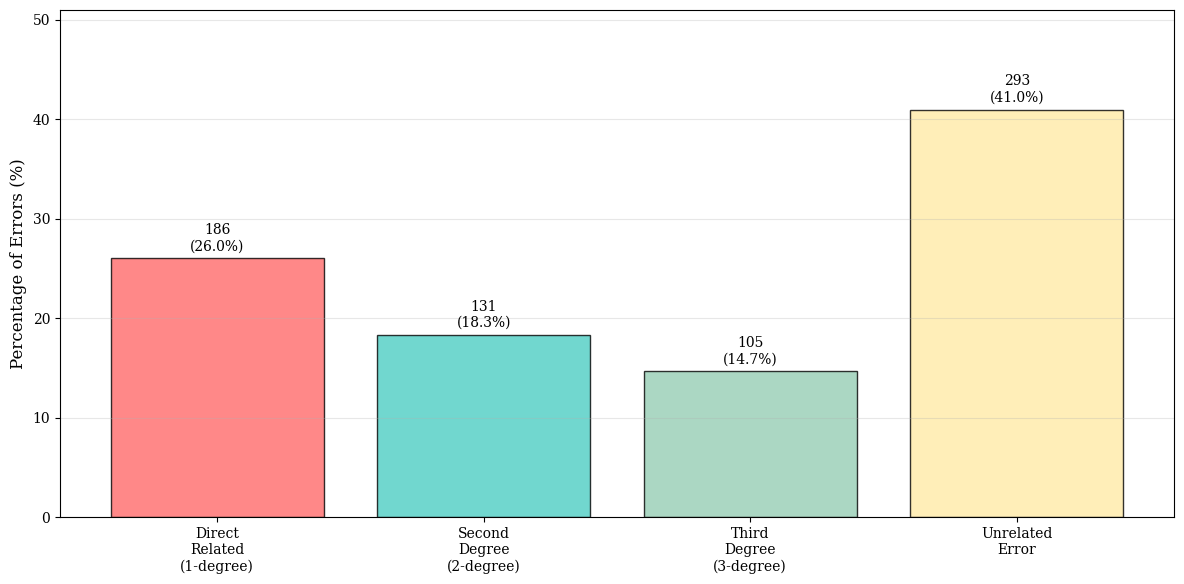

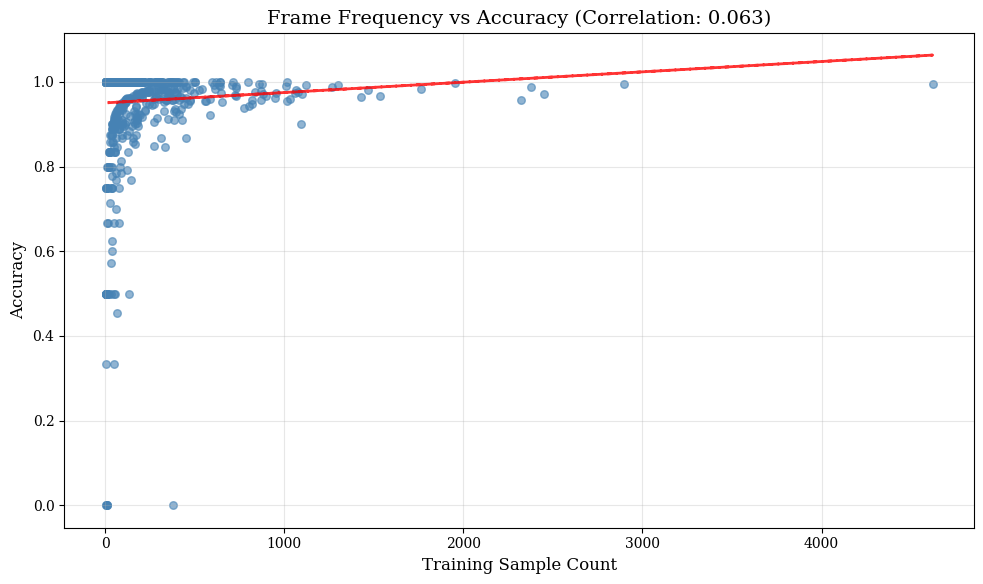


üîç Â§±Ë¥•ÁâπÂæÅÂàÜÊûê...


NameError: name 'predictions_df' is not defined

In [29]:
# =============================================================================
# @title ‚úÖ ÈîôËØØÂàÜÊûê
# =============================================================================

# =============================================================================
# ÁÆÄÂåñÁâàÈîôËØØÂàÜÊûê - ÈÅøÂÖçKeyError
# =============================================================================

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from collections import defaultdict

# ËÆæÁΩÆÂ≠ó‰Ωì
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.serif'] = ['Times New Roman', 'Cambria', 'DejaVu Serif']

def run_simple_error_analysis():
    """ËøêË°åÁÆÄÂåñÁöÑÈîôËØØÂàÜÊûê - ÂåÖÂê´full textÈ¢ÑÊµãÁªìÊûú"""

    print("üöÄ ÂºÄÂßãÁÆÄÂåñÈîôËØØÂàÜÊûê...")

    # 1. ÊåâÁÖß‰Ω†ÁöÑÊñπÂºèÂä†ËΩΩÊ®°ÂûãÂíåÊï∞ÊçÆ
    try:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"‰ΩøÁî®ËÆæÂ§á: {device}")

        # Âä†ËΩΩÊúÄ‰Ω≥Ê®°Âûã - ‰ΩøÁî®‰Ω†ÁöÑÊµÅÁ®ã
        model_path = "/content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt"
        print(f"Âä†ËΩΩÊ®°Âûã: {model_path}")

        # ÂàõÂª∫learnerÂπ∂Âä†ËΩΩÊ®°Âûã
        learner = OptimizedPrototypeLearner(device)
        checkpoint = torch.load(model_path, map_location=device, weights_only=False)
        learner.model.load_state_dict(checkpoint['model_state_dict'])

        # Â∞ÜprototypesËΩ¨Êç¢‰∏∫CPU‰∏äÁöÑnumpyÊ†ºÂºè
        raw_prototypes = checkpoint['prototypes']
        learner.prototypes = {}
        for frame_name, proto in raw_prototypes.items():
            if isinstance(proto, torch.Tensor):
                learner.prototypes[frame_name] = proto.cpu().numpy()
            else:
                learner.prototypes[frame_name] = proto

        print(f"Ê®°ÂûãÂä†ËΩΩÊàêÂäüÔºåÂéüÂûãÊï∞Èáè: {len(learner.prototypes)}")

        # Âä†ËΩΩÊï∞ÊçÆ
        test_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")
        full_test_df = pd.read_pickle("/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl")
        train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
        train_counts = train_df['frame_name'].value_counts()

        with open("/content/drive/MyDrive/more50/framenet_data/frame_relations.pkl", "rb") as f:
            frame_relations = pickle.load(f)

    except Exception as e:
        print(f"‚ùå Êï∞ÊçÆÂä†ËΩΩÂ§±Ë¥•: {e}")
        return None

    # 2. ËØÑ‰º∞ÂéüÂßãÊµãËØïÈõÜ
    print("\n" + "="*50)
    print("ËØÑ‰º∞ÂéüÂßãÊµãËØïÈõÜ")
    print("="*50)
    result1 = evaluate_target_known(learner.model, learner.tokenizer, test_df, learner.prototypes)
    print(f"Top-1 ÂáÜÁ°ÆÁéá: {result1['top1_accuracy']:.4f}")
    print(f"Top-3 ÂáÜÁ°ÆÁéá: {result1['top3_accuracy']:.4f}")

    # 3. ËØÑ‰º∞Full textÊµãËØïÈõÜ
    print("\n" + "="*50)
    print("ËØÑ‰º∞Full TextÊµãËØïÈõÜ")
    print("="*50)
    result2 = evaluate_target_known(learner.model, learner.tokenizer, full_test_df, learner.prototypes)
    print(f"Top-1 ÂáÜÁ°ÆÁéá: {result2['top1_accuracy']:.4f}")
    print(f"Top-3 ÂáÜÁ°ÆÁéá: {result2['top3_accuracy']:.4f}")

    # 4. ÁªìÊûúÂØπÊØî
    print("\n" + "="*50)
    print("ÁªìÊûúÂØπÊØî")
    print("="*50)
    print(f"{'ÊåáÊ†á':<15} {'ÂéüÂßãÊµãËØïÈõÜ':<12} {'Full Text':<12} {'Â∑ÆÂºÇ':<10}")
    print("-" * 50)
    print(f"Top-1 ÂáÜÁ°ÆÁéá    {result1['top1_accuracy']:.4f}       {result2['top1_accuracy']:.4f}       {result2['top1_accuracy']-result1['top1_accuracy']:+.4f}")
    print(f"Top-3 ÂáÜÁ°ÆÁéá    {result1['top3_accuracy']:.4f}       {result2['top3_accuracy']:.4f}       {result2['top3_accuracy']-result1['top3_accuracy']:+.4f}")

    # 5. ÁîüÊàêÂéüÂßãÊµãËØïÈõÜÁöÑËØ¶ÁªÜÈ¢ÑÊµãÁªìÊûú
    print("\nüîç ÁîüÊàêÂéüÂßãÊµãËØïÈõÜËØ¶ÁªÜÈ¢ÑÊµãÁªìÊûú...")
    original_predictions_df = generate_detailed_predictions(learner, test_df, "ÂéüÂßãÊµãËØïÈõÜ")

    # 6. ÁîüÊàêFull textÊµãËØïÈõÜÁöÑËØ¶ÁªÜÈ¢ÑÊµãÁªìÊûú
    print("\nüîç ÁîüÊàêFull textÊµãËØïÈõÜËØ¶ÁªÜÈ¢ÑÊµãÁªìÊûú...")
    fulltext_predictions_df = generate_detailed_predictions(learner, full_test_df, "Full textÊµãËØïÈõÜ")

    # 7. ‰øùÂ≠òÈ¢ÑÊµãÁªìÊûú
    save_dir = "/content/drive/MyDrive/more50/framenet_data"
    original_predictions_df.to_pickle(f"{save_dir}/original_test_detailed_predictions.pkl")
    fulltext_predictions_df.to_pickle(f"{save_dir}/fulltext_test_detailed_predictions.pkl")
    print(f"‚úÖ È¢ÑÊµãÁªìÊûúÂ∑≤‰øùÂ≠òÂà∞ {save_dir}")

    # 8. Âè™ÂØπÂéüÂßãÊµãËØïÈõÜËøõË°åÈîôËØØÂàÜÊûê
    print("\n" + "="*50)
    print("ÂéüÂßãÊµãËØïÈõÜÈîôËØØÂàÜÊûê")
    print("="*50)

    predictions_df = original_predictions_df  # Âè™ÂàÜÊûêÂéüÂßãÊµãËØïÈõÜ

    # Â§±Ë¥•ÁâπÂæÅÂàÜÊûê
    print("\nüîç Â§±Ë¥•ÁâπÂæÅÂàÜÊûê...")
    top3_failures = predictions_df[~predictions_df['is_top3_correct']]['true_frame'].value_counts()
    ranking_failures = predictions_df[
        (~predictions_df['is_top1_correct']) & (predictions_df['is_top3_correct'])
    ]['true_frame'].value_counts()

    print(f"Top-3ÂÆåÂÖ®Â§±Ë¥•: {len(top3_failures)}‰∏™‰∏çÂêåframesÔºåÂÖ±{top3_failures.sum()}Ê¨°Â§±Ë¥•")
    print("   ÊúÄÂÆπÊòìÂÆåÂÖ®Â§±Ë¥•ÁöÑframes:")
    for frame, count in top3_failures.head(5).items():
        train_count = train_counts.get(frame, 0)
        print(f"     {frame}: {count}Ê¨°Â§±Ë¥• (ËÆ≠ÁªÉÊ†∑Êú¨: {train_count})")

    print(f"\nTop-1Â§±Ë¥•‰ΩÜTop-3ÊàêÂäü: {len(ranking_failures)}‰∏™‰∏çÂêåframesÔºåÂÖ±{ranking_failures.sum()}Ê¨°ÊéíÂ∫èÈóÆÈ¢ò")
    print("   ÊúÄÂÆπÊòìÊéíÂ∫èÈîôËØØÁöÑframes:")
    for frame, count in ranking_failures.head(5).items():
        train_count = train_counts.get(frame, 0)
        print(f"     {frame}: {count}Ê¨°ÊéíÂ∫èÈîôËØØ (ËÆ≠ÁªÉÊ†∑Êú¨: {train_count})")

    # ËØ≠‰πâÂÖ≥Á≥ªÂàÜÊûê
    print("\nüß† ËØ≠‰πâÂÖ≥Á≥ªÂàÜÊûê...")
    semantic_results = analyze_semantic_relations_simple(predictions_df, frame_relations)

    # Ê†∑Êú¨È•±ÂíåÊïàÂ∫î
    print("\nüìä Ê†∑Êú¨È•±ÂíåÊïàÂ∫î...")
    saturation_results = analyze_sample_saturation_simple(predictions_df, train_counts)

    # ÁîüÊàêÂõæË°®
    print("\nüìä ÁîüÊàêÂõæË°®...")
    generate_charts(semantic_results, saturation_results, save_dir)

    print("\n‚úÖ ÂàÜÊûêÂÆåÊàê!")

    return {
        'original_predictions': original_predictions_df,
        'fulltext_predictions': fulltext_predictions_df,
        'original_results': result1,
        'fulltext_results': result2
    }

def generate_detailed_predictions(learner, test_df, dataset_name):
    """ÁîüÊàêËØ¶ÁªÜÈ¢ÑÊµãÁªìÊûú"""
    print(f"üìä Â§ÑÁêÜ{dataset_name}...")

    # ÂáÜÂ§áÂéüÂûãÊï∞ÊçÆ
    prototype_frames = list(learner.prototypes.keys())
    prototype_vectors = [learner.prototypes[frame] for frame in prototype_frames]
    prototype_matrix = np.array(prototype_vectors)

    # ÂáÜÂ§áÊµãËØïÊï∞ÊçÆ
    test_sentences = test_df['sentence'].tolist()
    test_spans_list = test_df['target_spans'].tolist()
    test_frames = test_df['frame_name'].tolist()

    # ËøáÊª§ÊúâÊïàÊï∞ÊçÆ
    valid_indices = []
    valid_sentences = []
    valid_spans = []
    valid_frames = []

    for i, spans in enumerate(test_spans_list):
        if spans and len(spans) > 0:
            valid_indices.append(i)
            valid_sentences.append(test_sentences[i])
            valid_spans.append(spans)
            valid_frames.append(test_frames[i])

    print(f"üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: {len(valid_indices)}/{len(test_df)}")

    # ÊâπÈáèÁºñÁ†Å
    learner.model.eval()
    test_embeddings = encode_target_spans_batch(
        valid_sentences, valid_spans, learner.tokenizer, learner.model,
        batch_size=64, train_mode=False
    ).cpu().numpy()

    # ËÆ°ÁÆóÁõ∏‰ººÂ∫¶
    from sklearn.metrics.pairwise import cosine_similarity
    similarities = cosine_similarity(test_embeddings, prototype_matrix)

    # ÊûÑÂª∫È¢ÑÊµãÁªìÊûú
    predictions_data = []
    for i, gold_frame in enumerate(valid_frames):
        scores = similarities[i]
        sorted_indices = np.argsort(scores)[::-1]  # ÈôçÂ∫è

        result_row = {
            'sentence_id': valid_indices[i],
            'sentence': valid_sentences[i],
            'target_spans': valid_spans[i],
            'true_frame': gold_frame,
            'top1_prediction': prototype_frames[sorted_indices[0]],
            'top3_predictions': [prototype_frames[idx] for idx in sorted_indices[:3]],
            'max_confidence': float(scores[sorted_indices[0]]),
            'is_top1_correct': gold_frame == prototype_frames[sorted_indices[0]],
            'is_top3_correct': gold_frame in [prototype_frames[idx] for idx in sorted_indices[:3]]
        }
        predictions_data.append(result_row)

    predictions_df = pd.DataFrame(predictions_data)

    # È™åËØÅÂáÜÁ°ÆÁéá
    calculated_top1 = predictions_df['is_top1_correct'].mean()
    calculated_top3 = predictions_df['is_top3_correct'].mean()
    print(f"üéØ {dataset_name} Top1ÂáÜÁ°ÆÁéá: {calculated_top1:.4f}")
    print(f"üéØ {dataset_name} Top3ÂáÜÁ°ÆÁéá: {calculated_top3:.4f}")

    return predictions_df

def analyze_semantic_relations_simple(predictions_df, frame_relations):
    """ÁÆÄÂåñÁöÑËØ≠‰πâÂÖ≥Á≥ªÂàÜÊûê"""
    # ÊûÑÂª∫ÂÖ≥Á≥ªÂõæ
    direct_relations = defaultdict(set)
    for frame, relations in frame_relations.items():
        for related_frame, rel_type, direction, label in relations:
            direct_relations[frame].add(related_frame)
            direct_relations[related_frame].add(frame)

    # ‰∫åÁ∫ßÂÖ≥Á≥ª
    second_degree_relations = defaultdict(set)
    for frame in direct_relations:
        for related_frame in direct_relations[frame]:
            for second_degree in direct_relations[related_frame]:
                if second_degree != frame and second_degree not in direct_relations[frame]:
                    second_degree_relations[frame].add(second_degree)

    # ‰∏âÁ∫ßÂÖ≥Á≥ª
    third_degree_relations = defaultdict(set)
    for frame in direct_relations:
        reachable_via_direct = direct_relations[frame].copy()
        reachable_via_second = second_degree_relations[frame].copy()

        for second_frame in second_degree_relations[frame]:
            for third_degree in direct_relations[second_frame]:
                if (third_degree != frame and
                    third_degree not in reachable_via_direct and
                    third_degree not in reachable_via_second):
                    third_degree_relations[frame].add(third_degree)

    # ÂàÜÊûêÈîôËØØ
    wrong_predictions = predictions_df[~predictions_df['is_top1_correct']]

    direct_errors = 0
    second_errors = 0
    third_errors = 0

    for _, row in wrong_predictions.iterrows():
        true_frame = row['true_frame']
        pred_frame = row['top1_prediction']

        if pred_frame in direct_relations[true_frame]:
            direct_errors += 1
        elif pred_frame in second_degree_relations[true_frame]:
            second_errors += 1
        elif pred_frame in third_degree_relations[true_frame]:
            third_errors += 1

    total_errors = len(wrong_predictions)
    semantic_errors = direct_errors + second_errors + third_errors
    unrelated_errors = total_errors - semantic_errors

    print(f"ÊÄªÈîôËØØÊï∞: {total_errors}")
    print(f"Áõ¥Êé•Áõ∏ÂÖ≥ÈîôËØØ (1Á∫ß): {direct_errors} ({direct_errors/total_errors:.3f})")
    print(f"‰∫åÁ∫ßÁõ∏ÂÖ≥ÈîôËØØ (2Á∫ß): {second_errors} ({second_errors/total_errors:.3f})")
    print(f"‰∏âÁ∫ßÁõ∏ÂÖ≥ÈîôËØØ (3Á∫ß): {third_errors} ({third_errors/total_errors:.3f})")
    print(f"ËØ≠‰πâÁõ∏ÂÖ≥ÈîôËØØÊÄªËÆ°: {semantic_errors} ({semantic_errors/total_errors:.3f})")
    print(f"Êó†ÂÖ≥ÈîôËØØ: {unrelated_errors} ({unrelated_errors/total_errors:.3f})")

    return {
        'total_errors': total_errors,
        'direct_errors': direct_errors,
        'second_errors': second_errors,
        'third_errors': third_errors,
        'unrelated_errors': unrelated_errors
    }

def analyze_sample_saturation_simple(predictions_df, train_counts):
    """ÁÆÄÂåñÁöÑÊ†∑Êú¨È•±ÂíåÊïàÂ∫îÂàÜÊûê"""
    frame_accuracy = predictions_df.groupby('true_frame').agg({
        'is_top1_correct': 'mean',
        'true_frame': 'count'
    }).rename(columns={'true_frame': 'test_count'})

    frame_accuracy['train_count'] = frame_accuracy.index.map(train_counts).fillna(0)

    bins = [0, 5, 10, 20, 50, 100, float('inf')]
    bin_labels = ['1-5', '6-10', '11-20', '21-50', '51-100', '100+']

    for i, (start, end) in enumerate(zip(bins[:-1], bins[1:])):
        mask = (frame_accuracy['train_count'] > start) & (frame_accuracy['train_count'] <= end)
        segment_data = frame_accuracy[mask]

        if len(segment_data) > 0:
            print(f"  {bin_labels[i]}Ê†∑Êú¨: {len(segment_data)}‰∏™frames, "
                  f"ÂáÜÁ°ÆÁéá {segment_data['is_top1_correct'].mean():.3f}¬±{segment_data['is_top1_correct'].std():.3f}")

    return frame_accuracy

def generate_charts(semantic_results, frame_accuracy, save_dir):
    """ÁîüÊàêÂõæË°®"""
    # ËØ≠‰πâÈîôËØØÂàÜËß£Âõæ
    plt.figure(figsize=(12, 6))
    categories = ['Direct\nRelated\n(1-degree)', 'Second\nDegree\n(2-degree)', 'Third\nDegree\n(3-degree)', 'Unrelated\nError']
    values = [semantic_results['direct_errors'], semantic_results['second_errors'],
              semantic_results['third_errors'], semantic_results['unrelated_errors']]
    percentages = [v/semantic_results['total_errors']*100 for v in values]

    colors = ['#FF6B6B', '#4ECDC4', '#96CEB4', '#FFEAA7']
    bars = plt.bar(categories, percentages, color=colors, alpha=0.8, edgecolor='black')

    for bar, value in zip(bars, values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{value}\n({height:.1f}%)', ha='center', va='bottom', fontsize=10)

    plt.ylabel('Percentage of Errors (%)')
    plt.ylim(0, max(percentages) + 10)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig(f'{save_dir}/semantic_error_breakdown.png', dpi=300, bbox_inches='tight')
    plt.show()

    # È¢ëÁéáÁõ∏ÂÖ≥Âõæ
    plt.figure(figsize=(10, 6))
    plt.scatter(frame_accuracy['train_count'], frame_accuracy['is_top1_correct'],
                alpha=0.6, s=30, color='#4682B4')
    plt.xlabel('Training Sample Count')
    plt.ylabel('Accuracy')

    correlation = frame_accuracy['train_count'].corr(frame_accuracy['is_top1_correct'])
    plt.title(f'Frame Frequency vs Accuracy (Correlation: {correlation:.3f})')
    plt.grid(True, alpha=0.3)

    z = np.polyfit(frame_accuracy['train_count'], frame_accuracy['is_top1_correct'], 1)
    p = np.poly1d(z)
    plt.plot(frame_accuracy['train_count'], p(frame_accuracy['train_count']),
             "r--", alpha=0.8, linewidth=2)

    plt.tight_layout()
    plt.savefig(f'{save_dir}/frequency_accuracy_correlation.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 2. Â§±Ë¥•ÁâπÂæÅÂàÜÊûê
    print("\nüîç Â§±Ë¥•ÁâπÂæÅÂàÜÊûê...")
    top3_failures = predictions_df[~predictions_df['is_top3_correct']]['true_frame'].value_counts()
    ranking_failures = predictions_df[
        (~predictions_df['is_top1_correct']) & (predictions_df['is_top3_correct'])
    ]['true_frame'].value_counts()

    print(f"Top-3ÂÆåÂÖ®Â§±Ë¥•: {len(top3_failures)}‰∏™‰∏çÂêåframesÔºåÂÖ±{top3_failures.sum()}Ê¨°Â§±Ë¥•")
    print(f"Top-1Â§±Ë¥•‰ΩÜTop-3ÊàêÂäü: {len(ranking_failures)}‰∏™‰∏çÂêåframesÔºåÂÖ±{ranking_failures.sum()}Ê¨°ÊéíÂ∫èÈóÆÈ¢ò")

    # 3. ËØ≠‰πâÂÖ≥Á≥ªÂàÜÊûê
    print("\nüß† ËØ≠‰πâÂÖ≥Á≥ªÂàÜÊûê...")

    # ÊûÑÂª∫ÂÖ≥Á≥ªÂõæ
    direct_relations = defaultdict(set)
    for frame, relations in frame_relations.items():
        for related_frame, rel_type, direction, label in relations:
            direct_relations[frame].add(related_frame)
            direct_relations[related_frame].add(frame)

    # ‰∫åÁ∫ßÂÖ≥Á≥ª
    second_degree_relations = defaultdict(set)
    for frame in direct_relations:
        for related_frame in direct_relations[frame]:
            for second_degree in direct_relations[related_frame]:
                if second_degree != frame and second_degree not in direct_relations[frame]:
                    second_degree_relations[frame].add(second_degree)

    # ‰∏âÁ∫ßÂÖ≥Á≥ª
    third_degree_relations = defaultdict(set)
    for frame in direct_relations:
        reachable_via_direct = direct_relations[frame].copy()
        reachable_via_second = second_degree_relations[frame].copy()

        for second_frame in second_degree_relations[frame]:
            for third_degree in direct_relations[second_frame]:
                if (third_degree != frame and
                    third_degree not in reachable_via_direct and
                    third_degree not in reachable_via_second):
                    third_degree_relations[frame].add(third_degree)

    # ÂàÜÊûêÈîôËØØ
    wrong_predictions = predictions_df[~predictions_df['is_top1_correct']]

    direct_errors = 0
    second_errors = 0
    third_errors = 0

    for _, row in wrong_predictions.iterrows():
        true_frame = row['true_frame']
        pred_frame = row['top1_prediction']

        if pred_frame in direct_relations[true_frame]:
            direct_errors += 1
        elif pred_frame in second_degree_relations[true_frame]:
            second_errors += 1
        elif pred_frame in third_degree_relations[true_frame]:
            third_errors += 1

    total_errors = len(wrong_predictions)
    semantic_errors = direct_errors + second_errors + third_errors
    unrelated_errors = total_errors - semantic_errors

    print(f"ÊÄªÈîôËØØÊï∞: {total_errors}")
    print(f"Áõ¥Êé•Áõ∏ÂÖ≥ÈîôËØØ (1Á∫ß): {direct_errors} ({direct_errors/total_errors:.3f})")
    print(f"‰∫åÁ∫ßÁõ∏ÂÖ≥ÈîôËØØ (2Á∫ß): {second_errors} ({second_errors/total_errors:.3f})")
    print(f"‰∏âÁ∫ßÁõ∏ÂÖ≥ÈîôËØØ (3Á∫ß): {third_errors} ({third_errors/total_errors:.3f})")
    print(f"ËØ≠‰πâÁõ∏ÂÖ≥ÈîôËØØÊÄªËÆ°: {semantic_errors} ({semantic_errors/total_errors:.3f})")
    print(f"Êó†ÂÖ≥ÈîôËØØ: {unrelated_errors} ({unrelated_errors/total_errors:.3f})")

    # 4. Ê†∑Êú¨È•±ÂíåÊïàÂ∫î
    print("\nüìä Ê†∑Êú¨È•±ÂíåÊïàÂ∫î...")
    frame_accuracy = predictions_df.groupby('true_frame').agg({
        'is_top1_correct': 'mean',
        'true_frame': 'count'
    }).rename(columns={'true_frame': 'test_count'})

    frame_accuracy['train_count'] = frame_accuracy.index.map(train_counts).fillna(0)

    bins = [0, 5, 10, 20, 50, 100, float('inf')]
    bin_labels = ['1-5', '6-10', '11-20', '21-50', '51-100', '100+']

    for i, (start, end) in enumerate(zip(bins[:-1], bins[1:])):
        mask = (frame_accuracy['train_count'] > start) & (frame_accuracy['train_count'] <= end)
        segment_data = frame_accuracy[mask]

        if len(segment_data) > 0:
            print(f"  {bin_labels[i]}Ê†∑Êú¨: {len(segment_data)}‰∏™frames, "
                  f"ÂáÜÁ°ÆÁéá {segment_data['is_top1_correct'].mean():.3f}¬±{segment_data['is_top1_correct'].std():.3f}")

    # 5. ÁîüÊàêÂõæË°®
    print("\nüìä ÁîüÊàêÂõæË°®...")
    save_dir = "/content/drive/MyDrive/more50/framenet_data"

    # ËØ≠‰πâÈîôËØØÂàÜËß£Âõæ
    plt.figure(figsize=(12, 6))
    categories = ['Direct\nRelated\n(1-degree)', 'Second\nDegree\n(2-degree)', 'Third\nDegree\n(3-degree)', 'Unrelated\nError']
    values = [direct_errors, second_errors, third_errors, unrelated_errors]
    percentages = [v/total_errors*100 for v in values]

    colors = ['#FF6B6B', '#4ECDC4', '#96CEB4', '#FFEAA7']
    bars = plt.bar(categories, percentages, color=colors, alpha=0.8, edgecolor='black')

    for bar, value in zip(bars, values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{value}\n({height:.1f}%)', ha='center', va='bottom', fontsize=10)

    plt.ylabel('Percentage of Errors (%)')
    plt.ylim(0, max(percentages) + 10)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig(f'{save_dir}/semantic_error_breakdown.png', dpi=300, bbox_inches='tight')
    plt.show()

    # È¢ëÁéáÁõ∏ÂÖ≥Âõæ
    plt.figure(figsize=(10, 6))
    plt.scatter(frame_accuracy['train_count'], frame_accuracy['is_top1_correct'],
                alpha=0.6, s=30, color='#4682B4')
    plt.xlabel('Training Sample Count')
    plt.ylabel('Accuracy')

    correlation = frame_accuracy['train_count'].corr(frame_accuracy['is_top1_correct'])
    plt.title(f'Frame Frequency vs Accuracy (Correlation: {correlation:.3f})')
    plt.grid(True, alpha=0.3)

    z = np.polyfit(frame_accuracy['train_count'], frame_accuracy['is_top1_correct'], 1)
    p = np.poly1d(z)
    plt.plot(frame_accuracy['train_count'], p(frame_accuracy['train_count']),
             "r--", alpha=0.8, linewidth=2)

    plt.tight_layout()
    plt.savefig(f'{save_dir}/frequency_accuracy_correlation.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("‚úÖ ÂàÜÊûêÂÆåÊàê!")

    return {
        'semantic_errors': {
            'direct': direct_errors,
            'second': second_errors,
            'third': third_errors,
            'unrelated': unrelated_errors,
            'total': total_errors
        },
        'frame_accuracy': frame_accuracy
    }

# ËøêË°åÂàÜÊûê
if __name__ == "__main__":
    results = run_simple_error_analysis()

In [54]:
import torch
import pandas as pd
import numpy as np
import os
from transformers import AutoModel, AutoTokenizer
from collections import defaultdict
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from glob import glob

def auto_kmeans_dbi(embeddings, max_k=5):
    """DBI Ëá™Âä®ÈÄâÊã©ËÅöÁ±ªÊï∞ÔºàKMeansÔºâ"""
    if len(embeddings) == 1:
        return [embeddings[0]]
    if len(embeddings) == 2:
        return [np.mean(embeddings, axis=0)]  # ‰∏çË∂≥‰ª•ËÅöÁ±ªÔºåÁõ¥Êé•Âπ≥Âùá

    best_score = float("inf")
    best_centers = None
    for k in range(2, min(max_k, len(embeddings))):  # Ê≥®ÊÑèÂéªÊéâ +1
        kmeans = KMeans(n_clusters=k, n_init="auto", random_state=42)
        labels = kmeans.fit_predict(embeddings)
        score = davies_bouldin_score(embeddings, labels)
        if score < best_score:
            best_score = score
            best_centers = kmeans.cluster_centers_

    if best_centers is not None:
        return list(best_centers)
    else:
        return [np.mean(embeddings, axis=0)]

def load_best_trained_model():
    """Âä†ËΩΩÊúÄ‰Ω≥ËÆ≠ÁªÉÊ®°Âûã"""
    print("üöÄ Âä†ËΩΩÊúÄ‰Ω≥ËÆ≠ÁªÉÊ®°Âûã...")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Êü•ÊâæÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂
    checkpoint_dir = "/content/drive/MyDrive/more50/framenet_data/checkpoints"

    # Êåâ‰ºòÂÖàÁ∫ßÊü•ÊâæÊ®°ÂûãÊñá‰ª∂
    possible_paths = [
        f"{checkpoint_dir}/best_model.pt",
        f"{checkpoint_dir}/complete_model_final.pt",
        f"{checkpoint_dir}/first_stage_complete.pt"
    ]

    # ‰πüÊü•ÊâæÂÖ∂‰ªñÂèØËÉΩÁöÑÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂
    other_best_files = glob(f"{checkpoint_dir}/best_model*.pt")
    possible_paths.extend(other_best_files)

    best_model_path = None
    for path in possible_paths:
        if os.path.exists(path):
            best_model_path = path
            print(f"üìÅ ÊâæÂà∞Ê®°Âûã: {os.path.basename(path)}")
            break

    if not best_model_path:
        print("‚ùå Êú™ÊâæÂà∞ÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂ÔºÅ")
        return None, None, None, None

    # Âä†ËΩΩÊ®°Âûã
    model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

    try:
        checkpoint = torch.load(best_model_path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])

        # Ëé∑ÂèñËÆ≠ÁªÉÊó∂ÁöÑÊúÄ‰Ω≥ÂáÜÁ°ÆÁéá
        if 'best_val_acc' in checkpoint:
            best_acc = checkpoint['best_val_acc']
        elif 'final_accuracy' in checkpoint:
            best_acc = checkpoint['final_accuracy']
        elif 'baseline_accuracy' in checkpoint:
            best_acc = checkpoint['baseline_accuracy']
        else:
            best_acc = 0.0

        print(f"‚úÖ ÊàêÂäüÂä†ËΩΩÊ®°ÂûãÔºåËÆ≠ÁªÉÊó∂ÊúÄ‰Ω≥ÂáÜÁ°ÆÁéá: {best_acc:.4f}")
        return model, tokenizer, device, best_acc

    except Exception as e:
        print(f"‚ùå Ê®°ÂûãÂä†ËΩΩÂ§±Ë¥•: {e}")
        return None, None, None, None

def build_clustered_prototypes_from_trained_model(model, tokenizer, train_df, device):
    """‰ΩøÁî®ËÆ≠ÁªÉÂ•ΩÁöÑÊ®°ÂûãÈáçÊñ∞ÁºñÁ†ÅÂπ∂ÊûÑÂª∫ËÅöÁ±ªÂéüÂûã"""
    print("\nüîÑ ‰ΩøÁî®ËÆ≠ÁªÉÂ•ΩÁöÑÊ®°ÂûãÈáçÊñ∞ÁºñÁ†ÅËÆ≠ÁªÉÊï∞ÊçÆÂπ∂ÊûÑÂª∫ËÅöÁ±ªÂéüÂûã...")

    model.eval()
    frame2embeds = defaultdict(list)

    # ÈáçÊñ∞ÁºñÁ†ÅÊâÄÊúâËÆ≠ÁªÉÊï∞ÊçÆ
    with torch.no_grad():
        for i in tqdm(range(0, len(train_df), 64), desc="ÈáçÊñ∞ÁºñÁ†ÅËÆ≠ÁªÉÊï∞ÊçÆ"):
            batch = train_df.iloc[i:i+64]
            try:
                embs = encode_target_spans_batch(
                    batch['sentence'].tolist(),
                    batch['target_spans'].tolist(),
                    tokenizer, model,
                    batch_size=len(batch), train_mode=False
                )

                # Êî∂ÈõÜÊØè‰∏™frameÁöÑembeddings
                for j, frame_name in enumerate(batch['frame_name']):
                    if torch.is_tensor(embs[j]):
                        frame2embeds[frame_name].append(embs[j].cpu().numpy())
                    else:
                        frame2embeds[frame_name].append(embs[j])

            except Exception as e:
                print(f"ÊâπÊ¨°ÁºñÁ†ÅÈîôËØØ: {e}")
                continue

    print(f"ÁºñÁ†ÅÂÆåÊàêÔºåÊî∂ÈõÜÂà∞ {len(frame2embeds)} ‰∏™frameÁöÑembeddings")

    # ÂØπÊØè‰∏™frameËøõË°åËÅöÁ±ªÊûÑÈÄ†Â≠êÂéüÂûã
    print("\nüéØ ÂØπÊØè‰∏™frameËøõË°åËÅöÁ±ª...")
    frame_multi_prototypes = {}
    clustering_stats = {
        'single_prototype': 0,
        'multi_prototype': 0,
        'total_prototypes': 0
    }

    for frame, embeds in tqdm(frame2embeds.items(), desc="ËÅöÁ±ªÊûÑÂª∫ÂéüÂûã"):
        embeds = np.array(embeds)

        if len(embeds) == 1:
            frame_multi_prototypes[frame] = [embeds[0]]
            clustering_stats['single_prototype'] += 1
            clustering_stats['total_prototypes'] += 1
        else:
            centers = auto_kmeans_dbi(embeds)
            frame_multi_prototypes[frame] = centers

            if len(centers) == 1:
                clustering_stats['single_prototype'] += 1
            else:
                clustering_stats['multi_prototype'] += 1
            clustering_stats['total_prototypes'] += len(centers)

    print(f"ËÅöÁ±ªÂÆåÊàê:")
    print(f"  ÂçïÂéüÂûãframe: {clustering_stats['single_prototype']}")
    print(f"  Â§öÂéüÂûãframe: {clustering_stats['multi_prototype']}")
    print(f"  ÊÄªÂéüÂûãÊï∞Èáè: {clustering_stats['total_prototypes']}")

    return frame_multi_prototypes, clustering_stats

def evaluate_with_multi_prototypes(model, tokenizer, test_df, frame_multi_prototypes, batch_size=64):
    """
    ‰ΩøÁî®Â§öÂéüÂûãËøõË°åËØÑ‰º∞ÔºåÂØπÊØè‰∏™Ê†∑Êú¨ÈÄâÊã©ÊúÄÊé•ËøëÁöÑÂ≠êÂéüÂûã
    """
    from sklearn.metrics import precision_recall_fscore_support
    from sklearn.metrics.pairwise import cosine_similarity

    model.eval()
    print("üìä ‰ΩøÁî®Â§öÂéüÂûãÁ≥ªÁªüËøõË°åËØÑ‰º∞")

    # ÂáÜÂ§áÊâÄÊúâÂéüÂûã - Â±ïÂºÄÂ§öÂéüÂûã
    all_prototype_info = []  # (frame_name, prototype_idx, prototype_vector)
    all_prototype_vectors = []

    for frame_name, prototypes in frame_multi_prototypes.items():
        for i, prototype in enumerate(prototypes):
            all_prototype_info.append((frame_name, i))
            all_prototype_vectors.append(prototype)

    prototype_matrix = np.array(all_prototype_vectors)
    print(f"üéØ ËØÑ‰º∞ {len(test_df)} ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå{len(all_prototype_vectors)} ‰∏™ÂéüÂûã (Êù•Ëá™{len(frame_multi_prototypes)}‰∏™frame)")

    # ÊâπÈáèÁºñÁ†ÅÊµãËØïÊï∞ÊçÆÁöÑtarget spans
    test_sentences = test_df['sentence'].tolist()
    test_spans_list = test_df['target_spans'].tolist()
    test_frames = test_df['frame_name'].tolist()

    # ËøáÊª§Êó†Êïàspans
    valid_indices = []
    valid_sentences = []
    valid_spans = []
    valid_frames = []

    for i, spans in enumerate(test_spans_list):
        if spans and len(spans) > 0:
            valid_indices.append(i)
            valid_sentences.append(test_sentences[i])
            valid_spans.append(spans)
            valid_frames.append(test_frames[i])

    print(f"üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: {len(valid_indices)}/{len(test_df)}")

    # ÊâπÈáèÁºñÁ†Åtarget embeddings
    with torch.no_grad():
        test_embeddings_tensor = encode_target_spans_batch(
            valid_sentences, valid_spans, tokenizer, model,
            batch_size=batch_size, train_mode=False
        )
        test_embeddings = test_embeddings_tensor.detach().cpu().numpy()

    # ËÆ°ÁÆó‰∏éÊâÄÊúâÂéüÂûãÁöÑÁõ∏‰ººÂ∫¶
    similarities = cosine_similarity(test_embeddings, prototype_matrix)

    # ËØÑ‰º∞ÁªìÊûú
    y_true = []
    y_pred_top1 = []
    y_pred_top3 = []
    correct_top1 = 0
    correct_top3 = 0

    for i, gold_frame in enumerate(valid_frames):
        # Ëé∑ÂèñÊâÄÊúâÂéüÂûãÁöÑÁõ∏‰ººÂ∫¶ÂàÜÊï∞
        scores = similarities[i]

        # ÊåâframeÂàÜÁªÑËÆ°ÁÆóÊúÄÈ´òÁõ∏‰ººÂ∫¶
        frame_best_scores = {}
        for j, (frame_name, proto_idx) in enumerate(all_prototype_info):
            if frame_name not in frame_best_scores:
                frame_best_scores[frame_name] = scores[j]
            else:
                # ÂØπÊØè‰∏™frameÔºåÂèñËØ•frameÊâÄÊúâÂ≠êÂéüÂûã‰∏≠Áõ∏‰ººÂ∫¶ÊúÄÈ´òÁöÑÈÇ£‰∏™
                frame_best_scores[frame_name] = max(frame_best_scores[frame_name], scores[j])

        # Ê†πÊçÆframeÁ∫ßÂà´ÁöÑÊúÄÈ´òÂàÜÊï∞ÊéíÂ∫è
        sorted_frames = sorted(frame_best_scores.items(), key=lambda x: x[1], reverse=True)

        # Top-1ÂíåTop-3È¢ÑÊµã
        top1_pred = sorted_frames[0][0]
        top3_preds = [frame for frame, score in sorted_frames[:3]]

        y_true.append(gold_frame)
        y_pred_top1.append(top1_pred)
        y_pred_top3.append(top3_preds)

        if gold_frame == top1_pred:
            correct_top1 += 1
        if gold_frame in top3_preds:
            correct_top3 += 1

    # ËÆ°ÁÆóÂêÑÁßçÊåáÊ†á
    macro_p, macro_r, macro_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="macro", zero_division=0
    )
    weighted_p, weighted_r, weighted_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="weighted", zero_division=0
    )

    results = {
        "top1_accuracy": correct_top1 / len(valid_frames),
        "top3_accuracy": correct_top3 / len(valid_frames),
        "macro_precision": macro_p,
        "macro_recall": macro_r,
        "macro_f1": macro_f,
        "weighted_precision": weighted_p,
        "weighted_recall": weighted_r,
        "weighted_f1": weighted_f,
        "total_samples": len(valid_frames),
        "valid_samples": len(valid_frames),
        "prototype_count": len(all_prototype_vectors),
        "frame_count": len(frame_multi_prototypes)
    }

    # ÊâìÂç∞ÁªìÊûú
    print(f"\n‚úÖ Â§öÂéüÂûãËØÑ‰º∞ÁªìÊûú (ÊúÄÊé•ËøëÂ≠êÂéüÂûãÁ≠ñÁï•)")
    print(f"Top-1ÂáÜÁ°ÆÁéá: {results['top1_accuracy']:.4f}")
    print(f"Top-3ÂáÜÁ°ÆÁéá: {results['top3_accuracy']:.4f}")
    print(f"Macro F1: {results['macro_f1']:.4f}")
    print(f"Weighted F1: {results['weighted_f1']:.4f}")
    print(f"Â§ÑÁêÜÊ†∑Êú¨: {results['valid_samples']}/{len(test_df)}")
    print(f"‰ΩøÁî®ÂéüÂûã: {results['prototype_count']} (Êù•Ëá™{results['frame_count']}‰∏™frame)")

    return results

def test_clustered_model_on_datasets():
    """ÊµãËØïËÅöÁ±ªÊ®°ÂûãÂú®‰∏§‰∏™ÊµãËØïÈõÜ‰∏äÁöÑË°®Áé∞"""
    print("="*80)
    print("ÊµãËØïÊúÄ‰Ω≥ËÆ≠ÁªÉÊ®°Âûã+ËÅöÁ±ªÂéüÂûãÂú®‰∏§‰∏™ÊµãËØïÈõÜ‰∏äÁöÑË°®Áé∞")
    print("="*80)

    # 1. Âä†ËΩΩÊúÄ‰Ω≥ËÆ≠ÁªÉÊ®°Âûã
    model, tokenizer, device, train_best_acc = load_best_trained_model()
    if model is None:
        return None

    # 2. Âä†ËΩΩËÆ≠ÁªÉÊï∞ÊçÆÔºàÁî®‰∫éÈáçÊñ∞ÊûÑÂª∫ÂéüÂûãÔºâ
    print("\nüìä Âä†ËΩΩËÆ≠ÁªÉÊï∞ÊçÆ...")
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    print(f"ËÆ≠ÁªÉÊï∞ÊçÆ: {len(train_df):,} Ê†∑Êú¨")

    # 3. ‰ΩøÁî®ËÆ≠ÁªÉÂ•ΩÁöÑÊ®°ÂûãÈáçÊñ∞ÁºñÁ†ÅÂπ∂ÊûÑÂª∫ËÅöÁ±ªÂéüÂûã
    frame_multi_prototypes, clustering_stats = build_clustered_prototypes_from_trained_model(
        model, tokenizer, train_df, device
    )

    # 4. ÂàÜÊûêÂ§öÂéüÂûã‰ø°ÊÅØ
    multi_prototype_info = {}
    for frame_name, prototypes in frame_multi_prototypes.items():
        multi_prototype_info[frame_name] = {
            'count': len(prototypes),
            'method': 'multi_closest' if len(prototypes) > 1 else 'single'
        }

    # 5. Âä†ËΩΩ‰∏§‰∏™ÊµãËØïÈõÜ
    print("\nüìä Âä†ËΩΩÊµãËØïÈõÜ...")
    test_df_original = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")
    test_df_fulltext = pd.read_pickle("/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl")

    print(f"ÂéüÂßãÊµãËØïÈõÜ: {len(test_df_original):,} Ê†∑Êú¨")
    print(f"FulltextÊµãËØïÈõÜ: {len(test_df_fulltext):,} Ê†∑Êú¨")

    # 6. Âú®‰∏§‰∏™ÊµãËØïÈõÜ‰∏äËøõË°åËØÑ‰º∞
    results = {}

    # ÂéüÂßãÊµãËØïÈõÜËØÑ‰º∞
    print(f"\n" + "="*60)
    print("üìä Âú®ÂéüÂßãÊµãËØïÈõÜ‰∏äÊµãËØïËÅöÁ±ªÊ®°Âûã...")
    print("="*60)

    try:
        model.eval()
        result_original = evaluate_with_multi_prototypes(
            model, tokenizer, test_df_original, frame_multi_prototypes
        )

        results['original_test'] = result_original

        print(f"ÂéüÂßãÊµãËØïÈõÜÁªìÊûú:")
        print(f"  Top-1ÂáÜÁ°ÆÁéá: {result_original['top1_accuracy']:.4f}")
        print(f"  Top-3ÂáÜÁ°ÆÁéá: {result_original['top3_accuracy']:.4f}")
        print(f"  Macro F1: {result_original['macro_f1']:.4f}")
        print(f"  Weighted F1: {result_original['weighted_f1']:.4f}")

    except Exception as e:
        print(f"‚ùå ÂéüÂßãÊµãËØïÈõÜËØÑ‰º∞Â§±Ë¥•: {e}")
        import traceback
        traceback.print_exc()
        results['original_test'] = None

    # FulltextÊµãËØïÈõÜËØÑ‰º∞
    print(f"\n" + "="*60)
    print("üéØ Âú®FulltextÊµãËØïÈõÜ‰∏äÊµãËØïËÅöÁ±ªÊ®°Âûã...")
    print("="*60)

    try:
        model.eval()
        result_fulltext = evaluate_with_multi_prototypes(
            model, tokenizer, test_df_fulltext, frame_multi_prototypes
        )

        results['fulltext_test'] = result_fulltext

        print(f"FulltextÊµãËØïÈõÜÁªìÊûú:")
        print(f"  Top-1ÂáÜÁ°ÆÁéá: {result_fulltext['top1_accuracy']:.4f}")
        print(f"  Top-3ÂáÜÁ°ÆÁéá: {result_fulltext['top3_accuracy']:.4f}")
        print(f"  Macro F1: {result_fulltext['macro_f1']:.4f}")
        print(f"  Weighted F1: {result_fulltext['weighted_f1']:.4f}")

    except Exception as e:
        print(f"‚ùå FulltextÊµãËØïÈõÜËØÑ‰º∞Â§±Ë¥•: {e}")
        import traceback
        traceback.print_exc()
        results['fulltext_test'] = None

    # 7. ÁªìÊûúÊ±áÊÄª
    print(f"\n" + "="*80)
    print("ËÅöÁ±ªÊ®°ÂûãÊµãËØïÁªìÊûúÊ±áÊÄª (ÊúÄÊé•ËøëÂ≠êÂéüÂûãÁ≠ñÁï•)")
    print("="*80)

    print(f"Ê®°Âûã‰ø°ÊÅØ:")
    print(f"  ËÆ≠ÁªÉÊó∂ÊúÄ‰Ω≥ÂáÜÁ°ÆÁéá: {train_best_acc:.4f}")
    print(f"  ËÅöÁ±ªÁªüËÆ°: {clustering_stats}")

    # ÊòæÁ§∫Â§öÂéüÂûãÁªüËÆ°
    multi_frames = sum(1 for info in multi_prototype_info.values() if info['count'] > 1)
    total_prototypes = sum(info['count'] for info in multi_prototype_info.values())
    print(f"  Â§öÂéüÂûãframeÊï∞: {multi_frames}/{len(multi_prototype_info)}")
    print(f"  ÊÄªÂéüÂûãÊï∞Èáè: {total_prototypes}")

    print(f"\nÊµãËØïÈõÜÁªìÊûú:")
    print(f"{'ÊµãËØïÈõÜ':<15} {'Top-1':<8} {'Top-3':<8} {'Macro F1':<10} {'Weighted F1':<12}")
    print("-" * 60)

    if results['original_test']:
        orig = results['original_test']
        print(f"{'ÂéüÂßãÊµãËØïÈõÜ':<15} {orig['top1_accuracy']:<8.4f} {orig['top3_accuracy']:<8.4f} {orig['macro_f1']:<10.4f} {orig['weighted_f1']:<12.4f}")

    if results['fulltext_test']:
        full = results['fulltext_test']
        print(f"{'FulltextÊµãËØïÈõÜ':<15} {full['top1_accuracy']:<8.4f} {full['top3_accuracy']:<8.4f} {full['macro_f1']:<10.4f} {full['weighted_f1']:<12.4f}")

    # 8. ‰øùÂ≠òÁªìÊûú
    save_results_to_drive(results, clustering_stats, multi_prototype_info)

    return results, clustering_stats, multi_prototype_info

def save_results_to_drive(results, clustering_stats, multi_prototype_info):
    """‰øùÂ≠òÁªìÊûúÂà∞drive"""
    save_dir = "/content/drive/MyDrive/more50/framenet_data/clustering_test_results"
    os.makedirs(save_dir, exist_ok=True)

    save_data = {
        'test_results': results,
        'clustering_stats': clustering_stats,
        'multi_prototype_info': multi_prototype_info,
        'timestamp': pd.Timestamp.now().isoformat()
    }

    save_path = f"{save_dir}/clustered_model_test_results.pkl"
    import pickle
    with open(save_path, 'wb') as f:
        pickle.dump(save_data, f)

    print(f"\nüíæ ÁªìÊûúÂ∑≤‰øùÂ≠òËá≥: {save_path}")

def analyze_clustering_results():
    """ÁÆÄÂçïÂàÜÊûêËÅöÁ±ªÁªìÊûú"""
    print(f"\nüìà ËÅöÁ±ªÁªìÊûúÂàÜÊûê...")

    # ËøôÈáåÂèØ‰ª•Ê∑ªÂä†Êõ¥ËØ¶ÁªÜÁöÑÂàÜÊûêÔºåÊØîÂ¶ÇÔºö
    # - Âì™‰∫õframeË¢´ËÅöÁ±ª‰∫Ü
    # - ËÅöÁ±ªÊï∞ÈáèÂàÜÂ∏É
    # - ËÅöÁ±ªË¥®ÈáèËØÑ‰º∞Á≠â
    pass

# ËøêË°åÊµãËØï
if __name__ == "__main__":
    print("üöÄ ÂºÄÂßãÊµãËØïÊúÄ‰Ω≥ËÆ≠ÁªÉÊ®°Âûã+ËÅöÁ±ªÂéüÂûã...")

    try:
        results, clustering_stats, multi_prototype_info = test_clustered_model_on_datasets()

        if results:
            print(f"\n‚úÖ ÊµãËØïÂÆåÊàêÔºÅ")

            # ÁÆÄÂçïÁöÑÊÄßËÉΩÂàÜÊûê
            if results['original_test'] and results['fulltext_test']:
                orig_acc = results['original_test']['top1_accuracy']
                full_acc = results['fulltext_test']['top1_accuracy']

                print(f"\nüìä ÊÄßËÉΩÊÄªÁªì:")
                print(f"  ÂéüÂßãÊµãËØïÈõÜÂáÜÁ°ÆÁéá: {orig_acc:.4f}")
                print(f"  FulltextÊµãËØïÈõÜÂáÜÁ°ÆÁéá: {full_acc:.4f}")
                print(f"  ‰∏§‰∏™ÊµãËØïÈõÜÂπ≥ÂùáÂáÜÁ°ÆÁéá: {(orig_acc + full_acc) / 2:.4f}")

                if orig_acc > full_acc:
                    print(f"  ÂéüÂßãÊµãËØïÈõÜË°®Áé∞Êõ¥Â•Ω (+{orig_acc - full_acc:.4f})")
                else:
                    print(f"  FulltextÊµãËØïÈõÜË°®Áé∞Êõ¥Â•Ω (+{full_acc - orig_acc:.4f})")

        else:
            print(f"‚ùå ÊµãËØïÂ§±Ë¥•")

    except Exception as e:
        print(f"‚ùå ÊµãËØïËøáÁ®ãÂá∫Èîô: {e}")
        import traceback
        traceback.print_exc()

üöÄ ÂºÄÂßãÊµãËØïÊúÄ‰Ω≥ËÆ≠ÁªÉÊ®°Âûã+ËÅöÁ±ªÂéüÂûã...
ÊµãËØïÊúÄ‰Ω≥ËÆ≠ÁªÉÊ®°Âûã+ËÅöÁ±ªÂéüÂûãÂú®‰∏§‰∏™ÊµãËØïÈõÜ‰∏äÁöÑË°®Áé∞
üöÄ Âä†ËΩΩÊúÄ‰Ω≥ËÆ≠ÁªÉÊ®°Âûã...
üìÅ ÊâæÂà∞Ê®°Âûã: best_model.pt
‚úÖ ÊàêÂäüÂä†ËΩΩÊ®°ÂûãÔºåËÆ≠ÁªÉÊó∂ÊúÄ‰Ω≥ÂáÜÁ°ÆÁéá: 0.9282

üìä Âä†ËΩΩËÆ≠ÁªÉÊï∞ÊçÆ...
ËÆ≠ÁªÉÊï∞ÊçÆ: 150,110 Ê†∑Êú¨

üîÑ ‰ΩøÁî®ËÆ≠ÁªÉÂ•ΩÁöÑÊ®°ÂûãÈáçÊñ∞ÁºñÁ†ÅËÆ≠ÁªÉÊï∞ÊçÆÂπ∂ÊûÑÂª∫ËÅöÁ±ªÂéüÂûã...


ÈáçÊñ∞ÁºñÁ†ÅËÆ≠ÁªÉÊï∞ÊçÆ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2346/2346 [05:04<00:00,  7.70it/s]


ÁºñÁ†ÅÂÆåÊàêÔºåÊî∂ÈõÜÂà∞ 1014 ‰∏™frameÁöÑembeddings

üéØ ÂØπÊØè‰∏™frameËøõË°åËÅöÁ±ª...


ËÅöÁ±ªÊûÑÂª∫ÂéüÂûã: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:36<00:00, 27.43it/s]


ËÅöÁ±ªÂÆåÊàê:
  ÂçïÂéüÂûãframe: 53
  Â§öÂéüÂûãframe: 961
  ÊÄªÂéüÂûãÊï∞Èáè: 2974

üìä Âä†ËΩΩÊµãËØïÈõÜ...
ÂéüÂßãÊµãËØïÈõÜ: 25,527 Ê†∑Êú¨
FulltextÊµãËØïÈõÜ: 6,872 Ê†∑Êú¨

üìä Âú®ÂéüÂßãÊµãËØïÈõÜ‰∏äÊµãËØïËÅöÁ±ªÊ®°Âûã...
üìä ‰ΩøÁî®Â§öÂéüÂûãÁ≥ªÁªüËøõË°åËØÑ‰º∞
üéØ ËØÑ‰º∞ 25527 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå2974 ‰∏™ÂéüÂûã (Êù•Ëá™1014‰∏™frame)
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25527/25527

‚úÖ Â§öÂéüÂûãËØÑ‰º∞ÁªìÊûú (ÊúÄÊé•ËøëÂ≠êÂéüÂûãÁ≠ñÁï•)
Top-1ÂáÜÁ°ÆÁéá: 0.9606
Top-3ÂáÜÁ°ÆÁéá: 0.9934
Macro F1: 0.9155
Weighted F1: 0.9615
Â§ÑÁêÜÊ†∑Êú¨: 25527/25527
‰ΩøÁî®ÂéüÂûã: 2974 (Êù•Ëá™1014‰∏™frame)
ÂéüÂßãÊµãËØïÈõÜÁªìÊûú:
  Top-1ÂáÜÁ°ÆÁéá: 0.9606
  Top-3ÂáÜÁ°ÆÁéá: 0.9934
  Macro F1: 0.9155
  Weighted F1: 0.9615

üéØ Âú®FulltextÊµãËØïÈõÜ‰∏äÊµãËØïËÅöÁ±ªÊ®°Âûã...
üìä ‰ΩøÁî®Â§öÂéüÂûãÁ≥ªÁªüËøõË°åËØÑ‰º∞
üéØ ËØÑ‰º∞ 6872 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå2974 ‰∏™ÂéüÂûã (Êù•Ëá™1014‰∏™frame)
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 6872/6872

‚úÖ Â§öÂéüÂûãËØÑ‰º∞ÁªìÊûú (ÊúÄÊé•ËøëÂ≠êÂéüÂûãÁ≠ñÁï•)
Top-1ÂáÜÁ°ÆÁéá: 0.9415
Top-3ÂáÜÁ°ÆÁéá: 0.9722
Macro F1: 0.8670
Weig

In [58]:
import torch
import pandas as pd
import numpy as np
import os
from transformers import AutoModel, AutoTokenizer
from collections import defaultdict
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from glob import glob

def auto_kmeans_dbi(embeddings, max_k=5):
    """DBI Ëá™Âä®ÈÄâÊã©ËÅöÁ±ªÊï∞ÔºàKMeansÔºâ"""
    if len(embeddings) == 1:
        return [embeddings[0]]
    if len(embeddings) == 2:
        return [np.mean(embeddings, axis=0)]  # ‰∏çË∂≥‰ª•ËÅöÁ±ªÔºåÁõ¥Êé•Âπ≥Âùá

    best_score = float("inf")
    best_centers = None
    for k in range(2, min(max_k, len(embeddings))):  # Ê≥®ÊÑèÂéªÊéâ +1
        kmeans = KMeans(n_clusters=k, n_init="auto", random_state=42)
        labels = kmeans.fit_predict(embeddings)
        score = davies_bouldin_score(embeddings, labels)
        if score < best_score:
            best_score = score
            best_centers = kmeans.cluster_centers_

    if best_centers is not None:
        return list(best_centers)
    else:
        return [np.mean(embeddings, axis=0)]

def load_best_trained_model():
    """Âä†ËΩΩÊúÄ‰Ω≥ËÆ≠ÁªÉÊ®°Âûã"""
    print("üöÄ Âä†ËΩΩÊúÄ‰Ω≥ËÆ≠ÁªÉÊ®°Âûã...")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Êü•ÊâæÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂
    checkpoint_dir = "/content/drive/MyDrive/more50/framenet_data/checkpoints"

    # Êåâ‰ºòÂÖàÁ∫ßÊü•ÊâæÊ®°ÂûãÊñá‰ª∂
    possible_paths = [
        f"{checkpoint_dir}/best_model.pt",
        f"{checkpoint_dir}/complete_model_final.pt",
        f"{checkpoint_dir}/first_stage_complete.pt"
    ]

    # ‰πüÊü•ÊâæÂÖ∂‰ªñÂèØËÉΩÁöÑÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂
    other_best_files = glob(f"{checkpoint_dir}/best_model*.pt")
    possible_paths.extend(other_best_files)

    best_model_path = None
    for path in possible_paths:
        if os.path.exists(path):
            best_model_path = path
            print(f"üìÅ ÊâæÂà∞Ê®°Âûã: {os.path.basename(path)}")
            break

    if not best_model_path:
        print("‚ùå Êú™ÊâæÂà∞ÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂ÔºÅ")
        return None, None, None, None

    # Âä†ËΩΩÊ®°Âûã
    model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

    try:
        checkpoint = torch.load(best_model_path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])

        # Ëé∑ÂèñËÆ≠ÁªÉÊó∂ÁöÑÊúÄ‰Ω≥ÂáÜÁ°ÆÁéá
        if 'best_val_acc' in checkpoint:
            best_acc = checkpoint['best_val_acc']
        elif 'final_accuracy' in checkpoint:
            best_acc = checkpoint['final_accuracy']
        elif 'baseline_accuracy' in checkpoint:
            best_acc = checkpoint['baseline_accuracy']
        else:
            best_acc = 0.0

        print(f"‚úÖ ÊàêÂäüÂä†ËΩΩÊ®°ÂûãÔºåËÆ≠ÁªÉÊó∂ÊúÄ‰Ω≥ÂáÜÁ°ÆÁéá: {best_acc:.4f}")
        return model, tokenizer, device, best_acc

    except Exception as e:
        print(f"‚ùå Ê®°ÂûãÂä†ËΩΩÂ§±Ë¥•: {e}")
        return None, None, None, None

def build_clustered_prototypes_from_trained_model(model, tokenizer, train_df, device):
    """‰ΩøÁî®ËÆ≠ÁªÉÂ•ΩÁöÑÊ®°ÂûãÈáçÊñ∞ÁºñÁ†ÅÂπ∂ÊûÑÂª∫ËÅöÁ±ªÂéüÂûã"""
    print("\nüîÑ ‰ΩøÁî®ËÆ≠ÁªÉÂ•ΩÁöÑÊ®°ÂûãÈáçÊñ∞ÁºñÁ†ÅËÆ≠ÁªÉÊï∞ÊçÆÂπ∂ÊûÑÂª∫ËÅöÁ±ªÂéüÂûã...")

    model.eval()
    frame2embeds = defaultdict(list)

    # ÈáçÊñ∞ÁºñÁ†ÅÊâÄÊúâËÆ≠ÁªÉÊï∞ÊçÆ
    with torch.no_grad():
        for i in tqdm(range(0, len(train_df), 64), desc="ÈáçÊñ∞ÁºñÁ†ÅËÆ≠ÁªÉÊï∞ÊçÆ"):
            batch = train_df.iloc[i:i+64]
            try:
                embs = encode_target_spans_batch(
                    batch['sentence'].tolist(),
                    batch['target_spans'].tolist(),
                    tokenizer, model,
                    batch_size=len(batch), train_mode=False
                )

                # Êî∂ÈõÜÊØè‰∏™frameÁöÑembeddings
                for j, frame_name in enumerate(batch['frame_name']):
                    if torch.is_tensor(embs[j]):
                        frame2embeds[frame_name].append(embs[j].cpu().numpy())
                    else:
                        frame2embeds[frame_name].append(embs[j])

            except Exception as e:
                print(f"ÊâπÊ¨°ÁºñÁ†ÅÈîôËØØ: {e}")
                continue

    print(f"ÁºñÁ†ÅÂÆåÊàêÔºåÊî∂ÈõÜÂà∞ {len(frame2embeds)} ‰∏™frameÁöÑembeddings")

    # ÂØπÊØè‰∏™frameËøõË°åËÅöÁ±ªÊûÑÈÄ†Â≠êÂéüÂûã
    print("\nüéØ ÂØπÊØè‰∏™frameËøõË°åËÅöÁ±ª...")
    frame_multi_prototypes = {}
    clustering_stats = {
        'single_prototype': 0,
        'multi_prototype': 0,
        'total_prototypes': 0
    }

    for frame, embeds in tqdm(frame2embeds.items(), desc="ËÅöÁ±ªÊûÑÂª∫ÂéüÂûã"):
        embeds = np.array(embeds)

        if len(embeds) == 1:
            frame_multi_prototypes[frame] = [embeds[0]]
            clustering_stats['single_prototype'] += 1
            clustering_stats['total_prototypes'] += 1
        else:
            centers = auto_kmeans_dbi(embeds)
            frame_multi_prototypes[frame] = centers

            if len(centers) == 1:
                clustering_stats['single_prototype'] += 1
            else:
                clustering_stats['multi_prototype'] += 1
            clustering_stats['total_prototypes'] += len(centers)

    print(f"ËÅöÁ±ªÂÆåÊàê:")
    print(f"  ÂçïÂéüÂûãframe: {clustering_stats['single_prototype']}")
    print(f"  Â§öÂéüÂûãframe: {clustering_stats['multi_prototype']}")
    print(f"  ÊÄªÂéüÂûãÊï∞Èáè: {clustering_stats['total_prototypes']}")

    return frame_multi_prototypes, clustering_stats

def evaluate_with_multi_prototypes(model, tokenizer, test_df, frame_multi_prototypes, batch_size=64):
    """
    ‰ΩøÁî®Â§öÂéüÂûãËøõË°åËØÑ‰º∞ÔºåÂØπÊØè‰∏™Ê†∑Êú¨ÈÄâÊã©ÊúÄÊé•ËøëÁöÑÂ≠êÂéüÂûã
    """
    from sklearn.metrics import precision_recall_fscore_support
    from sklearn.metrics.pairwise import cosine_similarity

    model.eval()
    print("üìä ‰ΩøÁî®Â§öÂéüÂûãÁ≥ªÁªüËøõË°åËØÑ‰º∞")

    # ÂáÜÂ§áÊâÄÊúâÂéüÂûã - Â±ïÂºÄÂ§öÂéüÂûã
    all_prototype_info = []
    all_prototype_vectors = []

    for frame_name, prototypes in frame_multi_prototypes.items():
        for i, prototype in enumerate(prototypes):
            all_prototype_info.append((frame_name, i))
            all_prototype_vectors.append(prototype)

    prototype_matrix = np.array(all_prototype_vectors)
    print(f"üéØ ËØÑ‰º∞ {len(test_df)} ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå{len(all_prototype_vectors)} ‰∏™ÂéüÂûã")

    # ÊâπÈáèÁºñÁ†ÅÊµãËØïÊï∞ÊçÆÁöÑtarget spans
    test_sentences = test_df['sentence'].tolist()
    test_spans_list = test_df['target_spans'].tolist()
    test_frames = test_df['frame_name'].tolist()

    # ËøáÊª§Êó†Êïàspans
    valid_indices = []
    valid_sentences = []
    valid_spans = []
    valid_frames = []

    for i, spans in enumerate(test_spans_list):
        if spans and len(spans) > 0:
            valid_indices.append(i)
            valid_sentences.append(test_sentences[i])
            valid_spans.append(spans)
            valid_frames.append(test_frames[i])

    print(f"üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: {len(valid_indices)}/{len(test_df)}")

    # ÊâπÈáèÁºñÁ†Åtarget embeddings - ÂÆåÂÖ®ÈùôÈªò
    print("ÁºñÁ†ÅÊµãËØïÊ†∑Êú¨...")
    with torch.no_grad():
        all_embeddings = []

        for i in range(0, len(valid_sentences), batch_size):
            batch_sentences = valid_sentences[i:i+batch_size]
            batch_spans = valid_spans[i:i+batch_size]

            # Á¶ÅÁî®ÊâÄÊúâtqdmËøõÂ∫¶Êù°ÁöÑÁéØÂ¢ÉÂèòÈáè
            import os
            old_tqdm_disable = os.environ.get('TQDM_DISABLE', '')
            os.environ['TQDM_DISABLE'] = '1'

            try:
                batch_embeddings = encode_target_spans_batch(
                    batch_sentences, batch_spans, tokenizer, model,
                    batch_size=len(batch_sentences), train_mode=False
                )
                all_embeddings.extend(batch_embeddings.detach().cpu().numpy())
            finally:
                # ÊÅ¢Â§çÂéüÊù•ÁöÑÁéØÂ¢ÉÂèòÈáè
                os.environ['TQDM_DISABLE'] = old_tqdm_disable

    test_embeddings = np.array(all_embeddings)

    # ËÆ°ÁÆó‰∏éÊâÄÊúâÂéüÂûãÁöÑÁõ∏‰ººÂ∫¶
    print("ËÆ°ÁÆóÁõ∏‰ººÂ∫¶...")
    similarities = cosine_similarity(test_embeddings, prototype_matrix)

    # ËØÑ‰º∞ÁªìÊûú - ÂÆåÂÖ®ÈùôÈªòÂ§ÑÁêÜ
    print("ËÆ°ÁÆóËØÑ‰º∞ÁªìÊûú...")
    y_true = []
    y_pred_top1 = []
    y_pred_top3 = []
    correct_top1 = 0
    correct_top3 = 0

    # ÂÆåÂÖ®ÈùôÈªòÁöÑÂæ™ÁéØÔºå‰∏ç‰ΩøÁî®‰ªª‰ΩïËøõÂ∫¶Êù°
    for i, gold_frame in enumerate(valid_frames):
        # Ëé∑ÂèñÊâÄÊúâÂéüÂûãÁöÑÁõ∏‰ººÂ∫¶ÂàÜÊï∞
        scores = similarities[i]

        # ÊåâframeÂàÜÁªÑËÆ°ÁÆóÊúÄÈ´òÁõ∏‰ººÂ∫¶
        frame_best_scores = {}
        for j, (frame_name, proto_idx) in enumerate(all_prototype_info):
            if frame_name not in frame_best_scores:
                frame_best_scores[frame_name] = scores[j]
            else:
                frame_best_scores[frame_name] = max(frame_best_scores[frame_name], scores[j])

        # Ê†πÊçÆframeÁ∫ßÂà´ÁöÑÊúÄÈ´òÂàÜÊï∞ÊéíÂ∫è
        sorted_frames = sorted(frame_best_scores.items(), key=lambda x: x[1], reverse=True)

        # Top-1ÂíåTop-3È¢ÑÊµã
        top1_pred = sorted_frames[0][0]
        top3_preds = [frame for frame, score in sorted_frames[:3]]

        y_true.append(gold_frame)
        y_pred_top1.append(top1_pred)
        y_pred_top3.append(top3_preds)

        if gold_frame == top1_pred:
            correct_top1 += 1
        if gold_frame in top3_preds:
            correct_top3 += 1

    # ËÆ°ÁÆóÂêÑÁßçÊåáÊ†á
    macro_p, macro_r, macro_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="macro", zero_division=0
    )
    weighted_p, weighted_r, weighted_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="weighted", zero_division=0
    )

    results = {
        "top1_accuracy": correct_top1 / len(valid_frames),
        "top3_accuracy": correct_top3 / len(valid_frames),
        "macro_precision": macro_p,
        "macro_recall": macro_r,
        "macro_f1": macro_f,
        "weighted_precision": weighted_p,
        "weighted_recall": weighted_r,
        "weighted_f1": weighted_f,
        "total_samples": len(valid_frames),
        "valid_samples": len(valid_frames),
        "prototype_count": len(all_prototype_vectors),
        "frame_count": len(frame_multi_prototypes)
    }

    # ÊâìÂç∞ÁªìÊûú
    print(f"\n‚úÖ ËØÑ‰º∞ÂÆåÊàê")
    print(f"Top-1ÂáÜÁ°ÆÁéá: {results['top1_accuracy']:.4f}")
    print(f"Top-3ÂáÜÁ°ÆÁéá: {results['top3_accuracy']:.4f}")
    print(f"Macro F1: {results['macro_f1']:.4f}")
    print(f"Weighted F1: {results['weighted_f1']:.4f}")

    return results
    similarities = cosine_similarity(test_embeddings, prototype_matrix)

    # ËØÑ‰º∞ÁªìÊûú - Âè™‰øùÁïôËøô‰∏™ËøõÂ∫¶Êù°
    print("ËÆ°ÁÆóËØÑ‰º∞ÁªìÊûú...")
    y_true = []
    y_pred_top1 = []
    y_pred_top3 = []
    correct_top1 = 0
    correct_top3 = 0

    from tqdm import tqdm
    for i, gold_frame in enumerate(tqdm(valid_frames, desc="ËØÑ‰º∞‰∏≠", ncols=80, ascii=True)):
        # Ëé∑ÂèñÊâÄÊúâÂéüÂûãÁöÑÁõ∏‰ººÂ∫¶ÂàÜÊï∞
        scores = similarities[i]

        # ÊåâframeÂàÜÁªÑËÆ°ÁÆóÊúÄÈ´òÁõ∏‰ººÂ∫¶
        frame_best_scores = {}
        for j, (frame_name, proto_idx) in enumerate(all_prototype_info):
            if frame_name not in frame_best_scores:
                frame_best_scores[frame_name] = scores[j]
            else:
                frame_best_scores[frame_name] = max(frame_best_scores[frame_name], scores[j])

        # Ê†πÊçÆframeÁ∫ßÂà´ÁöÑÊúÄÈ´òÂàÜÊï∞ÊéíÂ∫è
        sorted_frames = sorted(frame_best_scores.items(), key=lambda x: x[1], reverse=True)

        # Top-1ÂíåTop-3È¢ÑÊµã
        top1_pred = sorted_frames[0][0]
        top3_preds = [frame for frame, score in sorted_frames[:3]]

        y_true.append(gold_frame)
        y_pred_top1.append(top1_pred)
        y_pred_top3.append(top3_preds)

        if gold_frame == top1_pred:
            correct_top1 += 1
        if gold_frame in top3_preds:
            correct_top3 += 1

    # ËÆ°ÁÆóÂêÑÁßçÊåáÊ†á
    macro_p, macro_r, macro_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="macro", zero_division=0
    )
    weighted_p, weighted_r, weighted_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="weighted", zero_division=0
    )

    results = {
        "top1_accuracy": correct_top1 / len(valid_frames),
        "top3_accuracy": correct_top3 / len(valid_frames),
        "macro_precision": macro_p,
        "macro_recall": macro_r,
        "macro_f1": macro_f,
        "weighted_precision": weighted_p,
        "weighted_recall": weighted_r,
        "weighted_f1": weighted_f,
        "total_samples": len(valid_frames),
        "valid_samples": len(valid_frames),
        "prototype_count": len(all_prototype_vectors),
        "frame_count": len(frame_multi_prototypes)
    }

    # ÊâìÂç∞ÁªìÊûú
    print(f"\n‚úÖ ËØÑ‰º∞ÂÆåÊàê")
    print(f"Top-1ÂáÜÁ°ÆÁéá: {results['top1_accuracy']:.4f}")
    print(f"Top-3ÂáÜÁ°ÆÁéá: {results['top3_accuracy']:.4f}")
    print(f"Macro F1: {results['macro_f1']:.4f}")
    print(f"Weighted F1: {results['weighted_f1']:.4f}")

    return results

def test_clustered_model_on_datasets():
    """ÊµãËØïËÅöÁ±ªÊ®°ÂûãÂú®‰∏§‰∏™ÊµãËØïÈõÜ‰∏äÁöÑË°®Áé∞"""
    print("="*80)
    print("ÊµãËØïÊúÄ‰Ω≥ËÆ≠ÁªÉÊ®°Âûã+ËÅöÁ±ªÂéüÂûãÂú®‰∏§‰∏™ÊµãËØïÈõÜ‰∏äÁöÑË°®Áé∞")
    print("="*80)

    # 1. Âä†ËΩΩÊúÄ‰Ω≥ËÆ≠ÁªÉÊ®°Âûã
    model, tokenizer, device, train_best_acc = load_best_trained_model()
    if model is None:
        return None

    # 2. Âä†ËΩΩËÆ≠ÁªÉÊï∞ÊçÆÔºàÁî®‰∫éÈáçÊñ∞ÊûÑÂª∫ÂéüÂûãÔºâ
    print("\nüìä Âä†ËΩΩËÆ≠ÁªÉÊï∞ÊçÆ...")
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    print(f"ËÆ≠ÁªÉÊï∞ÊçÆ: {len(train_df):,} Ê†∑Êú¨")

    # 3. ‰ΩøÁî®ËÆ≠ÁªÉÂ•ΩÁöÑÊ®°ÂûãÈáçÊñ∞ÁºñÁ†ÅÂπ∂ÊûÑÂª∫ËÅöÁ±ªÂéüÂûã
    frame_multi_prototypes, clustering_stats = build_clustered_prototypes_from_trained_model(
        model, tokenizer, train_df, device
    )

    # 4. ÂàÜÊûêÂ§öÂéüÂûã‰ø°ÊÅØ
    multi_prototype_info = {}
    for frame_name, prototypes in frame_multi_prototypes.items():
        multi_prototype_info[frame_name] = {
            'count': len(prototypes),
            'method': 'multi_closest' if len(prototypes) > 1 else 'single'
        }

    # 5. Âä†ËΩΩ‰∏§‰∏™ÊµãËØïÈõÜ
    print("\nüìä Âä†ËΩΩÊµãËØïÈõÜ...")
    test_df_original = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")
    test_df_fulltext = pd.read_pickle("/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl")

    print(f"ÂéüÂßãÊµãËØïÈõÜ: {len(test_df_original):,} Ê†∑Êú¨")
    print(f"FulltextÊµãËØïÈõÜ: {len(test_df_fulltext):,} Ê†∑Êú¨")

    # 6. Âú®‰∏§‰∏™ÊµãËØïÈõÜ‰∏äËøõË°åËØÑ‰º∞
    results = {}

    # ÂéüÂßãÊµãËØïÈõÜËØÑ‰º∞
    print(f"\n" + "="*60)
    print("üìä Âú®ÂéüÂßãÊµãËØïÈõÜ‰∏äÊµãËØïËÅöÁ±ªÊ®°Âûã...")
    print("="*60)

    try:
        model.eval()
        result_original = evaluate_with_multi_prototypes(
            model, tokenizer, test_df_original, frame_multi_prototypes
        )

        results['original_test'] = result_original

        print(f"ÂéüÂßãÊµãËØïÈõÜÁªìÊûú:")
        print(f"  Top-1ÂáÜÁ°ÆÁéá: {result_original['top1_accuracy']:.4f}")
        print(f"  Top-3ÂáÜÁ°ÆÁéá: {result_original['top3_accuracy']:.4f}")
        print(f"  Macro F1: {result_original['macro_f1']:.4f}")
        print(f"  Weighted F1: {result_original['weighted_f1']:.4f}")

    except Exception as e:
        print(f"‚ùå ÂéüÂßãÊµãËØïÈõÜËØÑ‰º∞Â§±Ë¥•: {e}")
        import traceback
        traceback.print_exc()
        results['original_test'] = None

    # FulltextÊµãËØïÈõÜËØÑ‰º∞
    print(f"\n" + "="*60)
    print("üéØ Âú®FulltextÊµãËØïÈõÜ‰∏äÊµãËØïËÅöÁ±ªÊ®°Âûã...")
    print("="*60)

    try:
        model.eval()
        result_fulltext = evaluate_with_multi_prototypes(
            model, tokenizer, test_df_fulltext, frame_multi_prototypes
        )

        results['fulltext_test'] = result_fulltext

        print(f"FulltextÊµãËØïÈõÜÁªìÊûú:")
        print(f"  Top-1ÂáÜÁ°ÆÁéá: {result_fulltext['top1_accuracy']:.4f}")
        print(f"  Top-3ÂáÜÁ°ÆÁéá: {result_fulltext['top3_accuracy']:.4f}")
        print(f"  Macro F1: {result_fulltext['macro_f1']:.4f}")
        print(f"  Weighted F1: {result_fulltext['weighted_f1']:.4f}")

    except Exception as e:
        print(f"‚ùå FulltextÊµãËØïÈõÜËØÑ‰º∞Â§±Ë¥•: {e}")
        import traceback
        traceback.print_exc()
        results['fulltext_test'] = None

    # 7. ÁªìÊûúÊ±áÊÄª
    print(f"\n" + "="*80)
    print("ËÅöÁ±ªÊ®°ÂûãÊµãËØïÁªìÊûúÊ±áÊÄª (ÊúÄÊé•ËøëÂ≠êÂéüÂûãÁ≠ñÁï•)")
    print("="*80)

    print(f"Ê®°Âûã‰ø°ÊÅØ:")
    print(f"  ËÆ≠ÁªÉÊó∂ÊúÄ‰Ω≥ÂáÜÁ°ÆÁéá: {train_best_acc:.4f}")
    print(f"  ËÅöÁ±ªÁªüËÆ°: {clustering_stats}")

    # ÊòæÁ§∫Â§öÂéüÂûãÁªüËÆ°
    multi_frames = sum(1 for info in multi_prototype_info.values() if info['count'] > 1)
    total_prototypes = sum(info['count'] for info in multi_prototype_info.values())
    print(f"  Â§öÂéüÂûãframeÊï∞: {multi_frames}/{len(multi_prototype_info)}")
    print(f"  ÊÄªÂéüÂûãÊï∞Èáè: {total_prototypes}")

    print(f"\nÊµãËØïÈõÜÁªìÊûú:")
    print(f"{'ÊµãËØïÈõÜ':<15} {'Top-1':<8} {'Top-3':<8} {'Macro F1':<10} {'Weighted F1':<12}")
    print("-" * 60)

    if results['original_test']:
        orig = results['original_test']
        print(f"{'ÂéüÂßãÊµãËØïÈõÜ':<15} {orig['top1_accuracy']:<8.4f} {orig['top3_accuracy']:<8.4f} {orig['macro_f1']:<10.4f} {orig['weighted_f1']:<12.4f}")

    if results['fulltext_test']:
        full = results['fulltext_test']
        print(f"{'FulltextÊµãËØïÈõÜ':<15} {full['top1_accuracy']:<8.4f} {full['top3_accuracy']:<8.4f} {full['macro_f1']:<10.4f} {full['weighted_f1']:<12.4f}")

    # 8. ‰øùÂ≠òÁªìÊûú
    save_results_to_drive(results, clustering_stats, multi_prototype_info)

    return results, clustering_stats, multi_prototype_info

def save_results_to_drive(results, clustering_stats, multi_prototype_info):
    """‰øùÂ≠òÁªìÊûúÂà∞drive"""
    save_dir = "/content/drive/MyDrive/more50/framenet_data/clustering_test_results"
    os.makedirs(save_dir, exist_ok=True)

    save_data = {
        'test_results': results,
        'clustering_stats': clustering_stats,
        'multi_prototype_info': multi_prototype_info,
        'timestamp': pd.Timestamp.now().isoformat()
    }

    save_path = f"{save_dir}/clustered_model_test_results.pkl"
    import pickle
    with open(save_path, 'wb') as f:
        pickle.dump(save_data, f)

    print(f"\nüíæ ÁªìÊûúÂ∑≤‰øùÂ≠òËá≥: {save_path}")

def analyze_clustering_results():
    """ÁÆÄÂçïÂàÜÊûêËÅöÁ±ªÁªìÊûú"""
    print(f"\nüìà ËÅöÁ±ªÁªìÊûúÂàÜÊûê...")

    # ËøôÈáåÂèØ‰ª•Ê∑ªÂä†Êõ¥ËØ¶ÁªÜÁöÑÂàÜÊûêÔºåÊØîÂ¶ÇÔºö
    # - Âì™‰∫õframeË¢´ËÅöÁ±ª‰∫Ü
    # - ËÅöÁ±ªÊï∞ÈáèÂàÜÂ∏É
    # - ËÅöÁ±ªË¥®ÈáèËØÑ‰º∞Á≠â
    pass

# ËøêË°åÊµãËØï
if __name__ == "__main__":
    print("üöÄ ÂºÄÂßãÊµãËØïÊúÄ‰Ω≥ËÆ≠ÁªÉÊ®°Âûã+ËÅöÁ±ªÂéüÂûã...")

    try:
        results, clustering_stats, multi_prototype_info = test_clustered_model_on_datasets()

        if results:
            print(f"\n‚úÖ ÊµãËØïÂÆåÊàêÔºÅ")

            # ÁÆÄÂçïÁöÑÊÄßËÉΩÂàÜÊûê
            if results['original_test'] and results['fulltext_test']:
                orig_acc = results['original_test']['top1_accuracy']
                full_acc = results['fulltext_test']['top1_accuracy']

                print(f"\nüìä ÊÄßËÉΩÊÄªÁªì:")
                print(f"  ÂéüÂßãÊµãËØïÈõÜÂáÜÁ°ÆÁéá: {orig_acc:.4f}")
                print(f"  FulltextÊµãËØïÈõÜÂáÜÁ°ÆÁéá: {full_acc:.4f}")
                print(f"  ‰∏§‰∏™ÊµãËØïÈõÜÂπ≥ÂùáÂáÜÁ°ÆÁéá: {(orig_acc + full_acc) / 2:.4f}")

                if orig_acc > full_acc:
                    print(f"  ÂéüÂßãÊµãËØïÈõÜË°®Áé∞Êõ¥Â•Ω (+{orig_acc - full_acc:.4f})")
                else:
                    print(f"  FulltextÊµãËØïÈõÜË°®Áé∞Êõ¥Â•Ω (+{full_acc - orig_acc:.4f})")

        else:
            print(f"‚ùå ÊµãËØïÂ§±Ë¥•")

    except Exception as e:
        print(f"‚ùå ÊµãËØïËøáÁ®ãÂá∫Èîô: {e}")
        import traceback
        traceback.print_exc()

üöÄ ÂºÄÂßãÊµãËØïÊúÄ‰Ω≥ËÆ≠ÁªÉÊ®°Âûã+ËÅöÁ±ªÂéüÂûã...
ÊµãËØïÊúÄ‰Ω≥ËÆ≠ÁªÉÊ®°Âûã+ËÅöÁ±ªÂéüÂûãÂú®‰∏§‰∏™ÊµãËØïÈõÜ‰∏äÁöÑË°®Áé∞
üöÄ Âä†ËΩΩÊúÄ‰Ω≥ËÆ≠ÁªÉÊ®°Âûã...
üìÅ ÊâæÂà∞Ê®°Âûã: best_model.pt
‚úÖ ÊàêÂäüÂä†ËΩΩÊ®°ÂûãÔºåËÆ≠ÁªÉÊó∂ÊúÄ‰Ω≥ÂáÜÁ°ÆÁéá: 0.9282

üìä Âä†ËΩΩËÆ≠ÁªÉÊï∞ÊçÆ...


Ê≠•È™§3/8: ÈáçÊñ∞ÁºñÁ†ÅÂπ∂ÊûÑÂª∫ËÅöÁ±ªÂéüÂûã:  25%|‚ñà‚ñà‚ñå       | 2/8 [10:17<30:53, 308.86s/it]


ËÆ≠ÁªÉÊï∞ÊçÆ: 150,110 Ê†∑Êú¨

üîÑ ‰ΩøÁî®ËÆ≠ÁªÉÂ•ΩÁöÑÊ®°ÂûãÈáçÊñ∞ÁºñÁ†ÅËÆ≠ÁªÉÊï∞ÊçÆÂπ∂ÊûÑÂª∫ËÅöÁ±ªÂéüÂûã...


ÈáçÊñ∞ÁºñÁ†ÅËÆ≠ÁªÉÊï∞ÊçÆ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2346/2346 [05:08<00:00,  7.61it/s]


ÁºñÁ†ÅÂÆåÊàêÔºåÊî∂ÈõÜÂà∞ 1014 ‰∏™frameÁöÑembeddings

üéØ ÂØπÊØè‰∏™frameËøõË°åËÅöÁ±ª...


ËÅöÁ±ªÊûÑÂª∫ÂéüÂûã: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:36<00:00, 27.55it/s]


ËÅöÁ±ªÂÆåÊàê:
  ÂçïÂéüÂûãframe: 53
  Â§öÂéüÂûãframe: 961
  ÊÄªÂéüÂûãÊï∞Èáè: 2974

üìä Âä†ËΩΩÊµãËØïÈõÜ...
ÂéüÂßãÊµãËØïÈõÜ: 25,527 Ê†∑Êú¨
FulltextÊµãËØïÈõÜ: 6,872 Ê†∑Êú¨

üìä Âú®ÂéüÂßãÊµãËØïÈõÜ‰∏äÊµãËØïËÅöÁ±ªÊ®°Âûã...
üìä ‰ΩøÁî®Â§öÂéüÂûãÁ≥ªÁªüËøõË°åËØÑ‰º∞
üéØ ËØÑ‰º∞ 25527 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå2974 ‰∏™ÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25527/25527
ÁºñÁ†ÅÊµãËØïÊ†∑Êú¨...
ËÆ°ÁÆóÁõ∏‰ººÂ∫¶...
ËÆ°ÁÆóËØÑ‰º∞ÁªìÊûú...

‚úÖ ËØÑ‰º∞ÂÆåÊàê
Top-1ÂáÜÁ°ÆÁéá: 0.9606
Top-3ÂáÜÁ°ÆÁéá: 0.9934
Macro F1: 0.9155
Weighted F1: 0.9615
ÂéüÂßãÊµãËØïÈõÜÁªìÊûú:
  Top-1ÂáÜÁ°ÆÁéá: 0.9606
  Top-3ÂáÜÁ°ÆÁéá: 0.9934
  Macro F1: 0.9155
  Weighted F1: 0.9615

üéØ Âú®FulltextÊµãËØïÈõÜ‰∏äÊµãËØïËÅöÁ±ªÊ®°Âûã...
üìä ‰ΩøÁî®Â§öÂéüÂûãÁ≥ªÁªüËøõË°åËØÑ‰º∞
üéØ ËØÑ‰º∞ 6872 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå2974 ‰∏™ÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 6872/6872
ÁºñÁ†ÅÊµãËØïÊ†∑Êú¨...
ËÆ°ÁÆóÁõ∏‰ººÂ∫¶...
ËÆ°ÁÆóËØÑ‰º∞ÁªìÊûú...

‚úÖ ËØÑ‰º∞ÂÆåÊàê
Top-1ÂáÜÁ°ÆÁéá: 0.9415
Top-3ÂáÜÁ°ÆÁéá: 0.9722
Macro F1: 0.8670
Weighted F1: 0.9454
FulltextÊµãËØïÈõÜÁªìÊûú:
  Top-1ÂáÜÁ°Æ

In [41]:
# ‚úÖ ÂÆåÊï¥‰øÆÂ§çÁâà Few-shot Prototype LearnerÔºàÂê´ÊúÄ‰Ω≥Ê®°Âûã‰øùÂ≠ò + Test ËØÑ‰º∞Ôºâ

import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from tqdm import tqdm

# ‚úÖ ‰Ω†Ëá™Â∑±Â∑≤ÊúâÁöÑ‰æùËµñÈ°πÔºà‰ª•‰∏ãÂÅáËÆæÈÉΩÂ∑≤ÁªèÂØºÂÖ•Ôºâ
# from your_code import OptimizedPrototypeLearner, SimpleFrameDataset, collate_fn, encode_target_spans_batch, evaluate_target_known

class OptimizedPrototypeLearnerWithFewShot(OptimizedPrototypeLearner):
    def __init__(self, device, model_name="distilbert-base-uncased", save_dir="/content/drive/MyDrive/more50/framenet_data/checkpoints", shot_method=None):
        super().__init__(device, model_name, save_dir)
        if shot_method:
            self.shot_method = shot_method
            self.save_dir = f"{save_dir}/{shot_method}_training"
            os.makedirs(self.save_dir, exist_ok=True)
            print(f"‰ΩøÁî® {shot_method} ÊñπÊ≥ïËÆ≠ÁªÉ")

    def generate_few_shot_dataset(self, train_df, shot_num):
        print(f"\nÁîüÊàê {shot_num}-shot ËÆ≠ÁªÉÊï∞ÊçÆÈõÜ...")
        few_shot_samples = []
        frame_groups = train_df.groupby('frame_name')
        stats = {'sufficient_samples': 0, 'insufficient_samples': 0, 'total_samples': 0}

        for frame_name, group in frame_groups:
            if len(group) >= shot_num:
                sampled = group.sample(n=shot_num, random_state=42)
                stats['sufficient_samples'] += 1
            else:
                sampled = group
                stats['insufficient_samples'] += 1
            few_shot_samples.append(sampled)
            stats['total_samples'] += len(sampled)

        few_shot_df = pd.concat(few_shot_samples, ignore_index=True)
        print(f"{shot_num}-shot Êï∞ÊçÆÈõÜÁîüÊàêÂÆåÊàê:")
        print(f"   ÊÄªÊ†∑Êú¨Êï∞: {len(few_shot_df):,}")
        print(f"   Ê†∑Êú¨ÂÖÖË∂≥frame: {stats['sufficient_samples']}")
        print(f"   Ê†∑Êú¨‰∏çË∂≥frame: {stats['insufficient_samples']}")
        print(f"   Âπ≥ÂùáÊØèframe: {stats['total_samples']/len(frame_groups):.1f} Ê†∑Êú¨")
        return few_shot_df

    def save_checkpoint(self, epoch, val_acc, loss, is_best=False):
        if is_best:
            # Á°Æ‰øùlossÊòØÊ†áÈáèÂÄºÔºå‰∏çÊòØÂº†Èáè
            if torch.is_tensor(loss):
                loss = loss.detach().cpu().item()

            checkpoint = {
                'epoch': epoch,
                'model_state_dict': self.model.state_dict(),
                'prototypes': self.prototypes.copy(),
                'best_val_acc': self.best_val,
                'val_acc': val_acc,
                'loss': loss,
                'criterion_state': {
                    'current_temperature': self.criterion.current_temperature,
                    'initial_temperature': self.criterion.initial_temperature,
                    'sep_weight': self.criterion.sep_weight
                }
            }
            save_path = f"{self.save_dir}/best_model_ep{epoch}_acc{val_acc:.4f}.pt"
            torch.save(checkpoint, save_path)
            self.best_model_path = save_path
            print(f"ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠ò: {save_path}")
            return save_path
        return None

    def load_checkpoint(self, checkpoint_path):
        import torch.serialization
        torch.serialization.add_safe_globals([np.core.multiarray.scalar])
        try:
            checkpoint = torch.load(checkpoint_path, map_location=self.device, weights_only=False)
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.prototypes = checkpoint['prototypes']
            self.best_val = checkpoint['best_val_acc']
            if 'criterion_state' in checkpoint:
                cs = checkpoint['criterion_state']
                self.criterion.current_temperature = cs['current_temperature']
                self.criterion.initial_temperature = cs['initial_temperature']
                self.criterion.sep_weight = cs['sep_weight']
            print(f"ÊàêÂäüÂä†ËΩΩÊ£ÄÊü•ÁÇπ: {checkpoint_path}")
            print(f"   ÊÅ¢Â§çepoch: {checkpoint['epoch']}, ÊúÄ‰Ω≥ÂáÜÁ°ÆÁéá: {self.best_val:.4f}")
            return checkpoint['epoch']
        except Exception as e:
            print(f"Âä†ËΩΩÂ§±Ë¥•: {e}")
            print(f"Âä†ËΩΩÂ§±Ë¥•Ë∑ØÂæÑ: {checkpoint_path}")
            return 0

    def train(self, train_df, val_df, epochs=20, lr=2e-6, rebuild_every=1, patience=4):
        self.build_prototypes(train_df)
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr, weight_decay=0.01, eps=1e-6)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=lr * 0.1)
        train_loader = DataLoader(SimpleFrameDataset(train_df, self.tokenizer), batch_size=32, shuffle=True, collate_fn=collate_fn)
        patience_counter = 0

        def safe_mean(tensor_list):
            """ÂÆâÂÖ®ËÆ°ÁÆóÂº†ÈáèÂàóË°®ÁöÑÂπ≥ÂùáÂÄºÔºåÁ°Æ‰øùÂ§ÑÁêÜCUDAÂº†Èáè"""
            values = []
            for x in tensor_list:
                if torch.is_tensor(x):
                    # Â∞ÜÂº†ÈáèÁßªÂà∞CPUÂπ∂ËΩ¨Êç¢‰∏∫Ê†áÈáè
                    values.append(x.detach().cpu().item())
                else:
                    values.append(x)
            return np.mean(values) if values else 0.0

        for ep in range(epochs):
            self.model.train()
            losses = {'total': [], 'cross_entropy': [], 'separation': []}
            pbar = tqdm(train_loader, desc=f"Training Epoch {ep+1}", leave=False)

            for batch in pbar:
                embs = encode_target_spans_batch(batch['sentence'], batch['target_spans'], self.tokenizer, self.model, batch_size=len(batch['sentence']), train_mode=True)
                loss, loss_dict = self.criterion(embs, batch['frame_name'], self.prototypes, epoch=ep, max_epochs=epochs)

                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()

                # Êî∂ÈõÜÊçüÂ§±ÂÄºÔºåÁ°Æ‰øùÈÉΩËΩ¨Êç¢‰∏∫Ê†áÈáè
                for k in losses:
                    if torch.is_tensor(loss_dict[k]):
                        losses[k].append(loss_dict[k].detach().cpu().item())
                    else:
                        losses[k].append(loss_dict[k])

                # Êõ¥Êñ∞ËøõÂ∫¶Êù°ÊòæÁ§∫
                display_dict = {}
                for k in ['total', 'cross_entropy', 'separation']:
                    if torch.is_tensor(loss_dict[k]):
                        display_dict[k] = f"{loss_dict[k].detach().cpu().item():.3f}"
                    else:
                        display_dict[k] = f"{loss_dict[k]:.3f}"
                pbar.set_postfix(display_dict)

            scheduler.step()

            # ËÆ°ÁÆóÂπ≥ÂùáÊçüÂ§±
            avg_total_loss = safe_mean(losses['total'])
            avg_ce_loss = safe_mean(losses['cross_entropy'])
            avg_sep_loss = safe_mean(losses['separation'])

            # È™åËØÅ
            acc = evaluate_target_known(self.model, self.tokenizer, val_df, self.prototypes)['top1_accuracy']
            print(f"È™åËØÅÂáÜÁ°ÆÁéá: {acc:.4f} | Loss: {avg_total_loss:.4f}")

            # ÈáçÂª∫ÂéüÂûã
            if (ep + 1) % rebuild_every == 0:
                self.build_prototypes(train_df)

            # Ê£ÄÊü•ÊòØÂê¶ÊòØÊúÄ‰Ω≥Ê®°Âûã
            is_best = acc > self.best_val
            if is_best:
                self.best_val = acc
                self.save_checkpoint(ep+1, acc, avg_total_loss, is_best=True)
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"ËøûÁª≠{patience}ËΩÆÊó†ÊèêÂçáÔºåÊèêÂâçÂÅúÊ≠¢")
                    break

        # Âä†ËΩΩÊúÄ‰Ω≥Ê®°Âûã
        if hasattr(self, 'best_model_path') and self.best_model_path and os.path.exists(self.best_model_path):
            self.load_checkpoint(self.best_model_path)
        else:
            print("Êú™ÊâæÂà∞ÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂Ôºå‰ΩøÁî®ÊúÄÂêéÁä∂ÊÄÅ")

        # ‰øùÂ≠òÊúÄÁªàÊ®°Âûã
        torch.save({
            'epoch': ep+1,
            'model_state_dict': self.model.state_dict(),
            'prototypes': self.prototypes.copy(),
            'val_acc': acc,
        }, f"{self.save_dir}/final_model.pt")
        print(f"ÊúÄÂêé‰∏ÄËΩÆÊ®°ÂûãÂ∑≤‰øùÂ≠ò")
        return self

    def train_with_method(self, train_df, val_df, epochs=20, lr=2e-6):
        if self.shot_method.endswith('-shot'):
            shot_num = int(self.shot_method.split('-')[0])
            training_df = self.generate_few_shot_dataset(train_df, shot_num)
        else:
            raise ValueError(f"‰∏çÊîØÊåÅÁöÑÊñπÊ≥ï: {self.shot_method}")
        return self.train(training_df, val_df, epochs=epochs, lr=lr, rebuild_every=1, patience=4)

def evaluate_on_test(learner):
    test_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")
    print(f"\nÂä†ËΩΩÊµãËØïÈõÜ: {len(test_df):,} Ê†∑Êú¨")
    result = evaluate_target_known(learner.model, learner.tokenizer, test_df, learner.prototypes)
    print(f"\nTestËØÑ‰º∞ÂÆåÊàê: Top-1: {result['top1_accuracy']:.4f}, Macro F1: {result['macro_f1']:.4f}")
    return result

def run_single_method_training(method='5-shot', epochs=20):
    def set_seed(seed=42):
        import random, os
        os.environ["PYTHONHASHSEED"] = str(seed)
        random.seed(seed); np.random.seed(seed)
        torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False

    set_seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    val_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/val_df.pkl")

    print(f"\nüöÄ ÂºÄÂßã {method} ËÆ≠ÁªÉ...")
    learner = OptimizedPrototypeLearnerWithFewShot(device, shot_method=method)
    learner.train_with_method(train_df, val_df, epochs=epochs)

    print(f"\nüìä {method} ËÆ≠ÁªÉÂÆåÊàêÔºåÂºÄÂßãÊúÄÁªàËØÑ‰º∞...")

    # È™åËØÅÈõÜËØÑ‰º∞
    print("=" * 50)
    print("üìà È™åËØÅÈõÜ (Validation) ËØÑ‰º∞:")
    val_result = evaluate_target_known(learner.model, learner.tokenizer, val_df, learner.prototypes)
    print(f"Val Top-1: {val_result['top1_accuracy']:.4f}, Macro F1: {val_result['macro_f1']:.4f}")

    # ÊµãËØïÈõÜËØÑ‰º∞
    print("=" * 50)
    print("üéØ ÊµãËØïÈõÜ (Test) ËØÑ‰º∞:")
    test_result = evaluate_on_test(learner)

    print("=" * 50)
    print(f"‚úÖ {method} ËÆ≠ÁªÉÂíåËØÑ‰º∞ÂÆåÊàê!")
    print(f"üìä ÊúÄÁªàÁªìÊûúÊ±áÊÄª:")
    print(f"   È™åËØÅÈõÜ - Top-1: {val_result['top1_accuracy']:.4f}, Macro F1: {val_result['macro_f1']:.4f}")
    print(f"   ÊµãËØïÈõÜ - Top-1: {test_result['top1_accuracy']:.4f}, Macro F1: {test_result['macro_f1']:.4f}")

    return learner, val_result, test_result


# ËøêË°åËÆ≠ÁªÉ
if __name__ == "__main__":
    # Á≠ñÁï•B: È¢ëÁπÅÊõ¥Êñ∞ÔºåÊõ¥‰ΩéÂ≠¶‰π†ÁéáÔºåÊõ¥Â§öepoch

    # 3-shotËÆ≠ÁªÉ
    learner, val_result, test_result = run_single_method_training('3-shot', epochs=20)

    # 5-shotËÆ≠ÁªÉ
    learner, val_result, test_result = run_single_method_training('5-shot', epochs=20)

    # 10-shotËÆ≠ÁªÉ
    learner, val_result, test_result = run_single_method_training('10-shot', epochs=20)


üöÄ ÂºÄÂßã 3-shot ËÆ≠ÁªÉ...
‰ΩøÁî® 3-shot ÊñπÊ≥ïËÆ≠ÁªÉ

ÁîüÊàê 3-shot ËÆ≠ÁªÉÊï∞ÊçÆÈõÜ...
3-shot Êï∞ÊçÆÈõÜÁîüÊàêÂÆåÊàê:
   ÊÄªÊ†∑Êú¨Êï∞: 2,962
   Ê†∑Êú¨ÂÖÖË∂≥frame: 961
   Ê†∑Êú¨‰∏çË∂≥frame: 53
   Âπ≥ÂùáÊØèframe: 2.9 Ê†∑Êú¨
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 11339.37it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames


üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.4081
Top-3ÂáÜÁ°ÆÁéá: 0.5936
Macro F1: 0.3998
Weighted F1: 0.4231
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
È™åËØÅÂáÜÁ°ÆÁéá: 0.4081 | Loss: 2.1969
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 11279.41it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames
ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠ò: /content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training/best_model_ep1_acc0.4081.pt


üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.4265
Top-3ÂáÜÁ°ÆÁéá: 0.6075
Macro F1: 0.4163
Weighted F1: 0.4414
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
È™åËØÅÂáÜÁ°ÆÁéá: 0.4265 | Loss: 0.9228
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 11396.77it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames
ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠ò: /content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training/best_model_ep2_acc0.4265.pt


üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.4259
Top-3ÂáÜÁ°ÆÁéá: 0.6067
Macro F1: 0.4186
Weighted F1: 0.4408
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
È™åËØÅÂáÜÁ°ÆÁéá: 0.4259 | Loss: 0.5376
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 11163.94it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames


üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.4235
Top-3ÂáÜÁ°ÆÁéá: 0.6021
Macro F1: 0.4163
Weighted F1: 0.4386
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
È™åËØÅÂáÜÁ°ÆÁéá: 0.4235 | Loss: 0.3413
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 11137.33it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames


üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.4182
Top-3ÂáÜÁ°ÆÁéá: 0.5966
Macro F1: 0.4146
Weighted F1: 0.4329
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
È™åËØÅÂáÜÁ°ÆÁéá: 0.4182 | Loss: 0.2255
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 11285.78it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames


üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.4161
Top-3ÂáÜÁ°ÆÁéá: 0.5952
Macro F1: 0.4131
Weighted F1: 0.4312
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
È™åËØÅÂáÜÁ°ÆÁéá: 0.4161 | Loss: 0.1558
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 11185.63it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames
ËøûÁª≠4ËΩÆÊó†ÊèêÂçáÔºåÊèêÂâçÂÅúÊ≠¢
ÊàêÂäüÂä†ËΩΩÊ£ÄÊü•ÁÇπ: /content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training/best_model_ep2_acc0.4265.pt
   ÊÅ¢Â§çepoch: 2, ÊúÄ‰Ω≥ÂáÜÁ°ÆÁéá: 0.4265
ÊúÄÂêé‰∏ÄËΩÆÊ®°ÂûãÂ∑≤‰øùÂ≠ò

üìä 3-shot ËÆ≠ÁªÉÂÆåÊàêÔºåÂºÄÂßãÊúÄÁªàËØÑ‰º∞...
üìà È™åËØÅÈõÜ (Validation) ËØÑ‰º∞:
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [49]:
import os
import torch
import pandas as pd
import numpy as np
from glob import glob

def test_3shot_on_original_test():
    """ÊµãËØï3-shotÊúÄ‰Ω≥Ê®°ÂûãÂú®ÂéüÂßãÊµãËØïÈõÜ‰∏äÁöÑÊïàÊûú"""
    print("üöÄ ÂºÄÂßãÊµãËØï3-shotÊúÄ‰Ω≥Ê®°ÂûãÂú®ÂéüÂßãÊµãËØïÈõÜ‰∏äÁöÑÊïàÊûú...")
    print("=" * 70)

    # ËÆæÂ§áËÆæÁΩÆ
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"‰ΩøÁî®ËÆæÂ§á: {device}")

    # 1. Âä†ËΩΩ3-shotÊúÄ‰Ω≥Ê®°Âûã
    print("\nüì• Ê≠•È™§1: Âä†ËΩΩ3-shotÊúÄ‰Ω≥Ê®°Âûã")
    checkpoint_dir = "/content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training"
    best_model_files = glob(f"{checkpoint_dir}/best_model_*.pt")

    if not best_model_files:
        print("‚ùå Êú™ÊâæÂà∞3-shotÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂ÔºÅ")
        return None

    # ÈÄâÊã©ÂáÜÁ°ÆÁéáÊúÄÈ´òÁöÑÊ®°ÂûãÊñá‰ª∂
    best_model_path = None
    best_acc = 0.0

    for model_file in best_model_files:
        filename = os.path.basename(model_file)
        try:
            acc_str = filename.split('acc')[1].split('.pt')[0]
            acc = float(acc_str)
            if acc > best_acc:
                best_acc = acc
                best_model_path = model_file
        except:
            continue

    if not best_model_path:
        best_model_path = sorted(best_model_files)[-1]

    print(f"üìÅ ÈÄâÊã©Ê®°Âûã: {os.path.basename(best_model_path)}")
    print(f"üìä Ê®°ÂûãÈ™åËØÅÂáÜÁ°ÆÁéá: {best_acc:.4f}")

    try:
        # ÂàõÂª∫Â≠¶‰π†Âô®ÂÆû‰æã
        learner = OptimizedPrototypeLearnerWithFewShot(
            device=device,
            shot_method="3-shot"
        )

        # Âä†ËΩΩÊúÄ‰Ω≥Ê®°Âûã
        epoch = learner.load_checkpoint(best_model_path)

        if epoch == 0:
            print("‚ùå 3-shotÊ®°ÂûãÂä†ËΩΩÂ§±Ë¥•ÔºÅ")
            return None

        print(f"‚úÖ ÊàêÂäüÂä†ËΩΩ3-shotÊ®°Âûã (epoch {epoch})")

    except Exception as e:
        print(f"‚ùå Âä†ËΩΩ3-shotÊ®°ÂûãÊó∂Âá∫Èîô: {e}")
        return None

    # 2. Âä†ËΩΩÂéüÂßãÊµãËØïÈõÜ
    print("\nüìä Ê≠•È™§2: Âä†ËΩΩÂéüÂßãÊµãËØïÈõÜ")
    original_test_path = "/content/drive/MyDrive/more50/framenet_data/test_df.pkl"

    try:
        original_test_df = pd.read_pickle(original_test_path)
        print(f"‚úÖ ÂéüÂßãÊµãËØïÈõÜÂ§ßÂ∞è: {len(original_test_df):,} Ê†∑Êú¨")

        # ÊòæÁ§∫ÊµãËØïÈõÜÂü∫Êú¨‰ø°ÊÅØ
        unique_frames = original_test_df['frame_name'].nunique()
        print(f"üìã ÂåÖÂê´frameÊï∞Èáè: {unique_frames}")

    except Exception as e:
        print(f"‚ùå Êó†Ê≥ïÂä†ËΩΩÂéüÂßãÊµãËØïÈõÜ: {e}")
        print(f"Ê£ÄÊü•Ë∑ØÂæÑ: {original_test_path}")
        return None

    # 3. Âú®ÂéüÂßãÊµãËØïÈõÜ‰∏äËØÑ‰º∞
    print("\nüéØ Ê≠•È™§3: Âú®ÂéüÂßãÊµãËØïÈõÜ‰∏äËØÑ‰º∞3-shotÊ®°Âûã")
    print("=" * 70)

    # Á°Æ‰øùÊ®°ÂûãÂú®ËØÑ‰º∞Ê®°Âºè
    learner.model.eval()

    try:
        with torch.no_grad():
            result = evaluate_target_known_fixed(
                learner.model,
                learner.tokenizer,
                original_test_df,
                learner.prototypes
            )

        # 4. ÊòæÁ§∫ËØ¶ÁªÜÁªìÊûú
        print("\n" + "=" * 70)
        print("üéâ 3-shotÊ®°ÂûãÂú®ÂéüÂßãÊµãËØïÈõÜ‰∏äÁöÑËØÑ‰º∞ÂÆåÊàêÔºÅ")
        print("=" * 70)

        print(f"üìà ËØ¶ÁªÜÊµãËØïÁªìÊûú:")
        print(f"   üéØ Top-1 ÂáÜÁ°ÆÁéá: {result['top1_accuracy']:.4f} ({result['top1_accuracy']*100:.2f}%)")
        print(f"   üéØ Top-3 ÂáÜÁ°ÆÁéá: {result['top3_accuracy']:.4f} ({result['top3_accuracy']*100:.2f}%)")
        print(f"   üìä Macro Precision: {result['macro_precision']:.4f}")
        print(f"   üìä Macro Recall: {result['macro_recall']:.4f}")
        print(f"   üìä Macro F1: {result['macro_f1']:.4f}")
        print(f"   üìä Weighted Precision: {result['weighted_precision']:.4f}")
        print(f"   üìä Weighted Recall: {result['weighted_recall']:.4f}")
        print(f"   üìä Weighted F1: {result['weighted_f1']:.4f}")
        print(f"   üìã Â§ÑÁêÜÊ†∑Êú¨Êï∞: {result['valid_samples']:,} / {result['total_samples']:,}")
        print(f"   üè∑Ô∏è  ÂéüÂûãÊï∞Èáè: {result['prototype_count']}")

        # 5. ÊÄßËÉΩÂàÜÊûê
        print(f"\nüìã ÊÄßËÉΩÂàÜÊûê:")
        coverage = result['valid_samples'] / len(original_test_df) * 100
        print(f"   Ê†∑Êú¨Ë¶ÜÁõñÁéá: {coverage:.2f}%")

        if result['top1_accuracy'] > 0.4:
            print("   üü¢ Ë°®Áé∞: ‰ºòÁßÄ")
        elif result['top1_accuracy'] > 0.3:
            print("   üü° Ë°®Áé∞: ËâØÂ•Ω")
        else:
            print("   üî¥ Ë°®Áé∞: ÈúÄË¶ÅÊîπËøõ")

        # 6. ‰∏éÈ™åËØÅÈõÜÊÄßËÉΩÂØπÊØî
        print(f"\nüîÑ ‰∏éÈ™åËØÅÈõÜÊÄßËÉΩÂØπÊØî:")
        print(f"   È™åËØÅÈõÜÂáÜÁ°ÆÁéá: {best_acc:.4f}")
        print(f"   ÊµãËØïÈõÜÂáÜÁ°ÆÁéá: {result['top1_accuracy']:.4f}")
        diff = result['top1_accuracy'] - best_acc
        if abs(diff) < 0.01:
            print(f"   Â∑ÆÂºÇ: {diff:+.4f} (Á®≥ÂÆö)")
        elif diff > 0:
            print(f"   Â∑ÆÂºÇ: {diff:+.4f} (ÊµãËØïÈõÜÊõ¥Â•Ω)")
        else:
            print(f"   Â∑ÆÂºÇ: {diff:+.4f} (ÂèØËÉΩËøáÊãüÂêà)")

        return result

    except Exception as e:
        print(f"‚ùå ÂéüÂßãÊµãËØïÈõÜËØÑ‰º∞Â§±Ë¥•: {e}")
        import traceback
        traceback.print_exc()
        return None

    finally:
        # Ê∏ÖÁêÜGPUÂÜÖÂ≠ò
        if 'learner' in locals():
            del learner
        torch.cuda.empty_cache()

def quick_3shot_test():
    """Âø´ÈÄüÁâàÊú¨ÁöÑ3-shotÂéüÂßãÊµãËØïÈõÜÊµãËØï"""
    print("‚ö° Âø´ÈÄüÊµãËØï3-shotÊ®°ÂûãÂú®ÂéüÂßãÊµãËØïÈõÜ...")

    result = test_3shot_on_original_test()

    if result:
        print(f"\nüéä ÊµãËØïÂÆåÊàêÔºÅ")
        print(f"üèÜ ÊúÄÁªàÁªìÊûú: Top-1ÂáÜÁ°ÆÁéá {result['top1_accuracy']:.4f}, Macro F1 {result['macro_f1']:.4f}")
        return result
    else:
        print("üí• ÊµãËØïÂ§±Ë¥•")
        return None

# ËøêË°åÊµãËØï
if __name__ == "__main__":
    print("üß™ 3-shotÊ®°ÂûãÂéüÂßãÊµãËØïÈõÜËØÑ‰º∞")
    print("ÈÄâÊã©ËøêË°åÊñπÂºè:")
    print("1. ËØ¶ÁªÜÊµãËØï (Êé®Ëçê)")
    print("2. Âø´ÈÄüÊµãËØï")

    # ËøêË°åËØ¶ÁªÜÊµãËØï
    result = test_3shot_on_original_test()

    # Â¶ÇÊûú‰Ω†ÊÉ≥Ë¶ÅÂø´ÈÄüÊµãËØïÔºåÂèØ‰ª•Áî®‰∏ãÈù¢ËøôË°åÔºö
    # result = quick_3shot_test()

üß™ 3-shotÊ®°ÂûãÂéüÂßãÊµãËØïÈõÜËØÑ‰º∞
ÈÄâÊã©ËøêË°åÊñπÂºè:
1. ËØ¶ÁªÜÊµãËØï (Êé®Ëçê)
2. Âø´ÈÄüÊµãËØï
üöÄ ÂºÄÂßãÊµãËØï3-shotÊúÄ‰Ω≥Ê®°ÂûãÂú®ÂéüÂßãÊµãËØïÈõÜ‰∏äÁöÑÊïàÊûú...
‰ΩøÁî®ËÆæÂ§á: cuda

üì• Ê≠•È™§1: Âä†ËΩΩ3-shotÊúÄ‰Ω≥Ê®°Âûã
üìÅ ÈÄâÊã©Ê®°Âûã: best_model_ep2_acc0.4265.pt
üìä Ê®°ÂûãÈ™åËØÅÂáÜÁ°ÆÁéá: 0.4265
‰ΩøÁî® 3-shot ÊñπÊ≥ïËÆ≠ÁªÉ
ÊàêÂäüÂä†ËΩΩÊ£ÄÊü•ÁÇπ: /content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training/best_model_ep2_acc0.4265.pt
   ÊÅ¢Â§çepoch: 2, ÊúÄ‰Ω≥ÂáÜÁ°ÆÁéá: 0.4265
‚úÖ ÊàêÂäüÂä†ËΩΩ3-shotÊ®°Âûã (epoch 2)

üìä Ê≠•È™§2: Âä†ËΩΩÂéüÂßãÊµãËØïÈõÜ
‚úÖ ÂéüÂßãÊµãËØïÈõÜÂ§ßÂ∞è: 25,527 Ê†∑Êú¨
üìã ÂåÖÂê´frameÊï∞Èáè: 907

üéØ Ê≠•È™§3: Âú®ÂéüÂßãÊµãËØïÈõÜ‰∏äËØÑ‰º∞3-shotÊ®°Âûã
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25527 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25527/25527

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.4381
Top-3ÂáÜÁ°ÆÁéá: 0.6180
Macro F1: 0.4219
Weighted F1: 0.4505
Â§ÑÁêÜÊ†∑Êú¨: 25527/25527

üéâ 3-shotÊ®°Âûã

In [47]:
# ‚úÖ ÂÆåÊï¥‰øÆÂ§çÁâà Few-shot Prototype LearnerÔºàÂê´ÊúÄ‰Ω≥Ê®°Âûã‰øùÂ≠ò + Test ËØÑ‰º∞Ôºâ

import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from tqdm import tqdm

# ‚úÖ ‰Ω†Ëá™Â∑±Â∑≤ÊúâÁöÑ‰æùËµñÈ°πÔºà‰ª•‰∏ãÂÅáËÆæÈÉΩÂ∑≤ÁªèÂØºÂÖ•Ôºâ
# from your_code import OptimizedPrototypeLearner, SimpleFrameDataset, collate_fn, encode_target_spans_batch, evaluate_target_known

class OptimizedPrototypeLearnerWithFewShot(OptimizedPrototypeLearner):
    def __init__(self, device, model_name="distilbert-base-uncased", save_dir="/content/drive/MyDrive/more50/framenet_data/checkpoints", shot_method=None):
        super().__init__(device, model_name, save_dir)
        if shot_method:
            self.shot_method = shot_method
            self.save_dir = f"{save_dir}/{shot_method}_training"
            os.makedirs(self.save_dir, exist_ok=True)
            print(f"‰ΩøÁî® {shot_method} ÊñπÊ≥ïËÆ≠ÁªÉ")

    def generate_few_shot_dataset(self, train_df, shot_num):
        print(f"\nÁîüÊàê {shot_num}-shot ËÆ≠ÁªÉÊï∞ÊçÆÈõÜ...")
        few_shot_samples = []
        frame_groups = train_df.groupby('frame_name')
        stats = {'sufficient_samples': 0, 'insufficient_samples': 0, 'total_samples': 0}

        for frame_name, group in frame_groups:
            if len(group) >= shot_num:
                sampled = group.sample(n=shot_num, random_state=42)
                stats['sufficient_samples'] += 1
            else:
                sampled = group
                stats['insufficient_samples'] += 1
            few_shot_samples.append(sampled)
            stats['total_samples'] += len(sampled)

        few_shot_df = pd.concat(few_shot_samples, ignore_index=True)
        print(f"{shot_num}-shot Êï∞ÊçÆÈõÜÁîüÊàêÂÆåÊàê:")
        print(f"   ÊÄªÊ†∑Êú¨Êï∞: {len(few_shot_df):,}")
        print(f"   Ê†∑Êú¨ÂÖÖË∂≥frame: {stats['sufficient_samples']}")
        print(f"   Ê†∑Êú¨‰∏çË∂≥frame: {stats['insufficient_samples']}")
        print(f"   Âπ≥ÂùáÊØèframe: {stats['total_samples']/len(frame_groups):.1f} Ê†∑Êú¨")
        return few_shot_df

    def save_checkpoint(self, epoch, val_acc, loss, is_best=False):
        if is_best:
            # Á°Æ‰øùlossÊòØÊ†áÈáèÂÄºÔºå‰∏çÊòØÂº†Èáè
            if torch.is_tensor(loss):
                loss = loss.detach().cpu().item()

            checkpoint = {
                'epoch': epoch,
                'model_state_dict': self.model.state_dict(),
                'prototypes': self.prototypes.copy(),
                'best_val_acc': self.best_val,
                'val_acc': val_acc,
                'loss': loss,
                'criterion_state': {
                    'current_temperature': self.criterion.current_temperature,
                    'initial_temperature': self.criterion.initial_temperature,
                    'sep_weight': self.criterion.sep_weight
                }
            }
            save_path = f"{self.save_dir}/best_model_ep{epoch}_acc{val_acc:.4f}.pt"
            torch.save(checkpoint, save_path)
            self.best_model_path = save_path
            print(f"ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠ò: {save_path}")
            return save_path
        return None

    def load_checkpoint(self, checkpoint_path):
        import torch.serialization
        torch.serialization.add_safe_globals([np.core.multiarray.scalar])
        try:
            checkpoint = torch.load(checkpoint_path, map_location=self.device, weights_only=False)
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.prototypes = checkpoint['prototypes']
            self.best_val = checkpoint['best_val_acc']
            if 'criterion_state' in checkpoint:
                cs = checkpoint['criterion_state']
                self.criterion.current_temperature = cs['current_temperature']
                self.criterion.initial_temperature = cs['initial_temperature']
                self.criterion.sep_weight = cs['sep_weight']
            print(f"ÊàêÂäüÂä†ËΩΩÊ£ÄÊü•ÁÇπ: {checkpoint_path}")
            print(f"   ÊÅ¢Â§çepoch: {checkpoint['epoch']}, ÊúÄ‰Ω≥ÂáÜÁ°ÆÁéá: {self.best_val:.4f}")
            return checkpoint['epoch']
        except Exception as e:
            print(f"Âä†ËΩΩÂ§±Ë¥•: {e}")
            print(f"Âä†ËΩΩÂ§±Ë¥•Ë∑ØÂæÑ: {checkpoint_path}")
            return 0

    def train(self, train_df, val_df, epochs=20, lr=2e-6, rebuild_every=1, patience=4):
        self.build_prototypes(train_df)
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr, weight_decay=0.01, eps=1e-6)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=lr * 0.1)
        train_loader = DataLoader(SimpleFrameDataset(train_df, self.tokenizer), batch_size=32, shuffle=True, collate_fn=collate_fn)
        patience_counter = 0

        def safe_mean(tensor_list):
            """ÂÆâÂÖ®ËÆ°ÁÆóÂº†ÈáèÂàóË°®ÁöÑÂπ≥ÂùáÂÄºÔºåÁ°Æ‰øùÂ§ÑÁêÜCUDAÂº†Èáè"""
            values = []
            for x in tensor_list:
                if torch.is_tensor(x):
                    # Â∞ÜÂº†ÈáèÁßªÂà∞CPUÂπ∂ËΩ¨Êç¢‰∏∫Ê†áÈáè
                    values.append(x.detach().cpu().item())
                else:
                    values.append(x)
            return np.mean(values) if values else 0.0

        for ep in range(epochs):
            self.model.train()
            losses = {'total': [], 'cross_entropy': [], 'separation': []}
            pbar = tqdm(train_loader, desc=f"Training Epoch {ep+1}", leave=False)

            for batch in pbar:
                embs = encode_target_spans_batch(batch['sentence'], batch['target_spans'], self.tokenizer, self.model, batch_size=len(batch['sentence']), train_mode=True)
                loss, loss_dict = self.criterion(embs, batch['frame_name'], self.prototypes, epoch=ep, max_epochs=epochs)

                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()

                # Êî∂ÈõÜÊçüÂ§±ÂÄºÔºåÁ°Æ‰øùÈÉΩËΩ¨Êç¢‰∏∫Ê†áÈáè
                for k in losses:
                    if torch.is_tensor(loss_dict[k]):
                        losses[k].append(loss_dict[k].detach().cpu().item())
                    else:
                        losses[k].append(loss_dict[k])

                # Êõ¥Êñ∞ËøõÂ∫¶Êù°ÊòæÁ§∫
                display_dict = {}
                for k in ['total', 'cross_entropy', 'separation']:
                    if torch.is_tensor(loss_dict[k]):
                        display_dict[k] = f"{loss_dict[k].detach().cpu().item():.3f}"
                    else:
                        display_dict[k] = f"{loss_dict[k]:.3f}"
                pbar.set_postfix(display_dict)

            scheduler.step()

            # ËÆ°ÁÆóÂπ≥ÂùáÊçüÂ§±
            avg_total_loss = safe_mean(losses['total'])
            avg_ce_loss = safe_mean(losses['cross_entropy'])
            avg_sep_loss = safe_mean(losses['separation'])

            # È™åËØÅ
            self.model.eval()
            with torch.no_grad():
                acc = evaluate_target_known_fixed(self.model, self.tokenizer, val_df, self.prototypes)['top1_accuracy']
            print(f"È™åËØÅÂáÜÁ°ÆÁéá: {acc:.4f} | Loss: {avg_total_loss:.4f}")

            # ÂàáÊç¢ÂõûËÆ≠ÁªÉÊ®°Âºè
            self.model.train()

            # ÈáçÂª∫ÂéüÂûã
            if (ep + 1) % rebuild_every == 0:
                self.build_prototypes(train_df)

            # Ê£ÄÊü•ÊòØÂê¶ÊòØÊúÄ‰Ω≥Ê®°Âûã
            is_best = acc > self.best_val
            if is_best:
                self.best_val = acc
                self.save_checkpoint(ep+1, acc, avg_total_loss, is_best=True)
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"ËøûÁª≠{patience}ËΩÆÊó†ÊèêÂçáÔºåÊèêÂâçÂÅúÊ≠¢")
                    break

        # Âä†ËΩΩÊúÄ‰Ω≥Ê®°Âûã
        if hasattr(self, 'best_model_path') and self.best_model_path and os.path.exists(self.best_model_path):
            self.load_checkpoint(self.best_model_path)
        else:
            print("Êú™ÊâæÂà∞ÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂Ôºå‰ΩøÁî®ÊúÄÂêéÁä∂ÊÄÅ")

        # ‰øùÂ≠òÊúÄÁªàÊ®°Âûã
        final_checkpoint = {
            'epoch': ep+1,
            'model_state_dict': self.model.state_dict(),
            'prototypes': self.prototypes.copy(),
            'val_acc': acc if 'acc' in locals() else 0.0,
        }
        torch.save(final_checkpoint, f"{self.save_dir}/final_model.pt")
        print(f"ÊúÄÂêé‰∏ÄËΩÆÊ®°ÂûãÂ∑≤‰øùÂ≠ò")
        return self

    def train_with_method(self, train_df, val_df, epochs=20, lr=2e-6):
        if self.shot_method.endswith('-shot'):
            shot_num = int(self.shot_method.split('-')[0])
            training_df = self.generate_few_shot_dataset(train_df, shot_num)
        else:
            raise ValueError(f"‰∏çÊîØÊåÅÁöÑÊñπÊ≥ï: {self.shot_method}")
        return self.train(training_df, val_df, epochs=epochs, lr=lr, rebuild_every=1, patience=4)

def evaluate_on_test(learner):
    """ÂÆâÂÖ®ÁöÑÊµãËØïÈõÜËØÑ‰º∞ÂáΩÊï∞ÔºåÁ°Æ‰øùÊâÄÊúâÂº†ÈáèÊìç‰ΩúÊ≠£Á°ÆÂ§ÑÁêÜ"""
    test_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")
    print(f"\nÂä†ËΩΩÊµãËØïÈõÜ: {len(test_df):,} Ê†∑Êú¨")

    # Á°Æ‰øùÊ®°ÂûãÂú®evalÊ®°Âºè
    learner.model.eval()

    with torch.no_grad():
        result = evaluate_target_known_fixed(learner.model, learner.tokenizer, test_df, learner.prototypes)

    print(f"\nTestËØÑ‰º∞ÂÆåÊàê: Top-1: {result['top1_accuracy']:.4f}, Macro F1: {result['macro_f1']:.4f}")
    return result

def safe_evaluate_target_known(model, tokenizer, df, prototypes):
    """ÂÆâÂÖ®ÁâàÊú¨ÁöÑevaluate_target_knownÔºåÂ§ÑÁêÜCUDAÂº†ÈáèÈóÆÈ¢ò"""
    try:
        model.eval()
        with torch.no_grad():
            result = evaluate_target_known(model, tokenizer, df, prototypes)
        return result
    except Exception as e:
        print(f"ËØÑ‰º∞ËøáÁ®ã‰∏≠Âá∫Áé∞ÈîôËØØ: {e}")
        print("Â∞ùËØïÊâãÂä®Ê∏ÖÁêÜGPUÁºìÂ≠ò...")
        torch.cuda.empty_cache()

        # ÈáçËØï‰∏ÄÊ¨°
        try:
            model.eval()
            with torch.no_grad():
                result = evaluate_target_known(model, tokenizer, df, prototypes)
            return result
        except Exception as e2:
            print(f"ÈáçËØïÂêé‰ªçÁÑ∂Â§±Ë¥•: {e2}")
            # ËøîÂõûÈªòËÆ§ÁªìÊûúÈÅøÂÖçÂ¥©Ê∫É
            return {'top1_accuracy': 0.0, 'macro_f1': 0.0}

def evaluate_target_known_fixed(model, tokenizer, test_df, frame_prototypes=None,
                         train_df=None, top_n=3, batch_size=64):
    """
    ‰øÆÂ§çÁâàÁöÑTarget-knownËØÑ‰º∞ÔºöÁªôÂÆötarget spanÔºåËØÑ‰º∞frameÂàÜÁ±ªÂáÜÁ°ÆÁéá
    ‰øÆÂ§ç‰∫ÜCUDAÂº†ÈáèËΩ¨Êç¢ÈóÆÈ¢ò
    """
    from sklearn.metrics import precision_recall_fscore_support
    from sklearn.metrics.pairwise import cosine_similarity

    model.eval()

    # Ëé∑ÂèñÊàñËÆ°ÁÆóframeÂéüÂûã
    if frame_prototypes is None:
        if train_df is None:
            raise ValueError("ÂøÖÈ°ªÊèê‰æõframe_prototypesÊàñtrain_df‰πã‰∏Ä")
        print("üîÑ Áé∞Âú∫ËÆ°ÁÆóframeÂéüÂûã...")
        frame_prototypes = extract_frame_prototypes(model, tokenizer, train_df, batch_size)
    else:
        print("üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã")

    # ÂáÜÂ§áÂéüÂûãÁü©Èòµ - ‰øÆÂ§çCUDAÂº†ÈáèÈóÆÈ¢ò
    prototype_frames = list(frame_prototypes.keys())
    prototype_vectors = []

    for frame in prototype_frames:
        prototype_vec = frame_prototypes[frame]
        # Á°Æ‰øùÂéüÂûãÂêëÈáèËΩ¨Êç¢‰∏∫numpyÊï∞ÁªÑ
        if torch.is_tensor(prototype_vec):
            prototype_vectors.append(prototype_vec.detach().cpu().numpy())
        else:
            prototype_vectors.append(prototype_vec)

    prototype_matrix = np.array(prototype_vectors)

    print(f"üéØ ËØÑ‰º∞ {len(test_df)} ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå{len(prototype_frames)} ‰∏™frameÂéüÂûã")

    # ÊâπÈáèÁºñÁ†ÅÊµãËØïÊï∞ÊçÆÁöÑtarget spans
    test_sentences = test_df['sentence'].tolist()
    test_spans_list = test_df['target_spans'].tolist()
    test_frames = test_df['frame_name'].tolist()

    # ËøáÊª§Êó†Êïàspans
    valid_indices = []
    valid_sentences = []
    valid_spans = []
    valid_frames = []

    for i, spans in enumerate(test_spans_list):
        if spans and len(spans) > 0:
            valid_indices.append(i)
            valid_sentences.append(test_sentences[i])
            valid_spans.append(spans)
            valid_frames.append(test_frames[i])

    print(f"üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: {len(valid_indices)}/{len(test_df)}")

    # ÊâπÈáèÁºñÁ†Åtarget embeddings - ‰øÆÂ§çCUDAÂº†ÈáèÈóÆÈ¢ò
    with torch.no_grad():
        test_embeddings_tensor = encode_target_spans_batch(
            valid_sentences, valid_spans, tokenizer, model,
            batch_size=batch_size, train_mode=False
        )
        # Á°Æ‰øùÂÆâÂÖ®ËΩ¨Êç¢‰∏∫numpy
        test_embeddings = test_embeddings_tensor.detach().cpu().numpy()

    # ËÆ°ÁÆócosineÁõ∏‰ººÂ∫¶
    similarities = cosine_similarity(test_embeddings, prototype_matrix)

    # ËØÑ‰º∞ÁªìÊûú
    y_true = []
    y_pred_top1 = []
    correct_top1 = 0
    correct_top3 = 0

    for i, gold_frame in enumerate(valid_frames):
        # Ëé∑Âèñtop-NÈ¢ÑÊµã
        scores = similarities[i]
        top_indices = np.argsort(scores)[-top_n:][::-1]  # ÈôçÂ∫èÊéíÂàó
        top_preds = [prototype_frames[idx] for idx in top_indices]

        y_true.append(gold_frame)
        y_pred_top1.append(top_preds[0])

        if gold_frame == top_preds[0]:
            correct_top1 += 1
        if gold_frame in top_preds:
            correct_top3 += 1

    # ËÆ°ÁÆóÂêÑÁßçÊåáÊ†á
    macro_p, macro_r, macro_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="macro", zero_division=0
    )
    weighted_p, weighted_r, weighted_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="weighted", zero_division=0
    )

    results = {
        "top1_accuracy": correct_top1 / len(valid_frames),
        "top3_accuracy": correct_top3 / len(valid_frames),
        "macro_precision": macro_p,
        "macro_recall": macro_r,
        "macro_f1": macro_f,
        "weighted_precision": weighted_p,
        "weighted_recall": weighted_r,
        "weighted_f1": weighted_f,
        "total_samples": len(valid_frames),
        "valid_samples": len(valid_frames),
        "prototype_count": len(prototype_frames)
    }

    # ÊâìÂç∞ÁªìÊûú
    print(f"\n‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)")
    print(f"Top-1ÂáÜÁ°ÆÁéá: {results['top1_accuracy']:.4f}")
    print(f"Top-3ÂáÜÁ°ÆÁéá: {results['top3_accuracy']:.4f}")
    print(f"Macro F1: {results['macro_f1']:.4f}")
    print(f"Weighted F1: {results['weighted_f1']:.4f}")
    print(f"Â§ÑÁêÜÊ†∑Êú¨: {results['valid_samples']}/{len(test_df)}")

    return results

def run_single_method_training(method='5-shot', epochs=20):
    def set_seed(seed=42):
        import random, os
        os.environ["PYTHONHASHSEED"] = str(seed)
        random.seed(seed); np.random.seed(seed)
        torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False

    set_seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    val_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/val_df.pkl")

    print(f"\nüöÄ ÂºÄÂßã {method} ËÆ≠ÁªÉ...")
    learner = OptimizedPrototypeLearnerWithFewShot(device, shot_method=method)
    learner.train_with_method(train_df, val_df, epochs=epochs)

    print(f"\nüìä {method} ËÆ≠ÁªÉÂÆåÊàêÔºåÂºÄÂßãÊúÄÁªàËØÑ‰º∞...")

    # È™åËØÅÈõÜËØÑ‰º∞
    print("=" * 50)
    print("üìà È™åËØÅÈõÜ (Validation) ËØÑ‰º∞:")
    val_result = evaluate_target_known_fixed(learner.model, learner.tokenizer, val_df, learner.prototypes)
    print(f"Val Top-1: {val_result['top1_accuracy']:.4f}, Macro F1: {val_result['macro_f1']:.4f}")

    # ÊµãËØïÈõÜËØÑ‰º∞
    print("=" * 50)
    print("üéØ ÊµãËØïÈõÜ (Test) ËØÑ‰º∞:")
    test_result = evaluate_on_test(learner)

    print("=" * 50)
    print(f"‚úÖ {method} ËÆ≠ÁªÉÂíåËØÑ‰º∞ÂÆåÊàê!")
    print(f"üìä ÊúÄÁªàÁªìÊûúÊ±áÊÄª:")
    print(f"   È™åËØÅÈõÜ - Top-1: {val_result['top1_accuracy']:.4f}, Macro F1: {val_result['macro_f1']:.4f}")
    print(f"   ÊµãËØïÈõÜ - Top-1: {test_result['top1_accuracy']:.4f}, Macro F1: {test_result['macro_f1']:.4f}")

    return learner, val_result, test_result


# ËøêË°åËÆ≠ÁªÉ
if __name__ == "__main__":
    # Á≠ñÁï•B: È¢ëÁπÅÊõ¥Êñ∞ÔºåÊõ¥‰ΩéÂ≠¶‰π†ÁéáÔºåÊõ¥Â§öepoch


    # 5-shotËÆ≠ÁªÉ
    learner, val_result, test_result = run_single_method_training('5-shot', epochs=20)

    # 10-shotËÆ≠ÁªÉ
    learner, val_result, test_result = run_single_method_training('10-shot', epochs=20)




üöÄ ÂºÄÂßã 5-shot ËÆ≠ÁªÉ...
‰ΩøÁî® 5-shot ÊñπÊ≥ïËÆ≠ÁªÉ

ÁîüÊàê 5-shot ËÆ≠ÁªÉÊï∞ÊçÆÈõÜ...
5-shot Êï∞ÊçÆÈõÜÁîüÊàêÂÆåÊàê:
   ÊÄªÊ†∑Êú¨Êï∞: 4,804
   Ê†∑Êú¨ÂÖÖË∂≥frame: 910
   Ê†∑Êú¨‰∏çË∂≥frame: 104
   Âπ≥ÂùáÊØèframe: 4.7 Ê†∑Êú¨
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 7919.19it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames


üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.4590
Top-3ÂáÜÁ°ÆÁéá: 0.6517
Macro F1: 0.4742
Weighted F1: 0.4795
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
È™åËØÅÂáÜÁ°ÆÁéá: 0.4590 | Loss: 5.3338
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 7802.68it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames
ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠ò: /content/drive/MyDrive/more50/framenet_data/checkpoints/5-shot_training/best_model_ep1_acc0.4590.pt


üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.4971
Top-3ÂáÜÁ°ÆÁéá: 0.6811
Macro F1: 0.5150
Weighted F1: 0.5213
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
È™åËØÅÂáÜÁ°ÆÁéá: 0.4971 | Loss: 1.7640
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 8065.05it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames
ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠ò: /content/drive/MyDrive/more50/framenet_data/checkpoints/5-shot_training/best_model_ep2_acc0.4971.pt


üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.4870
Top-3ÂáÜÁ°ÆÁéá: 0.6651
Macro F1: 0.5158
Weighted F1: 0.5136
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
È™åËØÅÂáÜÁ°ÆÁéá: 0.4870 | Loss: 0.8143
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 7843.94it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames


üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.4874
Top-3ÂáÜÁ°ÆÁéá: 0.6643
Macro F1: 0.5050
Weighted F1: 0.5109
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
È™åËØÅÂáÜÁ°ÆÁéá: 0.4874 | Loss: 0.4664
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 7945.49it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames


üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.4905
Top-3ÂáÜÁ°ÆÁéá: 0.6688
Macro F1: 0.4995
Weighted F1: 0.5108
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
È™åËØÅÂáÜÁ°ÆÁéá: 0.4905 | Loss: 0.3111
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 7966.99it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames


üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.4847
Top-3ÂáÜÁ°ÆÁéá: 0.6622
Macro F1: 0.4951
Weighted F1: 0.5051
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
È™åËØÅÂáÜÁ°ÆÁéá: 0.4847 | Loss: 0.2274
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 8057.46it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames
ËøûÁª≠4ËΩÆÊó†ÊèêÂçáÔºåÊèêÂâçÂÅúÊ≠¢
ÊàêÂäüÂä†ËΩΩÊ£ÄÊü•ÁÇπ: /content/drive/MyDrive/more50/framenet_data/checkpoints/5-shot_training/best_model_ep2_acc0.4971.pt
   ÊÅ¢Â§çepoch: 2, ÊúÄ‰Ω≥ÂáÜÁ°ÆÁéá: 0.4971
ÊúÄÂêé‰∏ÄËΩÆÊ®°ÂûãÂ∑≤‰øùÂ≠ò

üìä 5-shot ËÆ≠ÁªÉÂÆåÊàêÔºåÂºÄÂßãÊúÄÁªàËØÑ‰º∞...
üìà È™åËØÅÈõÜ (Validation) ËØÑ‰º∞:
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.5168
Top-3ÂáÜÁ°ÆÁéá: 0.7045
Macro F1: 0.5085
Weighted F1: 0.5353
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
Val Top-1: 0.5168, Macro F1: 0.5085
üéØ ÊµãËØïÈõÜ (Test) ËØÑ‰º∞:

Âä†ËΩΩÊµãËØïÈõÜ: 25,527 Ê†∑Êú¨
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25527 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25527/25527

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.5231
Top-3ÂáÜÁ°ÆÁéá: 0.7052
Macro F1: 0.5161
Weighted F1: 0.5388
Â§ÑÁêÜÊ†∑Êú¨: 25527/255

Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 4788.62it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames


üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.4361
Top-3ÂáÜÁ°ÆÁéá: 0.6209
Macro F1: 0.4970
Weighted F1: 0.4639
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
È™åËØÅÂáÜÁ°ÆÁéá: 0.4361 | Loss: 6.9749
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 4935.35it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames
ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠ò: /content/drive/MyDrive/more50/framenet_data/checkpoints/10-shot_training/best_model_ep1_acc0.4361.pt


üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.4995
Top-3ÂáÜÁ°ÆÁéá: 0.6674
Macro F1: 0.5658
Weighted F1: 0.5365
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
È™åËØÅÂáÜÁ°ÆÁéá: 0.4995 | Loss: 1.3416
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 4888.73it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames
ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠ò: /content/drive/MyDrive/more50/framenet_data/checkpoints/10-shot_training/best_model_ep2_acc0.4995.pt


üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.5927
Top-3ÂáÜÁ°ÆÁéá: 0.7729
Macro F1: 0.5974
Weighted F1: 0.6046
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
È™åËØÅÂáÜÁ°ÆÁéá: 0.5927 | Loss: 0.6197
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 4886.51it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames
ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠ò: /content/drive/MyDrive/more50/framenet_data/checkpoints/10-shot_training/best_model_ep3_acc0.5927.pt


üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.6051
Top-3ÂáÜÁ°ÆÁéá: 0.7828
Macro F1: 0.6128
Weighted F1: 0.6209
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
È™åËØÅÂáÜÁ°ÆÁéá: 0.6051 | Loss: 0.4709
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 4932.78it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames
ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠ò: /content/drive/MyDrive/more50/framenet_data/checkpoints/10-shot_training/best_model_ep4_acc0.6051.pt


üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.6076
Top-3ÂáÜÁ°ÆÁéá: 0.7863
Macro F1: 0.6122
Weighted F1: 0.6225
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
È™åËØÅÂáÜÁ°ÆÁéá: 0.6076 | Loss: 0.3826
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 4904.27it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames
ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠ò: /content/drive/MyDrive/more50/framenet_data/checkpoints/10-shot_training/best_model_ep5_acc0.6076.pt


üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.6032
Top-3ÂáÜÁ°ÆÁéá: 0.7839
Macro F1: 0.6080
Weighted F1: 0.6161
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
È™åËØÅÂáÜÁ°ÆÁéá: 0.6032 | Loss: 0.3206
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 4879.61it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames


üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.5950
Top-3ÂáÜÁ°ÆÁéá: 0.7763
Macro F1: 0.6021
Weighted F1: 0.6070
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
È™åËØÅÂáÜÁ°ÆÁéá: 0.5950 | Loss: 0.2629
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 4914.16it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames


üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.5999
Top-3ÂáÜÁ°ÆÁéá: 0.7841
Macro F1: 0.6008
Weighted F1: 0.6116
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
È™åËØÅÂáÜÁ°ÆÁéá: 0.5999 | Loss: 0.2204
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 4952.47it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames


üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.5905
Top-3ÂáÜÁ°ÆÁéá: 0.7717
Macro F1: 0.6012
Weighted F1: 0.6022
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
È™åËØÅÂáÜÁ°ÆÁéá: 0.5905 | Loss: 0.1887
ÈáçÂª∫ÂéüÂûã‰∏≠...


Computing prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 4891.65it/s]


ÂéüÂûãÊûÑÂª∫ÂÆåÊàê: 1014 frames
ËøûÁª≠4ËΩÆÊó†ÊèêÂçáÔºåÊèêÂâçÂÅúÊ≠¢
ÊàêÂäüÂä†ËΩΩÊ£ÄÊü•ÁÇπ: /content/drive/MyDrive/more50/framenet_data/checkpoints/10-shot_training/best_model_ep5_acc0.6076.pt
   ÊÅ¢Â§çepoch: 5, ÊúÄ‰Ω≥ÂáÜÁ°ÆÁéá: 0.6076
ÊúÄÂêé‰∏ÄËΩÆÊ®°ÂûãÂ∑≤‰øùÂ≠ò

üìä 10-shot ËÆ≠ÁªÉÂÆåÊàêÔºåÂºÄÂßãÊúÄÁªàËØÑ‰º∞...
üìà È™åËØÅÈõÜ (Validation) ËØÑ‰º∞:
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25113 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25113/25113

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.6059
Top-3ÂáÜÁ°ÆÁéá: 0.7854
Macro F1: 0.6087
Weighted F1: 0.6193
Â§ÑÁêÜÊ†∑Êú¨: 25113/25113
Val Top-1: 0.6059, Macro F1: 0.6087
üéØ ÊµãËØïÈõÜ (Test) ËØÑ‰º∞:

Âä†ËΩΩÊµãËØïÈõÜ: 25,527 Ê†∑Êú¨
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25527 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25527/25527

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.6051
Top-3ÂáÜÁ°ÆÁéá: 0.7876
Macro F1: 0.6134
Weighted F1: 0.6168
Â§ÑÁêÜÊ†∑Êú¨: 25527/2

In [48]:
import os
import torch
import pandas as pd
import numpy as np
from glob import glob

def load_best_model(shot_method):
    """Âä†ËΩΩÊåáÂÆöshotÊñπÊ≥ïÁöÑÊúÄ‰Ω≥Ê®°Âûã"""
    print(f"\nüöÄ Âä†ËΩΩ {shot_method} ÊúÄ‰Ω≥Ê®°Âûã...")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Êü•ÊâæÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂
    checkpoint_dir = f"/content/drive/MyDrive/more50/framenet_data/checkpoints/{shot_method}_training"
    best_model_files = glob(f"{checkpoint_dir}/best_model_*.pt")

    if not best_model_files:
        print(f"‚ùå Êú™ÊâæÂà∞ {shot_method} ÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂ÔºÅ")
        return None

    # ÈÄâÊã©ÂáÜÁ°ÆÁéáÊúÄÈ´òÁöÑÊ®°ÂûãÊñá‰ª∂
    best_model_path = None
    best_acc = 0.0

    for model_file in best_model_files:
        # ‰ªéÊñá‰ª∂ÂêçÊèêÂèñÂáÜÁ°ÆÁéá
        filename = os.path.basename(model_file)
        try:
            acc_str = filename.split('acc')[1].split('.pt')[0]
            acc = float(acc_str)
            if acc > best_acc:
                best_acc = acc
                best_model_path = model_file
        except:
            continue

    if not best_model_path:
        best_model_path = sorted(best_model_files)[-1]  # Â§áÈÄâÊñπÊ°à

    print(f"üìÅ ÈÄâÊã©Ê®°Âûã: {best_model_path}")

    try:
        # ÂàõÂª∫Â≠¶‰π†Âô®ÂÆû‰æã
        learner = OptimizedPrototypeLearnerWithFewShot(
            device=device,
            shot_method=shot_method
        )

        # Âä†ËΩΩÊúÄ‰Ω≥Ê®°Âûã
        epoch = learner.load_checkpoint(best_model_path)

        if epoch == 0:
            print(f"‚ùå {shot_method} Ê®°ÂûãÂä†ËΩΩÂ§±Ë¥•ÔºÅ")
            return None

        print(f"‚úÖ ÊàêÂäüÂä†ËΩΩ {shot_method} Ê®°Âûã (epoch {epoch}, acc {best_acc:.4f})")
        return learner

    except Exception as e:
        print(f"‚ùå Âä†ËΩΩ {shot_method} Ê®°ÂûãÊó∂Âá∫Èîô: {e}")
        return None

def test_on_fulltext(learner, shot_method):
    """Âú®fulltextÊµãËØïÈõÜ‰∏äÊµãËØïÊ®°Âûã"""
    print(f"\nüéØ Âú®FulltextÊµãËØïÈõÜ‰∏äÊµãËØï {shot_method} Ê®°Âûã...")

    # Âä†ËΩΩfulltextÊµãËØïÊï∞ÊçÆ
    test_path = "/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl"

    try:
        fulltext_test_df = pd.read_pickle(test_path)
        print(f"üìä FulltextÊµãËØïÈõÜÂ§ßÂ∞è: {len(fulltext_test_df):,} Ê†∑Êú¨")
    except Exception as e:
        print(f"‚ùå Êó†Ê≥ïÂä†ËΩΩFulltextÊµãËØïÈõÜ: {e}")
        return None

    # Á°Æ‰øùÊ®°ÂûãÂú®ËØÑ‰º∞Ê®°Âºè
    learner.model.eval()

    # Âú®fulltextÊµãËØïÈõÜ‰∏äËØÑ‰º∞
    print("=" * 60)
    print(f"üî• ÂºÄÂßã {shot_method} Ê®°ÂûãÂú®FulltextÊµãËØïÈõÜ‰∏äÁöÑËØÑ‰º∞...")

    try:
        with torch.no_grad():
            result = evaluate_target_known_fixed(
                learner.model,
                learner.tokenizer,
                fulltext_test_df,
                learner.prototypes
            )

        print("=" * 60)
        print(f"üéâ {shot_method} Ê®°ÂûãFulltextÊµãËØïÂÆåÊàêÔºÅ")
        print(f"üìà FulltextÊµãËØïÁªìÊûú:")
        print(f"   Top-1 ÂáÜÁ°ÆÁéá: {result['top1_accuracy']:.4f} ({result['top1_accuracy']*100:.2f}%)")
        print(f"   Top-3 ÂáÜÁ°ÆÁéá: {result['top3_accuracy']:.4f} ({result['top3_accuracy']*100:.2f}%)")
        print(f"   Macro F1: {result['macro_f1']:.4f}")
        print(f"   Weighted F1: {result['weighted_f1']:.4f}")
        print(f"   Â§ÑÁêÜÊ†∑Êú¨Êï∞: {result['valid_samples']}")
        print(f"   ÂéüÂûãÊï∞Èáè: {result['prototype_count']}")

        return result

    except Exception as e:
        print(f"‚ùå {shot_method} Ê®°ÂûãFulltextÊµãËØïÂ§±Ë¥•: {e}")
        import traceback
        traceback.print_exc()
        return None

def test_all_models_on_fulltext():
    """ÊµãËØïÊâÄÊúâÊúÄ‰Ω≥Ê®°ÂûãÂú®fulltextÊµãËØïÈõÜ‰∏äÁöÑÊïàÊûú"""
    print("üöÄ ÂºÄÂßãÊµãËØïÊâÄÊúâÊúÄ‰Ω≥Ê®°ÂûãÂú®FulltextÊµãËØïÈõÜ‰∏äÁöÑÊïàÊûú...")
    print("=" * 80)

    shot_methods = ["3-shot", "5-shot", "10-shot"]
    results = {}

    for shot_method in shot_methods:
        print(f"\n{'='*20} {shot_method.upper()} MODEL {'='*20}")

        # Âä†ËΩΩÊ®°Âûã
        learner = load_best_model(shot_method)
        if learner is None:
            print(f"‚ö†Ô∏è  Ë∑≥Ëøá {shot_method} Ê®°ÂûãÊµãËØï")
            continue

        # Âú®fulltextÊµãËØïÈõÜ‰∏äÊµãËØï
        result = test_on_fulltext(learner, shot_method)
        if result:
            results[shot_method] = result

        # Ê∏ÖÁêÜGPUÂÜÖÂ≠ò
        del learner
        torch.cuda.empty_cache()

    # Ê±áÊÄªÁªìÊûú
    print("\n" + "="*80)
    print("üìä FULLTEXTÊµãËØïÈõÜÁªìÊûúÊ±áÊÄª:")
    print("="*80)

    if results:
        print(f"{'Model':<10} {'Top-1 Acc':<12} {'Top-3 Acc':<12} {'Macro F1':<10} {'Weighted F1':<12}")
        print("-" * 60)

        for shot_method, result in results.items():
            print(f"{shot_method:<10} {result['top1_accuracy']:<12.4f} {result['top3_accuracy']:<12.4f} {result['macro_f1']:<10.4f} {result['weighted_f1']:<12.4f}")

        # ÊâæÂà∞ÊúÄ‰Ω≥Ê®°Âûã
        best_method = max(results.keys(), key=lambda x: results[x]['top1_accuracy'])
        best_acc = results[best_method]['top1_accuracy']
        print(f"\nüèÜ Âú®FulltextÊµãËØïÈõÜ‰∏äË°®Áé∞ÊúÄ‰Ω≥: {best_method} (Top-1: {best_acc:.4f})")
    else:
        print("‚ùå Ê≤°ÊúâÊàêÂäüÁöÑÊµãËØïÁªìÊûú")

    return results

def test_single_model_fulltext(shot_method):
    """ÊµãËØïÂçï‰∏™Ê®°ÂûãÂú®fulltext‰∏äÁöÑÊïàÊûú"""
    print(f"üéØ ÂçïÁã¨ÊµãËØï {shot_method} Ê®°ÂûãÂú®FulltextÊµãËØïÈõÜ‰∏äÁöÑÊïàÊûú")

    # Âä†ËΩΩÊ®°Âûã
    learner = load_best_model(shot_method)
    if learner is None:
        return None

    # ÊµãËØï
    result = test_on_fulltext(learner, shot_method)

    # Ê∏ÖÁêÜ
    del learner
    torch.cuda.empty_cache()

    return result

# ËøêË°åÊµãËØï
if __name__ == "__main__":
    # ÈÄâÊã©ÊµãËØïÊñπÂºèÔºö

    # ÊñπÂºè1: ÊµãËØïÊâÄÊúâÊ®°Âûã
    print("üî• ÈÄâÊã©ÊµãËØïÊñπÂºè:")
    print("1. ÊµãËØïÊâÄÊúâÊ®°Âûã (3-shot, 5-shot, 10-shot)")
    print("2. ÂçïÁã¨ÊµãËØïÊüê‰∏™Ê®°Âûã")

    # ÈªòËÆ§ÊµãËØïÊâÄÊúâÊ®°Âûã
    all_results = test_all_models_on_fulltext()

    # Â¶ÇÊûú‰Ω†Âè™ÊÉ≥ÊµãËØïÊüê‰∏™ÁâπÂÆöÊ®°ÂûãÔºåÂèØ‰ª•Áî®‰∏ãÈù¢ÁöÑ‰ª£Á†ÅÔºö
    # result = test_single_model_fulltext("3-shot")
    # result = test_single_model_fulltext("5-shot")
    # result = test_single_model_fulltext("10-shot")

üî• ÈÄâÊã©ÊµãËØïÊñπÂºè:
1. ÊµãËØïÊâÄÊúâÊ®°Âûã (3-shot, 5-shot, 10-shot)
2. ÂçïÁã¨ÊµãËØïÊüê‰∏™Ê®°Âûã
üöÄ ÂºÄÂßãÊµãËØïÊâÄÊúâÊúÄ‰Ω≥Ê®°ÂûãÂú®FulltextÊµãËØïÈõÜ‰∏äÁöÑÊïàÊûú...

==================== 3-SHOT MODEL ====================

üöÄ Âä†ËΩΩ 3-shot ÊúÄ‰Ω≥Ê®°Âûã...
üìÅ ÈÄâÊã©Ê®°Âûã: /content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training/best_model_ep2_acc0.4265.pt
‰ΩøÁî® 3-shot ÊñπÊ≥ïËÆ≠ÁªÉ
ÊàêÂäüÂä†ËΩΩÊ£ÄÊü•ÁÇπ: /content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training/best_model_ep2_acc0.4265.pt
   ÊÅ¢Â§çepoch: 2, ÊúÄ‰Ω≥ÂáÜÁ°ÆÁéá: 0.4265
‚úÖ ÊàêÂäüÂä†ËΩΩ 3-shot Ê®°Âûã (epoch 2, acc 0.4265)

üéØ Âú®FulltextÊµãËØïÈõÜ‰∏äÊµãËØï 3-shot Ê®°Âûã...
üìä FulltextÊµãËØïÈõÜÂ§ßÂ∞è: 6,872 Ê†∑Êú¨
üî• ÂºÄÂßã 3-shot Ê®°ÂûãÂú®FulltextÊµãËØïÈõÜ‰∏äÁöÑËØÑ‰º∞...
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 6872 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 6872/6872

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.4288
Top-3ÂáÜÁ°ÆÁéá: 0.6032
M

In [46]:
import os
import torch
import pandas as pd
import numpy as np
from glob import glob

def test_3shot_best_model():
    """ÊµãËØï3-shotÊúÄ‰Ω≥Ê®°ÂûãÂú®ÊµãËØïÈõÜ‰∏äÁöÑÊïàÊûú"""

    print("üöÄ ÂºÄÂßãÊµãËØï3-shotÊúÄ‰Ω≥Ê®°Âûã...")

    # ËÆæÂ§áËÆæÁΩÆ
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"‰ΩøÁî®ËÆæÂ§á: {device}")

    # Êü•Êâæ3-shotÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂
    checkpoint_dir = "/content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training"
    best_model_files = glob(f"{checkpoint_dir}/best_model_*.pt")

    if not best_model_files:
        print("‚ùå Êú™ÊâæÂà∞3-shotÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂ÔºÅ")
        print(f"Ê£ÄÊü•Ë∑ØÂæÑ: {checkpoint_dir}")
        return None

    # ÈÄâÊã©ÊúÄÊñ∞ÁöÑÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂ÔºàÊåâÊñá‰ª∂ÂêçÊéíÂ∫èÔºâ
    best_model_path = sorted(best_model_files)[-1]
    print(f"üìÅ ÊâæÂà∞ÊúÄ‰Ω≥Ê®°Âûã: {best_model_path}")

    try:
        # ÂàõÂª∫Â≠¶‰π†Âô®ÂÆû‰æã
        learner = OptimizedPrototypeLearnerWithFewShot(
            device=device,
            shot_method="3-shot"
        )

        # Âä†ËΩΩÊúÄ‰Ω≥Ê®°Âûã
        print("üì• Âä†ËΩΩÊúÄ‰Ω≥Ê®°Âûã...")
        epoch = learner.load_checkpoint(best_model_path)

        if epoch == 0:
            print("‚ùå Ê®°ÂûãÂä†ËΩΩÂ§±Ë¥•ÔºÅ")
            return None

        print(f"‚úÖ ÊàêÂäüÂä†ËΩΩÊ®°Âûã (epoch {epoch})")

        # Âä†ËΩΩÊµãËØïÊï∞ÊçÆ
        print("üìä Âä†ËΩΩÊµãËØïÊï∞ÊçÆ...")
        test_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")
        print(f"ÊµãËØïÈõÜÂ§ßÂ∞è: {len(test_df):,} Ê†∑Êú¨")

        # Á°Æ‰øùÊ®°ÂûãÂú®ËØÑ‰º∞Ê®°Âºè
        learner.model.eval()

        # Âú®ÊµãËØïÈõÜ‰∏äËØÑ‰º∞
        print("üéØ ÂºÄÂßãÊµãËØïÈõÜËØÑ‰º∞...")
        print("=" * 60)

        with torch.no_grad():
            test_result = evaluate_target_known_fixed(
                learner.model,
                learner.tokenizer,
                test_df,
                learner.prototypes
            )

        print("=" * 60)
        print("üéâ 3-shotÊ®°ÂûãÊµãËØïÂÆåÊàêÔºÅ")
        print(f"üìà ÊúÄÁªàÊµãËØïÁªìÊûú:")
        print(f"   Top-1 ÂáÜÁ°ÆÁéá: {test_result['top1_accuracy']:.4f} ({test_result['top1_accuracy']*100:.2f}%)")
        print(f"   Top-3 ÂáÜÁ°ÆÁéá: {test_result['top3_accuracy']:.4f} ({test_result['top3_accuracy']*100:.2f}%)")
        print(f"   Macro F1: {test_result['macro_f1']:.4f}")
        print(f"   Weighted F1: {test_result['weighted_f1']:.4f}")
        print(f"   Â§ÑÁêÜÊ†∑Êú¨Êï∞: {test_result['valid_samples']}")
        print(f"   ÂéüÂûãÊï∞Èáè: {test_result['prototype_count']}")

        return test_result

    except Exception as e:
        print(f"‚ùå ÊµãËØïËøáÁ®ã‰∏≠Âá∫Áé∞ÈîôËØØ: {e}")
        import traceback
        traceback.print_exc()
        return None

def quick_test_model_loading():
    """Âø´ÈÄüÊµãËØïÊ®°ÂûãÂä†ËΩΩÂäüËÉΩ"""
    print("üîß Âø´ÈÄüÊµãËØïÊ®°ÂûãÂä†ËΩΩ...")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    try:
        # ÂàõÂª∫Â≠¶‰π†Âô®
        learner = OptimizedPrototypeLearnerWithFewShot(device=device, shot_method="3-shot")
        print("‚úÖ Â≠¶‰π†Âô®ÂàõÂª∫ÊàêÂäü")

        # Ê£ÄÊü•Ê®°ÂûãÊñá‰ª∂
        checkpoint_dir = "/content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training"
        if os.path.exists(checkpoint_dir):
            files = os.listdir(checkpoint_dir)
            print(f"üìÅ checkpointÁõÆÂΩïÂÜÖÂÆπ: {files}")

            best_files = [f for f in files if f.startswith('best_model_')]
            if best_files:
                print(f"üéØ ÊâæÂà∞ÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂: {best_files}")
            else:
                print("‚ö†Ô∏è  Êú™ÊâæÂà∞ÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂")
        else:
            print(f"‚ùå checkpointÁõÆÂΩï‰∏çÂ≠òÂú®: {checkpoint_dir}")

        return True

    except Exception as e:
        print(f"‚ùå Âø´ÈÄüÊµãËØïÂ§±Ë¥•: {e}")
        return False

# ËøêË°åÊµãËØï
if __name__ == "__main__":
    print("üß™ ÂºÄÂßãÊ®°ÂûãÊµãËØï...")

    # ÂÖàÂÅöÂø´ÈÄüÊµãËØï
    if quick_test_model_loading():
        print("\n" + "="*60)
        # ÂÜçÂÅöÂÆåÊï¥ÊµãËØï
        result = test_3shot_best_model()

        if result:
            print(f"\nüéä ÊµãËØïÊàêÂäüÂÆåÊàêÔºÅÊúÄÁªàÂáÜÁ°ÆÁéá: {result['top1_accuracy']:.4f}")
        else:
            print("\nüí• ÊµãËØïÂ§±Ë¥•ÔºåËØ∑Ê£ÄÊü•ÈîôËØØ‰ø°ÊÅØ")
    else:
        print("üí• Âø´ÈÄüÊµãËØïÂ§±Ë¥•ÔºåÊó†Ê≥ïÁªßÁª≠")

üß™ ÂºÄÂßãÊ®°ÂûãÊµãËØï...
üîß Âø´ÈÄüÊµãËØïÊ®°ÂûãÂä†ËΩΩ...
‰ΩøÁî® 3-shot ÊñπÊ≥ïËÆ≠ÁªÉ
‚úÖ Â≠¶‰π†Âô®ÂàõÂª∫ÊàêÂäü
üìÅ checkpointÁõÆÂΩïÂÜÖÂÆπ: ['checkpoint_epoch2.pt', 'checkpoint_epoch4.pt', 'checkpoint_epoch5.pt', 'best_model.pt', 'best_model_ep1_acc0.4081.pt', 'best_model_ep2_acc0.4265.pt', 'final_model.pt']
üéØ ÊâæÂà∞ÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂: ['best_model_ep1_acc0.4081.pt', 'best_model_ep2_acc0.4265.pt']

üöÄ ÂºÄÂßãÊµãËØï3-shotÊúÄ‰Ω≥Ê®°Âûã...
‰ΩøÁî®ËÆæÂ§á: cuda
üìÅ ÊâæÂà∞ÊúÄ‰Ω≥Ê®°Âûã: /content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training/best_model_ep2_acc0.4265.pt
‰ΩøÁî® 3-shot ÊñπÊ≥ïËÆ≠ÁªÉ
üì• Âä†ËΩΩÊúÄ‰Ω≥Ê®°Âûã...
ÊàêÂäüÂä†ËΩΩÊ£ÄÊü•ÁÇπ: /content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training/best_model_ep2_acc0.4265.pt
   ÊÅ¢Â§çepoch: 2, ÊúÄ‰Ω≥ÂáÜÁ°ÆÁéá: 0.4265
‚úÖ ÊàêÂäüÂä†ËΩΩÊ®°Âûã (epoch 2)
üìä Âä†ËΩΩÊµãËØïÊï∞ÊçÆ...
ÊµãËØïÈõÜÂ§ßÂ∞è: 25,527 Ê†∑Êú¨
üéØ ÂºÄÂßãÊµãËØïÈõÜËØÑ‰º∞...
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25527 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014

In [25]:
# @title ËØÑ‰º∞ unknown
def evaluate_target_unknown_like_target_known(model, tokenizer, test_df, frame_prototypes,
                                            save_path=None):
    """‰∏éTarget KnownÂÆåÂÖ®‰∏ÄËá¥ÁöÑËØÑ‰º∞ÈÄªËæë"""

    model.eval()
    print("üìä ‰ΩøÁî®‰∏éTarget Known‰∏ÄËá¥ÁöÑËØÑ‰º∞ÈÄªËæë")

    # ÂáÜÂ§áÂéüÂûãÁü©ÈòµÔºà‰∏éTarget Known‰∏ÄËá¥Ôºâ
    prototype_frames = list(frame_prototypes.keys())
    prototype_matrix = np.array([frame_prototypes[frame] for frame in prototype_frames])

    print(f"üéØ Target-unknownËØÑ‰º∞: {len(test_df)} Ê†∑Êú¨Ôºå{len(prototype_frames)} ‰∏™frameÂéüÂûã")

    # ‰∏éTarget Known‰∏ÄÊ†∑Â§ÑÁêÜÊï∞ÊçÆ
    test_sentences = test_df['sentence'].tolist()
    test_spans_list = test_df['target_spans'].tolist()
    test_frames = test_df['frame_name'].tolist()

    # ËøáÊª§Êó†ÊïàspansÔºà‰∏éTarget Known‰∏ÄËá¥Ôºâ
    valid_indices = []
    valid_sentences = []
    valid_spans = []
    valid_frames = []

    for i, spans in enumerate(test_spans_list):
        if spans and len(spans) > 0:
            valid_indices.append(i)
            valid_sentences.append(test_sentences[i])
            valid_spans.append(spans)
            valid_frames.append(test_frames[i])

    print(f"üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: {len(valid_indices)}/{len(test_df)}")

    # ÂÖ≥ÈîÆÂ∑ÆÂºÇÔºöÊ£ÄÊü•gold spansÊòØÂê¶Ë¢´tokenizerË¶ÜÁõñ
    covered_sentences = []
    covered_spans = []
    covered_frames = []
    all_detailed_matches = []
    coverage_count = 0

    for i, (sentence, spans, frame) in enumerate(tqdm(zip(valid_sentences, valid_spans, valid_frames),
                                                     desc="Ê£ÄÊü•Ë¶ÜÁõñÁéá")):
        # ÁîüÊàêtokenizerÂÄôÈÄâspans
        candidate_spans = generate_candidate_spans_tokenizer_based(sentence, tokenizer)

        # Ê£ÄÊü•gold spanÊòØÂê¶Ë¢´Ë¶ÜÁõñ
        gold_span = (int(spans[0][0]), int(spans[0][1])) if spans else None

        if gold_span:
            # Ê£ÄÊü•ÊòØÂê¶ÊúâÂÄôÈÄâspan‰∏égold spanÈáçÂè†
            is_covered = any(span[1] > gold_span[0] and span[0] < gold_span[1]
                           for span in candidate_spans)

            if is_covered:
                covered_sentences.append(sentence)
                covered_spans.append(spans)
                covered_frames.append(frame)
                coverage_count += 1

                # ËÆ∞ÂΩïË¢´Ë¶ÜÁõñÁöÑËØ¶ÁªÜ‰ø°ÊÅØ
                all_detailed_matches.append({
                    'sentence': sentence,
                    'gold_span': gold_span,
                    'gold_frame': frame,
                    'gold_span_text': sentence[gold_span[0]:gold_span[1]],
                    'is_covered': True,
                    'original_index': valid_indices[i]
                })
            else:
                # ËÆ∞ÂΩïÊú™Ë¢´Ë¶ÜÁõñÁöÑ‰ø°ÊÅØ
                all_detailed_matches.append({
                    'sentence': sentence,
                    'gold_span': gold_span,
                    'gold_frame': frame,
                    'gold_span_text': sentence[gold_span[0]:gold_span[1]] if gold_span else '',
                    'is_covered': False,
                    'original_index': valid_indices[i]
                })

    print(f"üìä TokenizerË¶ÜÁõñÁéá: {coverage_count}/{len(valid_frames)} = {coverage_count/len(valid_frames):.4f}")

    # Âè™ÂØπË¢´Ë¶ÜÁõñÁöÑÊ†∑Êú¨ËøõË°åËØÑ‰º∞ÔºàËøôÊ†∑ÊâçÂÖ¨Âπ≥Ôºâ
    if coverage_count == 0:
        print("‚ö†Ô∏è Ê≤°ÊúâÊ†∑Êú¨Ë¢´Ë¶ÜÁõñÔºåÊó†Ê≥ïËØÑ‰º∞")
        return {
            "metrics": {"top1_accuracy": 0, "top3_accuracy": 0, "coverage_rate": 0,
                       "macro_f1": 0, "weighted_f1": 0},
            "statistics": {"covered_samples": 0, "total_samples": len(valid_frames)},
            "detailed_matches": all_detailed_matches
        }

    # ÊâπÈáèÁºñÁ†ÅË¢´Ë¶ÜÁõñÁöÑtarget embeddingsÔºà‰∏éTarget Known‰∏ÄËá¥Ôºâ
    test_embeddings = encode_target_spans_batch(
        covered_sentences, covered_spans, tokenizer, model,
        batch_size=64, train_mode=False
    ).cpu().numpy()

    # ËÆ°ÁÆócosineÁõ∏‰ººÂ∫¶Ôºà‰∏éTarget Known‰∏ÄËá¥Ôºâ
    similarities = cosine_similarity(test_embeddings, prototype_matrix)

    # ËØÑ‰º∞ÁªìÊûúÔºà‰∏éTarget Known‰∏ÄËá¥Ôºâ
    y_true = []
    y_pred_top1 = []
    correct_top1 = 0
    correct_top3 = 0

    for i, gold_frame in enumerate(covered_frames):
        scores = similarities[i]
        top_indices = np.argsort(scores)[-3:][::-1]  # top3
        top_preds = [prototype_frames[idx] for idx in top_indices]

        y_true.append(gold_frame)
        y_pred_top1.append(top_preds[0])

        is_top1_correct = gold_frame == top_preds[0]
        is_top3_correct = gold_frame in top_preds

        if is_top1_correct:
            correct_top1 += 1
        if is_top3_correct:
            correct_top3 += 1

        # Êõ¥Êñ∞ËØ¶ÁªÜÂåπÈÖç‰ø°ÊÅØ
        for match in all_detailed_matches:
            if (match['is_covered'] and
                match['gold_frame'] == gold_frame and
                match['sentence'] == covered_sentences[i]):
                match['pred_top1_frame'] = top_preds[0]
                match['pred_top3_frames'] = top_preds
                match['is_top1_correct'] = is_top1_correct
                match['is_top3_correct'] = is_top3_correct
                break

    # FrameÂàÜÁ±ªÊåáÊ†áÔºà‰∏éTarget Known‰∏ÄËá¥Ôºâ
    if y_true and y_pred_top1:
        unique_frames = sorted(set(y_true + y_pred_top1))
        frame_to_id = {f: i for i, f in enumerate(unique_frames)}
        y_true_ids = [frame_to_id[f] for f in y_true]
        y_pred_ids = [frame_to_id[f] for f in y_pred_top1]
        macro_p, macro_r, macro_f, _ = precision_recall_fscore_support(
            y_true_ids, y_pred_ids, average="macro", zero_division=0)
        weighted_p, weighted_r, weighted_f, _ = precision_recall_fscore_support(
            y_true_ids, y_pred_ids, average="weighted", zero_division=0)
    else:
        macro_p = macro_r = macro_f = 0
        weighted_p = weighted_r = weighted_f = 0

    # ÁªÑÁªáÁªìÊûú
    results = {
        "metrics": {
            "top1_accuracy": correct_top1 / coverage_count if coverage_count > 0 else 0,
            "top3_accuracy": correct_top3 / coverage_count if coverage_count > 0 else 0,
            "coverage_rate": coverage_count / len(valid_frames),
            "macro_precision": macro_p,
            "macro_recall": macro_r,
            "macro_f1": macro_f,
            "weighted_precision": weighted_p,
            "weighted_recall": weighted_r,
            "weighted_f1": weighted_f
        },
        "statistics": {
            "covered_samples": coverage_count,
            "total_samples": len(valid_frames),
            "valid_samples": len(valid_frames),
            "test_df_size": len(test_df)
        },
        "detailed_matches": all_detailed_matches,
        "metadata": {
            "strategy": "target_known_compatible",
            "prototype_count": len(prototype_frames)
        }
    }

    # ‰øùÂ≠òÁªìÊûú
    if save_path:
        import pickle
        with open(save_path, 'wb') as f:
            pickle.dump(results, f)
        print(f"üíæ ÁªìÊûúÂ∑≤‰øùÂ≠òÂà∞: {save_path}")

    # ÊâìÂç∞ÁªìÊûú
    metrics = results["metrics"]
    stats = results["statistics"]

    print(f"\n‚úÖ Target-unknownËØÑ‰º∞ÁªìÊûú (Target KnownÂÖºÂÆπÁâà)")
    print(f"Ë¶ÜÁõñÁéá: {metrics['coverage_rate']:.4f} ({stats['covered_samples']}/{stats['total_samples']})")
    print(f"Frame Top-1: {metrics['top1_accuracy']:.4f} (Âü∫‰∫éË¢´Ë¶ÜÁõñÊ†∑Êú¨)")
    print(f"Frame Top-3: {metrics['top3_accuracy']:.4f} (Âü∫‰∫éË¢´Ë¶ÜÁõñÊ†∑Êú¨)")
    print(f"Macro F1: {metrics['macro_f1']:.4f}")
    print(f"Weighted F1: {metrics['weighted_f1']:.4f}")
    print(f"Â§ÑÁêÜÊ†∑Êú¨: {stats['valid_samples']}/{stats['test_df_size']}")

    return results


def quick_test_target_known_compatible(dataset="fulltext", num_sentences=100):
    """Âø´ÈÄüÊµãËØïTarget KnownÂÖºÂÆπÁâàÊú¨"""

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"üöÄ Âø´ÈÄüÊµãËØïTarget KnownÂÖºÂÆπÁâàÊú¨ - {dataset} (Ââç{num_sentences}‰∏™Âè•Â≠ê)")

    # ÁÆÄÂåñÁöÑÊ®°ÂûãÂä†ËΩΩ
    from transformers import AutoModel, AutoTokenizer

    model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

    checkpoint = torch.load("/content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt",
                           map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])

    # ËΩ¨Êç¢prototypes
    raw_prototypes = checkpoint['prototypes']
    prototypes = {}
    for frame_name, proto in raw_prototypes.items():
        if isinstance(proto, torch.Tensor):
            prototypes[frame_name] = proto.cpu().numpy()
        else:
            prototypes[frame_name] = proto

    print(f"‚úÖ Ê®°ÂûãÂä†ËΩΩÊàêÂäüÔºåÂéüÂûãÊï∞Èáè: {len(prototypes)}")

    # Âä†ËΩΩÊï∞ÊçÆ
    if dataset == "fulltext":
        test_path = "/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl"
    else:
        test_path = "/content/drive/MyDrive/more50/framenet_data/test_df.pkl"

    test_df = pd.read_pickle(test_path)

    # Âè™ÂèñÂâçN‰∏™Âè•Â≠ê
    sentences = test_df["sentence"].unique()[:num_sentences]
    subset_df = test_df[test_df["sentence"].isin(sentences)]

    print(f"üìä ÊµãËØïÊï∞ÊçÆ: {len(subset_df)} Ê†∑Êú¨Ôºå{len(sentences)} ‰∏™Âè•Â≠ê")

    # ËøêË°åTarget KnownÂÖºÂÆπËØÑ‰º∞
    result = evaluate_target_unknown_like_target_known(
        model, tokenizer, subset_df, prototypes
    )

    return result


def run_complete_target_known_compatible_test():
    """ËøêË°åÂÆåÊï¥ÁöÑTarget KnownÂÖºÂÆπÊµãËØï"""

    import os
    from transformers import AutoModel, AutoTokenizer

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"üöÄ Target KnownÂÖºÂÆπÊµãËØïÔºåËÆæÂ§á: {device}")

    # Âä†ËΩΩÊ®°Âûã
    model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

    checkpoint = torch.load("/content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt",
                           map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])

    # ËΩ¨Êç¢prototypes
    raw_prototypes = checkpoint['prototypes']
    prototypes = {}
    for frame_name, proto in raw_prototypes.items():
        if isinstance(proto, torch.Tensor):
            prototypes[frame_name] = proto.cpu().numpy()
        else:
            prototypes[frame_name] = proto

    print(f"‚úÖ Ê®°ÂûãÂä†ËΩΩÊàêÂäüÔºåÂéüÂûãÊï∞Èáè: {len(prototypes)}")

    # ÂàõÂª∫‰øùÂ≠òÁõÆÂΩï
    save_dir = "/content/drive/MyDrive/more50/framenet_data/target_unknown_results"
    os.makedirs(save_dir, exist_ok=True)

    # 1. ÊµãËØïFull TextÊï∞ÊçÆÈõÜ
    print("\n" + "="*60)
    print("üìä ÊµãËØïFull TextÊï∞ÊçÆÈõÜ (Target KnownÂÖºÂÆπ)")
    print("="*60)

    full_test_path = "/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl"
    full_test_df = pd.read_pickle(full_test_path)
    print(f"Ê†∑Êú¨Êï∞Èáè: {len(full_test_df):,}")

    full_save_path = os.path.join(save_dir, "target_unknown_fulltext_compatible.pkl")
    full_result = evaluate_target_unknown_like_target_known(
        model, tokenizer, full_test_df, prototypes, full_save_path
    )

    # 2. ÊµãËØïÂéüÂßãÊï∞ÊçÆÈõÜ
    print("\n" + "="*60)
    print("üìä ÊµãËØïÂéüÂßãÊï∞ÊçÆÈõÜ (Target KnownÂÖºÂÆπ)")
    print("="*60)

    orig_test_path = "/content/drive/MyDrive/more50/framenet_data/test_df.pkl"
    orig_test_df = pd.read_pickle(orig_test_path)
    print(f"Ê†∑Êú¨Êï∞Èáè: {len(orig_test_df):,}")

    orig_save_path = os.path.join(save_dir, "target_unknown_original_compatible.pkl")
    orig_result = evaluate_target_unknown_like_target_known(
        model, tokenizer, orig_test_df, prototypes, orig_save_path
    )

    # 3. ÂØπÊØîÁªìÊûú
    print("\n" + "="*60)
    print("üìä Target KnownÂÖºÂÆπÁâàÁªìÊûúÂØπÊØî")
    print("="*60)

    full_metrics = full_result['metrics']
    orig_metrics = orig_result['metrics']

    print(f"{'ÊåáÊ†á':<15} {'Full Text':<12} {'ÂéüÂßãÊµãËØïÈõÜ':<12} {'Â∑ÆÂºÇ':<10}")
    print("-" * 52)
    print(f"Ë¶ÜÁõñÁéá          {full_metrics['coverage_rate']:.4f}       {orig_metrics['coverage_rate']:.4f}       {orig_metrics['coverage_rate']-full_metrics['coverage_rate']:+.4f}")
    print(f"Frame Top-1     {full_metrics['top1_accuracy']:.4f}       {orig_metrics['top1_accuracy']:.4f}       {orig_metrics['top1_accuracy']-full_metrics['top1_accuracy']:+.4f}")
    print(f"Frame Top-3     {full_metrics['top3_accuracy']:.4f}       {orig_metrics['top3_accuracy']:.4f}       {orig_metrics['top3_accuracy']-full_metrics['top3_accuracy']:+.4f}")
    print(f"Macro F1        {full_metrics['macro_f1']:.4f}       {orig_metrics['macro_f1']:.4f}       {orig_metrics['macro_f1']-full_metrics['macro_f1']:+.4f}")
    print(f"Weighted F1     {full_metrics['weighted_f1']:.4f}       {orig_metrics['weighted_f1']:.4f}       {orig_metrics['weighted_f1']-full_metrics['weighted_f1']:+.4f}")

    print(f"\nüìä ‰∏éTarget KnownÂØπÊØîÂèÇËÄÉ:")
    print(f"Full Text Target Known: Top-1: 94.82%, Top-3: 97.03%, Macro F1: 87.82%, Weighted F1: 95.16%")
    print(f"Full Text Target Unknown: Top-1: {full_metrics['top1_accuracy']:.2%}, Top-3: {full_metrics['top3_accuracy']:.2%}, Macro F1: {full_metrics['macro_f1']:.2%}, Weighted F1: {full_metrics['weighted_f1']:.2%}")

    return full_result, orig_result, full_save_path, orig_save_path


def run_fast_tokenizer_test():
    """ËøêË°åÂø´ÈÄüÁöÑtokenizerÊµãËØïÔºàÂü∫‰∫é‰πãÂâçÊàêÂäüÁöÑÁâàÊú¨Ôºâ"""

    import os
    from transformers import AutoModel, AutoTokenizer

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"üöÄ Âø´ÈÄüTokenizerÊµãËØïÔºåËÆæÂ§á: {device}")

    # ÁÆÄÂåñÁöÑÊ®°ÂûãÂä†ËΩΩ
    model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

    checkpoint = torch.load("/content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt",
                           map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])

    # ËΩ¨Êç¢prototypes
    raw_prototypes = checkpoint['prototypes']
    prototypes = {}
    for frame_name, proto in raw_prototypes.items():
        if isinstance(proto, torch.Tensor):
            prototypes[frame_name] = proto.cpu().numpy()
        else:
            prototypes[frame_name] = proto

    print(f"‚úÖ Ê®°ÂûãÂä†ËΩΩÊàêÂäüÔºåÂéüÂûãÊï∞Èáè: {len(prototypes)}")

    # ÂàõÂª∫‰øùÂ≠òÁõÆÂΩï
    save_dir = "/content/drive/MyDrive/more50/framenet_data/target_unknown_results"
    os.makedirs(save_dir, exist_ok=True)

    # 1. ÊµãËØïFull TextÊï∞ÊçÆÈõÜ
    print("\n" + "="*60)
    print("üìä ÊµãËØïFull TextÊï∞ÊçÆÈõÜ")
    print("="*60)

    full_test_path = "/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl"
    full_test_df = pd.read_pickle(full_test_path)
    print(f"Ê†∑Êú¨Êï∞Èáè: {len(full_test_df):,}")

    full_save_path = os.path.join(save_dir, "target_unknown_fulltext_fast.pkl")
    full_result = evaluate_target_unknown_tokenizer_fast(
        model, tokenizer, full_test_df, prototypes, full_save_path
    )

    # 2. ÊµãËØïÂéüÂßãÊï∞ÊçÆÈõÜ
    print("\n" + "="*60)
    print("üìä ÊµãËØïÂéüÂßãÊï∞ÊçÆÈõÜ")
    print("="*60)

    orig_test_path = "/content/drive/MyDrive/more50/framenet_data/test_df.pkl"
    orig_test_df = pd.read_pickle(orig_test_path)
    print(f"Ê†∑Êú¨Êï∞Èáè: {len(orig_test_df):,}")

    orig_save_path = os.path.join(save_dir, "target_unknown_original_fast.pkl")
    orig_result = evaluate_target_unknown_tokenizer_fast(
        model, tokenizer, orig_test_df, prototypes, orig_save_path
    )

    # 3. ÂØπÊØîÁªìÊûú
    print("\n" + "="*60)
    print("üìä ÁªìÊûúÂØπÊØî")
    print("="*60)

    full_metrics = full_result['metrics']
    orig_metrics = orig_result['metrics']

    print(f"{'ÊåáÊ†á':<15} {'Full Text':<12} {'ÂéüÂßãÊµãËØïÈõÜ':<12} {'Â∑ÆÂºÇ':<10}")
    print("-" * 52)
    print(f"Ë¶ÜÁõñÁéá          {full_metrics['coverage_rate']:.4f}       {orig_metrics['coverage_rate']:.4f}       {orig_metrics['coverage_rate']-full_metrics['coverage_rate']:+.4f}")
    print(f"FrameÂáÜÁ°ÆÁéá      {full_metrics['frame_top1_accuracy']:.4f}       {orig_metrics['frame_top1_accuracy']:.4f}       {orig_metrics['frame_top1_accuracy']-full_metrics['frame_top1_accuracy']:+.4f}")
    print(f"Macro F1        {full_metrics['macro_f1']:.4f}       {orig_metrics['macro_f1']:.4f}       {orig_metrics['macro_f1']-full_metrics['macro_f1']:+.4f}")
    print(f"Weighted F1     {full_metrics['weighted_f1']:.4f}       {orig_metrics['weighted_f1']:.4f}       {orig_metrics['weighted_f1']-full_metrics['weighted_f1']:+.4f}")

    print(f"\nüìä ‰∏éTarget KnownÂØπÊØîÂèÇËÄÉ:")
    print(f"Full Text Target Known: Top-1: 94.82%, Macro F1: 87.82%, Weighted F1: 95.16%")
    print(f"Full Text Target Unknown: Frame: {full_metrics['frame_top1_accuracy']:.2%}, Macro F1: {full_metrics['macro_f1']:.2%}, Weighted F1: {full_metrics['weighted_f1']:.2%}")

    return full_result, orig_result, full_save_path, orig_save_path

In [59]:
import os
import torch
import pandas as pd
import numpy as np
from glob import glob
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_recall_fscore_support

def few_shot_clustering(embeddings, shot_num, frame_name=None, max_k=3, similarity_threshold=0.7):
    """
    ÈÄÇÂ∫îfew-shotÁöÑËÅöÁ±ªÁ≠ñÁï•

    Args:
        embeddings: numpy array of embeddings
        shot_num: few-shotÊï∞Èáè (3, 5, 10)
        frame_name: frameÂêçÁß∞
        max_k: ÊúÄÂ§ßËÅöÁ±ªÊï∞
        similarity_threshold: Áõ∏‰ººÂ∫¶ÈòàÂÄº
    """
    if len(embeddings) <= 1:
        return [embeddings[0]] if len(embeddings) == 1 else [np.zeros(768)], "single_sample"

    if len(embeddings) == 2:
        return [np.mean(embeddings, axis=0)], "two_samples"

    # Few-shotÁâπÂåñÁöÑÁ≠ñÁï•
    if shot_num == 3:
        # 3-shot: ÈùûÂ∏∏ÊøÄËøõÔºåÂè™Ë¶ÅÊúâ‰∏ÄÁÇπÂ∑ÆÂºÇÂ∞±ËÅöÁ±ª
        min_samples = 2
        max_clusters = 2  # ÊúÄÂ§ö2‰∏™Á∞á
        sil_threshold = 0.1
        dist_threshold = 0.05
    elif shot_num == 5:
        # 5-shot: ‰∏≠Á≠âÊøÄËøõ
        min_samples = 2
        max_clusters = 3  # ÊúÄÂ§ö3‰∏™Á∞á
        sil_threshold = 0.15
        dist_threshold = 0.08
    elif shot_num == 10:
        # 10-shot: Áõ∏ÂØπ‰øùÂÆà
        min_samples = 3
        max_clusters = 3  # ÊúÄÂ§ö3‰∏™Á∞á
        sil_threshold = 0.2
        dist_threshold = 0.1
    else:
        # ÂÖ∂‰ªñÊÉÖÂÜµÈªòËÆ§Á≠ñÁï•
        min_samples = max(2, len(embeddings) // 3)
        max_clusters = min(3, len(embeddings) // 2)
        sil_threshold = 0.2
        dist_threshold = 0.1

    # ËÆ°ÁÆóÂÜÖÈÉ®Áõ∏‰ººÂ∫¶
    center = np.mean(embeddings, axis=0, keepdims=True)
    similarities = cosine_similarity(embeddings, center).flatten()
    avg_similarity = np.mean(similarities)
    std_similarity = np.std(similarities)

    # Few-shot‰∏ãÈôç‰ΩéÁõ∏‰ººÂ∫¶Ë¶ÅÊ±Ç
    if avg_similarity > similarity_threshold:
        return [np.mean(embeddings, axis=0)], f"high_similarity_{avg_similarity:.3f}"

    # Â∞ùËØïËÅöÁ±ª
    best_score = float("inf")
    best_centers = None
    best_k = 1

    actual_max_k = min(max_clusters + 1, len(embeddings))

    for k in range(2, actual_max_k):
        if k > len(embeddings):
            break

        try:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=5)
            labels = kmeans.fit_predict(embeddings)

            # Á°Æ‰øùÊØè‰∏™Á∞áËá≥Â∞ëÊúâË∂≥Â§üÊ†∑Êú¨
            unique_labels, counts = np.unique(labels, return_counts=True)
            if np.min(counts) < min_samples:
                continue

            # ‰ΩøÁî®DBIÂàÜÊï∞
            dbi_score = davies_bouldin_score(embeddings, labels)

            # Few-shot‰∏ãÈôç‰ΩésilhouetteË¶ÅÊ±Ç
            try:
                sil_score = silhouette_score(embeddings, labels)
            except:
                sil_score = 0

            if sil_score > sil_threshold and dbi_score < best_score:
                best_score = dbi_score
                best_centers = kmeans.cluster_centers_
                best_k = k

        except Exception as e:
            continue

    # ÊúÄÁªàÂÜ≥Á≠ñ - Few-shot‰∏ãÊõ¥ÂÆπÊòìÊé•ÂèóËÅöÁ±ª
    if best_centers is not None and best_k > 1:
        # ËÆ°ÁÆóÁ∞áÈó¥Ë∑ùÁ¶ªÔºåFew-shot‰∏ãÈôç‰ΩéË¶ÅÊ±Ç
        from scipy.spatial.distance import pdist
        try:
            inter_cluster_dist = np.mean(pdist(best_centers, metric='cosine'))
            if inter_cluster_dist > dist_threshold:
                return list(best_centers), f"clustered_k{best_k}_dbi{best_score:.3f}_dist{inter_cluster_dist:.3f}"
        except:
            # Â¶ÇÊûúË∑ùÁ¶ªËÆ°ÁÆóÂ§±Ë¥•Ôºå‰ªçÁÑ∂Â∞ùËØï‰ΩøÁî®ËÅöÁ±ªÁªìÊûú
            return list(best_centers), f"clustered_k{best_k}_dbi{best_score:.3f}"

    # ÂõûÈÄÄÂà∞ÂçïÂéüÂûã
    return [np.mean(embeddings, axis=0)], f"fallback_single"

def load_few_shot_best_model(shot_method):
    """Âä†ËΩΩÊåáÂÆöfew-shotÊñπÊ≥ïÁöÑÊúÄ‰Ω≥Ê®°Âûã"""
    print(f"\nüöÄ Âä†ËΩΩ {shot_method} ÊúÄ‰Ω≥Ê®°Âûã...")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Êü•ÊâæÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂
    checkpoint_dir = f"/content/drive/MyDrive/more50/framenet_data/checkpoints/{shot_method}_training"
    best_model_files = glob(f"{checkpoint_dir}/best_model_*.pt")

    if not best_model_files:
        print(f"‚ùå Êú™ÊâæÂà∞ {shot_method} ÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂ÔºÅ")
        return None, None, None, None, None

    # ÈÄâÊã©ÂáÜÁ°ÆÁéáÊúÄÈ´òÁöÑÊ®°ÂûãÊñá‰ª∂
    best_model_path = None
    best_acc = 0.0

    for model_file in best_model_files:
        filename = os.path.basename(model_file)
        try:
            acc_str = filename.split('acc')[1].split('.pt')[0]
            acc = float(acc_str)
            if acc > best_acc:
                best_acc = acc
                best_model_path = model_file
        except:
            continue

    if not best_model_path:
        best_model_path = sorted(best_model_files)[-1]

    print(f"üìÅ ÈÄâÊã©Ê®°Âûã: {os.path.basename(best_model_path)}")
    print(f"üìä Ê®°ÂûãÈ™åËØÅÂáÜÁ°ÆÁéá: {best_acc:.4f}")

    try:
        # ÂàõÂª∫Â≠¶‰π†Âô®ÂÆû‰æã
        learner = OptimizedPrototypeLearnerWithFewShot(
            device=device,
            shot_method=shot_method
        )

        # Âä†ËΩΩÊúÄ‰Ω≥Ê®°Âûã
        epoch = learner.load_checkpoint(best_model_path)

        if epoch == 0:
            print(f"‚ùå {shot_method} Ê®°ÂûãÂä†ËΩΩÂ§±Ë¥•ÔºÅ")
            return None, None, None, None, None

        # ÊèêÂèñshotÊï∞Èáè
        shot_num = int(shot_method.split('-')[0])

        print(f"‚úÖ ÊàêÂäüÂä†ËΩΩ {shot_method} Ê®°Âûã (epoch {epoch})")
        return learner.model, learner.tokenizer, device, best_acc, shot_num

    except Exception as e:
        print(f"‚ùå Âä†ËΩΩ {shot_method} Ê®°ÂûãÊó∂Âá∫Èîô: {e}")
        return None, None, None, None, None

def build_few_shot_clustered_prototypes(model, tokenizer, train_df, shot_method, device):
    """ÊûÑÂª∫few-shotËÅöÁ±ªÂéüÂûã"""
    print(f"\nüîÑ ‰∏∫ {shot_method} ÊûÑÂª∫ËÅöÁ±ªÂéüÂûã...")

    shot_num = int(shot_method.split('-')[0])

    # ÁîüÊàêfew-shotËÆ≠ÁªÉÊï∞ÊçÆ
    print(f"ÁîüÊàê {shot_num}-shot Êï∞ÊçÆ...")
    few_shot_samples = []
    frame_groups = train_df.groupby('frame_name')

    for frame_name, group in frame_groups:
        if len(group) >= shot_num:
            sampled = group.sample(n=shot_num, random_state=42)
        else:
            sampled = group
        few_shot_samples.append(sampled)

    few_shot_df = pd.concat(few_shot_samples, ignore_index=True)
    print(f"Few-shotÊï∞ÊçÆ: {len(few_shot_df)} Ê†∑Êú¨")

    # ‰ΩøÁî®ËÆ≠ÁªÉÂ•ΩÁöÑÊ®°ÂûãÁºñÁ†Åfew-shotÊï∞ÊçÆ
    model.eval()
    frame2embeds = defaultdict(list)

    print("ÁºñÁ†Åfew-shotÊï∞ÊçÆ...")
    with torch.no_grad():
        for batch_idx in range(0, len(few_shot_df), 64):
            batch = few_shot_df.iloc[batch_idx:batch_idx+64]
            try:
                # Á¶ÅÁî®ËøõÂ∫¶Êù°
                import os
                old_tqdm_disable = os.environ.get('TQDM_DISABLE', '')
                os.environ['TQDM_DISABLE'] = '1'

                try:
                    embs = encode_target_spans_batch(
                        batch['sentence'].tolist(),
                        batch['target_spans'].tolist(),
                        tokenizer, model,
                        batch_size=len(batch), train_mode=False
                    )

                    for j, frame_name in enumerate(batch['frame_name']):
                        if torch.is_tensor(embs[j]):
                            frame2embeds[frame_name].append(embs[j].cpu().numpy())
                        else:
                            frame2embeds[frame_name].append(embs[j])
                finally:
                    os.environ['TQDM_DISABLE'] = old_tqdm_disable

            except Exception as e:
                pass

    print(f"ÁºñÁ†ÅÂÆåÊàêÔºåÊî∂ÈõÜÂà∞ {len(frame2embeds)} ‰∏™frameÁöÑembeddings")

    # ÂØπÊØè‰∏™frameËøõË°åfew-shotËÅöÁ±ª
    print("ÂºÄÂßãfew-shotËÅöÁ±ª...")
    frame_multi_prototypes = {}
    clustering_stats = {
        'single_prototype': 0,
        'multi_prototype': 0,
        'total_prototypes': 0,
        'clustering_reasons': defaultdict(int)
    }

    for frame, embeds in frame2embeds.items():
        embeds = np.array(embeds)

        # ‰ΩøÁî®few-shotËÅöÁ±ªÁ≠ñÁï•
        centers, reason = few_shot_clustering(embeds, shot_num, frame_name=frame)
        frame_multi_prototypes[frame] = centers

        # ÁªüËÆ°
        clustering_stats['clustering_reasons'][reason] += 1
        if len(centers) == 1:
            clustering_stats['single_prototype'] += 1
        else:
            clustering_stats['multi_prototype'] += 1
        clustering_stats['total_prototypes'] += len(centers)

    print(f"Few-shotËÅöÁ±ªÂÆåÊàê:")
    print(f"  ÂçïÂéüÂûãframe: {clustering_stats['single_prototype']}")
    print(f"  Â§öÂéüÂûãframe: {clustering_stats['multi_prototype']}")
    print(f"  ÊÄªÂéüÂûãÊï∞Èáè: {clustering_stats['total_prototypes']}")

    # ÊòæÁ§∫ËÅöÁ±ªÂéüÂõ†ÁªüËÆ°
    print(f"‰∏ªË¶ÅËÅöÁ±ªÂÜ≥Á≠ñ:")
    for reason, count in sorted(clustering_stats['clustering_reasons'].items(), key=lambda x: x[1], reverse=True)[:3]:
        print(f"  {reason}: {count} frames")

    return frame_multi_prototypes, clustering_stats

def evaluate_with_multi_prototypes_simple(model, tokenizer, test_df, frame_multi_prototypes, batch_size=64):
    """ÁÆÄÂåñÁâàÂ§öÂéüÂûãËØÑ‰º∞"""
    from sklearn.metrics import precision_recall_fscore_support
    from sklearn.metrics.pairwise import cosine_similarity

    model.eval()
    print("üìä ‰ΩøÁî®Â§öÂéüÂûãËØÑ‰º∞")

    # ÂáÜÂ§áÊâÄÊúâÂéüÂûã
    all_prototype_info = []
    all_prototype_vectors = []

    for frame_name, prototypes in frame_multi_prototypes.items():
        for i, prototype in enumerate(prototypes):
            all_prototype_info.append((frame_name, i))
            all_prototype_vectors.append(prototype)

    prototype_matrix = np.array(all_prototype_vectors)
    print(f"üéØ ËØÑ‰º∞ {len(test_df)} ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå{len(all_prototype_vectors)} ‰∏™ÂéüÂûã")

    # Â§ÑÁêÜÊµãËØïÊï∞ÊçÆ
    test_sentences = test_df['sentence'].tolist()
    test_spans_list = test_df['target_spans'].tolist()
    test_frames = test_df['frame_name'].tolist()

    # ËøáÊª§ÊúâÊïàÊ†∑Êú¨
    valid_sentences = []
    valid_spans = []
    valid_frames = []

    for i, spans in enumerate(test_spans_list):
        if spans and len(spans) > 0:
            valid_sentences.append(test_sentences[i])
            valid_spans.append(spans)
            valid_frames.append(test_frames[i])

    print(f"üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: {len(valid_sentences)}/{len(test_df)}")

    # ÁºñÁ†ÅÊµãËØïÊ†∑Êú¨
    print("ÁºñÁ†ÅÊµãËØïÊ†∑Êú¨...")
    with torch.no_grad():
        all_embeddings = []

        for i in range(0, len(valid_sentences), batch_size):
            batch_sentences = valid_sentences[i:i+batch_size]
            batch_spans = valid_spans[i:i+batch_size]

            # Á¶ÅÁî®ËøõÂ∫¶Êù°
            old_tqdm_disable = os.environ.get('TQDM_DISABLE', '')
            os.environ['TQDM_DISABLE'] = '1'

            try:
                batch_embeddings = encode_target_spans_batch(
                    batch_sentences, batch_spans, tokenizer, model,
                    batch_size=len(batch_sentences), train_mode=False
                )
                all_embeddings.extend(batch_embeddings.detach().cpu().numpy())
            finally:
                os.environ['TQDM_DISABLE'] = old_tqdm_disable

    test_embeddings = np.array(all_embeddings)

    # ËÆ°ÁÆóÁõ∏‰ººÂ∫¶Âπ∂ËØÑ‰º∞
    print("ËÆ°ÁÆóÁõ∏‰ººÂ∫¶ÂíåËØÑ‰º∞ÁªìÊûú...")
    similarities = cosine_similarity(test_embeddings, prototype_matrix)

    y_true = []
    y_pred_top1 = []
    correct_top1 = 0
    correct_top3 = 0

    for i, gold_frame in enumerate(valid_frames):
        scores = similarities[i]

        # ÊåâframeÂàÜÁªÑÊâæÊúÄÈ´òÁõ∏‰ººÂ∫¶
        frame_best_scores = {}
        for j, (frame_name, proto_idx) in enumerate(all_prototype_info):
            if frame_name not in frame_best_scores:
                frame_best_scores[frame_name] = scores[j]
            else:
                frame_best_scores[frame_name] = max(frame_best_scores[frame_name], scores[j])

        # ÊéíÂ∫è
        sorted_frames = sorted(frame_best_scores.items(), key=lambda x: x[1], reverse=True)

        top1_pred = sorted_frames[0][0]
        top3_preds = [frame for frame, score in sorted_frames[:3]]

        y_true.append(gold_frame)
        y_pred_top1.append(top1_pred)

        if gold_frame == top1_pred:
            correct_top1 += 1
        if gold_frame in top3_preds:
            correct_top3 += 1

    # ËÆ°ÁÆóÊåáÊ†á
    macro_p, macro_r, macro_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="macro", zero_division=0
    )
    weighted_p, weighted_r, weighted_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="weighted", zero_division=0
    )

    results = {
        "top1_accuracy": correct_top1 / len(valid_frames),
        "top3_accuracy": correct_top3 / len(valid_frames),
        "macro_f1": macro_f,
        "weighted_f1": weighted_f,
    }

    print(f"‚úÖ ËØÑ‰º∞ÂÆåÊàê: Top-1 {results['top1_accuracy']:.4f}, Macro F1 {results['macro_f1']:.4f}")
    return results

def test_few_shot_models_with_clustering():
    """ÊµãËØïÊâÄÊúâfew-shotÊ®°ÂûãÁöÑËÅöÁ±ªÊïàÊûú"""
    print("="*80)
    print("Few-shotÊ®°ÂûãËÅöÁ±ªÊïàÊûúÊµãËØï")
    print("="*80)

    # Âä†ËΩΩÊï∞ÊçÆ
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    test_df_original = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")
    test_df_fulltext = pd.read_pickle("/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl")

    shot_methods = ["3-shot", "5-shot", "10-shot"]
    results = {}

    for shot_method in shot_methods:
        print(f"\n" + "="*60)
        print(f"ÊµãËØï {shot_method} Ê®°Âûã")
        print("="*60)

        # Âä†ËΩΩÊ®°Âûã
        model, tokenizer, device, train_acc, shot_num = load_few_shot_best_model(shot_method)
        if model is None:
            continue

        # ÊûÑÂª∫ËÅöÁ±ªÂéüÂûã
        frame_multi_prototypes, clustering_stats = build_few_shot_clustered_prototypes(
            model, tokenizer, train_df, shot_method, device
        )

        # Âú®‰∏§‰∏™ÊµãËØïÈõÜ‰∏äËØÑ‰º∞
        method_results = {}

        # ÂéüÂßãÊµãËØïÈõÜ
        print(f"\nüìä {shot_method} Âú®ÂéüÂßãÊµãËØïÈõÜ‰∏äÊµãËØï...")
        try:
            result_orig = evaluate_with_multi_prototypes_simple(
                model, tokenizer, test_df_original, frame_multi_prototypes
            )
            method_results['original'] = result_orig
        except Exception as e:
            print(f"‚ùå ÂéüÂßãÊµãËØïÈõÜÂ§±Ë¥•: {e}")
            method_results['original'] = None

        # FulltextÊµãËØïÈõÜ
        print(f"\nüéØ {shot_method} Âú®FulltextÊµãËØïÈõÜ‰∏äÊµãËØï...")
        try:
            result_full = evaluate_with_multi_prototypes_simple(
                model, tokenizer, test_df_fulltext, frame_multi_prototypes
            )
            method_results['fulltext'] = result_full
        except Exception as e:
            print(f"‚ùå FulltextÊµãËØïÈõÜÂ§±Ë¥•: {e}")
            method_results['fulltext'] = None

        results[shot_method] = {
            'train_acc': train_acc,
            'clustering_stats': clustering_stats,
            'test_results': method_results
        }

        # Ê∏ÖÁêÜÂÜÖÂ≠ò
        del model, tokenizer
        torch.cuda.empty_cache()

    # ÁªìÊûúÊ±áÊÄª
    print(f"\n" + "="*80)
    print("Few-shotÊ®°ÂûãËÅöÁ±ªÊïàÊûúÊ±áÊÄª")
    print("="*80)

    print(f"{'ÊñπÊ≥ï':<10} {'ËÆ≠ÁªÉÂáÜÁ°ÆÁéá':<12} {'Â§öÂéüÂûãÊï∞':<10} {'ÂéüÂßãÊµãËØïÈõÜ':<12} {'FulltextÊµãËØïÈõÜ':<15}")
    print("-" * 70)

    for method, data in results.items():
        train_acc = data['train_acc']
        multi_proto = data['clustering_stats']['multi_prototype']

        orig_acc = "Â§±Ë¥•"
        full_acc = "Â§±Ë¥•"
        if data['test_results']['original']:
            orig_acc = f"{data['test_results']['original']['top1_accuracy']:.4f}"
        if data['test_results']['fulltext']:
            full_acc = f"{data['test_results']['fulltext']['top1_accuracy']:.4f}"

        print(f"{method:<10} {train_acc:<12.4f} {multi_proto:<10} {orig_acc:<12} {full_acc:<15}")

    return results

# ËøêË°åÊµãËØï
if __name__ == "__main__":
    print("üöÄ ÂºÄÂßãFew-shotÊ®°ÂûãËÅöÁ±ªÊµãËØï...")
    results = test_few_shot_models_with_clustering()

    print(f"\n‚úÖ ÊµãËØïÂÆåÊàêÔºÅÁªìÊûú‰øùÂ≠òÂú® results ÂèòÈáè‰∏≠")

üöÄ ÂºÄÂßãFew-shotÊ®°ÂûãËÅöÁ±ªÊµãËØï...
Few-shotÊ®°ÂûãËÅöÁ±ªÊïàÊûúÊµãËØï

ÊµãËØï 3-shot Ê®°Âûã

üöÄ Âä†ËΩΩ 3-shot ÊúÄ‰Ω≥Ê®°Âûã...
üìÅ ÈÄâÊã©Ê®°Âûã: best_model_ep2_acc0.4265.pt
üìä Ê®°ÂûãÈ™åËØÅÂáÜÁ°ÆÁéá: 0.4265
‰ΩøÁî® 3-shot ÊñπÊ≥ïËÆ≠ÁªÉ
ÊàêÂäüÂä†ËΩΩÊ£ÄÊü•ÁÇπ: /content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training/best_model_ep2_acc0.4265.pt
   ÊÅ¢Â§çepoch: 2, ÊúÄ‰Ω≥ÂáÜÁ°ÆÁéá: 0.4265
‚úÖ ÊàêÂäüÂä†ËΩΩ 3-shot Ê®°Âûã (epoch 2)

üîÑ ‰∏∫ 3-shot ÊûÑÂª∫ËÅöÁ±ªÂéüÂûã...
ÁîüÊàê 3-shot Êï∞ÊçÆ...
Few-shotÊï∞ÊçÆ: 2962 Ê†∑Êú¨
ÁºñÁ†Åfew-shotÊï∞ÊçÆ...
ÁºñÁ†ÅÂÆåÊàêÔºåÊî∂ÈõÜÂà∞ 1014 ‰∏™frameÁöÑembeddings
ÂºÄÂßãfew-shotËÅöÁ±ª...
Few-shotËÅöÁ±ªÂÆåÊàê:
  ÂçïÂéüÂûãframe: 1014
  Â§öÂéüÂûãframe: 0
  ÊÄªÂéüÂûãÊï∞Èáè: 1014
‰∏ªË¶ÅËÅöÁ±ªÂÜ≥Á≠ñ:
  single_sample: 27 frames
  two_samples: 26 frames
  high_similarity_0.900: 19 frames

üìä 3-shot Âú®ÂéüÂßãÊµãËØïÈõÜ‰∏äÊµãËØï...
üìä ‰ΩøÁî®Â§öÂéüÂûãËØÑ‰º∞
üéØ ËØÑ‰º∞ 25527 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™ÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25527/25527
ÁºñÁ†Å

In [29]:
# @title ‚úÖ ‰ΩøÁî®ÂéüÂßãencodeÂáΩÊï∞ÊµãËØï
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import pandas as pd
import torch

# Á°Æ‰øùdeviceÂÆö‰πâ
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def normalize_target_spans(spans):
    """Ê†áÂáÜÂåñtarget spansÊ†ºÂºè"""
    if spans is None:
        return []

    if isinstance(spans, str):
        return []

    if isinstance(spans, (int, float)):
        return []

    if isinstance(spans, tuple) and len(spans) == 2 and all(isinstance(x, (int, float)) for x in spans):
        return [(int(spans[0]), int(spans[1]))]

    if isinstance(spans, list) and len(spans) == 2 and all(isinstance(x, (int, float)) for x in spans):
        return [(int(spans[0]), int(spans[1]))]

    if isinstance(spans, list) and all(isinstance(x, list) for x in spans):
        return [(int(span[0]), int(span[1])) for span in spans if len(span) == 2]

    if isinstance(spans, list) and all(isinstance(x, tuple) for x in spans):
        return [(int(span[0]), int(span[1])) for span in spans if len(span) == 2]

    normalized = []
    if isinstance(spans, list):
        for item in spans:
            if isinstance(item, (list, tuple)) and len(item) == 2:
                if all(isinstance(x, (int, float)) for x in item):
                    normalized.append((int(item[0]), int(item[1])))

    return normalized

def encode_target_span(sentences, target_spans_list, tokenizer, model, train_mode=True):
    """‰ΩøÁî®‰Ω†ÁöÑÂéüÂßãencode_target_spanÂáΩÊï∞"""

    # Ê†áÂáÜÂåñ‰∏∫ÊâπÂ§ÑÁêÜÊ†ºÂºè
    is_single_input = isinstance(sentences, str)
    if is_single_input:
        sentences = [sentences]
        target_spans_list = [target_spans_list]

    # ÊâπÈáèÂàÜËØç
    encoding = tokenizer(
        sentences,
        return_tensors='pt',
        truncation=True,
        max_length=128,
        padding=True,
        return_offsets_mapping=True,
        return_attention_mask=True
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    offset_mappings = encoding['offset_mapping']

    with torch.set_grad_enabled(train_mode):
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden = outputs.last_hidden_state

        batch_embeddings = []

        for i in range(len(sentences)):
            offset_mapping = offset_mappings[i]
            target_spans = normalize_target_spans(target_spans_list[i])
            selected_indices = []

            for start_char, end_char in target_spans:
                for idx, (start, end) in enumerate(offset_mapping):
                    if start <= start_char < end or (start < end_char <= end):
                        selected_indices.append(idx)

            if selected_indices:
                selected_hidden = last_hidden[i, selected_indices, :]
                embedding = selected_hidden.mean(dim=0)
            else:
                embedding = last_hidden[i].mean(dim=0)  # fallback

            batch_embeddings.append(embedding)

        batch_embeddings = torch.stack(batch_embeddings)

    return batch_embeddings[0] if is_single_input else batch_embeddings

def evaluate_target_unknown_with_original_encode(model, tokenizer, test_df, frame_prototypes,
                                                top_n=3):
    """‰ΩøÁî®ÂéüÂßãencodeÂáΩÊï∞ÁöÑTarget-unknownËØÑ‰º∞"""

    model.eval()

    # ÂáÜÂ§áÂéüÂûãÁü©Èòµ
    prototype_frames = list(frame_prototypes.keys())
    prototype_vectors = [frame_prototypes[frame] for frame in prototype_frames]
    prototype_matrix = np.array(prototype_vectors)

    print(f"üéØ ‰ΩøÁî®ÂéüÂßãencodeÂáΩÊï∞ÁöÑTarget-unknownËØÑ‰º∞")
    print(f"FrameÂéüÂûãÊï∞Èáè: {len(prototype_frames)}")

    target_correct = 0
    target_predicted = 0
    target_total = 0
    frame_correct_top1 = 0
    frame_correct_top3 = 0
    frame_total = 0
    y_true = []
    y_pred = []

    sentences = test_df["sentence"].unique()

    for sentence in tqdm(sentences, desc="ÂéüÂßãencodeËØÑ‰º∞"):
        sentence_rows = test_df[test_df["sentence"] == sentence]

        # Êî∂ÈõÜÂπ∂ÂéªÈáçgold spans
        gold_spans = []
        gold_frames = []
        for _, row in sentence_rows.iterrows():
            spans = normalize_target_spans(row["target_spans"])
            if spans:
                gold_spans.extend(spans)
                gold_frames.extend([row["frame_name"]] * len(spans))

        target_total += len(gold_spans)

        # ÁîüÊàêÈ¢ÑÊµãspans (Á±ª‰ºº‰Ω†ÁöÑÊàêÂäüÁâàÊú¨)
        encoding = tokenizer(sentence, return_offsets_mapping=True, add_special_tokens=False)
        offsets = encoding["offset_mapping"]
        predicted_spans = []

        for i, (start, end) in enumerate(offsets):
            token = sentence[start:end]
            if start == end or token.lower() in {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by'} or not any(c.isalnum() for c in token):
                continue
            predicted_spans.append((start, end))

        target_predicted += len(predicted_spans)

        # ÂØπÊØè‰∏™È¢ÑÊµãspanËøõË°åÂ§ÑÁêÜ
        for span in predicted_spans:
            try:
                # ‰ΩøÁî®ÂéüÂßãencodeÂáΩÊï∞
                with torch.no_grad():
                    emb = encode_target_span(sentence, [span], tokenizer, model, train_mode=False).cpu().numpy()

                # ËÆ°ÁÆóÁõ∏‰ººÂ∫¶
                scores = cosine_similarity([emb], prototype_matrix)[0]
                top_indices = np.argsort(scores)[::-1][:top_n]
                top_preds = [prototype_frames[i] for i in top_indices]

                # Ê£ÄÊü•ÈáçÂè†
                matched = False
                for j, g_span in enumerate(gold_spans):
                    if span[1] > g_span[0] and span[0] < g_span[1]:  # ÂÆåÂÖ®ÊåâÁÖß‰Ω†ÁöÑÊàêÂäüÁâàÊú¨
                        target_correct += 1
                        frame_total += 1
                        gold = gold_frames[j]
                        pred = top_preds[0]
                        y_true.append(gold)
                        y_pred.append(pred)

                        if pred == gold:
                            frame_correct_top1 += 1
                        if gold in top_preds:
                            frame_correct_top3 += 1
                        matched = True
                        break

            except Exception as e:
                print(f"Â§ÑÁêÜspanÂ§±Ë¥•: {e}")
                continue

    # ËÆ°ÁÆóÊåáÊ†á
    target_precision = target_correct / target_predicted if target_predicted > 0 else 0
    target_recall_raw = target_correct / target_total if target_total > 0 else 0
    target_recall = min(target_recall_raw, 1.0)  # ÊåâÁÖß‰Ω†ÁöÑÊàêÂäüÁâàÊú¨
    target_f1 = (2 * target_precision * target_recall / (target_precision + target_recall)
                 if (target_precision + target_recall) > 0 else 0)

    top1_accuracy = frame_correct_top1 / frame_total if frame_total > 0 else 0
    top3_accuracy = frame_correct_top3 / frame_total if frame_total > 0 else 0

    if y_true and y_pred:
        unique_frames = sorted(set(y_true + y_pred))
        frame_to_id = {f: i for i, f in enumerate(unique_frames)}
        y_true_ids = [frame_to_id[f] for f in y_true]
        y_pred_ids = [frame_to_id[f] for f in y_pred]
        macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(
            y_true_ids, y_pred_ids, average="macro", zero_division=0)
        weighted_p, weighted_r, weighted_f1, _ = precision_recall_fscore_support(
            y_true_ids, y_pred_ids, average="weighted", zero_division=0)
    else:
        macro_p = macro_r = macro_f1 = 0
        weighted_p = weighted_r = weighted_f1 = 0

    results = {
        "target_precision": target_precision,
        "target_recall": target_recall,
        "target_f1": target_f1,
        "frame_top1_accuracy": top1_accuracy,
        "frame_top3_accuracy": top3_accuracy,
        "macro_precision": macro_p,
        "macro_recall": macro_r,
        "macro_f1": macro_f1,
        "weighted_precision": weighted_p,
        "weighted_recall": weighted_r,
        "weighted_f1": weighted_f1
    }

    print(f"\n‚úÖ ÂéüÂßãencodeÂáΩÊï∞ËØÑ‰º∞ÁªìÊûú")
    for k, v in results.items():
        print(f"{k}: {v:.4f}")

    return results

def test_with_original_encode():
    """ÊµãËØï‰ΩøÁî®ÂéüÂßãencodeÂáΩÊï∞"""

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Âä†ËΩΩÊ®°Âûã
    learner = OptimizedPrototypeLearner(device)
    checkpoint = torch.load("/content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt",
                           map_location=device, weights_only=False)
    learner.model.load_state_dict(checkpoint['model_state_dict'])

    # ËΩ¨Êç¢prototypes
    raw_prototypes = checkpoint['prototypes']
    prototypes = {}
    for frame_name, proto in raw_prototypes.items():
        if isinstance(proto, torch.Tensor):
            prototypes[frame_name] = proto.cpu().numpy()
        else:
            prototypes[frame_name] = proto

    # Âä†ËΩΩÊï∞ÊçÆ
    test_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")

    print("=== ‰ΩøÁî®ÂéüÂßãencodeÂáΩÊï∞ÊµãËØï ===")

    # ‰ΩøÁî®Â∞èÊ†∑Êú¨ÊµãËØï
    small_df = test_df.head(100)

    # ËøêË°åËØÑ‰º∞
    results = evaluate_target_unknown_with_original_encode(
        learner.model, learner.tokenizer, small_df, prototypes
    )

# ËøêË°åÊµãËØï
test_with_original_encode()

=== ‰ΩøÁî®ÂéüÂßãencodeÂáΩÊï∞ÊµãËØï ===
üéØ ‰ΩøÁî®ÂéüÂßãencodeÂáΩÊï∞ÁöÑTarget-unknownËØÑ‰º∞
FrameÂéüÂûãÊï∞Èáè: 1014


ÂéüÂßãencodeËØÑ‰º∞: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 99/99 [00:19<00:00,  4.96it/s]



‚úÖ ÂéüÂßãencodeÂáΩÊï∞ËØÑ‰º∞ÁªìÊûú
target_precision: 0.0787
target_recall: 1.0000
target_f1: 0.1460
frame_top1_accuracy: 0.9549
frame_top3_accuracy: 0.9774
macro_precision: 0.9218
macro_recall: 0.9002
macro_f1: 0.9069
weighted_precision: 0.9875
weighted_recall: 0.9549
weighted_f1: 0.9656


In [53]:
# ‚úÖ Target-Unknown ‰∏ªÊµãËØïÂÖ•Âè£ÂáΩÊï∞
results = test_target_unknown_basic()


‰ΩøÁî®ËÆæÂ§á: cuda
Âä†ËΩΩÊ®°Âûã: /content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt
Ê®°ÂûãÂä†ËΩΩÊàêÂäüÔºåÂéüÂûãÊï∞Èáè: 1014

üöÄ Target-UnknownÊµãËØï Full Text ÊµãËØïÈõÜ
Ê†∑Êú¨Êï∞Èáè: 6,872
üéØ ‰øÆÊ≠£Target-unknownËØÑ‰º∞: 6872 Ê†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã


Target-unknownËØÑ‰º∞: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1247/1247 [00:59<00:00, 21.03it/s]



‚úÖ ‰øÆÊ≠£Target-unknownËØÑ‰º∞ÁªìÊûú:
Target F1: 0.2102 (P:0.1182, R:0.9463)
Frame Top-1: 0.9628
Frame Top-3: 0.9846
Macro F1: 0.8919
Weighted F1: 0.9663
ÁªüËÆ°: È¢ÑÊµã54998‰∏™spansÔºåÂëΩ‰∏≠6503‰∏™ÔºåÊÄªËÆ°6872‰∏™gold spans

üéØ Target-UnknownÊµãËØï ÂéüÂßãÊµãËØïÈõÜ
Ê†∑Êú¨Êï∞Èáè: 25,527
üéØ ‰øÆÊ≠£Target-unknownËØÑ‰º∞: 25527 Ê†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã


Target-unknownËØÑ‰º∞: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 25210/25210 [21:38<00:00, 19.41it/s]



‚úÖ ‰øÆÊ≠£Target-unknownËØÑ‰º∞ÁªìÊûú:
Target F1: 0.0000 (P:0.0000, R:0.0002)
Frame Top-1: 0.3636
Frame Top-3: 1.0000
Macro F1: 0.2768
Weighted F1: 0.4708
ÁªüËÆ°: È¢ÑÊµã1181476‰∏™spansÔºåÂëΩ‰∏≠4‰∏™ÔºåÊÄªËÆ°26201‰∏™gold spans

üìä Target-Unknown ÁªìÊûúÊÄªÁªì
ÊåáÊ†á              Full Text    ÂéüÂßãÊµãËØïÈõÜ        Â∑ÆÂºÇ        
----------------------------------------------------
Frame Top-1     0.9628       0.3636       -0.5992
Frame Top-3     0.9846       1.0000       +0.0154
Macro F1        0.8919       0.2768       -0.6151
Weighted F1     0.9663       0.4708       -0.4955

üí° Â∞ÜËøô‰∫õÁªìÊûú‰∏é‰Ω†ÁöÑTarget-KnownÁªìÊûúÂØπÊØîÔºåÈ™åËØÅFrameÊÄßËÉΩÊòØÂê¶‰∏ÄËá¥ÔºÅ


In [39]:
# @title ÂÆåÂÖ®Êó†ËøáÊª§ÁöÑTarget-UnknownËØÑ‰º∞
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import pandas as pd

def evaluate_target_unknown_complete(model, tokenizer, test_df, frame_prototypes, top_n=3):
    """
    ÂÆåÂÖ®Êó†ËøáÊª§ÁöÑTarget-unknownËØÑ‰º∞ÔºåËøΩÊ±ÇÊúÄÂ§ßË¶ÜÁõñÁéá
    """

    model.eval()

    # ÂáÜÂ§áÂéüÂûãÁü©Èòµ
    prototype_frames = list(frame_prototypes.keys())
    prototype_vectors = [frame_prototypes[frame] for frame in prototype_frames]
    prototype_matrix = np.array(prototype_vectors)

    print(f"üéØ ÂÆåÂÖ®Êó†ËøáÊª§Target-unknownËØÑ‰º∞")
    print(f"FrameÂéüÂûãÊï∞Èáè: {len(prototype_frames)}")

    target_correct = 0
    target_predicted = 0
    target_total = 0
    frame_correct_top1 = 0
    frame_correct_top3 = 0
    frame_total = 0
    y_true = []
    y_pred = []

    sentences = test_df["sentence"].unique()

    for sentence in tqdm(sentences, desc="ÂÆåÂÖ®Êó†ËøáÊª§ËØÑ‰º∞"):
        sentence_rows = test_df[test_df["sentence"] == sentence]

        # Êî∂ÈõÜgold spansÂπ∂ÂéªÈáç
        gold_spans_frames = []
        for _, row in sentence_rows.iterrows():
            spans = row["target_spans"]
            frame_name = row["frame_name"]

            if spans and len(spans) > 0:
                if isinstance(spans, list):
                    if len(spans) > 0 and isinstance(spans[0], (list, tuple)) and len(spans[0]) == 2:
                        for s in spans:
                            span_tuple = (int(s[0]), int(s[1]))
                            gold_spans_frames.append((span_tuple, frame_name))

        # ÂéªÈáç
        unique_gold_spans_frames = list(set(gold_spans_frames))
        gold_spans = [span for span, frame in unique_gold_spans_frames]
        gold_frames = [frame for span, frame in unique_gold_spans_frames]

        target_total += len(gold_spans)

        # ÁîüÊàêÊâÄÊúâÂèØËÉΩÁöÑÂÄôÈÄâspans - ÂÆåÂÖ®Êó†ËøáÊª§
        predicted_spans = _generate_all_candidate_spans(sentence, tokenizer)
        target_predicted += len(predicted_spans)

        # ÂØπÊØè‰∏™È¢ÑÊµãspanËøõË°åÁºñÁ†ÅÂíåÂàÜÁ±ª
        for span in predicted_spans:
            try:
                with torch.no_grad():
                    emb = encode_target_spans_batch(
                        [sentence], [[span]], tokenizer, model,
                        batch_size=1, train_mode=False
                    )
                    emb_numpy = emb[0].cpu().numpy()

                # ËÆ°ÁÆóÁõ∏‰ººÂ∫¶
                scores = cosine_similarity([emb_numpy], prototype_matrix)[0]
                top_indices = np.argsort(scores)[::-1][:top_n]
                top_preds = [prototype_frames[i] for i in top_indices]

                # Ê£ÄÊü•ÈáçÂè†
                matched = False
                for j, g_span in enumerate(gold_spans):
                    if span[1] > g_span[0] and span[0] < g_span[1]:
                        target_correct += 1
                        frame_total += 1
                        gold = gold_frames[j]
                        pred = top_preds[0]
                        y_true.append(gold)
                        y_pred.append(pred)

                        if pred == gold:
                            frame_correct_top1 += 1
                        if gold in top_preds:
                            frame_correct_top3 += 1
                        matched = True
                        break

            except Exception as e:
                continue

    # ËÆ°ÁÆóÊåáÊ†á
    target_precision = target_correct / target_predicted if target_predicted > 0 else 0
    target_recall_raw = target_correct / target_total if target_total > 0 else 0
    target_recall = min(target_recall_raw, 1.0)
    target_f1 = (2 * target_precision * target_recall / (target_precision + target_recall)
                 if (target_precision + target_recall) > 0 else 0)

    top1_accuracy = frame_correct_top1 / frame_total if frame_total > 0 else 0
    top3_accuracy = frame_correct_top3 / frame_total if frame_total > 0 else 0

    if y_true and y_pred:
        unique_frames = sorted(set(y_true + y_pred))
        frame_to_id = {f: i for i, f in enumerate(unique_frames)}
        y_true_ids = [frame_to_id[f] for f in y_true]
        y_pred_ids = [frame_to_id[f] for f in y_pred]
        macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(
            y_true_ids, y_pred_ids, average="macro", zero_division=0)
        weighted_p, weighted_r, weighted_f1, _ = precision_recall_fscore_support(
            y_true_ids, y_pred_ids, average="weighted", zero_division=0)
    else:
        macro_p = macro_r = macro_f1 = 0
        weighted_p = weighted_r = weighted_f1 = 0

    results = {
        "target_precision": target_precision,
        "target_recall": target_recall,
        "target_f1": target_f1,
        "frame_top1_accuracy": top1_accuracy,
        "frame_top3_accuracy": top3_accuracy,
        "macro_precision": macro_p,
        "macro_recall": macro_r,
        "macro_f1": macro_f1,
        "weighted_precision": weighted_p,
        "weighted_recall": weighted_r,
        "weighted_f1": weighted_f1
    }

    print(f"\n‚úÖ ÂÆåÂÖ®Êó†ËøáÊª§ËØÑ‰º∞ÁªìÊûú:")
    print(f"Target F1: {target_f1:.4f} (P:{target_precision:.4f}, R:{target_recall:.4f})")
    print(f"Frame Top-1: {top1_accuracy:.4f}")
    print(f"Frame Top-3: {top3_accuracy:.4f}")
    print(f"Macro F1: {macro_f1:.4f}")
    print(f"Weighted F1: {weighted_f1:.4f}")
    print(f"ÁªüËÆ°: È¢ÑÊµã{target_predicted}‰∏™spansÔºåÂëΩ‰∏≠{target_correct}‰∏™ÔºåÊÄªËÆ°{target_total}‰∏™gold spans")

    return results

def _generate_all_candidate_spans(sentence, tokenizer):
    """ÁîüÊàêÊâÄÊúâÂèØËÉΩÁöÑÂÄôÈÄâspans - ÂÆåÂÖ®Êó†ËøáÊª§"""

    encoding = tokenizer(sentence, return_offsets_mapping=True, add_special_tokens=False)
    offsets = encoding["offset_mapping"]
    predicted_spans = []

    for start, end in offsets:
        if start == end:
            continue
        # Âè™ËøáÊª§ÂÆåÂÖ®Á©∫ÁôΩÁöÑtoken
        token = sentence[start:end]
        if token.strip():  # Âè™Ë¶Å‰∏çÊòØÁ∫ØÁ©∫ÁôΩÂ∞±‰øùÁïô
            predicted_spans.append((start, end))

    return predicted_spans

def run_complete_comparison():
    """ËøêË°åÂÆåÊï¥ÂØπÊØîÔºöTarget-known vs Target-unknown (ÂÆåÂÖ®Êó†ËøáÊª§)"""

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Âä†ËΩΩÊ®°Âûã
    learner = OptimizedPrototypeLearner(device)
    checkpoint = torch.load("/content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt",
                           map_location=device, weights_only=False)
    learner.model.load_state_dict(checkpoint['model_state_dict'])

    # ËΩ¨Êç¢prototypes
    raw_prototypes = checkpoint['prototypes']
    prototypes = {}
    for frame_name, proto in raw_prototypes.items():
        if isinstance(proto, torch.Tensor):
            prototypes[frame_name] = proto.cpu().numpy()
        else:
            prototypes[frame_name] = proto

    # Âä†ËΩΩÊï∞ÊçÆ
    test_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")
    full_test_df = pd.read_pickle("/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl")

    print("=" * 80)
    print("Target-Known vs Target-Unknown (ÂÆåÂÖ®Êó†ËøáÊª§) ÂÆåÊï¥ÂØπÊØî")
    print("=" * 80)

    datasets = [
        (test_df, "ÂéüÂßãÊµãËØïÈõÜ"),
        (full_test_df, "Full TextÊµãËØïÈõÜ")
    ]

    all_results = {}

    for df, name in datasets:
        print(f"\n{name}:")
        print("-" * 60)

        # Target-knownËØÑ‰º∞
        print(f"üî∏ Target-KnownËØÑ‰º∞:")
        known_result = evaluate_target_known(learner.model, learner.tokenizer, df, prototypes)

        # Target-unknownËØÑ‰º∞ÔºàÂÆåÂÖ®Êó†ËøáÊª§Ôºâ
        print(f"\nüî∏ Target-UnknownËØÑ‰º∞ÔºàÂÆåÂÖ®Êó†ËøáÊª§Ôºâ:")
        unknown_result = evaluate_target_unknown_complete(learner.model, learner.tokenizer, df, prototypes)

        all_results[name] = {
            'known': known_result,
            'unknown': unknown_result
        }

        # ÁªìÊûúÂØπÊØî
        print(f"\nüìä {name} - Known vs UnknownÂØπÊØî:")
        print(f"{'ÊåáÊ†á':<20} {'Target-Known':<15} {'Target-Unknown':<15} {'Â∑ÆÂºÇ':<10}")
        print("-" * 70)
        print(f"Frame Top-1          {known_result['top1_accuracy']:.4f}          {unknown_result['frame_top1_accuracy']:.4f}          {unknown_result['frame_top1_accuracy']-known_result['top1_accuracy']:+.4f}")
        print(f"Frame Top-3          {known_result['top3_accuracy']:.4f}          {unknown_result['frame_top3_accuracy']:.4f}          {unknown_result['frame_top3_accuracy']-known_result['top3_accuracy']:+.4f}")
        print(f"Macro F1             {known_result['macro_f1']:.4f}          {unknown_result['macro_f1']:.4f}          {unknown_result['macro_f1']-known_result['macro_f1']:+.4f}")
        print(f"Weighted F1          {known_result['weighted_f1']:.4f}          {unknown_result['weighted_f1']:.4f}          {unknown_result['weighted_f1']-known_result['weighted_f1']:+.4f}")

    # ÊúÄÁªàÊÄªÁªì
    print(f"\n" + "=" * 80)
    print("ÊúÄÁªàÁªìËÆ∫")
    print("=" * 80)

    for name in ["ÂéüÂßãÊµãËØïÈõÜ", "Full TextÊµãËØïÈõÜ"]:
        known = all_results[name]['known']
        unknown = all_results[name]['unknown']

        frame_diff = abs(unknown['frame_top1_accuracy'] - known['top1_accuracy'])

        print(f"{name}:")
        print(f"  Target-Known Frame Top-1: {known['top1_accuracy']:.4f}")
        print(f"  Target-Unknown Frame Top-1: {unknown['frame_top1_accuracy']:.4f}")
        print(f"  Â∑ÆÂºÇ: {frame_diff:.4f}")

        if frame_diff < 0.01:
            print(f"  ‚úÖ Âü∫Êú¨‰∏ÄËá¥ÔºÅ")
        elif frame_diff < 0.05:
            print(f"  ‚ö†Ô∏è Áï•ÊúâÂ∑ÆÂºÇ")
        else:
            print(f"  ‚ùå Â∑ÆÂºÇËæÉÂ§ß")

# ËøêË°åÂÆåÊï¥ÂØπÊØî
run_complete_comparison()

Target-Known vs Target-Unknown (ÂÆåÂÖ®Êó†ËøáÊª§) ÂÆåÊï¥ÂØπÊØî

ÂéüÂßãÊµãËØïÈõÜ:
------------------------------------------------------------
üî∏ Target-KnownËØÑ‰º∞:
üìä ‰ΩøÁî®Â∑≤ÊúâframeÂéüÂûã
üéØ ËØÑ‰º∞ 25527 ‰∏™ÊµãËØïÊ†∑Êú¨Ôºå1014 ‰∏™frameÂéüÂûã
üìù ÊúâÊïàÊµãËØïÊ†∑Êú¨: 25527/25527

‚úÖ Target-knownËØÑ‰º∞ÁªìÊûú (CosineÁõ∏‰ººÂ∫¶)
Top-1ÂáÜÁ°ÆÁéá: 0.9720
Top-3ÂáÜÁ°ÆÁéá: 0.9931
Macro F1: 0.9390
Weighted F1: 0.9727
Â§ÑÁêÜÊ†∑Êú¨: 25527/25527

üî∏ Target-UnknownËØÑ‰º∞ÔºàÂÆåÂÖ®Êó†ËøáÊª§Ôºâ:
üéØ ÂÆåÂÖ®Êó†ËøáÊª§Target-unknownËØÑ‰º∞
FrameÂéüÂûãÊï∞Èáè: 1014


ÂÆåÂÖ®Êó†ËøáÊª§ËØÑ‰º∞:   1%|          | 287/25210 [01:22<1:59:28,  3.48it/s]


KeyboardInterrupt: 

In [15]:
# @title Ë∞ÉËØïTarget-UnknownÈáçÂè†ËÆ°Êï∞ÈóÆÈ¢ò - ÁÆÄÂåñÁâà
import pandas as pd
import os

def simple_debug():
    """ÁÆÄÂçïË∞ÉËØï‰∏§‰∏™Êï∞ÊçÆÈõÜ"""

    print("=== ÂºÄÂßãË∞ÉËØï‰∏§‰∏™Êï∞ÊçÆÈõÜ ===")

    # Êï∞ÊçÆÈõÜ1
    path1 = "/content/drive/MyDrive/more50/framenet_data/test_df.pkl"
    print(f"\nüìÅ Êï∞ÊçÆÈõÜ1: ÂéüÂßãÊµãËØïÈõÜ")
    print(f"Ë∑ØÂæÑ: {path1}")
    print(f"Êñá‰ª∂Â≠òÂú®: {os.path.exists(path1)}")

    if os.path.exists(path1):
        try:
            df1 = pd.read_pickle(path1)
            print(f"‚úÖ Âä†ËΩΩÊàêÂäü: {len(df1)} Ë°å, {len(df1['sentence'].unique())} ‰∏™ÂîØ‰∏ÄÂè•Â≠ê")

            # Êü•ÁúãÊï∞ÊçÆÊ†ºÂºè
            sample = df1.iloc[0]
            print(f"Ê†∑Êú¨spans: {sample['target_spans']}")
            print(f"spansÁ±ªÂûã: {type(sample['target_spans'])}")

        except Exception as e:
            print(f"‚ùå Âä†ËΩΩÂ§±Ë¥•: {e}")

    # Êï∞ÊçÆÈõÜ2
    path2 = "/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl"
    print(f"\nüìÅ Êï∞ÊçÆÈõÜ2: Full TextÊµãËØïÈõÜ")
    print(f"Ë∑ØÂæÑ: {path2}")
    print(f"Êñá‰ª∂Â≠òÂú®: {os.path.exists(path2)}")

    if os.path.exists(path2):
        try:
            df2 = pd.read_pickle(path2)
            print(f"‚úÖ Âä†ËΩΩÊàêÂäü: {len(df2)} Ë°å, {len(df2['sentence'].unique())} ‰∏™ÂîØ‰∏ÄÂè•Â≠ê")

            # Êü•ÁúãÊï∞ÊçÆÊ†ºÂºè
            sample = df2.iloc[0]
            print(f"Ê†∑Êú¨spans: {sample['target_spans']}")
            print(f"spansÁ±ªÂûã: {type(sample['target_spans'])}")

            # ÊØîËæÉ‰∏§‰∏™Êï∞ÊçÆÈõÜÁöÑÂ∑ÆÂºÇ
            print(f"\nüìä Êï∞ÊçÆÈõÜÂØπÊØî:")
            print(f"ÂéüÂßãÊµãËØïÈõÜ: {len(df1)} Ë°å")
            print(f"Full TextÊµãËØïÈõÜ: {len(df2)} Ë°å")

            # Ê£ÄÊü•ÂàóÂêçÊòØÂê¶‰∏ÄËá¥
            print(f"ÂéüÂßãÊµãËØïÈõÜÂàóÂêç: {list(df1.columns)}")
            print(f"Full TextÊµãËØïÈõÜÂàóÂêç: {list(df2.columns)}")

        except Exception as e:
            print(f"‚ùå Âä†ËΩΩÂ§±Ë¥•: {e}")
            import traceback
            traceback.print_exc()

    print(f"\n=== Ë∞ÉËØïÂÆåÊàê ===")

# Áõ¥Êé•ËøêË°å
simple_debug()

=== ÂºÄÂßãË∞ÉËØï‰∏§‰∏™Êï∞ÊçÆÈõÜ ===

üìÅ Êï∞ÊçÆÈõÜ1: ÂéüÂßãÊµãËØïÈõÜ
Ë∑ØÂæÑ: /content/drive/MyDrive/more50/framenet_data/test_df.pkl
Êñá‰ª∂Â≠òÂú®: True
‚úÖ Âä†ËΩΩÊàêÂäü: 25527 Ë°å, 25210 ‰∏™ÂîØ‰∏ÄÂè•Â≠ê
Ê†∑Êú¨spans: [(52, 57)]
spansÁ±ªÂûã: <class 'list'>

üìÅ Êï∞ÊçÆÈõÜ2: Full TextÊµãËØïÈõÜ
Ë∑ØÂæÑ: /content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl
Êñá‰ª∂Â≠òÂú®: True
‚úÖ Âä†ËΩΩÊàêÂäü: 6872 Ë°å, 1247 ‰∏™ÂîØ‰∏ÄÂè•Â≠ê
Ê†∑Êú¨spans: [(0, 8)]
spansÁ±ªÂûã: <class 'list'>

üìä Êï∞ÊçÆÈõÜÂØπÊØî:
ÂéüÂßãÊµãËØïÈõÜ: 25527 Ë°å
Full TextÊµãËØïÈõÜ: 6872 Ë°å
ÂéüÂßãÊµãËØïÈõÜÂàóÂêç: ['sentence', 'target_spans', 'target_text', 'frame_name', 'frame_id', 'lexical_unit', 'lu_id', 'lu_definition', 'frame_elements', 'fe_spans', 'frame_definition']
Full TextÊµãËØïÈõÜÂàóÂêç: ['sentence', 'target_spans', 'target_text', 'frame_name', 'frame_definition', 'split']

=== Ë∞ÉËØïÂÆåÊàê ===


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pickle
# @title ÂàÜÊûêÂàÜÂ∏ÉÊõ¥ÂÖ®
def analyze_frame_distribution(train_df, save_results=True, output_dir="/content/drive/MyDrive/more50/framenet_data"):
    """
    ÁªüËÆ°ÂéüÂßãËÆ≠ÁªÉÈõÜ‰∏≠‰∏çÂêåframeÁöÑ‰æãÂ≠êÂàÜÂ∏ÉÊÉÖÂÜµ
    """
    print("üìä ÂàÜÊûêFrameÂàÜÂ∏ÉÊÉÖÂÜµ...")
    print(f"Êï∞ÊçÆÈõÜÊÄªÊ†∑Êú¨: {len(train_df):,}")
    print(f"FrameÊÄªÊï∞: {len(train_df['frame_name'].unique())}")

    # 1. Âü∫Êú¨ÁªüËÆ°
    frame_counts = train_df['frame_name'].value_counts()

    print(f"\n=== Âü∫Êú¨ÂàÜÂ∏ÉÁªüËÆ° ===")
    print(f"Âπ≥ÂùáÊØè‰∏™FrameÊ†∑Êú¨Êï∞: {frame_counts.mean():.1f}")
    print(f"‰∏≠‰ΩçÊï∞Ê†∑Êú¨Êï∞: {frame_counts.median():.1f}")
    print(f"ÊúÄÂ§ßÊ†∑Êú¨Êï∞: {frame_counts.max()}")
    print(f"ÊúÄÂ∞èÊ†∑Êú¨Êï∞: {frame_counts.min()}")
    print(f"Ê†áÂáÜÂ∑Æ: {frame_counts.std():.1f}")

    # 2. ÂàÜÂ∏ÉÂå∫Èó¥ÁªüËÆ°
    bins = [0, 10, 50, 100, 500, 1000, float('inf')]
    bin_labels = ['1-10', '11-50', '51-100', '101-500', '501-1000', '1000+']

    print(f"\n=== Ê†∑Êú¨Êï∞ÈáèÂàÜÂ∏É ===")
    for i, (lower, upper) in enumerate(zip(bins[:-1], bins[1:])):
        if upper == float('inf'):
            count = (frame_counts > lower).sum()
            total_samples = frame_counts[frame_counts > lower].sum()
        else:
            count = ((frame_counts > lower) & (frame_counts <= upper)).sum()
            total_samples = frame_counts[(frame_counts > lower) & (frame_counts <= upper)].sum()

        percentage = count / len(frame_counts) * 100
        sample_percentage = total_samples / len(train_df) * 100
        print(f"{bin_labels[i]:>8}: {count:>4} frames ({percentage:>5.1f}%) - {total_samples:>6,} samples ({sample_percentage:>5.1f}%)")

    # 3. TopÂíåBottom Frame
    print(f"\n=== Top 10 ÊúÄÂ§öÊ†∑Êú¨ÁöÑFrame ===")
    for i, (frame, count) in enumerate(frame_counts.head(10).items(), 1):
        percentage = count / len(train_df) * 100
        print(f"{i:2d}. {frame:<30} {count:>5,} ({percentage:>5.1f}%)")

    print(f"\n=== Bottom 10 ÊúÄÂ∞ëÊ†∑Êú¨ÁöÑFrame ===")
    for i, (frame, count) in enumerate(frame_counts.tail(10).items(), 1):
        percentage = count / len(train_df) * 100
        print(f"{i:2d}. {frame:<30} {count:>5,} ({percentage:>5.1f}%)")

    # 4. Êï∞ÊçÆ‰∏çÂπ≥Ë°°ÂàÜÊûê
    # ËÆ°ÁÆóÂü∫Â∞ºÁ≥ªÊï∞Êù•Ë°°Èáè‰∏çÂπ≥Ë°°Á®ãÂ∫¶
    sorted_counts = np.sort(frame_counts.values)
    n = len(sorted_counts)
    index = np.arange(1, n + 1)
    gini = (2 * np.sum(index * sorted_counts)) / (n * np.sum(sorted_counts)) - (n + 1) / n

    print(f"\n=== Êï∞ÊçÆ‰∏çÂπ≥Ë°°ÂàÜÊûê ===")
    print(f"Âü∫Â∞ºÁ≥ªÊï∞: {gini:.3f} (0=ÂÆåÂÖ®Âπ≥Ë°°, 1=ÊûÅÂ∫¶‰∏çÂπ≥Ë°°)")

    # ËÆ°ÁÆó‰∏çÂêåÈòàÂÄº‰∏ãÁöÑË¶ÜÁõñÊÉÖÂÜµ
    thresholds = [10, 50, 100, 200]
    print(f"\nÊ†∑Êú¨Êï∞ÈòàÂÄºÂàÜÊûê:")
    for threshold in thresholds:
        above_threshold = frame_counts >= threshold
        frames_above = above_threshold.sum()
        samples_above = frame_counts[above_threshold].sum()
        print(f"  >= {threshold:3d} Ê†∑Êú¨: {frames_above:>3} frames ({frames_above/len(frame_counts)*100:>5.1f}%) - {samples_above:>6,} samples ({samples_above/len(train_df)*100:>5.1f}%)")

    # 5. ËØ¶ÁªÜÂàÜÂ∏ÉÊï∞ÊçÆ
    distribution_data = {
        'frame_counts': frame_counts.to_dict(),
        'summary_stats': {
            'total_samples': len(train_df),
            'total_frames': len(frame_counts),
            'mean': frame_counts.mean(),
            'median': frame_counts.median(),
            'std': frame_counts.std(),
            'min': frame_counts.min(),
            'max': frame_counts.max(),
            'gini_coefficient': gini
        },
        'distribution_bins': {
            'bin_labels': bin_labels,
            'bin_counts': [],
            'bin_samples': []
        },
        'top_frames': frame_counts.head(20).to_dict(),
        'bottom_frames': frame_counts.tail(20).to_dict()
    }

    # Â°´ÂÖÖÂàÜÂ∏ÉÊï∞ÊçÆ
    for i, (lower, upper) in enumerate(zip(bins[:-1], bins[1:])):
        if upper == float('inf'):
            count = (frame_counts > lower).sum()
            total_samples = frame_counts[frame_counts > lower].sum()
        else:
            count = ((frame_counts > lower) & (frame_counts <= upper)).sum()
            total_samples = frame_counts[(frame_counts > lower) & (frame_counts <= upper)].sum()

        distribution_data['distribution_bins']['bin_counts'].append(count)
        distribution_data['distribution_bins']['bin_samples'].append(total_samples)

    # 6. ‰øùÂ≠òÁªìÊûú
    if save_results:
        import os
        os.makedirs(output_dir, exist_ok=True)

        # ‰øùÂ≠òËØ¶ÁªÜÊï∞ÊçÆ
        output_path = os.path.join(output_dir, "frame_distribution_analysis.pkl")
        with open(output_path, 'wb') as f:
            pickle.dump(distribution_data, f)

        # ‰øùÂ≠òCSVÊ†ºÂºèÁöÑframeÁªüËÆ°
        csv_path = os.path.join(output_dir, "frame_counts.csv")
        frame_counts_df = pd.DataFrame({
            'frame_name': frame_counts.index,
            'sample_count': frame_counts.values,
            'percentage': frame_counts.values / len(train_df) * 100
        })
        frame_counts_df.to_csv(csv_path, index=False)

        print(f"\nüíæ ÁªìÊûúÂ∑≤‰øùÂ≠ò:")
        print(f"   ËØ¶ÁªÜÊï∞ÊçÆ: {output_path}")
        print(f"   CSVÊñá‰ª∂: {csv_path}")

    return distribution_data

def plot_frame_distribution(distribution_data, output_dir="/content/drive/MyDrive/more50/framenet_data"):
    """
    ÂèØÈÄâÔºöÁªòÂà∂ÂàÜÂ∏ÉÂõæË°®
    """
    try:
        frame_counts = pd.Series(distribution_data['frame_counts'])

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # 1. Áõ¥ÊñπÂõæ
        axes[0, 0].hist(frame_counts.values, bins=50, alpha=0.7, color='skyblue')
        axes[0, 0].set_xlabel('Ê†∑Êú¨Êï∞Èáè')
        axes[0, 0].set_ylabel('FrameÊï∞Èáè')
        axes[0, 0].set_title('FrameÊ†∑Êú¨Êï∞ÈáèÂàÜÂ∏ÉÁõ¥ÊñπÂõæ')
        axes[0, 0].set_yscale('log')

        # 2. Á¥ØÁßØÂàÜÂ∏É
        sorted_counts = np.sort(frame_counts.values)[::-1]  # ÈôçÂ∫è
        cumsum_percentage = np.cumsum(sorted_counts) / sorted_counts.sum() * 100
        axes[0, 1].plot(range(1, len(cumsum_percentage) + 1), cumsum_percentage)
        axes[0, 1].set_xlabel('FrameÊéíÂêç')
        axes[0, 1].set_ylabel('Á¥ØÁßØÊ†∑Êú¨ÁôæÂàÜÊØî')
        axes[0, 1].set_title('Ê†∑Êú¨Á¥ØÁßØÂàÜÂ∏ÉÊõ≤Á∫ø')
        axes[0, 1].grid(True)

        # 3. Âå∫Èó¥ÂàÜÂ∏ÉÊù°ÂΩ¢Âõæ
        bin_labels = distribution_data['distribution_bins']['bin_labels']
        bin_counts = distribution_data['distribution_bins']['bin_counts']
        axes[1, 0].bar(bin_labels, bin_counts, color='lightgreen')
        axes[1, 0].set_xlabel('Ê†∑Êú¨Êï∞ÈáèÂå∫Èó¥')
        axes[1, 0].set_ylabel('FrameÊï∞Èáè')
        axes[1, 0].set_title('FrameÂú®‰∏çÂêåÊ†∑Êú¨Âå∫Èó¥ÁöÑÂàÜÂ∏É')
        axes[1, 0].tick_params(axis='x', rotation=45)

        # 4. Top 20 Frame
        top_20 = pd.Series(distribution_data['top_frames'])
        axes[1, 1].barh(range(len(top_20)), top_20.values[::-1])
        axes[1, 1].set_yticks(range(len(top_20)))
        axes[1, 1].set_yticklabels(top_20.index[::-1])
        axes[1, 1].set_xlabel('Ê†∑Êú¨Êï∞Èáè')
        axes[1, 1].set_title('Top 20 FrameÊ†∑Êú¨Êï∞Èáè')

        plt.tight_layout()

        # ‰øùÂ≠òÂõæË°®
        plot_path = os.path.join(output_dir, "frame_distribution_plots.png")
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        print(f"üìä ÂàÜÂ∏ÉÂõæË°®Â∑≤‰øùÂ≠ò: {plot_path}")

        plt.show()

    except Exception as e:
        print(f"ÁªòÂõæÂ§±Ë¥•: {e}")

# ‰ΩøÁî®Á§∫‰æã
if __name__ == "__main__":
    # Âä†ËΩΩËÆ≠ÁªÉÈõÜ
    train_path = "/content/drive/MyDrive/more50/framenet_data/train_df.pkl"
    train_df = pd.read_pickle(train_path)

    # ÂàÜÊûêÂàÜÂ∏É
    distribution_data = analyze_frame_distribution(train_df, save_results=True)

    # ÂèØÈÄâÔºöÁªòÂà∂ÂõæË°®
    # plot_frame_distribution(distribution_data)

üìä ÂàÜÊûêFrameÂàÜÂ∏ÉÊÉÖÂÜµ...
Êï∞ÊçÆÈõÜÊÄªÊ†∑Êú¨: 150,187
FrameÊÄªÊï∞: 1014

=== Âü∫Êú¨ÂàÜÂ∏ÉÁªüËÆ° ===
Âπ≥ÂùáÊØè‰∏™FrameÊ†∑Êú¨Êï∞: 148.1
‰∏≠‰ΩçÊï∞Ê†∑Êú¨Êï∞: 57.0
ÊúÄÂ§ßÊ†∑Êú¨Êï∞: 4630
ÊúÄÂ∞èÊ†∑Êú¨Êï∞: 1
Ê†áÂáÜÂ∑Æ: 300.5

=== Ê†∑Êú¨Êï∞ÈáèÂàÜÂ∏É ===
    1-10:  181 frames ( 17.9%) -    822 samples (  0.5%)
   11-50:  284 frames ( 28.0%) -  8,179 samples (  5.4%)
  51-100:  215 frames ( 21.2%) - 15,656 samples ( 10.4%)
 101-500:  275 frames ( 27.1%) - 63,005 samples ( 42.0%)
501-1000:   37 frames (  3.6%) - 26,518 samples ( 17.7%)
   1000+:   22 frames (  2.2%) - 36,007 samples ( 24.0%)

=== Top 10 ÊúÄÂ§öÊ†∑Êú¨ÁöÑFrame ===
 1. Self_motion                    4,630 (  3.1%)
 2. Stimulus_focus                 2,900 (  1.9%)
 3. Emotion_directed               2,434 (  1.6%)
 4. Clothing                       2,387 (  1.6%)
 5. Statement                      2,326 (  1.5%)
 6. Body_parts                     1,964 (  1.3%)
 7. Natural_features               1,778 (  1.2%)
 8. Containers      

In [ ]:
# @title ÂàÜÊûêframeÂàÜÂ∏É

def analyze_frame_distribution(df):
    """ÂàÜÊûêframeÂàÜÂ∏ÉÊÉÖÂÜµ"""
    frame_counts = df['frame_name'].value_counts()

    print(f"ÊÄªframeÊï∞: {len(frame_counts)}")
    print(f"ÊÄªÊ†∑Êú¨Êï∞: {len(df)}")
    print(f"Âπ≥ÂùáÊØèframeÊ†∑Êú¨Êï∞: {frame_counts.mean():.1f}")
    print(f"‰∏≠‰ΩçÊï∞: {frame_counts.median():.1f}")
    print(f"ÊúÄÂ§öÊ†∑Êú¨frame: {frame_counts.iloc[0]} ‰∏™Ê†∑Êú¨")
    print(f"ÊúÄÂ∞ëÊ†∑Êú¨frame: {frame_counts.iloc[-1]} ‰∏™Ê†∑Êú¨")

    # ÂàÜÊûê‰∏çÂπ≥Ë°°Á®ãÂ∫¶
    q25, q75 = frame_counts.quantile([0.25, 0.75])
    print(f"\nÊ†∑Êú¨Êï∞ÂàÜÂ∏É:")
    print(f"Ââç25%ÁöÑframe: Âπ≥Âùá {frame_counts[frame_counts >= q75].mean():.1f} Ê†∑Êú¨")
    print(f"Âêé25%ÁöÑframe: Âπ≥Âùá {frame_counts[frame_counts <= q25].mean():.1f} Ê†∑Êú¨")

    # ÊâæÂá∫‰∏•Èáç‰∏çË∂≥ÁöÑframe
    insufficient_frames = frame_counts[frame_counts < 10]  # Â∞ë‰∫é10‰∏™Ê†∑Êú¨
    if len(insufficient_frames) > 0:
        print(f"\n‚ö†Ô∏è Ê†∑Êú¨‰∏çË∂≥(<10)ÁöÑframe: {len(insufficient_frames)}‰∏™")
        print(insufficient_frames.head(10))

results=analyze_frame_distribution(train_df_balanced)

NameError: name 'train_df_balanced' is not defined

In [ ]:
# @title üîç ‰øÆÂ§çÊúÄ‰Ω≥Ê®°ÂûãÂä†ËΩΩ

import torch
import pandas as pd
import os

# 1. È¶ñÂÖàÊ£ÄÊü•ÊâÄÊúâ‰øùÂ≠òÁöÑÊ®°ÂûãÊñá‰ª∂
checkpoint_dir = "/content/drive/MyDrive/more50/framenet_data/checkpoints"

print("üîç Ê£ÄÊü•‰øùÂ≠òÁöÑÊ®°ÂûãÊñá‰ª∂:")
for file in os.listdir(checkpoint_dir):
    if file.endswith('.pt'):
        print(f"  - {file}")

# 2. Êü•ÁúãÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂ÁöÑ‰øùÂ≠ò‰ø°ÊÅØÔºà‰øÆÂ§çÂä†ËΩΩÈóÆÈ¢òÔºâ
def load_checkpoint_safely(checkpoint_path):
    """ÂÆâÂÖ®Âä†ËΩΩÊ£ÄÊü•ÁÇπÔºå‰øÆÂ§çweights_onlyÈóÆÈ¢ò"""
    try:
        # ‰ΩøÁî®weights_only=False‰øÆÂ§çÈóÆÈ¢ò
        checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
        return checkpoint
    except Exception as e:
        print(f"Âä†ËΩΩÂ§±Ë¥•: {e}")
        return None

# 3. Ê£ÄÊü•ÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂
best_model_path = os.path.join(checkpoint_dir, "best_model.pt")
print(f"\nüîç Ê£ÄÊü•ÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂: {best_model_path}")

if os.path.exists(best_model_path):
    checkpoint = load_checkpoint_safely(best_model_path)
    if checkpoint:
        print(f"‚úÖ ÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂‰ø°ÊÅØ:")
        print(f"   ‰øùÂ≠òÁöÑepoch: {checkpoint.get('epoch', 'Unknown')}")
        print(f"   ‰øùÂ≠òÊó∂ÂáÜÁ°ÆÁéá: {checkpoint.get('val_acc', 'Unknown')}")
        print(f"   ÊúÄ‰Ω≥ÂáÜÁ°ÆÁéá: {checkpoint.get('best_val_acc', 'Unknown')}")
    else:
        print("‚ùå ÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂Âä†ËΩΩÂ§±Ë¥•")
else:
    print("‚ùå ÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂‰∏çÂ≠òÂú®")

# 4. Ê£ÄÊü•ÊâÄÊúâÊ£ÄÊü•ÁÇπÔºåÊâæÂà∞ÁúüÊ≠£ÁöÑÊúÄ‰Ω≥Ê®°Âûã
print(f"\nüîç ÊêúÁ¥¢ÊâÄÊúâÊ£ÄÊü•ÁÇπÔºåÊâæÂà∞ÁúüÊ≠£ÊúÄ‰Ω≥:")
best_acc = 0
best_checkpoint_file = None
best_checkpoint_data = None

checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.startswith('checkpoint_') and f.endswith('.pt')]
checkpoint_files.sort()  # ÊåâepochÊéíÂ∫è

for file in checkpoint_files:
    file_path = os.path.join(checkpoint_dir, file)
    checkpoint = load_checkpoint_safely(file_path)

    if checkpoint and 'val_acc' in checkpoint:
        acc = checkpoint['val_acc']
        epoch = checkpoint.get('epoch', 'Unknown')
        print(f"   {file}: Epoch {epoch}, ÂáÜÁ°ÆÁéá {acc:.4f}")

        if acc > best_acc:
            best_acc = acc
            best_checkpoint_file = file
            best_checkpoint_data = checkpoint

# 5. ÊòæÁ§∫ÁúüÊ≠£ÁöÑÊúÄ‰Ω≥Ê®°Âûã
if best_checkpoint_data:
    print(f"\nüèÜ ÊâæÂà∞ÁúüÊ≠£ÁöÑÊúÄ‰Ω≥Ê®°Âûã:")
    print(f"   Êñá‰ª∂: {best_checkpoint_file}")
    print(f"   Epoch: {best_checkpoint_data.get('epoch', 'Unknown')}")
    print(f"   ÂáÜÁ°ÆÁéá: {best_acc:.4f}")

    # 6. ÊõøÊç¢ÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂
    print(f"\nüîÑ ÊõøÊç¢ÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂...")
    true_best_path = os.path.join(checkpoint_dir, best_checkpoint_file)

    # Â§á‰ªΩÂéüÊù•ÁöÑbest_model.pt
    if os.path.exists(best_model_path):
        backup_path = os.path.join(checkpoint_dir, "best_model_backup.pt")
        import shutil
        shutil.copy2(best_model_path, backup_path)
        print(f"   Âéübest_model.ptÂ∑≤Â§á‰ªΩ‰∏∫: best_model_backup.pt")

    # Â§çÂà∂ÁúüÊ≠£ÊúÄ‰Ω≥ÁöÑÊ®°Âûã
    import shutil
    shutil.copy2(true_best_path, best_model_path)
    print(f"‚úÖ Â∑≤Â∞Ü{best_checkpoint_file}Â§çÂà∂‰∏∫best_model.pt")

    # 7. È™åËØÅ‰øÆÂ§çÁªìÊûú
    print(f"\nüîç È™åËØÅ‰øÆÂ§çÁªìÊûú:")
    fixed_checkpoint = load_checkpoint_safely(best_model_path)
    if fixed_checkpoint:
        print(f"   Êñ∞ÁöÑbest_model.ptÂáÜÁ°ÆÁéá: {fixed_checkpoint.get('val_acc', 'Unknown'):.4f}")
        print(f"   Â∫îËØ•Á≠â‰∫é: {best_acc:.4f}")
        if abs(fixed_checkpoint.get('val_acc', 0) - best_acc) < 0.0001:
            print("‚úÖ ‰øÆÂ§çÊàêÂäüÔºÅ")
        else:
            print("‚ùå ‰øÆÂ§çÂèØËÉΩÊúâÈóÆÈ¢ò")

else:
    print("‚ùå Ê≤°ÊúâÊâæÂà∞ÊúâÊïàÁöÑÊ£ÄÊü•ÁÇπÊñá‰ª∂")

# 8. ÈáçÊñ∞Âä†ËΩΩÂíåËØÑ‰º∞ÊúÄ‰Ω≥Ê®°ÂûãÁöÑ‰ª£Á†Å
print(f"\nüìù ÈáçÊñ∞Âä†ËΩΩÊúÄ‰Ω≥Ê®°ÂûãÁöÑ‰ª£Á†Å:")
print("""
# ÈáçÊñ∞Âä†ËΩΩ‰øÆÂ§çÂêéÁöÑÊúÄ‰Ω≥Ê®°Âûã
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learner = OptimizedPrototypeLearner(device)

# ‰ΩøÁî®‰øÆÂ§çÁöÑÂä†ËΩΩÊñπÊ≥ï
checkpoint = torch.load("/content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt",
                       map_location=device, weights_only=False)

learner.model.load_state_dict(checkpoint['model_state_dict'])
learner.prototypes = checkpoint['prototypes']
learner.best_val = checkpoint['best_val_acc']

print(f"‚úÖ Â∑≤Âä†ËΩΩÊúÄ‰Ω≥Ê®°ÂûãÔºåÂáÜÁ°ÆÁéá: {checkpoint['val_acc']:.4f}")

# ÈáçÊñ∞ËØÑ‰º∞
val_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/val_df.pkl")
result = evaluate_target_known(learner.model, learner.tokenizer, val_df, learner.prototypes)
print(f"üéØ ÈáçÊñ∞ËØÑ‰º∞ÁªìÊûú: {result['top1_accuracy']:.4f}")
""")

üîç Ê£ÄÊü•‰øùÂ≠òÁöÑÊ®°ÂûãÊñá‰ª∂:
  - best_model.pt
  - checkpoint_epoch2.pt
  - checkpoint_epoch4.pt
  - checkpoint_epoch6.pt
  - checkpoint_epoch8.pt
  - checkpoint_epoch10.pt
  - checkpoint_epoch12.pt
  - checkpoint_epoch14.pt
  - checkpoint_epoch15.pt
  - complete_model_final.pt

üîç Ê£ÄÊü•ÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂: /content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt
‚úÖ ÊúÄ‰Ω≥Ê®°ÂûãÊñá‰ª∂‰ø°ÊÅØ:
   ‰øùÂ≠òÁöÑepoch: 12
   ‰øùÂ≠òÊó∂ÂáÜÁ°ÆÁéá: 0.928178776290631
   ÊúÄ‰Ω≥ÂáÜÁ°ÆÁéá: 0.928178776290631

üîç ÊêúÁ¥¢ÊâÄÊúâÊ£ÄÊü•ÁÇπÔºåÊâæÂà∞ÁúüÊ≠£ÊúÄ‰Ω≥:
   checkpoint_epoch10.pt: Epoch 10, ÂáÜÁ°ÆÁéá 0.9278
   checkpoint_epoch12.pt: Epoch 12, ÂáÜÁ°ÆÁéá 0.9282
   checkpoint_epoch14.pt: Epoch 14, ÂáÜÁ°ÆÁéá 0.9274
   checkpoint_epoch15.pt: Epoch 15, ÂáÜÁ°ÆÁéá 0.9106
   checkpoint_epoch2.pt: Epoch 2, ÂáÜÁ°ÆÁéá 0.8619
   checkpoint_epoch4.pt: Epoch 4, ÂáÜÁ°ÆÁéá 0.9173
   checkpoint_epoch6.pt: Epoch 6, ÂáÜÁ°ÆÁéá 0.9247
   checkpoint_epoch8.pt: Epoch 8, ÂáÜÁ°ÆÁéá 0.9273

üèÜ ÊâæÂà∞ÁúüÊ≠

In [ ]:
import os
import pandas as pd

def inspect_framenet_data_structure(data_dir="/content/drive/MyDrive/Open_sesame/framenet_data"):
    files = {
        "ÂÖ®ÈõÜ": "framenet_df.pkl",
        "ËÆ≠ÁªÉÈõÜ": "train_df.pkl",
        "È™åËØÅÈõÜ": "dev_df.pkl",
        "ÊµãËØïÈõÜ": "test_df.pkl"
    }

    for name, fname in files.items():
        path = os.path.join(data_dir, fname)
        print(f"\nüìÇ Ê£ÄÊü•: {name} ({fname})")
        print("-" * 60)

        if not os.path.exists(path):
            print(f"‚ùå Êñá‰ª∂‰∏çÂ≠òÂú®: {path}")
            continue

        try:
            obj = pd.read_pickle(path)
            print(f"‚úÖ Á±ªÂûã: {type(obj)}")

            if isinstance(obj, pd.DataFrame):
                print(f"üßæ DataFrame Áª¥Â∫¶: {obj.shape[0]:,} Ë°å √ó {obj.shape[1]:,} Âàó")
                print(f"üìå ÂàóÂêç: {list(obj.columns)}")

                for col in ["frame_name", "sentence", "target_spans"]:
                    print(f"üîç ÊòØÂê¶ÂåÖÂê´Âàó '{col}': {'‚úÖ ÊòØ' if col in obj.columns else '‚ùå Âê¶'}")

                print(f"\nüîé ÂâçÂá†Ë°åÊ†∑Êú¨:")
                print(obj.head(3))
            else:
                print(f"‚ö†Ô∏è Èùû DataFrame Á±ªÂûãÔºåÂÜÖÂÆπÈ¢ÑËßàÔºö")
                print(str(obj)[:500])

        except Exception as e:
            print(f"‚ùå Âä†ËΩΩÂ§±Ë¥•: {e}")

inspect_framenet_data_structure()



üìÇ Ê£ÄÊü•: ÂÖ®ÈõÜ (framenet_df.pkl)
------------------------------------------------------------
‚úÖ Á±ªÂûã: <class 'pandas.core.frame.DataFrame'>
üßæ DataFrame Áª¥Â∫¶: 3,417 Ë°å √ó 6 Âàó
üìå ÂàóÂêç: ['sentence', 'target_spans', 'target_text', 'frame_name', 'frame_definition', 'split']
üîç ÊòØÂê¶ÂåÖÂê´Âàó 'frame_name': ‚úÖ ÊòØ
üîç ÊòØÂê¶ÂåÖÂê´Âàó 'sentence': ‚úÖ ÊòØ
üîç ÊòØÂê¶ÂåÖÂê´Âàó 'target_spans': ‚úÖ ÊòØ

üîé ÂâçÂá†Ë°åÊ†∑Êú¨:
                                            sentence target_spans target_text  \
0  His hair was very fair , his face naturally sa...    [(-1, 9)]  b'further'   
1  His hair was very fair , his face naturally sa...    [(-1, 4)]       b'in'   
2  His hair was very fair , his face naturally sa...    [(-1, 9)]  b'Housing'   

  frame_name frame_definition  split  
0          O              NaN  train  
1          O              NaN  train  
2          O              NaN  train  

üìÇ Ê£ÄÊü•: ËÆ≠ÁªÉÈõÜ (train_df.pkl)
------------------------------------

In [ ]:
# @title ÊµãËØïÂÖ®ÈõÜ


# ‚úÖ Ë∑ØÂæÑËÆæÁΩÆ
model_path = "/content/drive/MyDrive/more50/framenet_data/optimized_prototype_model_distilbert.pt"
proto_path = "/content/drive/MyDrive/more50/framenet_data/frame_prototypes_distilbert.pkl"
test_path = "/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl"

# ‚úÖ Âä†ËΩΩÊ®°Âûã‰∏é tokenizer


# ‚úÖ Âä†ËΩΩÊµãËØïÈõÜ‰∏éÂéüÂûã
with open(test_path, "rb") as f:
    test_df = pickle.load(f)
test_df = test_df.to_dict("records")

with open(proto_path, "rb") as f:
    frame_multi_prototypes = pickle.load(f)



‚úÖ ‰ºòÂåñDistilBERTÁºñÁ†ÅÂô®ÂàùÂßãÂåñÂÆåÊàê
   Âü∫Á°ÄÊ®°Âûã: distilbert-base-uncased
   Áª¥Â∫¶: 768
   ÁâπËâ≤: ÊúÄÂêé‰∏ÄÂ±Ç + ÊîπËøõspan pooling (ÂàÜÁ±ª‰ªªÂä°ÊúÄ‰ºò)


[cosine] Fulltext Target-known Evaluation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1247/1247 [03:33<00:00,  5.83it/s]


üéØ Final Evaluation Results (Fulltext Test Set, Target-Known, Multi-Prototype, Cosine)
------------------------------------------------------------
Top-1 Accuracy        : 0.8573
Top-3 Accuracy        : 0.9487
Macro Precision       : 0.7175
Macro Recall          : 0.6969
Macro F1              : 0.6937
Weighted Precision    : 0.9193
Weighted Recall       : 0.8573
Weighted F1           : 0.8711
Total evaluated targets: 1247
------------------------------------------------------------


In [ ]:
import pandas as pd

def analyze_all_framenet_splits():
    """
    ÂàÜÊûêÂÆåÊï¥ fulltext Êï∞ÊçÆÈõÜÂíå‰∏â‰∏™Â≠êÈõÜÁöÑÂü∫Êú¨ÁªüËÆ°Ôºàframe Êï∞„ÄÅÊ†∑Êú¨Êï∞„ÄÅÂè•Â≠êÊï∞Ôºâ„ÄÇ
    """
    base_path = "/content/drive/MyDrive/Open_sesame/framenet_data"
    file_paths = {
        "All": f"{base_path}/framenet_data.pkl",
        "Train": f"{base_path}/train_df.pkl",
        "Val": f"{base_path}/dev_df.pkl",  # Ê≥®ÊÑèÈ™åËØÅÈõÜÊñá‰ª∂ÂêçÊòØ dev_df.pkl
        "Test": f"{base_path}/test_df.pkl"
    }

    stats = []

    for name, path in file_paths.items():
        df = pd.read_pickle(path)

        num_samples = len(df)
        num_frames = df['frame_name'].nunique()
        num_sentences = df['sentence'].nunique()

        stats.append({
            "Subset": name,
            "#Frames": num_frames,
            "#Samples": num_samples,
            "#Sentences": num_sentences
        })

        print(f"\nüìÇ {name} ÈõÜÁªüËÆ°:")
        print(f"   ‚Üí Ê†∑Êú¨Êï∞ (#Samples): {num_samples:,}")
        print(f"   ‚Üí Frame Êï∞ (#Frames): {num_frames:,}")
        print(f"   ‚Üí Âè•Â≠êÊï∞ (#Sentences): {num_sentences:,}")

    # ÁîüÊàê DataFrame Ê±áÊÄªË°®
    summary_df = pd.DataFrame(stats)

    # ÂØºÂá∫‰∏∫ Excel Ë°®Ê†º
    save_path = f"{base_path}/framenet_full_split_summary.xlsx"
    summary_df.to_excel(save_path, index=False)
    print(f"\n‚úÖ Ê±áÊÄªÂ∑≤‰øùÂ≠òËá≥: {save_path}")

    return summary_df

# ‚úÖ Ë∞ÉÁî®ÂáΩÊï∞
summary_df = analyze_all_framenet_splits()




üìÇ All ÈõÜÁªüËÆ°:
   ‚Üí Ê†∑Êú¨Êï∞ (#Samples): 29,359
   ‚Üí Frame Êï∞ (#Frames): 796
   ‚Üí Âè•Â≠êÊï∞ (#Sentences): 4,924

üìÇ Train ÈõÜÁªüËÆ°:
   ‚Üí Ê†∑Êú¨Êï∞ (#Samples): 20,105
   ‚Üí Frame Êï∞ (#Frames): 753
   ‚Üí Âè•Â≠êÊï∞ (#Sentences): 3,353

üìÇ Val ÈõÜÁªüËÆ°:
   ‚Üí Ê†∑Êú¨Êï∞ (#Samples): 2,382
   ‚Üí Frame Êï∞ (#Frames): 368
   ‚Üí Âè•Â≠êÊï∞ (#Sentences): 326

üìÇ Test ÈõÜÁªüËÆ°:
   ‚Üí Ê†∑Êú¨Êï∞ (#Samples): 6,872
   ‚Üí Frame Êï∞ (#Frames): 574
   ‚Üí Âè•Â≠êÊï∞ (#Sentences): 1,247

‚úÖ Ê±áÊÄªÂ∑≤‰øùÂ≠òËá≥: /content/drive/MyDrive/Open_sesame/framenet_data/framenet_full_split_summary.xlsx


In [ ]:
# @title Ê£ÄÊµãfeÁöÑÂå∫ÂàÜËÉΩÂäõ

from tqdm import tqdm

def extract_fe_embeddings_batch(sentences, fe_spans_list, all_preferred_fes, model, tokenizer, device, batch_size=64):
    """
    ÊâπÈáèÊèêÂèñ FE embeddingsÔºåËøîÂõûÊØè‰∏™Ê†∑Êú¨ÁöÑ {fe_name: embedding} Â≠óÂÖ∏ÔºåÂ∏¶ËøõÂ∫¶Êù°
    """
    all_fe_embeddings = []
    stats = {"success": 0, "failed": 0, "total": len(sentences)}
    model.eval()

    for batch_start in tqdm(range(0, len(sentences), batch_size), desc="üß† ÊèêÂèñFE embeddings", leave=False):
        batch_end = min(batch_start + batch_size, len(sentences))
        batch_sentences = sentences[batch_start:batch_end]
        batch_fe_spans = fe_spans_list[batch_start:batch_end]

        encoding = tokenizer(
            batch_sentences,
            return_tensors='pt',
            truncation=True,
            max_length=512,
            padding=True,
            return_offsets_mapping=True,
            return_attention_mask=True
        ).to(device)

        with torch.no_grad():
            outputs = model(input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'])
            hidden_states = outputs.last_hidden_state

        for i in range(len(batch_sentences)):
            try:
                offset_mapping = encoding['offset_mapping'][i]
                fe_spans = batch_fe_spans[i]
                fe_embeddings = {}

                if isinstance(fe_spans, list):
                    for fe in fe_spans:
                        if (
                            isinstance(fe, dict)
                            and 'fe_name' in fe
                            and fe['fe_name'] in all_preferred_fes
                            and 'start' in fe and 'end' in fe
                        ):
                            start_char, end_char = fe['start'], fe['end']
                            selected_indices = []

                            for idx, (start, end) in enumerate(offset_mapping):
                                start, end = int(start), int(end)
                                if (start <= start_char < end or start < end_char <= end) and start != end:
                                    selected_indices.append(idx)

                            if selected_indices:
                                selected_hidden = hidden_states[i, list(set(selected_indices)), :]
                                fe_embedding = selected_hidden.mean(dim=0).cpu().numpy()
                                fe_embeddings[fe['fe_name']] = fe_embedding

                all_fe_embeddings.append(fe_embeddings)
                stats["success"] += int(bool(fe_embeddings))
                stats["failed"] += int(not fe_embeddings)

            except Exception:
                all_fe_embeddings.append({})
                stats["failed"] += 1

    return all_fe_embeddings, stats


def batched_fe_only_classification_test(val_df, frame_fe_prototypes, frame_fe_preferences, model, tokenizer, device):
    """
    ÊâπÈáè FE-only frame ÂàÜÁ±ªÂÆûÈ™åÔºå‰ΩøÁî®ÁúüÂÆû cosine Áõ∏‰ººÂ∫¶ÂåπÈÖçÔºåÂ∏¶ËøõÂ∫¶Êù°
    """
    print("üß™ ÊâπÈáè FE-only frame ÂàÜÁ±ªÊµãËØï‰∏≠...")

    val_sentences = val_df['sentence'].tolist()
    val_fe_spans = val_df['fe_spans'].tolist()
    val_true_frames = val_df['frame_name'].tolist()

    # ÊâÄÊúâÂá∫Áé∞Âú®ÂÅèÂ•ΩË°®‰∏≠ÁöÑ FE Á±ªÂûã
    all_preferred_fes = set()
    for fes in frame_fe_preferences.values():
        all_preferred_fes.update(fes)
    all_preferred_fes = list(all_preferred_fes)

    print(f"üìä Ê∂âÂèäÁöÑ FE Á±ªÂûãÊï∞Èáè: {len(all_preferred_fes)}")

    # ÊâπÈáèÊèêÂèñ FE embeddingsÔºàÂ∏¶ËøõÂ∫¶Êù°Ôºâ
    print("‚ö° ÊèêÂèñ FE embeddings...")
    query_fe_embeddings, fe_stats = extract_fe_embeddings_batch(
        val_sentences, val_fe_spans, all_preferred_fes, model, tokenizer, device, batch_size=64
    )
    print(f"‚úÖ ÊèêÂèñÂÆåÊàê: ÊàêÂäü {fe_stats['success']}, Â§±Ë¥• {fe_stats['failed']}")

    predictions = []
    stats = {
        "total_samples": len(val_df),
        "samples_with_fes": 0,
        "samples_without_fes": 0,
        "fe_predictions": 0,
        "random_predictions": 0
    }

    print("üîÑ ËÆ°ÁÆóÁõ∏‰ººÂ∫¶Âπ∂È¢ÑÊµã‰∏≠...")
    for i in tqdm(range(len(query_fe_embeddings)), desc="üîç Áõ∏‰ººÂ∫¶È¢ÑÊµã"):
        query_fe_embs = query_fe_embeddings[i]

        if not query_fe_embs:
            prediction = list(frame_fe_prototypes.keys())[0]
            predictions.append(prediction)
            stats["samples_without_fes"] += 1
            stats["random_predictions"] += 1
            continue

        stats["samples_with_fes"] += 1
        frame_scores = {}

        for frame_name in frame_fe_prototypes:
            preferred_fes = frame_fe_preferences.get(frame_name, [])
            fe_protos = frame_fe_prototypes.get(frame_name, {})

            total_sim, count = 0.0, 0
            for fe_name, query_emb in query_fe_embs.items():
                if fe_name in fe_protos:
                    query_tensor = torch.tensor(query_emb, device=device)
                    proto_tensor = fe_protos[fe_name]
                    sim = F.cosine_similarity(query_tensor, proto_tensor, dim=0).item()
                    total_sim += sim
                    count += 1

            frame_scores[frame_name] = total_sim / count if count > 0 else 0.0

        if max(frame_scores.values()) > 0:
            prediction = max(frame_scores, key=frame_scores.get)
            stats["fe_predictions"] += 1
        else:
            prediction = list(frame_fe_prototypes.keys())[0]
            stats["random_predictions"] += 1

        predictions.append(prediction)

    # ÂáÜÁ°ÆÁéáËØÑ‰º∞
    correct = sum(pred == gold for pred, gold in zip(predictions, val_true_frames))
    fe_correct = sum(
        pred == gold for pred, gold, fe_emb in zip(predictions, val_true_frames, query_fe_embeddings) if fe_emb
    )

    overall_accuracy = correct / stats['total_samples']
    fe_only_accuracy = fe_correct / stats['samples_with_fes'] if stats['samples_with_fes'] > 0 else 0.0
    fe_coverage = stats['samples_with_fes'] / stats['total_samples']

    # ÊâìÂç∞ÁªìÊûú
    print("\nüìä FE-only ÂàÜÁ±ªÁªìÊûú:")
    print(f"   ÊÄªÊ†∑Êú¨Êï∞: {stats['total_samples']:,}")
    print(f"   ÊúâFEÁöÑÊ†∑Êú¨: {stats['samples_with_fes']:,}")
    print(f"   Êó†FEÁöÑÊ†∑Êú¨: {stats['samples_without_fes']:,}")
    print(f"   Êï¥‰ΩìÂáÜÁ°ÆÁéá: {overall_accuracy:.4f}")
    print(f"   ‰ªÖFEÊ†∑Êú¨ÂáÜÁ°ÆÁéá: {fe_only_accuracy:.4f}")
    print(f"   FEË¶ÜÁõñÁéá: {fe_coverage:.2%}")

    # Âà§Êñ≠Ë¥°ÁåÆÊΩúÂäõ
    if fe_only_accuracy > 0:
        print(f"\nüí° ÁªìËÆ∫:")
        if fe_only_accuracy >= 0.6:
            print(f"   ‚úÖ FEÂÖ∑ÊúâËæÉÂº∫ÁöÑÁã¨Á´ãÂå∫ÂàÜËÉΩÂäõ ({fe_only_accuracy:.1%})")
        elif fe_only_accuracy >= 0.4:
            print(f"   ‚ö†Ô∏è  FEÂÖ∑Êúâ‰∏≠Á≠âÂå∫ÂàÜËÉΩÂäõ ({fe_only_accuracy:.1%})")
        else:
            print(f"   ‚ùå FEÁã¨Á´ãÂå∫ÂàÜËÉΩÂäõËæÉÂº± ({fe_only_accuracy:.1%})")

        target_baseline = 0.76
        potential_gain = fe_only_accuracy * (1 - target_baseline)
        print(f"   üìà ÁêÜËÆ∫Â¢ûÁõä‰∏äÈôê: +{potential_gain:.1%} (Â¶ÇÂÆåÁæéËûçÂêà)")

    return overall_accuracy, fe_only_accuracy, stats


In [ ]:
# ÊâßË°åÂÆûÈ™å
fe_acc, fe_only_acc, stats = batched_fe_only_classification_test(
    val_df, frame_fe_prototypes, frame_fe_preferences, model, tokenizer, device
)


üß™ ÊâπÈáè FE-only frame ÂàÜÁ±ªÊµãËØï‰∏≠...
üìä Ê∂âÂèäÁöÑ FE Á±ªÂûãÊï∞Èáè: 672
‚ö° ÊèêÂèñ FE embeddings...


‚úÖ ÊèêÂèñÂÆåÊàê: ÊàêÂäü 24207, Â§±Ë¥• 972
üîÑ ËÆ°ÁÆóÁõ∏‰ººÂ∫¶Âπ∂È¢ÑÊµã‰∏≠...


üîç Áõ∏‰ººÂ∫¶È¢ÑÊµã: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 25179/25179 [02:31<00:00, 166.63it/s]


üìä FE-only ÂàÜÁ±ªÁªìÊûú:
   ÊÄªÊ†∑Êú¨Êï∞: 25,179
   ÊúâFEÁöÑÊ†∑Êú¨: 24,207
   Êó†FEÁöÑÊ†∑Êú¨: 972
   Êï¥‰ΩìÂáÜÁ°ÆÁéá: 0.4709
   ‰ªÖFEÊ†∑Êú¨ÂáÜÁ°ÆÁéá: 0.4898
   FEË¶ÜÁõñÁéá: 96.14%

üí° ÁªìËÆ∫:
   ‚ö†Ô∏è  FEÂÖ∑Êúâ‰∏≠Á≠âÂå∫ÂàÜËÉΩÂäõ (49.0%)
   üìà ÁêÜËÆ∫Â¢ûÁõä‰∏äÈôê: +11.8% (Â¶ÇÂÆåÁæéËûçÂêà)


In [ ]:
# @title üöÄ Run Initial Prototype

# ====== ËÆæÁΩÆÂèÇÊï∞ ======
model_name = "distilbert-base-uncased"
variant_name = "VariantA"
batch_size = 64
epochs = 1
lr = 1e-5
save_dir = "/content/drive/MyDrive/more50/variantA_new_outputs"
os.makedirs(save_dir, exist_ok=True)

train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df_distilbert_balanced.pkl")
val_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/val_df.pkl")
test_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")

# ====== Âä†ËΩΩÊ®°Âûã‰∏éÂàÜËØçÂô® ======
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

# ====== ÂáÜÂ§áÊï∞ÊçÆÈõÜ ======
from torch.utils.data import DataLoader

class FrameClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.samples = df.to_dict(orient="records")
        self.frame2idx = {frame: i for i, frame in enumerate(sorted(df["frame_name"].unique()))}
        self.idx2frame = {i: f for f, i in self.frame2idx.items()}

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        item = self.samples[idx]
        return {
            "sentence": item["sentence"],
            "target_spans": item["target_spans"],
            "frame_name": item["frame_name"]
        }

train_dataset_A = FrameClassificationDataset(train_df)
val_dataset_A = FrameClassificationDataset(val_df)

train_dataloader_A = DataLoader(train_dataset_A, batch_size=batch_size, shuffle=True)
val_dataloader_A = DataLoader(val_dataset_A, batch_size=batch_size, shuffle=False)

sentences = train_df["sentence"].tolist()
spans_list = train_df["target_spans"].tolist()

# 1. ÊèêÂèñÊâÄÊúâ span ÁöÑÂêëÈáè
embeddings = encode_target_span_batch_batched(sentences, spans_list, tokenizer, model)

# 2. ËÅöÂêàÊàêÊØè‰∏™ frame ÁöÑ prototypeÔºàÂπ≥ÂùáÂêëÈáèÔºâ
frame_prototypes_A = {}
frame_names = train_df["frame_name"].tolist()

for frame in set(frame_names):
    indices = [i for i, f in enumerate(frame_names) if f == frame]
    if not indices:
        continue
    vecs = torch.stack([embeddings[i] for i in indices])
    frame_prototypes_A[frame] = {
        "fused_prototype": vecs.mean(dim=0).cpu().numpy()
    }


# ====== È™åËØÅÈõÜËØÑ‰º∞ ======
print("üîç Running validation evaluation (target-known)...")
val_results_A = evaluate_target_known(model, tokenizer, val_df, frame_prototypes_A, device, metric="cosine")
val_macro_f1_A = val_results_A["cosine"]["macro_f1"]
print(f"‚úÖ Variant A Validation Macro F1 (cosine): {val_macro_f1_A:.4f}")

# ‰øùÂ≠ò‰∏≠Èó¥ÁªìÊûúÂèòÈáè
variantA_frame_prototypes = frame_prototypes_A
variantA_val_results = val_results_A
variantA_val_macro_f1 = val_macro_f1_A

# ====== ÊµãËØïÈõÜËØÑ‰º∞ ======
print("üöÄ Running final test evaluation (target-known / target-unknown)...")
test_prototypes_A = extract_frame_prototypes(model, tokenizer, train_df, {}, device)
results_known_A, results_unknown_A = run_full_evaluation(
    model=model,
    tokenizer=tokenizer,
    test_df=test_df,
    frame_prototypes=test_prototypes_A,
    device=device,
    top_n=3,
    save_path=save_dir,
    metric="cosine"
)

# ‰øùÂ≠òÊµãËØïÁªìÊûúÂèòÈáè
variantA_test_prototypes = test_prototypes_A
variantA_results_known = results_known_A
variantA_results_unknown = results_unknown_A

# ====== ‰øùÂ≠òÂéüÂûã‰∏éÁõ∏‰ººÂ∫¶Áü©ÈòµÔºà‰æõ B ÂÆûÈ™åÁî®Ôºâ======
import pickle
from sklearn.metrics.pairwise import cosine_similarity

# ‰øùÂ≠òÂéüÂûãÂêëÈáè
with open(os.path.join(save_dir, "variantA_test_prototypes.pkl"), "wb") as f:
    pickle.dump(variantA_test_prototypes, f)

# ËÆ°ÁÆóÂπ∂‰øùÂ≠òÂéüÂûãÁõ∏‰ººÂ∫¶Áü©Èòµ
proto_names = list(variantA_test_prototypes.keys())
proto_mat = np.stack([proto["fused_prototype"] for proto in variantA_test_prototypes.values()])
proto_sim = cosine_similarity(proto_mat)

with open(os.path.join(save_dir, "variantA_test_prototype_sim_matrix.pkl"), "wb") as f:
    pickle.dump({
        "matrix": proto_sim,
        "frame2idx": {f: i for i, f in enumerate(proto_names)}
    }, f)

# ‰øùÂ≠òËØÑ‰º∞ÁªìÊûú
with open(os.path.join(save_dir, "variantA_results_known.pkl"), "wb") as f:
    pickle.dump(variantA_results_known, f)

with open(os.path.join(save_dir, "variantA_results_unknown.pkl"), "wb") as f:
    pickle.dump(variantA_results_unknown, f)

print("‚úÖ Variant A ÊâÄÊúâÂéüÂûã‰∏éËØÑ‰º∞ÁªìÊûúÂ∑≤ÊàêÂäü‰øùÂ≠òËá≥ Google Drive")



üîÑ Encoding in batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1225/1225 [01:39<00:00, 12.34it/s]


üîç Running validation evaluation (target-known)...


[cosine] Target-known: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 25179/25179 [04:37<00:00, 90.61it/s]



‚úÖ Target-known Evaluation - COSINE
top1_accuracy: 0.6608
top3_accuracy: 0.8516
macro_precision: 0.5693
macro_recall: 0.7017
macro_f1: 0.5938
weighted_precision: 0.7412
weighted_recall: 0.6608
weighted_f1: 0.6719
‚úÖ Variant A Validation Macro F1 (cosine): 0.5938
üöÄ Running final test evaluation (target-known / target-unknown)...


Computing frame prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 17182.69it/s]



=== Running Target-Known Evaluation ===


[cosine] Target-known: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 25579/25579 [04:39<00:00, 91.37it/s] 



‚úÖ Target-known Evaluation - COSINE
top1_accuracy: 0.6598
top3_accuracy: 0.8529
macro_precision: 0.5846
macro_recall: 0.7012
macro_f1: 0.6062
weighted_precision: 0.7358
weighted_recall: 0.6598
weighted_f1: 0.6677

=== Running Target-Unknown Evaluation ===


[cosine] Target-unknown:   6%|‚ñå         | 1564/25279 [03:41<56:00,  7.06it/s]


KeyboardInterrupt: 

In [ ]:
# @title ‚úÖ ÂéüÂûãÂêëÈáè‰∏éÁõ∏‰ººÂ∫¶Áü©Èòµ

# ‚úÖ ËÆæÁΩÆË∑ØÂæÑ
train_path = "/content/drive/MyDrive/more50/framenet_data/train_df_distilbert_balanced.pkl"
proto_dir = "/content/drive/MyDrive/more50/prototype_similarity_matrix"
proto_path = os.path.join(proto_dir, "frame_prototypes.pkl")
sim_path = os.path.join(proto_dir, "prototype_similarity_matrix.pkl")

# ‚úÖ ÂàõÂª∫‰øùÂ≠òÁõÆÂΩïÔºàÂ¶ÇÊûú‰∏çÂ≠òÂú®Ôºâ
os.makedirs(proto_dir, exist_ok=True)

# ‚úÖ Âä†ËΩΩËÆ≠ÁªÉÈõÜ
train_df = pd.read_pickle(train_path)
sentences = train_df["sentence"].tolist()
spans_list = train_df["target_spans"].tolist()
frame_names = train_df["frame_name"].tolist()

# ‚úÖ Âä†ËΩΩÊ®°ÂûãÂíå tokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)

# ‚úÖ ÁºñÁ†ÅÊâÄÊúâ target spanÔºàÊâπÂ§ÑÁêÜÔºâ
print("üîÑ Encoding span representations...")
embeddings = encode_target_span_batch_batched(sentences, spans_list, tokenizer, model)

# ‚úÖ ËÅöÂêà‰∏∫ÊØè‰∏™ frame ÁöÑÂéüÂûãÔºàÂπ≥ÂùáÔºâ
print("üì¶ Aggregating frame prototypes...")
frame_to_vecs = defaultdict(list)
for i, frame in enumerate(frame_names):
    frame_to_vecs[frame].append(embeddings[i])

frame_prototypes = {}
for frame, vecs in tqdm(frame_to_vecs.items(), desc="üéØ Building prototypes"):
    vec_tensor = torch.stack(vecs)
    frame_prototypes[frame] = vec_tensor.mean(dim=0).cpu().numpy()

# ‚úÖ ËÆ°ÁÆóÁõ∏‰ººÂ∫¶Áü©Èòµ
proto_names = list(frame_prototypes.keys())
proto_mat = np.stack([frame_prototypes[f] for f in proto_names])
proto_sim = cosine_similarity(proto_mat)

# ‚úÖ ‰øùÂ≠òÂéüÂûãÂêëÈáè
with open(proto_path, "wb") as f:
    pickle.dump(frame_prototypes, f)

# ‚úÖ ‰øùÂ≠òÁõ∏‰ººÂ∫¶Áü©Èòµ
with open(sim_path, "wb") as f:
    pickle.dump({
        "matrix": proto_sim,
        "frame2idx": {f: i for i, f in enumerate(proto_names)}
    }, f)

print("‚úÖ ÂéüÂûãÂêëÈáè‰∏éÁõ∏‰ººÂ∫¶Áü©ÈòµÂ∑≤‰øùÂ≠òËá≥Ôºö")
print(f"   - ÂéüÂûãË∑ØÂæÑ: {proto_path}")
print(f"   - Áõ∏‰ººÂ∫¶Áü©ÈòµË∑ØÂæÑ: {sim_path}")



üîÑ Encoding span representations...


üîÑ Encoding in batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1225/1225 [01:41<00:00, 12.07it/s]


üì¶ Aggregating frame prototypes...


üéØ Building prototypes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1014/1014 [00:00<00:00, 10938.68it/s]

‚úÖ ÂéüÂûãÂêëÈáè‰∏éÁõ∏‰ººÂ∫¶Áü©ÈòµÂ∑≤‰øùÂ≠òËá≥Ôºö
   - ÂéüÂûãË∑ØÂæÑ: /content/drive/MyDrive/more50/prototype_similarity_matrix/frame_prototypes.pkl
   - Áõ∏‰ººÂ∫¶Áü©ÈòµË∑ØÂæÑ: /content/drive/MyDrive/more50/prototype_similarity_matrix/prototype_similarity_matrix.pkl


In [ ]:
# @title ‚úÖ ÂÆåÊï¥Áâà Variant B ËÆ≠ÁªÉ + È™åËØÅ + ÊµãËØïËÑöÊú¨
import torch, copy
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

# ‚úÖ ÂèÇÊï∞ËÆæÂÆö
model_name = "distilbert-base-uncased"
variant_name = "VariantB"
batch_size = 16
epochs = 10  # ÂèØ‰ª•Â§öËΩÆËØïÈ™å
lr = 1e-5

# ‚úÖ Âä†ËΩΩÊ®°Âûã‰∏é tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

# ‚úÖ Âä†ËΩΩ frame ÂéüÂûãÁõ∏‰ººÂ∫¶Áü©ÈòµÔºàÁî®‰ΩúÂõ∞ÈöæË¥ü‰æãÔºâ
with open("/content/drive/MyDrive/more50/prototype_similarity_matrix/prototype_similarity_matrix.pkl", "rb") as f:
    sim_data = pickle.load(f)
    frame_sim_matrix = sim_data["matrix"]
    frame_names = list(sim_data["frame2idx"].keys())

# ‚úÖ ÊèêÂâçÁºñÁ†ÅÊâÄÊúâ spanÔºàÁî®‰∫é easy positiveÔºâ
print("üîÑ Encoding all span embeddings (train_df)...")
span_embeddings = encode_target_span_batch_batched(train_df["sentence"].tolist(),
                                                    train_df["target_spans"].tolist(),
                                                    tokenizer, model)  # List[Tensor]

# ‚úÖ ÊûÑÂª∫ Triplet DatasetÔºàËÆ≠ÁªÉ + È™åËØÅÔºâ
train_dataset = FrameNetTripletDataset(
    df=train_df,
    frame_relations=frame_relations,
    use_hard_negatives=True,
    use_easy_positive=True,
    frame_names=frame_names,
    frame_similarity_matrix=frame_sim_matrix,
    span_embeddings=span_embeddings
)

val_dataset = FrameNetTripletDataset(
    df=val_df,
    frame_relations=frame_relations,
    use_hard_negatives=True,
    use_easy_positive=True,
    frame_names=frame_names,
    frame_similarity_matrix=frame_sim_matrix,
    span_embeddings=None  # ‰∏çÈúÄË¶ÅÊ≠£‰æãÊéßÂà∂
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: x)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: x)

# ‚úÖ ÂàùÂßãÂåñ Loss„ÄÅ‰ºòÂåñÂô®
loss_module = RelationAwareTripletLoss().to(device)
optimizer = torch.optim.AdamW(list(model.parameters()) + list(loss_module.parameters()), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader) * epochs)

# ‚úÖ ËÆ≠ÁªÉ‰∏ªÂæ™ÁéØ
best_model_state = None
best_val_macro_f1 = 0.0

for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    for batch in tqdm(train_loader, desc=f"[{variant_name}] Epoch {epoch+1}"):
        optimizer.zero_grad()

        anchor_sents = [x['anchor']['sentence'] for x in batch]
        anchor_spans = [x['anchor']['target_spans'] for x in batch]
        pos_sents = [x['positive']['sentence'] for x in batch]
        pos_spans = [x['positive']['target_spans'] for x in batch]
        neg_sents = [x['negative']['sentence'] for x in batch]
        neg_spans = [x['negative']['target_spans'] for x in batch]
        rel_types = [x['relation_type'] for x in batch]

        a = encode_target_span(anchor_sents, anchor_spans, tokenizer, model, train_mode=True)
        p = encode_target_span(pos_sents, pos_spans, tokenizer, model, train_mode=True)
        n = encode_target_span(neg_sents, neg_spans, tokenizer, model, train_mode=True)

        loss = loss_module(a, p, n, relation_type=rel_types)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item() / len(batch)

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} Train Loss: {avg_loss:.4f}")

    # ‚úÖ È™åËØÅËØÑ‰º∞
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for batch in val_loader:
            a_s = [x['anchor']['sentence'] for x in batch]
            a_sp = [x['anchor']['target_spans'] for x in batch]
            p_s = [x['positive']['sentence'] for x in batch]
            p_sp = [x['positive']['target_spans'] for x in batch]
            n_s = [x['negative']['sentence'] for x in batch]
            n_sp = [x['negative']['target_spans'] for x in batch]
            r_t = [x['relation_type'] for x in batch]
            a = encode_target_span(a_s, a_sp, tokenizer, model)
            p = encode_target_span(p_s, p_sp, tokenizer, model)
            n = encode_target_span(n_s, n_sp, tokenizer, model)
            loss = loss_module(a, p, n, relation_type=r_t)
            val_loss += loss.item() / len(batch)

    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss:.4f}")

    # ‚úÖ Macro F1 ËØÑ‰º∞
    frame_prototypes = extract_frame_prototypes(model, tokenizer, train_df, {}, device)
    val_results = evaluate_target_known(model, tokenizer, val_df, frame_prototypes, device, metric="cosine")
    macro_f1 = val_results["cosine"]["macro_f1"]
    print(f"Validation Macro F1: {macro_f1:.4f}")

    if macro_f1 > best_val_macro_f1:
        best_val_macro_f1 = macro_f1
        best_model_state = copy.deepcopy(model.state_dict())
        best_val_results = val_results
        torch.save(best_model_state, f"/content/drive/MyDrive/variantB_outputs/best_model_{variant_name}.pt")
        print("‚úÖ Best model saved!")

# ‚úÖ Âä†ËΩΩÊúÄ‰Ω≥Ê®°ÂûãËØÑ‰º∞
model.load_state_dict(best_model_state)
print("\nüìê Learned Margins:")
for rel, param in loss_module.margin_params.items():
    print(f" - {rel:<20}: {F.softplus(param).item():.4f}")

# ‚úÖ ÊµãËØïÈõÜËØÑ‰º∞
print(f"\nüöÄ Final Test Evaluation for {variant_name}")
test_prototypes = extract_frame_prototypes(model, tokenizer, train_df, {}, device)
results_known, results_unknown = run_full_evaluation(
    model=model,
    tokenizer=tokenizer,
    test_df=test_df,
    frame_prototypes=test_prototypes,
    device=device,
    top_n=3,
    save_path=f"./results_{variant_name.lower()}",
    metric="cosine"
)

print(f"Test Macro F1 (target-known): {results_known['cosine']['macro_f1']:.4f}")



üîÑ Encoding all span embeddings (train_df)...


üîÑ Encoding in batches: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1225/1225 [01:40<00:00, 12.18it/s]


TypeError: FrameNetTripletDataset.__init__() got an unexpected keyword argument 'use_easy_positive'

In [ ]:
# @title üîç Inspect FrameNet Structure

# Áî®‰∫éÊü•Áúã type.name Âá∫Áé∞ÁöÑÈ¢ëÁéáÂíåÁªìÊûÑ
relation_type_counter = Counter()
relation_type_examples = {}

print("Inspecting frameRelation.type ...\n")

for frame in fn.frames():
    for rel in frame.frameRelations:
        rel_type = rel.type  # ÊòØ‰∏Ä‰∏™ÁªìÊûÑ‰ΩìÊàñ dict
        rel_type_name = getattr(rel_type, "name", None)

        if rel_type_name:
            relation_type_counter[rel_type_name] += 1
            if rel_type_name not in relation_type_examples:
                relation_type_examples[rel_type_name] = rel_type

# ÊâìÂç∞ÊâÄÊúâÂá∫Áé∞ËøáÁöÑ type.name ÂíåÂÖ∂ÁªìÊûÑ
print("Unique relation types found:\n")
for rel_name, count in relation_type_counter.items():
    print(f"- {rel_name} ({count} times)")
    print("  Example structure:", relation_type_examples[rel_name])
    print()


# Select one exemplar entry
sample_exemplar = fn.exemplars()[0]

# Pretty print all keys and contents
print("Top-level keys in the exemplar:")
print(sample_exemplar.keys())

print("\nFull content of exemplar (formatted):")
pprint.pprint(sample_exemplar, depth=2, compact=False, width=120)

Inspecting frameRelation.type ...

Unique relation types found:

- Inheritance (1562 times)
  Example structure: <frame relation type (1): Parent -- Inheritance -> Child>

- Using (1112 times)
  Example structure: <frame relation type (3): Parent -- Using -> Child>

- See_also (172 times)
  Example structure: <frame relation type (4): MainEntry -- See_also -> ReferringEntry>

- Perspective_on (254 times)
  Example structure: <frame relation type (12): Neutral -- Perspective_on -> Perspectivized>

- ReFraming_Mapping (434 times)
  Example structure: <frame relation type (5): Source -- ReFraming_Mapping -> Target>

- Causative_of (120 times)
  Example structure: <frame relation type (10): Causative -- Causative_of -> Inchoative/state>

- Subframe (262 times)
  Example structure: <frame relation type (2): Complex -- Subframe -> Component>

- Precedes (178 times)
  Example structure: <frame relation type (11): Earlier -- Precedes -> Later>

- Inchoative_of (38 times)
  Example structure: <

üîç FrameNet Êï∞ÊçÆÈõÜÂÖ®Èù¢ÂàÜÊûê

üìä 1. Âü∫Á°ÄÁªüËÆ°‰ø°ÊÅØ
--------------------------------------------------

Train Set:
  ÊÄªÊ†∑Êú¨Êï∞: 150,131
  uniqueÂè•Â≠êÊï∞: 121,922
  unique framesÊï∞: 1,014
  Âπ≥ÂùáÊØèÂè•targets: 1.23

Val Set:
  ÊÄªÊ†∑Êú¨Êï∞: 25,074
  uniqueÂè•Â≠êÊï∞: 24,477
  unique framesÊï∞: 906
  Âπ≥ÂùáÊØèÂè•targets: 1.02

Test Set:
  ÊÄªÊ†∑Êú¨Êï∞: 25,545
  uniqueÂè•Â≠êÊï∞: 25,265
  unique framesÊï∞: 905
  Âπ≥ÂùáÊØèÂè•targets: 1.01

üìà 2. FrameÂàÜÂ∏ÉÂàÜÊûê
--------------------------------------------------
FrameÊï∞ÈáèÂàÜÂ∏É:
  ÊÄªframeÊï∞: 1014
  ÊúÄÂ§ßÊ†∑Êú¨Êï∞: 4,641 (frame: Self_motion)
  ÊúÄÂ∞èÊ†∑Êú¨Êï∞: 1 (frame: Have_as_translation_equivalent)
  ‰∏≠‰ΩçÊï∞Ê†∑Êú¨Êï∞: 58.0
  Âπ≥ÂùáÊ†∑Êú¨Êï∞: 148.1

Ê†∑Êú¨Êï∞Âå∫Èó¥ÂàÜÂ∏É:
  1-5 Ê†∑Êú¨: 115 frames (11.3%)
  6-10 Ê†∑Êú¨: 64 frames (6.3%)
  11-20 Ê†∑Êú¨: 75 frames (7.4%)
  21-50 Ê†∑Êú¨: 211 frames (20.8%)
  51-100 Ê†∑Êú¨: 217 frames (21.4%)
  101+ Ê†∑Êú¨: 332 frames (32.7%)


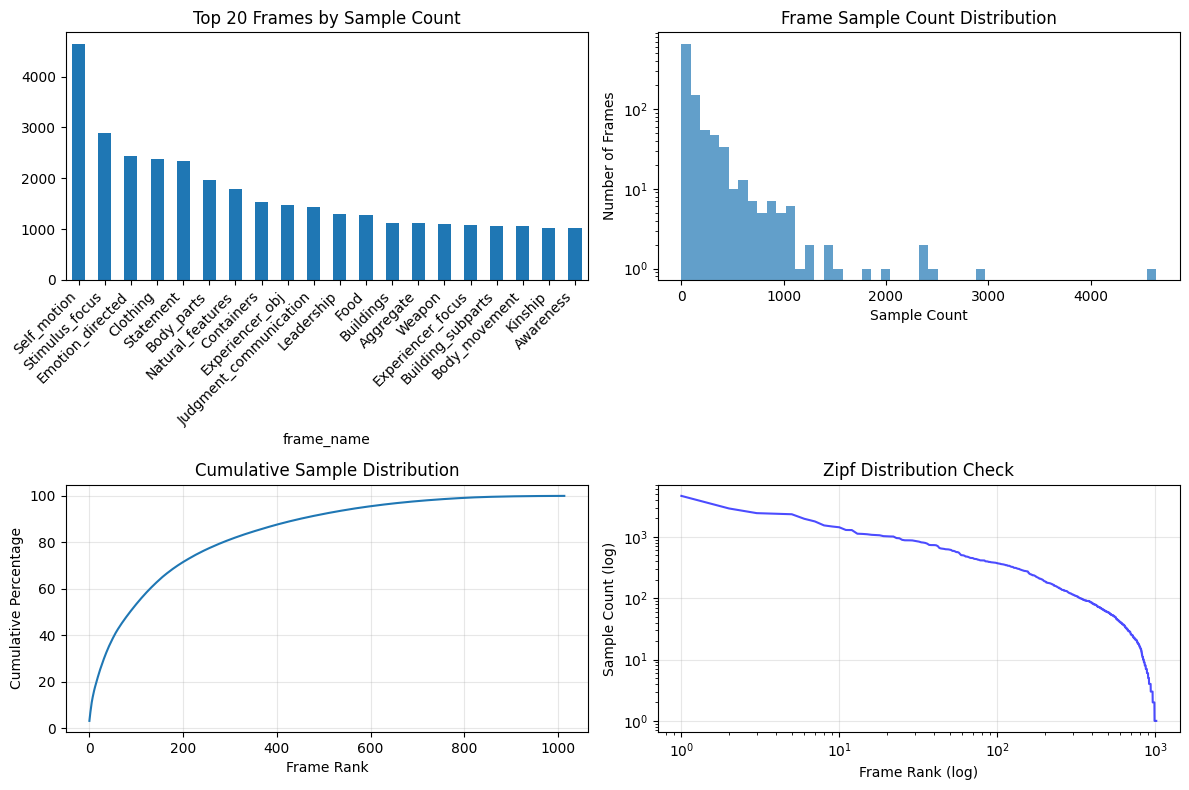


üìù 3. Âè•Â≠êË¥®ÈáèÂàÜÊûê
--------------------------------------------------
Âè•Â≠êÈïøÂ∫¶ÁªüËÆ°:
  Âπ≥ÂùáÈïøÂ∫¶: 24.1 words
  ‰∏≠‰ΩçÊï∞ÈïøÂ∫¶: 23.0 words
  ÊúÄÁü≠Âè•Â≠ê: 1 words
  ÊúÄÈïøÂè•Â≠ê: 250 words
  Ê†áÂáÜÂ∑Æ: 11.3

Âè•Â≠êÈïøÂ∫¶ÂàÜÂ∏É:
  1-5 words: 963 (0.6%)
  6-10 words: 10,917 (7.3%)
  11-20 words: 48,586 (32.4%)
  21-30 words: 52,746 (35.1%)
  31-50 words: 33,700 (22.4%)
  51+ words: 3,219 (2.1%)

ÂºÇÂ∏∏Âè•Â≠êÊ£ÄÊµã:
  ËøáÁü≠Âè•Â≠ê(<=3 words): 73 (0.05%)
    Á§∫‰æã: Real people !
  ËøáÈïøÂè•Â≠ê(>=50 words): 3455 (2.30%)
    Á§∫‰æã: Noting that the Indonesian military is `` very suspicious '' about Australia 's motivation in East T...
  ÂåÖÂê´ÁâπÊÆäÂ≠óÁ¨¶: 9798 (6.53%)
  ÈáçÂ§çÂè•Â≠ê: 28209 (18.79%)

üéØ 4. Target spanÂàÜÊûê
--------------------------------------------------
Target spanÁªüËÆ°:
  ÊÄªtargetÊï∞: 154,174
  Âπ≥ÂùáÂ≠óÁ¨¶ÈïøÂ∫¶: 5.8
  Âπ≥ÂùáËØçÊï∞: 1.0
  ÊúÄÈïøtarget: 18 chars
  ÊúÄÁü≠target: 0 chars

TargetËØçÊï∞ÂàÜÂ∏É:
  0 word(s): 85 (0.1%)
  1 word(s): 154,07

In [ ]:
# @title ‚úÖFrameNetÊï∞ÊçÆÈõÜÂÖ®Èù¢ÂàÜÊûê

def comprehensive_data_analysis(train_df, val_df, test_df):
    """FrameNetÊï∞ÊçÆÈõÜÂÖ®Èù¢ÂàÜÊûê"""

    print("üîç FrameNet Êï∞ÊçÆÈõÜÂÖ®Èù¢ÂàÜÊûê")
    print("="*80)

    # 1. Âü∫Á°ÄÁªüËÆ°
    basic_statistics(train_df, val_df, test_df)

    # 2. FrameÂàÜÂ∏ÉÂàÜÊûê
    frame_distribution_analysis(train_df)

    # 3. Âè•Â≠êË¥®ÈáèÂàÜÊûê
    sentence_quality_analysis(train_df)

    # 4. Target spanÂàÜÊûê
    target_span_analysis(train_df)

    # 5. FrameËØ≠‰πâÁõ∏‰ººÊÄßÂàÜÊûê
    frame_similarity_analysis(train_df)

    # 6. Êï∞ÊçÆË¥®ÈáèÈóÆÈ¢òÊ£ÄÊµã
    data_quality_issues(train_df)

    # 7. ËÆ≠ÁªÉÈöæÂ∫¶ÂàÜÊûê
    training_difficulty_analysis(train_df)

    print("\n‚úÖ Êï∞ÊçÆÂàÜÊûêÂÆåÊàêÔºÅ")

def basic_statistics(train_df, val_df, test_df):
    """1. Âü∫Á°ÄÁªüËÆ°‰ø°ÊÅØ"""
    print("\nüìä 1. Âü∫Á°ÄÁªüËÆ°‰ø°ÊÅØ")
    print("-" * 50)

    datasets = {'Train': train_df, 'Val': val_df, 'Test': test_df}

    for name, df in datasets.items():
        print(f"\n{name} Set:")
        print(f"  ÊÄªÊ†∑Êú¨Êï∞: {len(df):,}")
        print(f"  uniqueÂè•Â≠êÊï∞: {df['sentence'].nunique():,}")
        print(f"  unique framesÊï∞: {df['frame_name'].nunique():,}")
        print(f"  Âπ≥ÂùáÊØèÂè•targets: {len(df) / df['sentence'].nunique():.2f}")

def frame_distribution_analysis(train_df):
    """2. FrameÂàÜÂ∏ÉÂàÜÊûê"""
    print("\nüìà 2. FrameÂàÜÂ∏ÉÂàÜÊûê")
    print("-" * 50)

    frame_counts = train_df['frame_name'].value_counts()

    # Âü∫Á°ÄÂàÜÂ∏ÉÁªüËÆ°
    print(f"FrameÊï∞ÈáèÂàÜÂ∏É:")
    print(f"  ÊÄªframeÊï∞: {len(frame_counts)}")
    print(f"  ÊúÄÂ§ßÊ†∑Êú¨Êï∞: {frame_counts.iloc[0]:,} (frame: {frame_counts.index[0]})")
    print(f"  ÊúÄÂ∞èÊ†∑Êú¨Êï∞: {frame_counts.iloc[-1]:,} (frame: {frame_counts.index[-1]})")
    print(f"  ‰∏≠‰ΩçÊï∞Ê†∑Êú¨Êï∞: {frame_counts.median():.1f}")
    print(f"  Âπ≥ÂùáÊ†∑Êú¨Êï∞: {frame_counts.mean():.1f}")

    # Ê†∑Êú¨Êï∞Âå∫Èó¥ÂàÜÂ∏É
    print(f"\nÊ†∑Êú¨Êï∞Âå∫Èó¥ÂàÜÂ∏É:")
    ranges = [(1, 5), (6, 10), (11, 20), (21, 50), (51, 100), (101, float('inf'))]
    for low, high in ranges:
        if high == float('inf'):
            count = (frame_counts >= low).sum()
            print(f"  {low}+ Ê†∑Êú¨: {count} frames ({count/len(frame_counts)*100:.1f}%)")
        else:
            count = ((frame_counts >= low) & (frame_counts <= high)).sum()
            print(f"  {low}-{high} Ê†∑Êú¨: {count} frames ({count/len(frame_counts)*100:.1f}%)")

    # ÈïøÂ∞æÂàÜÂ∏ÉÂèØËßÜÂåñ
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    frame_counts.head(20).plot(kind='bar')
    plt.title('Top 20 Frames by Sample Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    plt.subplot(2, 2, 2)
    plt.hist(frame_counts.values, bins=50, alpha=0.7)
    plt.title('Frame Sample Count Distribution')
    plt.xlabel('Sample Count')
    plt.ylabel('Number of Frames')
    plt.yscale('log')

    plt.subplot(2, 2, 3)
    # Á¥ØÁßØÂàÜÂ∏É
    sorted_counts = frame_counts.sort_values(ascending=False)
    cumsum = sorted_counts.cumsum()
    plt.plot(range(len(cumsum)), cumsum / cumsum.iloc[-1] * 100)
    plt.title('Cumulative Sample Distribution')
    plt.xlabel('Frame Rank')
    plt.ylabel('Cumulative Percentage')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 4)
    # ZipfÂàÜÂ∏ÉÊ£ÄÈ™å
    ranks = np.arange(1, len(frame_counts) + 1)
    plt.loglog(ranks, frame_counts.values, 'b-', alpha=0.7)
    plt.title('Zipf Distribution Check')
    plt.xlabel('Frame Rank (log)')
    plt.ylabel('Sample Count (log)')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return frame_counts

def sentence_quality_analysis(train_df):
    """3. Âè•Â≠êË¥®ÈáèÂàÜÊûê"""
    print("\nüìù 3. Âè•Â≠êË¥®ÈáèÂàÜÊûê")
    print("-" * 50)

    # Âè•Â≠êÈïøÂ∫¶ÂàÜÊûê
    sentence_lengths = train_df['sentence'].apply(lambda x: len(x.split()))

    print(f"Âè•Â≠êÈïøÂ∫¶ÁªüËÆ°:")
    print(f"  Âπ≥ÂùáÈïøÂ∫¶: {sentence_lengths.mean():.1f} words")
    print(f"  ‰∏≠‰ΩçÊï∞ÈïøÂ∫¶: {sentence_lengths.median():.1f} words")
    print(f"  ÊúÄÁü≠Âè•Â≠ê: {sentence_lengths.min()} words")
    print(f"  ÊúÄÈïøÂè•Â≠ê: {sentence_lengths.max()} words")
    print(f"  Ê†áÂáÜÂ∑Æ: {sentence_lengths.std():.1f}")

    # ÈïøÂ∫¶ÂàÜÂ∏É
    print(f"\nÂè•Â≠êÈïøÂ∫¶ÂàÜÂ∏É:")
    length_ranges = [(1, 5), (6, 10), (11, 20), (21, 30), (31, 50), (51, float('inf'))]
    for low, high in length_ranges:
        if high == float('inf'):
            count = (sentence_lengths >= low).sum()
            print(f"  {low}+ words: {count:,} ({count/len(sentence_lengths)*100:.1f}%)")
        else:
            count = ((sentence_lengths >= low) & (sentence_lengths <= high)).sum()
            print(f"  {low}-{high} words: {count:,} ({count/len(sentence_lengths)*100:.1f}%)")

    # ÂºÇÂ∏∏Âè•Â≠êÊ£ÄÊµã
    print(f"\nÂºÇÂ∏∏Âè•Â≠êÊ£ÄÊµã:")
    # ËøáÁü≠Âè•Â≠ê
    very_short = train_df[sentence_lengths <= 3]
    print(f"  ËøáÁü≠Âè•Â≠ê(<=3 words): {len(very_short)} ({len(very_short)/len(train_df)*100:.2f}%)")
    if len(very_short) > 0:
        print(f"    Á§∫‰æã: {very_short['sentence'].iloc[0]}")

    # ËøáÈïøÂè•Â≠ê
    very_long = train_df[sentence_lengths >= 50]
    print(f"  ËøáÈïøÂè•Â≠ê(>=50 words): {len(very_long)} ({len(very_long)/len(train_df)*100:.2f}%)")
    if len(very_long) > 0:
        print(f"    Á§∫‰æã: {very_long['sentence'].iloc[0][:100]}...")

    # ÁâπÊÆäÂ≠óÁ¨¶Ê£ÄÊµã
    special_chars = train_df['sentence'].str.contains(r'[<>{}[\]()_*#@$%^&]', regex=True)
    print(f"  ÂåÖÂê´ÁâπÊÆäÂ≠óÁ¨¶: {special_chars.sum()} ({special_chars.sum()/len(train_df)*100:.2f}%)")

    # ÈáçÂ§çÂè•Â≠ê
    duplicate_sentences = train_df['sentence'].duplicated().sum()
    print(f"  ÈáçÂ§çÂè•Â≠ê: {duplicate_sentences} ({duplicate_sentences/len(train_df)*100:.2f}%)")

    return sentence_lengths

def target_span_analysis(train_df):
    """4. Target spanÂàÜÊûê"""
    print("\nüéØ 4. Target spanÂàÜÊûê")
    print("-" * 50)

    # ÊèêÂèñtarget span‰ø°ÊÅØ
    target_info = []
    for _, row in train_df.iterrows():
        sentence = row['sentence']
        for span in row['target_spans']:
            start, end = span
            target_text = sentence[start:end]
            target_info.append({
                'text': target_text,
                'length': end - start,
                'char_length': len(target_text),
                'word_count': len(target_text.split()),
                'frame': row['frame_name']
            })

    target_df = pd.DataFrame(target_info)

    print(f"Target spanÁªüËÆ°:")
    print(f"  ÊÄªtargetÊï∞: {len(target_df):,}")
    print(f"  Âπ≥ÂùáÂ≠óÁ¨¶ÈïøÂ∫¶: {target_df['char_length'].mean():.1f}")
    print(f"  Âπ≥ÂùáËØçÊï∞: {target_df['word_count'].mean():.1f}")
    print(f"  ÊúÄÈïøtarget: {target_df['char_length'].max()} chars")
    print(f"  ÊúÄÁü≠target: {target_df['char_length'].min()} chars")

    # TargetÈïøÂ∫¶ÂàÜÂ∏É
    print(f"\nTargetËØçÊï∞ÂàÜÂ∏É:")
    word_counts = target_df['word_count'].value_counts().sort_index()
    for words, count in word_counts.head(10).items():
        print(f"  {words} word(s): {count:,} ({count/len(target_df)*100:.1f}%)")

    # Â∏∏ËßÅtargetËØç
    print(f"\nÊúÄÂ∏∏ËßÅtargetËØç:")
    target_words = target_df['text'].value_counts()
    for word, count in target_words.head(10).items():
        print(f"  '{word}': {count} Ê¨°")

    # ÂºÇÂ∏∏targetÊ£ÄÊµã
    print(f"\nÂºÇÂ∏∏targetÊ£ÄÊµã:")
    empty_targets = target_df[target_df['char_length'] == 0]
    print(f"  Á©∫target: {len(empty_targets)}")

    very_long_targets = target_df[target_df['word_count'] >= 5]
    print(f"  ËøáÈïøtarget(>=5 words): {len(very_long_targets)} ({len(very_long_targets)/len(target_df)*100:.2f}%)")

    return target_df

def frame_similarity_analysis(train_df):
    """5. FrameËØ≠‰πâÁõ∏‰ººÊÄßÂàÜÊûê"""
    print("\nüîó 5. FrameËØ≠‰πâÁõ∏‰ººÊÄßÂàÜÊûê")
    print("-" * 50)

    # ‰∏∫ÊØè‰∏™frameÊî∂ÈõÜtargetËØçÊ±á
    frame_targets = defaultdict(list)
    for _, row in train_df.iterrows():
        frame = row['frame_name']
        sentence = row['sentence']
        for span in row['target_spans']:
            start, end = span
            target = sentence[start:end].lower().strip()
            if target:  # ÈùûÁ©∫target
                frame_targets[frame].append(target)

    # ËÆ°ÁÆóframeÈó¥ÁöÑËØçÊ±áÈáçÂè†
    print(f"FrameËØ≠‰πâÁõ∏‰ººÊÄßÂàÜÊûê:")
    frame_names = list(frame_targets.keys())

    # ÊâæÂá∫ÂÖ±‰∫´ËØçÊ±áÊúÄÂ§öÁöÑframe pairs
    overlap_scores = []
    for i, frame1 in enumerate(frame_names):
        for j, frame2 in enumerate(frame_names[i+1:], i+1):
            targets1 = set(frame_targets[frame1])
            targets2 = set(frame_targets[frame2])

            intersection = len(targets1 & targets2)
            union = len(targets1 | targets2)

            if union > 0:
                jaccard = intersection / union
                overlap_scores.append((frame1, frame2, intersection, jaccard))

    # ÊéíÂ∫èÂπ∂ÊòæÁ§∫ÊúÄÁõ∏‰ººÁöÑframe pairs
    overlap_scores.sort(key=lambda x: x[3], reverse=True)

    print(f"\nÊúÄÁõ∏‰ººÁöÑFrame pairs (ÊåâJaccardÁõ∏‰ººÂ∫¶):")
    for frame1, frame2, common, jaccard in overlap_scores[:10]:
        print(f"  {frame1} <-> {frame2}: {common} ÂÖ±ÂêåËØçÊ±á, Jaccard={jaccard:.3f}")

    # ÂàÜÊûêÂèØËÉΩÁöÑÊ∑∑Ê∑Üframe
    print(f"\nÊΩúÂú®Ê∑∑Ê∑ÜFrame pairs (Jaccard > 0.3):")
    confusing_pairs = [(f1, f2, score) for f1, f2, _, score in overlap_scores if score > 0.3]
    print(f"  ÂèëÁé∞ {len(confusing_pairs)} ÂØπÊΩúÂú®Ê∑∑Ê∑Üframes")

    return overlap_scores, frame_targets

def data_quality_issues(train_df):
    """6. Êï∞ÊçÆË¥®ÈáèÈóÆÈ¢òÊ£ÄÊµã"""
    print("\n‚ö†Ô∏è 6. Êï∞ÊçÆË¥®ÈáèÈóÆÈ¢òÊ£ÄÊµã")
    print("-" * 50)

    issues = []

    # 1. Target spanËæπÁïåÈóÆÈ¢ò
    boundary_issues = 0
    for idx, row in train_df.iterrows():
        sentence = row['sentence']
        for span in row['target_spans']:
            start, end = span
            if start < 0 or end > len(sentence) or start >= end:
                boundary_issues += 1
                issues.append(f"Row {idx}: Invalid span ({start}, {end}) for sentence length {len(sentence)}")

    print(f"Target spanËæπÁïåÈóÆÈ¢ò: {boundary_issues}")

    # 2. ‰∏ç‰∏ÄËá¥ÁöÑÊ†áÊ≥®
    sentence_frame_map = defaultdict(set)
    for _, row in train_df.iterrows():
        sentence = row['sentence']
        frame = row['frame_name']
        sentence_frame_map[sentence].add(frame)

    inconsistent_sentences = {s: frames for s, frames in sentence_frame_map.items() if len(frames) > 1}
    print(f"Ê†áÊ≥®‰∏ç‰∏ÄËá¥ÁöÑÂè•Â≠ê: {len(inconsistent_sentences)}")

    # 3. Á©∫ÁôΩ/ÂºÇÂ∏∏Â≠óÁ¨¶
    empty_sentences = train_df[train_df['sentence'].str.strip() == '']
    print(f"Á©∫Âè•Â≠ê: {len(empty_sentences)}")

    # 4. Frame nameÈóÆÈ¢ò
    frame_name_issues = train_df[train_df['frame_name'].str.contains(r'[^a-zA-Z0-9_]', regex=True, na=False)]
    print(f"FrameÂêçÁß∞ÂåÖÂê´ÁâπÊÆäÂ≠óÁ¨¶: {len(frame_name_issues)}")

    return issues

def training_difficulty_analysis(train_df):
    """7. ËÆ≠ÁªÉÈöæÂ∫¶ÂàÜÊûê"""
    print("\nüìà 7. ËÆ≠ÁªÉÈöæÂ∫¶ÂàÜÊûê")
    print("-" * 50)

    frame_counts = train_df['frame_name'].value_counts()

    # ÊåâÊ†∑Êú¨Êï∞ÈáèÂàÜÁ±ªframeÈöæÂ∫¶
    difficulty_levels = {
        'Very Hard': frame_counts[frame_counts <= 5],
        'Hard': frame_counts[(frame_counts > 5) & (frame_counts <= 15)],
        'Medium': frame_counts[(frame_counts > 15) & (frame_counts <= 50)],
        'Easy': frame_counts[frame_counts > 50]
    }

    print(f"FrameËÆ≠ÁªÉÈöæÂ∫¶ÂàÜÂ∏É:")
    total_frames = len(frame_counts)
    for difficulty, frames in difficulty_levels.items():
        count = len(frames)
        percentage = count / total_frames * 100
        sample_count = frames.sum() if len(frames) > 0 else 0
        print(f"  {difficulty}: {count} frames ({percentage:.1f}%), {sample_count:,} samples")

    # Êé®ËçêÁöÑËÆ≠ÁªÉÁ≠ñÁï•
    print(f"\nüéØ Êé®ËçêËÆ≠ÁªÉÁ≠ñÁï•:")
    very_hard_count = len(difficulty_levels['Very Hard'])
    if very_hard_count > 0:
        print(f"  1. {very_hard_count} ‰∏™Very Hard framesÈúÄË¶ÅÊï∞ÊçÆÂ¢ûÂº∫")

    hard_count = len(difficulty_levels['Hard'])
    if hard_count > 0:
        print(f"  2. {hard_count} ‰∏™Hard framesÈúÄË¶ÅÁâπÊÆäÂÖ≥Ê≥®ÂíåÂõ∞ÈöæË¥ü‰æã")

    easy_count = len(difficulty_levels['Easy'])
    if easy_count > 0:
        print(f"  3. {easy_count} ‰∏™Easy framesÂèØ‰ª•Â≠êÈááÊ†∑‰ª•Âπ≥Ë°°Êï∞ÊçÆ")

    return difficulty_levels

# ‰ΩøÁî®Á§∫‰æã
if __name__ == "__main__":

    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    val_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/val_df.pkl")
    test_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")


    comprehensive_data_analysis(train_df, val_df, test_df)
    pass

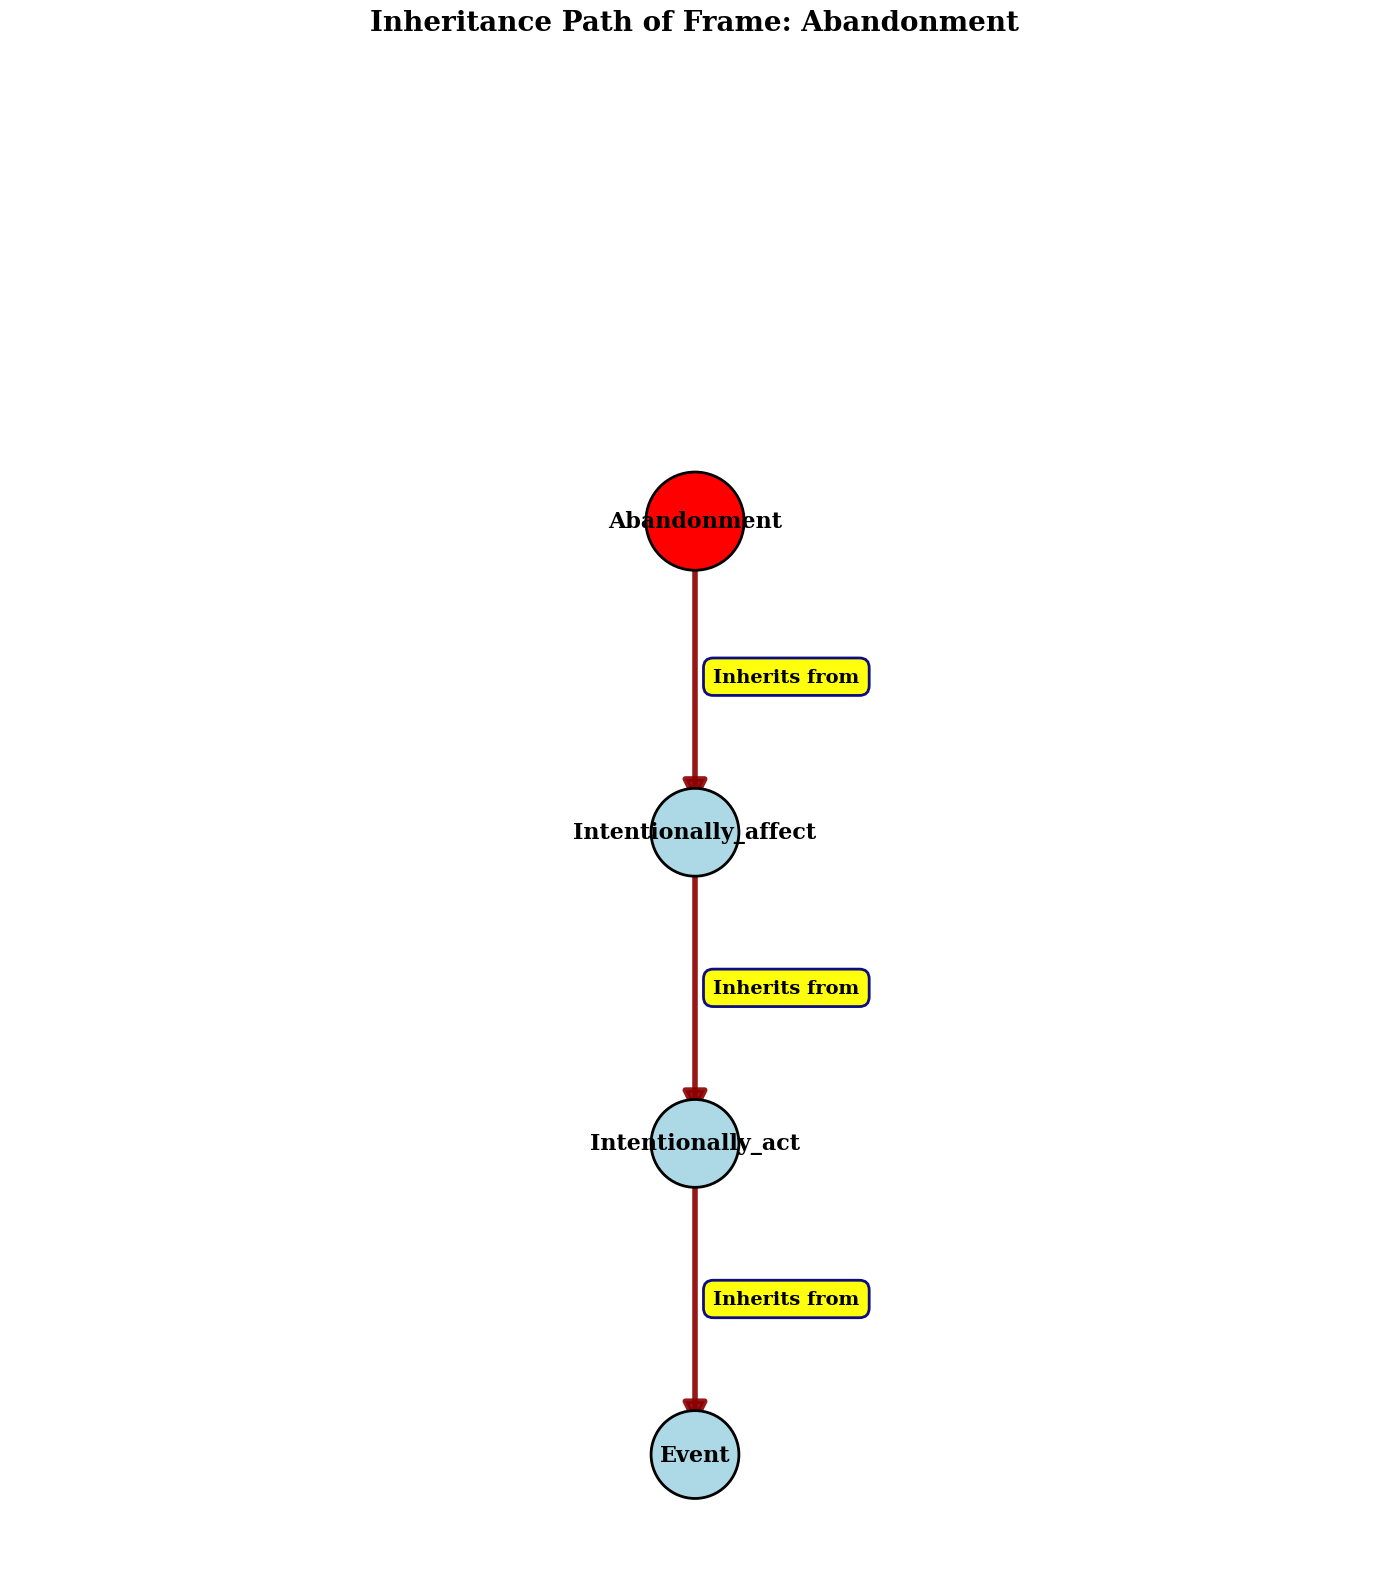

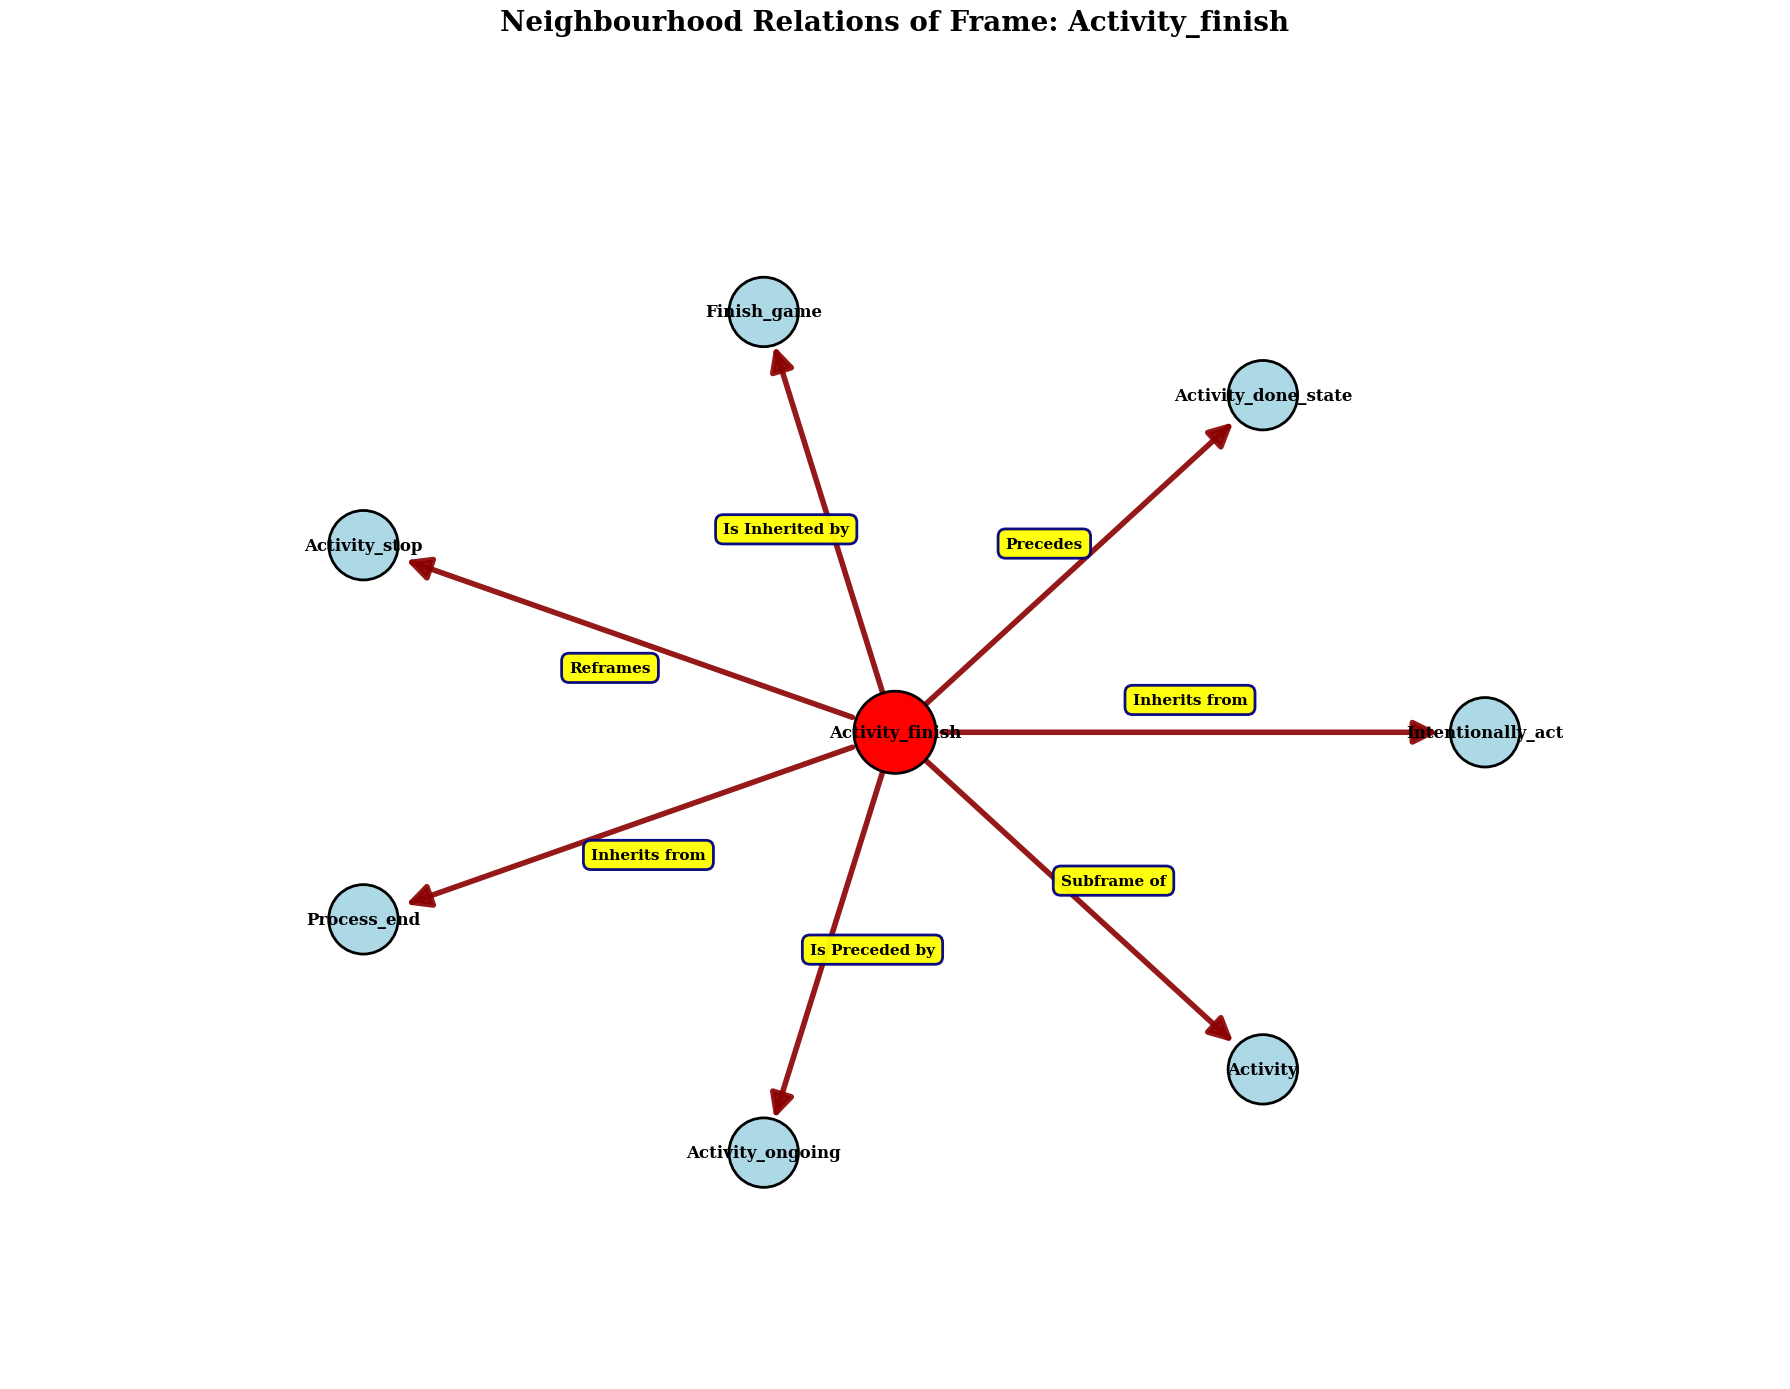

In [ ]:
# @title üîç Visualise FrameNet Data Structures

# Set font for better appearance (Colab compatible)
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.size'] = 10

def visualize_frame_structure(frame_relations, target_frame, mode="neighbourhood", layout='spring', title=None, save_path=None):
    """
    Visualize frame semantic structure using extracted FrameNet data.
    """

    if target_frame not in frame_relations:
        print(f"[ERROR] Frame not found: {target_frame}")
        return

    if mode == "upward":
        if not title:
            title = f"Inheritance Path of Frame: {target_frame}"

        # Find inheritance path by following inheritance relations
        path = [target_frame]
        current = target_frame
        visited = {current}

        while True:
            parent_found = False
            relations = frame_relations.get(current, [])

            for neighbor, rel_type, direction, edge_label in relations:
                if neighbor in visited:
                    continue
                # Look for inheritance where current frame inherits from neighbor
                if rel_type == "Inheritance" and direction == "in":
                    path.insert(0, neighbor)  # Add parent at beginning
                    current = neighbor
                    visited.add(current)
                    parent_found = True
                    break

            if not parent_found:
                break

        # Create inheritance subgraph
        subgraph = nx.DiGraph()
        if len(path) == 1:
            subgraph.add_node(target_frame)
            print(f"[INFO] No inheritance path found for {target_frame}")
        else:
            for i in range(len(path) - 1):
                parent = path[i]
                child = path[i + 1]
                # Arrow from child to parent: child -> parent "Inherits from"
                subgraph.add_edge(child, parent, relation="Inherits from")

    elif mode == "neighbourhood":
        if not title:
            title = f"Neighbourhood Relations of Frame: {target_frame}"

        # Get all relations for the target frame
        relations = frame_relations.get(target_frame, [])

        # Collect all neighbor frames
        neighbors = set()
        for neighbor, rel_type, direction, edge_label in relations:
            neighbors.add(neighbor)

        # Create subgraph with all arrows FROM target frame
        subgraph = nx.DiGraph()
        subgraph.add_node(target_frame)
        subgraph.add_nodes_from(neighbors)

        # Add edges with labels from RELATION_LABELS
        for neighbor, rel_type, direction, edge_label in relations:
            # Get the appropriate label based on direction
            if rel_type in RELATION_LABELS:
                label_out, label_in = RELATION_LABELS[rel_type]
                if direction == "out":
                    label = label_out  # target gives the relation
                else:  # direction == "in"
                    label = label_in   # target receives the relation
            else:
                label = f"{rel_type} ({direction})"

            # All arrows point FROM target_frame TO neighbors
            subgraph.add_edge(target_frame, neighbor, relation=label)

    else:
        raise ValueError("mode must be 'neighbourhood' or 'upward'")

    if len(subgraph.nodes()) == 0:
        print(f"[ERROR] No nodes found for visualization")
        return

    # Layout calculation
    num_nodes = len(subgraph.nodes())

    if num_nodes == 1:
        pos = {list(subgraph.nodes())[0]: (0, 0)}
    elif mode == "upward":
        # Vertical hierarchical layout for inheritance
        nodes = list(subgraph.nodes())
        if subgraph.edges():
            try:
                ordered_nodes = list(nx.topological_sort(subgraph))
                pos = {}
                level_height = 5.0  # Large spacing
                for i, node in enumerate(ordered_nodes):
                    pos[node] = (0, (len(ordered_nodes) - i - 1) * level_height)
            except:
                pos = {node: (0, i * 5.0) for i, node in enumerate(reversed(nodes))}
        else:
            pos = {nodes[0]: (0, 0)}
    else:
        # Radial layout for neighbourhood - target in center
        pos = {}
        other_nodes = [n for n in subgraph.nodes() if n != target_frame]
        pos[target_frame] = (0, 0)

        if other_nodes:
            angle_step = 2 * np.pi / len(other_nodes)
            radius = 4.0
            for i, node in enumerate(other_nodes):
                angle = i * angle_step
                pos[node] = (radius * np.cos(angle), radius * np.sin(angle))

    # Create figure with large size
    if mode == "upward":
        fig_height = max(16, len(subgraph.nodes()) * 4)
        fig, ax = plt.subplots(1, 1, figsize=(14, fig_height))
    else:
        fig, ax = plt.subplots(1, 1, figsize=(18, 14))

    # Draw nodes
    node_colors = ["red" if n == target_frame else "lightblue" for n in subgraph.nodes()]
    if mode == "upward":
        node_sizes = [5000 if n == target_frame else 4000 for n in subgraph.nodes()]
    else:
        node_sizes = [3500 if n == target_frame else 2500 for n in subgraph.nodes()]

    nx.draw_networkx_nodes(subgraph, pos,
                          node_size=node_sizes,
                          node_color=node_colors,
                          edgecolors='black',
                          linewidths=2,
                          ax=ax)

    # Draw node labels
    label_font_size = 16 if mode == "upward" else 12
    nx.draw_networkx_labels(subgraph, pos,
                           font_size=label_font_size,
                           font_weight="bold",
                           font_family='DejaVu Serif',
                           ax=ax)

    # Draw edges with relation labels
    for u, v, data in subgraph.edges(data=True):
        x1, y1 = pos[u]
        x2, y2 = pos[v]

        # Calculate direction
        dx = x2 - x1
        dy = y2 - y1
        length = np.sqrt(dx**2 + dy**2)

        if length > 0:
            dx_norm = dx / length
            dy_norm = dy / length

            # Adjust arrow positions to avoid node overlap
            node_radius = 0.4 if mode == "upward" else 0.3
            start_x = x1 + dx_norm * node_radius
            start_y = y1 + dy_norm * node_radius
            end_x = x2 - dx_norm * node_radius
            end_y = y2 - dy_norm * node_radius

            # Draw thick, prominent arrow
            arrow = FancyArrowPatch((start_x, start_y), (end_x, end_y),
                                   arrowstyle='-|>',
                                   mutation_scale=35,
                                   color='darkred',
                                   linewidth=4,
                                   alpha=0.9)
            ax.add_patch(arrow)

            # Add relation label
            relation = data.get("relation", "")
            if relation:
                # Position label at edge midpoint
                label_x = (start_x + end_x) / 2
                label_y = (start_y + end_y) / 2

                # Offset label perpendicular to edge for readability
                perp_offset = 0.4 if mode == "upward" else 0.3
                perp_x = -dy_norm * perp_offset
                perp_y = dx_norm * perp_offset

                label_font_size = 14 if mode == "upward" else 11
                ax.text(label_x + perp_x, label_y + perp_y, relation,
                       fontsize=label_font_size,
                       ha='center',
                       va='center',
                       weight='bold',
                       family='DejaVu Serif',
                       bbox=dict(boxstyle="round,pad=0.5",
                               facecolor="yellow",
                               alpha=0.95,
                               edgecolor="navy",
                               linewidth=2))

    ax.set_title(title, fontsize=20, fontweight='bold', family='DejaVu Serif', pad=40)
    ax.axis("off")

    # Set axis limits to ensure everything is visible
    if mode == "upward":
        ax.set_xlim(-3, 3)
        ax.set_ylim(-2, len(subgraph.nodes()) * 5 + 2)
    else:
        ax.set_xlim(-6, 6)
        ax.set_ylim(-6, 6)

    plt.tight_layout()
    if save_path:
         plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()


visualize_frame_structure(frame_relations, "Abandonment", mode="upward", save_path="abandonment_inheritance.png")
visualize_frame_structure(frame_relations, "Activity_finish", mode="neighbourhood", save_path="activity_finish_neighbourhood.png")

In [ ]:
# @title ÂÆö‰πâÊñá‰ª∂ÊèêÂèñ

# === 1. ‰øÆÂ§çÁâàÔºöÊèêÂèñÁ∫ØÂÆö‰πâÊñáÊú¨ÔºåÂøΩÁï• <ex> ‰æãÂè• ===
def extract_pure_definition_from_markup(def_markup: str) -> str:
    try:
        def_markup = def_markup.strip()
        root = ET.fromstring(def_markup)

        parts = []
        if root.text and root.text.strip():
            parts.append(root.text.strip())

        for elem in root:
            if elem.tag == "ex":
                continue
            if elem.text and elem.text.strip():
                parts.append(elem.text.strip())
            if elem.tail and elem.tail.strip():
                parts.append(elem.tail.strip())

        return ' '.join(parts).strip()

    except ET.ParseError:
        return "[ParseError]"

# === 2. ‰ΩøÁî® [CLS] ÂêëÈáèÁºñÁ†ÅÂÆö‰πâÊñáÊú¨ÔºàDistilBERTÁâàÔºâ ===
def encode_frame_definition(definition, tokenizer, model, device):
    inputs = tokenizer(
        definition,
        return_tensors='pt',
        truncation=True,
        max_length=128,
        padding='max_length'
    ).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        last_hidden = outputs.last_hidden_state  # [B, T, H]
        cls_embedding = last_hidden[:, 0, :]     # Âèñ [CLS]
        return cls_embedding.squeeze(0).cpu()

# === 3. ‰∏ªÂáΩÊï∞ÔºöÁºñÁ†ÅÊâÄÊúâÂÆö‰πâ + ‰øùÂ≠ò ===
def encode_all_framenet_definitions(tokenizer, model, save_path, device):
    import pickle
    frame_definition_embeddings = {}
    skipped = []

    for frame in tqdm(fn.frames(), desc="Encoding FrameNet definitions"):
        name = frame["name"]
        raw_markup = ''.join(frame.get("definitionMarkup", []))
        definition = extract_pure_definition_from_markup(raw_markup)

        if definition == "[ParseError]" or not definition:
            skipped.append(name)
            continue

        try:
            emb = encode_frame_definition(definition, tokenizer, model, device)
            frame_definition_embeddings[name] = {
                "definition": definition,
                "embedding": emb.tolist()
            }
        except Exception as e:
            skipped.append(name)

    with open(save_path, "wb") as f:
        pickle.dump(frame_definition_embeddings, f)

    print(f"\nüì¶ ÊàêÂäü‰øùÂ≠ò {len(frame_definition_embeddings)} Êù°ÂÆö‰πâÂµåÂÖ•ÔºåË∑≥Ëøá {len(skipped)} Êù°ÈîôËØØÂÆö‰πâ„ÄÇ")
    return frame_definition_embeddings, skipped

# === 4. ‰ΩøÁî® distilbert-base-uncased ÁºñÁ†ÅÂô® ===


definition_model_name = "distilbert-base-uncased"
definition_tokenizer = AutoTokenizer.from_pretrained(definition_model_name)
definition_model = AutoModel.from_pretrained(definition_model_name).to(device)

# === 5. ÊâßË°åÂπ∂‰øùÂ≠ò ===
save_path = "/content/drive/MyDrive/more50/framenet_data/train_df_distilbert_balanced.pkl"
frame_definition_embeddings, skipped = encode_all_framenet_definitions(
    definition_tokenizer, definition_model, save_path, device
)

# === 6. ÊâìÂç∞ÂâçÂá†‰∏™ÁªìÊûúÊ£ÄÊü• ===
for i, (name, info) in enumerate(frame_definition_embeddings.items()):
    print(f"\n‚úÖ Frame {i+1}: {name}")
    print("üìù Definition:", info["definition"])
    print("üî¢ Embedding[:5]:", info["embedding"][:5])
    if i >= 4:
        break


Encoding FrameNet definitions: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1221/1221 [00:06<00:00, 192.41it/s]



üì¶ ÊàêÂäü‰øùÂ≠ò 1221 Êù°ÂÆö‰πâÂµåÂÖ•ÔºåË∑≥Ëøá 0 Êù°ÈîôËØØÂÆö‰πâ„ÄÇ

‚úÖ Frame 1: Abandonment
üìù Definition: An Agent leaves behind a Theme effectively rendering it no longer within their control or of the normal security as one's property.
üî¢ Embedding[:5]: [-0.19139738380908966, -0.02490539290010929, -0.1134403645992279, -0.05611336603760719, 0.018953654915094376]

‚úÖ Frame 2: Abounding_with
üìù Definition: A Location is filled or covered with the Theme .  The Location is realized as the External Argument, and the Theme either as PP complement headed by with , in or of .

NB:  This frame does not include uses of adjectives like paved when they merely specify the Type of some location, as in "paved and unpaved roads".
üî¢ Embedding[:5]: [-0.3714313209056854, 0.04469132795929909, -0.04548976570367813, -0.21898649632930756, -0.3817424774169922]

‚úÖ Frame 3: Absorb_heat
üìù Definition: An Entity (generally food) is exposed to a Heat_source whose Temperature may also be specifi

In [ ]:
# @title ÂÆö‰πâÊñá‰ª∂‰øùÂ≠ò
import pickle
save_path = "/content/drive/MyDrive/more50/framenet_data/framenet_definition_embeddings_distilbert_cls.pkl"

with open(save_path, "wb") as f:
    pickle.dump(frame_definition_embeddings, f)

print(f"‚úÖ Â∑≤‰øùÂ≠òÂÆö‰πâÂµåÂÖ•Âà∞: {save_path}")


‚úÖ Â∑≤‰øùÂ≠òÂÆö‰πâÂµåÂÖ•Âà∞: /content/drive/MyDrive/more50/framenet_data/framenet_definition_embeddings_distilbert_cls.pkl


üìä Cosine similarity stats (excluding self-match):
   Mean: 0.8911
   Std: 0.0338
   Min: 0.6452
   Max: 0.9988


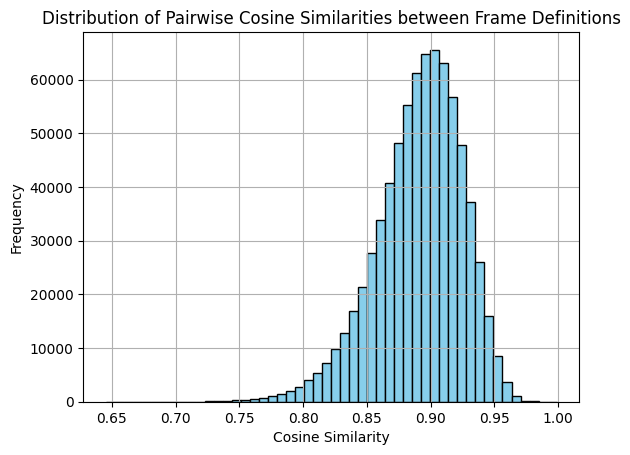

In [ ]:
# @title ÂÆö‰πâÁõ∏‰ººÂ∫¶

import pickle
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# === 1. Âä†ËΩΩÂÆö‰πâÂµåÂÖ• ===
with open("/content/drive/MyDrive/more50/framenet_data/train_df_distilbert_balanced.pkl", "rb") as f:
    frame_def_embeddings = pickle.load(f)

# === 2. ÊèêÂèñÊâÄÊúâÂêëÈáè‰∏éÂêçÁß∞ ===
frame_names = list(frame_def_embeddings.keys())
embeddings = np.array([frame_def_embeddings[f]["embedding"] for f in frame_names])  # shape: [N, D]

# === 3. ËÆ°ÁÆó‰ΩôÂº¶Áõ∏‰ººÂ∫¶Áü©Èòµ ===
sim_matrix = cosine_similarity(embeddings)  # shape: [N, N]

# === 4. ÊèêÂèñÈùûÂØπËßíÂÖÉÁ¥†ÔºàÂç≥ÈùûËá™Ë∫´ÂåπÈÖçÔºâ ===
all_sims = sim_matrix[np.triu_indices(len(frame_names), k=1)]

# === 5. ÊâìÂç∞ÁªüËÆ°‰ø°ÊÅØ ===
mean_sim = np.mean(all_sims)
std_sim = np.std(all_sims)
min_sim = np.min(all_sims)
max_sim = np.max(all_sims)

print(f"üìä Cosine similarity stats (excluding self-match):")
print(f"   Mean: {mean_sim:.4f}")
print(f"   Std: {std_sim:.4f}")
print(f"   Min: {min_sim:.4f}")
print(f"   Max: {max_sim:.4f}")

# === 6. ÂèØËßÜÂåñÂàÜÂ∏É ===
plt.hist(all_sims, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Pairwise Cosine Similarities between Frame Definitions")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [ ]:
# @title Â§ÑÁêÜÂÆö‰πâ‰πãÂêéÁöÑ‰∏â‰∏™ÈõÜ

from torch.utils.data import DataLoader
import pickle
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split

def load_definition_embeddings():
    embeddings_path = "/content/drive/MyDrive/more50/framenet_data/framenet_definition_embeddings_distilbert_cls.pkl"

    try:
        with open(embeddings_path, "rb") as f:
            frame_definition_embeddings = pickle.load(f)
        return frame_definition_embeddings
    except Exception as e:
        print(f"Failed to load definition embeddings: {e}")
        return None

def add_pure_definitions_to_training_data(df, definition_embeddings):
    if df is None or definition_embeddings is None:
        return None

    frame_to_definition = {}
    for frame_name, info in definition_embeddings.items():
        frame_to_definition[frame_name] = info["definition"]

    def get_pure_definition(frame_name):
        return frame_to_definition.get(frame_name, "")

    df["pure_definition"] = df["frame_name"].apply(get_pure_definition)
    return df

def load_and_prepare_training_data():
    definition_embeddings = load_definition_embeddings()
    if definition_embeddings is None:
        return None, None

    possible_train_paths = [
        "/content/drive/MyDrive/more50/framenet_data/train_df_distilbert_balanced.pkl",
        "/content/drive/MyDrive/more50/framenet_data/val_df.pkl",
        "/content/drive/MyDrive/more50/framenet_data/test_df.pkl",
    ]

    df = None

    for train_path in possible_train_paths:
        try:
            with open(train_path, "rb") as f:
                data = pickle.load(f)

            if isinstance(data, dict):
                if "dataframe" in data:
                    df = data["dataframe"]
                else:
                    first_key = list(data.keys())[0]
                    first_value = data[first_key]
                    if isinstance(first_value, dict) and 'definition' in first_value:
                        continue
                    else:
                        continue
            elif isinstance(data, pd.DataFrame):
                df = data
            else:
                continue

            if 'sentence' not in df.columns or 'frame_name' not in df.columns:
                continue

            break

        except FileNotFoundError:
            continue
        except Exception as e:
            continue

    if df is None:
        return None, None

    df = add_pure_definitions_to_training_data(df, definition_embeddings)
    return df, definition_embeddings

class EfficientFrameDataset:
    def __init__(self, df, tokenizer, max_length=128):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.column_mappings = self._detect_columns()

    def _detect_columns(self):
        mappings = {}

        for col in ['sentence', 'text', 'input_text', 'context']:
            if col in self.df.columns:
                mappings['sentence'] = col
                break

        for col in ['frame_name', 'frame', 'label', 'target_frame']:
            if col in self.df.columns:
                mappings['frame_name'] = col
                break

        for col in ['target_spans', 'spans', 'target_span', 'target']:
            if col in self.df.columns:
                mappings['spans'] = col
                break

        return mappings

    def _extract_span_info(self, row):
        if 'spans' in self.column_mappings:
            spans_data = row[self.column_mappings['spans']]

            try:
                if spans_data is not None:
                    if isinstance(spans_data, (list, tuple)) and len(spans_data) > 0:
                        first_span = spans_data[0]
                        if isinstance(first_span, (list, tuple)) and len(first_span) >= 2:
                            return int(first_span[0]), int(first_span[1])
                        elif isinstance(first_span, (int, float)):
                            if len(spans_data) >= 2:
                                return int(spans_data[0]), int(spans_data[1])

                    elif hasattr(spans_data, 'shape') and len(spans_data) > 0:
                        if spans_data.shape == (2,):
                            return int(spans_data[0]), int(spans_data[1])
                        elif len(spans_data) > 0 and hasattr(spans_data[0], '__len__'):
                            first_span = spans_data[0]
                            if len(first_span) >= 2:
                                return int(first_span[0]), int(first_span[1])

                    elif isinstance(spans_data, str):
                        if ',' in spans_data:
                            parts = spans_data.split(',')
                            return int(parts[0].strip()), int(parts[1].strip())

            except (ValueError, TypeError, IndexError):
                pass

        return 0, 1

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        sentence = str(row[self.column_mappings['sentence']]) if 'sentence' in self.column_mappings else ""
        frame_name = str(row[self.column_mappings['frame_name']]) if 'frame_name' in self.column_mappings else "UNKNOWN"
        span_start, span_end = self._extract_span_info(row)

        inputs = self.tokenizer(
            sentence,
            return_tensors='pt',
            truncation=True,
            max_length=self.max_length,
            padding='max_length'
        )

        seq_len = inputs['input_ids'].size(1)
        span_start = min(span_start, seq_len - 1)
        span_end = min(span_end, seq_len - 1)
        span_end = max(span_start, span_end)

        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'span_start': torch.tensor(span_start, dtype=torch.long),
            'span_end': torch.tensor(span_end, dtype=torch.long),
            'frame_name': frame_name,
            'sentence': sentence
        }

def prepare_data_loaders():
    df, definition_embeddings = load_and_prepare_training_data()
    if df is None or definition_embeddings is None:
        return None, None, None

    try:
        train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['frame_name'])
    except:
        train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

    train_dataset = EfficientFrameDataset(train_df, tokenizer, max_length=128)
    val_dataset = EfficientFrameDataset(val_df, tokenizer, max_length=128)

    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)

    return train_dataloader, val_dataloader, definition_embeddings

# 1. Âä†ËΩΩÂÆö‰πâembeddings
print("ÂºÄÂßãÂä†ËΩΩÂÆö‰πâembeddings...")
definition_embeddings = load_definition_embeddings()

if definition_embeddings is None:
    print("ÂÆö‰πâembeddingsÂä†ËΩΩÂ§±Ë¥•")
else:
    print(f"ÂÆö‰πâembeddingsÂä†ËΩΩÊàêÂäü: {len(definition_embeddings)} ‰∏™frames")

    # 2. Â§ÑÁêÜ‰∏â‰∏™ÂéüÂßãÊñá‰ª∂
    file_paths = [
        "/content/drive/MyDrive/more50/framenet_data/train_df_distilbert_balanced.pkl",
        "/content/drive/MyDrive/more50/framenet_data/val_df.pkl",
        "/content/drive/MyDrive/more50/framenet_data/test_df.pkl"
    ]

    file_names = ["ËÆ≠ÁªÉÈõÜ", "È™åËØÅÈõÜ", "ÊµãËØïÈõÜ"]
    processed_dfs = []

    for i, (file_path, file_name) in enumerate(zip(file_paths, file_names)):
        print(f"\nÂ§ÑÁêÜ{file_name}: {file_path}")

        try:
            with open(file_path, "rb") as f:
                data = pickle.load(f)

            # ÊèêÂèñDataFrame
            if isinstance(data, dict) and "dataframe" in data:
                df = data["dataframe"]
            elif isinstance(data, pd.DataFrame):
                df = data
            else:
                print(f"  {file_name}Ê†ºÂºè‰∏çÊîØÊåÅÔºåË∑≥Ëøá")
                processed_dfs.append(None)
                continue

            # Ê∑ªÂä†ÂÆö‰πâÂàó
            df = add_pure_definitions_to_training_data(df, definition_embeddings)
            processed_dfs.append(df)
            print(f"  {file_name}Â§ÑÁêÜÊàêÂäü: {len(df)} Ê†∑Êú¨")

        except Exception as e:
            print(f"  {file_name}Â§ÑÁêÜÂ§±Ë¥•: {e}")
            processed_dfs.append(None)

    train_df, val_df, test_df = processed_dfs


    # 3. ÊâìÂç∞ÊØè‰∏™ÈõÜÂêàÁöÑÁ¨¨‰∏ÄÊù°Êï∞ÊçÆ - ÂÆåÊï¥Â±ïÁ§∫
    for df, name in zip([train_df, val_df, test_df], ["ËÆ≠ÁªÉÈõÜ", "È™åËØÅÈõÜ", "ÊµãËØïÈõÜ"]):
        if df is not None:
            print(f"\n=== {name}Á¨¨‰∏ÄÊù°Êï∞ÊçÆ ===")
            first_row = df.iloc[0]
            for col in df.columns:
                # ÂØπÂÆö‰πâÁõ∏ÂÖ≥ÂàóÂÆåÊï¥ÊòæÁ§∫ÔºåÂÖ∂‰ªñÂàóÈôêÂà∂ÈïøÂ∫¶
                if 'definition' in col.lower():
                    print(f"{col}: {first_row[col]}")
                else:
                    value = str(first_row[col])[:100] if len(str(first_row[col])) > 100 else first_row[col]
                    print(f"{col}: {value}")
        else:
            print(f"\n=== {name} Â§ÑÁêÜÂ§±Ë¥•ÔºåË∑≥Ëøá ===")

    # 4. ‰øùÂ≠òÂ§ÑÁêÜÂêéÁöÑ‰∏â‰∏™Êï∞ÊçÆÈõÜ
    base_path = "/content/drive/MyDrive/more50/framenet_data/"
    save_paths = [
        base_path + "enhanced_train_df_with_definitions.pkl",
        base_path + "enhanced_val_df_with_definitions.pkl",
        base_path + "enhanced_test_df_with_definitions.pkl"
    ]

    print(f"\n=== ‰øùÂ≠òÊñá‰ª∂ ===")
    for df, save_path, name in zip([train_df, val_df, test_df], save_paths, file_names):
        if df is not None:
            with open(save_path, 'wb') as f:
                pickle.dump({"dataframe": df}, f)
            print(f"{name}: {save_path}")
        else:
            print(f"{name}: Â§ÑÁêÜÂ§±Ë¥•ÔºåÊú™‰øùÂ≠ò")

ÂºÄÂßãÂä†ËΩΩÂÆö‰πâembeddings...
ÂÆö‰πâembeddingsÂä†ËΩΩÊàêÂäü: 1221 ‰∏™frames

Â§ÑÁêÜËÆ≠ÁªÉÈõÜ: /content/drive/MyDrive/more50/framenet_data/train_df_distilbert_balanced.pkl
  ËÆ≠ÁªÉÈõÜÂ§ÑÁêÜÊàêÂäü: 39171 Ê†∑Êú¨

Â§ÑÁêÜÈ™åËØÅÈõÜ: /content/drive/MyDrive/more50/framenet_data/val_df.pkl
  È™åËØÅÈõÜÂ§ÑÁêÜÊàêÂäü: 25179 Ê†∑Êú¨

Â§ÑÁêÜÊµãËØïÈõÜ: /content/drive/MyDrive/more50/framenet_data/test_df.pkl
  ÊµãËØïÈõÜÂ§ÑÁêÜÊàêÂäü: 25579 Ê†∑Êú¨

=== ËÆ≠ÁªÉÈõÜÁ¨¨‰∏ÄÊù°Êï∞ÊçÆ ===
sentence: At the moment you 've made a very dull morning very interesting and I 'm grateful to you . " 
target_spans: [(34, 37)]
target_text: dul
frame_name: Stimulus_focus
frame_id: 364
lexical_unit: dull.a
lu_id: 6468
lu_definition: COD: lacking interest or excitement. 
frame_elements: {'Degree': 'ver', 'Stimulus': 'mornin'}
fe_spans: [{'fe_name': 'Degree', 'start': 29, 'end': 32}, {'fe_name': 'Stimulus', 'start': 39, 'end': 45}]
frame_definition: In this frame either a Stimulus brings about a particular emotion or experience

In [ ]:
# @title üì¶ Construct and Analyse Frame Graph

def build_frame_graph(frame_relations):

    """
    Build the semantic frame graph using all FrameNet relation types.

    Args:
        frame_relations (dict): Mapping from a frame to a list of
                                (related_frame, relation_type, direction, edge_label) tuples.

    Returns:
        frame_graph (MultiDiGraph): A directed multi-relation graph of frame relationships.
        relation_levels (dict): Mapping from frame name to structural level (based on all relation types).
    """
    import networkx as nx
    from collections import deque

    frame_graph = nx.MultiDiGraph()

    # Add nodes and edges
    for frame, relations in frame_relations.items():
        for related_frame, rel_type, direction, edge_label in relations:
            if direction == "out":
                frame_graph.add_edge(frame, related_frame, relation=rel_type, label=edge_label)
            elif direction == "in":
                frame_graph.add_edge(related_frame, frame, relation=rel_type, label=edge_label)
            elif direction == "undirected":
                frame_graph.add_edge(frame, related_frame, relation=rel_type, label=edge_label)
                frame_graph.add_edge(related_frame, frame, relation=rel_type, label=edge_label)

    # Identify root nodes (no incoming edges of any kind)
    roots = [node for node in frame_graph.nodes() if frame_graph.in_degree(node) == 0]

    # Compute relation levels from all roots, using all relation types
    relation_levels = {}
    for root in roots:
        queue = deque([(root, 0)])
        visited = set([root])

        while queue:
            node, level = queue.popleft()
            if node in relation_levels:
                relation_levels[node] = min(relation_levels[node], level)
            else:
                relation_levels[node] = level

            for _, child, data in frame_graph.out_edges(node, data=True):
                if child not in visited:
                    visited.add(child)
                    queue.append((child, level + 1))

    # Assign -1 to nodes not reachable from any root
    for node in frame_graph.nodes():
        if node not in relation_levels:
            relation_levels[node] = -1

    return frame_graph, relation_levels


# Load previously saved data
print("Loading FrameNet data...")
try:
    with open("framenet_data.pkl", 'rb') as f:
        data = pickle.load(f)

    frame_relations = data['frame_relations']
    frame_definitions = data['frame_definitions']
    df = data['dataframe']

    print(f"Successfully loaded data: {len(frame_relations)} frame relations, {len(frame_definitions)} frame definitions")
except FileNotFoundError:
    print("Data file not found. Please run the data extraction script first.")
    import sys
    sys.exit(1)

# Build the frame graph and compute structure levels
print("\nBuilding full semantic relation graph...")
frame_graph, relation_levels = build_frame_graph(frame_relations)

# Basic graph statistics
print(f"The graph contains {frame_graph.number_of_nodes()} nodes and {frame_graph.number_of_edges()} edges")

# Analyse structural levels (depths from root using all relations)
print("\nAnalysing frame structure levels (based on all relation types)...")
level_counts = defaultdict(int)
for frame, level in relation_levels.items():
    level_counts[level] += 1

print("Number of frames per level:")
for level in sorted(level_counts.keys()):
    if level >= 0:
        print(f"  Level {level}: {level_counts[level]} frames")
print(f"  Unreachable (level = -1): {level_counts[-1]} frames")

# Identify root nodes (frames with no incoming edges)
roots = [n for n in frame_graph.nodes() if frame_graph.in_degree(n) == 0]
if roots:
    print(f"\nFound {len(roots)} root nodes (frames with no incoming edges):")
    for i, root in enumerate(sorted(roots)[:10]):
        print(f"  {i+1}. {root}")
    if len(roots) > 10:
        print(f"  ...and {len(roots)-10} more")

    # Compute the largest reachable subgraph from any root
    max_subtree_size = 0
    max_root = None
    for root in roots:
        queue = [root]
        visited = set([root])
        while queue:
            node = queue.pop(0)
            for successor in frame_graph.successors(node):
                if successor not in visited:
                    visited.add(successor)
                    queue.append(successor)
        if len(visited) > max_subtree_size:
            max_subtree_size = len(visited)
            max_root = root

    print(f"\nRoot of the largest reachable subgraph: '{max_root}' with {max_subtree_size} frames")

# Extra: print statistics about frame relation distribution
print("\nAnalysing relation density per frame...")
outgoing_counts = defaultdict(int)
incoming_counts = defaultdict(int)
relation_type_counter = defaultdict(int)

for u, v, data in frame_graph.edges(data=True):
    outgoing_counts[u] += 1
    incoming_counts[v] += 1
    relation_type_counter[data['relation']] += 1

total_frames = frame_graph.number_of_nodes()
no_outgoing = [f for f in frame_graph.nodes() if outgoing_counts[f] == 0]
no_incoming = [f for f in frame_graph.nodes() if incoming_counts[f] == 0]
no_edges = [f for f in frame_graph.nodes() if outgoing_counts[f] == 0 and incoming_counts[f] == 0]

print(f"Frames with no outgoing relations: {len(no_outgoing)}")
print(f"Frames with no incoming relations: {len(no_incoming)}")
print(f"Completely isolated frames (no relations at all): {len(no_edges)}")

# Print most relationally dense frames
dense_out = sorted(outgoing_counts.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 frames by number of outgoing relations:")
for f, count in dense_out:
    print(f"  {f}: {count} outgoing")

# Print relation type frequency
print("\nRelation type distribution:")
for rel, count in sorted(relation_type_counter.items(), key=lambda x: -x[1]):
    print(f"  {rel}: {count} edges")

# Save graph and relation-level info
frame_graph_data = {
    'graph': frame_graph,
    'levels': relation_levels,
    'level_stats': dict(level_counts),
    'roots': roots
}
with open('frame_graph_analysis.pkl', 'wb') as f:
    pickle.dump(frame_graph_data, f)
print("\nGraph structure data saved to frame_graph_analysis.pkl")

# Analyse graph connectivity
print("\nAnalysing graph connectivity...")
connected_components = list(nx.weakly_connected_components(frame_graph))
largest_cc = max(connected_components, key=len)
print(f"Largest weakly connected component contains {len(largest_cc)} nodes "
      f"({len(largest_cc)/frame_graph.number_of_nodes():.1%} of total)")

# Compute graph diameter of largest component (undirected)
print("\nComputing diameter of largest connected component...")
try:
    largest_cc_subgraph = frame_graph.subgraph(largest_cc)
    diameter = nx.diameter(nx.Graph(largest_cc_subgraph))
    print(f"Diameter of the largest component: {diameter}")
except Exception as e:
    print(f"Error computing diameter: {e}")

print("\nFull frame graph analysis complete!")


In [ ]:
# @title üì¶ Intelligent Data Balancing

import pickle
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from transformers import DistilBertModel, DistilBertTokenizer
import torch

# Áõ¥Êé•ÂÆö‰πâÊ®°ÂûãÂíåÂàÜËØçÂô®
print("üîÑ Âä†ËΩΩDistilBERTÊ®°Âûã...")
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# ËÆæÁΩÆËÆæÂ§áÂπ∂ÁßªÂä®Ê®°ÂûãÂà∞GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()  # ËÆæÁΩÆ‰∏∫ËØÑ‰º∞Ê®°Âºè
print(f"üì± ‰ΩøÁî®ËÆæÂ§á: {device}")
print(f"‚úÖ DistilBERTÊ®°ÂûãÂ∑≤Âä†ËΩΩÂà∞ {device}")

def intelligent_data_balancing(train_df,
                              similarity_threshold=0.85,
                              max_samples_per_cluster=10,
                              min_samples_per_frame=10,
                              output_path=None,
                              force_regenerate=False):
    """
    Êô∫ËÉΩÊï∞ÊçÆÂπ≥Ë°°Á≥ªÁªüÔºöÂü∫‰∫étarget spanÁõ∏‰ººÊÄßÂú®frameÂÜÖËøõË°åÂπ≥Ë°°

    Args:
        train_df: ËÆ≠ÁªÉÊï∞ÊçÆÈõÜ
        similarity_threshold: Áõ∏‰ººÊÄßÈòàÂÄº
        max_samples_per_cluster: ÊØè‰∏™ËÅöÁ±ªÊúÄÂ§ßÊ†∑Êú¨Êï∞
        min_samples_per_frame: ÊØè‰∏™frameÊúÄÂ∞èÊ†∑Êú¨Êï∞ÔºàÈªòËÆ§10Ôºâ
        output_path: ËæìÂá∫Ë∑ØÂæÑ
        force_regenerate: ÊòØÂê¶Âº∫Âà∂ÈáçÊñ∞ÁîüÊàê

    Returns:
        balanced_df: Âπ≥Ë°°ÂêéÁöÑÊï∞ÊçÆÈõÜ
    """

    # Ê£ÄÊü•ÊòØÂê¶Â∑≤Â≠òÂú®Âπ≥Ë°°Êï∞ÊçÆ
    if output_path:
        os.makedirs(output_path, exist_ok=True)
        balanced_file = os.path.join(output_path, "train_df_balanced.pkl")
        balanced_embeddings_file = os.path.join(output_path, "balanced_target_embeddings.pkl")
        balanced_prototypes_file = os.path.join(output_path, "balanced_frame_prototypes.pkl")

        if os.path.exists(balanced_file) and not force_regenerate:
            print(f"üìÇ Âä†ËΩΩÂ∑≤ÊúâÂπ≥Ë°°Êï∞ÊçÆ: {balanced_file}")
            # Âç≥‰ΩøÂä†ËΩΩÂ∑≤ÊúâÊï∞ÊçÆÔºå‰πüÊâìÂç∞Êñá‰ª∂‰ø°ÊÅØ
            balanced_df = pd.read_pickle(balanced_file)
            print(f"üíæ Âπ≥Ë°°Êï∞ÊçÆÈõÜÊñá‰ª∂: {balanced_file}")
            print(f"   Êñá‰ª∂Â§ßÂ∞è: {len(balanced_df):,} Êù°ËÆ∞ÂΩï")

            if os.path.exists(balanced_embeddings_file):
                with open(balanced_embeddings_file, 'rb') as f:
                    balanced_embeddings_data = pickle.load(f)
                print(f"üíæ Âπ≥Ë°°target embeddingsÊñá‰ª∂: {balanced_embeddings_file}")
                print(f"   ÂµåÂÖ•Êï∞Èáè: {balanced_embeddings_data['embeddings'].shape[0]:,} ‰∏™")
                print(f"   ÂµåÂÖ•Áª¥Â∫¶: {balanced_embeddings_data['embeddings'].shape[1]}")

            if os.path.exists(balanced_prototypes_file):
                with open(balanced_prototypes_file, 'rb') as f:
                    balanced_prototypes = pickle.load(f)
                print(f"üíæ Âπ≥Ë°°frameÂéüÂûãÊñá‰ª∂: {balanced_prototypes_file}")
                print(f"   ÂéüÂûãÊï∞Èáè: {len(balanced_prototypes):,} ‰∏™frame")

            print(f"\nüìÅ ÊâÄÊúâÊñá‰ª∂‰Ωç‰∫éÁõÆÂΩï: {output_path}")
            print("=" * 60)
            return balanced_df
    else:
        balanced_file = None
        balanced_embeddings_file = None
        balanced_prototypes_file = None

    print("üöÄ ÂºÄÂßãÊô∫ËÉΩÊï∞ÊçÆÂπ≥Ë°°...")
    print(f"Áõ∏‰ººÊÄßÈòàÂÄº: {similarity_threshold}, ÊúÄÂ§ßÊ†∑Êú¨/ËÅöÁ±ª: {max_samples_per_cluster}")
    print(f"‰ΩøÁî®Ê®°Âûã: DistilBERT (ËÆæÂ§á: {device})")

    # Á°Æ‰øùÊ®°ÂûãÂú®Ê≠£Á°ÆËÆæÂ§á‰∏äÂπ∂Â§Ñ‰∫éËØÑ‰º∞Ê®°Âºè
    global model, tokenizer
    model.eval()
    torch.cuda.empty_cache()  # Ê∏ÖÁêÜGPUÁºìÂ≠ò
    selected_indices = []
    frame_stats = {'original': {}, 'balanced': {}}

    # ÊåâframeÂ§ÑÁêÜ
    frame_groups = train_df.groupby('frame_name')

    for frame_name, frame_df in tqdm(frame_groups, desc="üîÑ Â§ÑÁêÜframes", leave=False):
        original_count = len(frame_df)
        frame_stats['original'][frame_name] = original_count

        # Êî∂ÈõÜÊúâÊïàÁöÑÊï∞ÊçÆÁ¥¢Âºï
        valid_indices = []
        for idx, row in frame_df.iterrows():
            target_spans = row['target_spans']
            if target_spans and len(target_spans) > 0:
                valid_indices.append(idx)

        if not valid_indices:
            continue

        # ÊâπÈáèÁºñÁ†Åtarget spans
        try:
            # ÂáÜÂ§áÊï∞ÊçÆ
            valid_frame_df = frame_df.loc[valid_indices]
            sentences = valid_frame_df['sentence'].tolist()
            spans_list = valid_frame_df['target_spans'].tolist()

            # ‰ΩøÁî®GPUÂä†ÈÄüÁöÑÊâπÈáèÁºñÁ†Å
            with torch.no_grad():  # Á¶ÅÁî®Ê¢ØÂ∫¶ËÆ°ÁÆó‰ª•ËäÇÁúÅÂÜÖÂ≠òÂíåÂä†ÈÄü
                target_embeddings = encode_target_spans_batch(
                    sentences, spans_list, tokenizer, model, batch_size=128, train_mode=False
                ).cpu().numpy()

            # Êô∫ËÉΩÂ≠êÈááÊ†∑
            selected_frame_indices = _intelligent_subsampling(
                valid_indices, target_embeddings, similarity_threshold,
                max_samples_per_cluster, min_samples_per_frame
            )

            selected_indices.extend(selected_frame_indices)
            frame_stats['balanced'][frame_name] = len(selected_frame_indices)

        except Exception as e:
            # ÈöèÊú∫ÈááÊ†∑‰Ωú‰∏∫fallbackÔºå‰ΩÜ‰∏çÊâìÂç∞ÈîôËØØ‰ø°ÊÅØ
            fallback_count = min(min_samples_per_frame * 2, len(valid_indices))
            selected_indices.extend(random.sample(valid_indices, fallback_count))
            frame_stats['balanced'][frame_name] = fallback_count

    # ÁîüÊàêÂπ≥Ë°°Êï∞ÊçÆÈõÜ
    balanced_df = train_df.loc[selected_indices].copy().reset_index(drop=True)

    # ‰øùÂ≠òÂπ≥Ë°°Êï∞ÊçÆÈõÜ
    if balanced_file:
        balanced_df.to_pickle(balanced_file)
        print(f"üíæ Âπ≥Ë°°Êï∞ÊçÆÈõÜÂ∑≤‰øùÂ≠òÂà∞: {balanced_file}")
        print(f"   Êñá‰ª∂Â§ßÂ∞è: {len(balanced_df):,} Êù°ËÆ∞ÂΩï")

    # ÁîüÊàêÂπ≥Ë°°Êï∞ÊçÆÈõÜÁöÑtarget embeddings
    print("üîÑ ÁîüÊàêÂπ≥Ë°°Êï∞ÊçÆÈõÜtarget embeddings...")
    balanced_sentences = balanced_df['sentence'].tolist()
    balanced_spans = balanced_df['target_spans'].tolist()

    # ËøáÊª§ÊúâÊïàÊ†∑Êú¨
    valid_balanced_indices = []
    valid_balanced_sentences = []
    valid_balanced_spans = []

    for i, spans in enumerate(balanced_spans):
        if spans and len(spans) > 0:
            valid_balanced_indices.append(i)
            valid_balanced_sentences.append(balanced_sentences[i])
            valid_balanced_spans.append(spans)

    # ÊâπÈáèÁîüÊàêÂπ≥Ë°°target embeddingsÔºàGPUÂä†ÈÄüÔºâ
    print("üîÑ ÁîüÊàêÂπ≥Ë°°Êï∞ÊçÆÈõÜtarget embeddingsÔºàGPUÂä†ÈÄüÔºâ...")
    with torch.no_grad():
        balanced_target_embeddings = encode_target_spans_batch(
            valid_balanced_sentences, valid_balanced_spans, tokenizer, model,
            batch_size=128, train_mode=False
        ).cpu().numpy()

    # ‰øùÂ≠òÂπ≥Ë°°target embeddings
    if balanced_embeddings_file:
        balanced_embeddings_data = {
            'embeddings': balanced_target_embeddings,
            'indices': valid_balanced_indices,
            'sentences': valid_balanced_sentences,
            'target_spans': valid_balanced_spans
        }
        with open(balanced_embeddings_file, 'wb') as f:
            pickle.dump(balanced_embeddings_data, f)
        print(f"üíæ Âπ≥Ë°°target embeddingsÂ∑≤‰øùÂ≠òÂà∞: {balanced_embeddings_file}")
        print(f"   ÂµåÂÖ•Êï∞Èáè: {balanced_target_embeddings.shape[0]:,} ‰∏™")
        print(f"   ÂµåÂÖ•Áª¥Â∫¶: {balanced_target_embeddings.shape[1]}")

    # ÁîüÊàêÂπ∂‰øùÂ≠òÂπ≥Ë°°Êï∞ÊçÆÈõÜÁöÑframeÂéüÂûã
    print("üîÑ ÁîüÊàêÂπ≥Ë°°Êï∞ÊçÆÈõÜframeÂéüÂûã...")
    with torch.no_grad():
        balanced_prototypes = extract_frame_prototypes(model, tokenizer, balanced_df, batch_size=128)

    if balanced_prototypes_file:
        with open(balanced_prototypes_file, 'wb') as f:
            pickle.dump(balanced_prototypes, f)
        print(f"üíæ Âπ≥Ë°°frameÂéüÂûãÂ∑≤‰øùÂ≠òÂà∞: {balanced_prototypes_file}")
        print(f"   ÂéüÂûãÊï∞Èáè: {len(balanced_prototypes):,} ‰∏™frame")

    print(f"\nüìÅ ÊâÄÊúâÊñá‰ª∂Â∑≤‰øùÂ≠òÂà∞ÁõÆÂΩï: {output_path}")
    print("=" * 60)

    # ÊâìÂç∞ÁªüËÆ°ÁªìÊûú
    _print_balancing_stats(frame_stats, len(train_df), len(balanced_df))

    return balanced_df


def _intelligent_subsampling(indices, embeddings, similarity_threshold,
                           max_samples_per_cluster, min_samples_per_frame):
    """Êô∫ËÉΩÂ≠êÈááÊ†∑"""

    n_samples = len(indices)
    if n_samples <= min_samples_per_frame:
        return indices

    # È¢ÑÂ§ÑÁêÜÂµåÂÖ•
    embeddings = _preprocess_embeddings(embeddings)
    if embeddings is None:
        return random.sample(indices, min(min_samples_per_frame, len(indices)))

    # K-meansËÅöÁ±ª
    n_clusters = min(max(2, n_samples // 15), 8)

    try:
        if n_samples >= 4 and n_clusters > 1:
            from sklearn.cluster import KMeans
            # ‰ΩøÁî®GPUÂèãÂ•ΩÁöÑËÆæÁΩÆ
            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=3, max_iter=100)
            cluster_labels = kmeans.fit_predict(embeddings)
        else:
            cluster_labels = np.zeros(n_samples)
    except Exception:
        cluster_labels = np.zeros(n_samples)

    # Âú®ÊØè‰∏™ËÅöÁ±ªÂÜÖËøõË°åÁõ∏‰ººÊÄßÂéªÈáç
    selected_indices = []
    for cluster_id in np.unique(cluster_labels):
        cluster_mask = cluster_labels == cluster_id
        cluster_indices = [indices[i] for i in range(n_samples) if cluster_mask[i]]
        cluster_embs = embeddings[cluster_mask]

        if len(cluster_indices) == 0:
            continue

        selected_in_cluster = _similarity_deduplication(
            cluster_indices, cluster_embs, similarity_threshold, max_samples_per_cluster
        )
        selected_indices.extend(selected_in_cluster)

    # Á°Æ‰øùÊúÄÂ∞èÊ†∑Êú¨Êï∞
    if len(selected_indices) < min_samples_per_frame:
        remaining = [idx for idx in indices if idx not in selected_indices]
        needed = min_samples_per_frame - len(selected_indices)
        if remaining and needed > 0:
            additional = random.sample(remaining, min(needed, len(remaining)))
            selected_indices.extend(additional)

    return selected_indices


def _similarity_deduplication(indices, embeddings, threshold, max_samples):
    """Âü∫‰∫éÁõ∏‰ººÊÄßÁöÑÂéªÈáç"""

    if len(indices) <= max_samples:
        return indices

    try:
        from sklearn.metrics.pairwise import cosine_similarity
        similarity_matrix = cosine_similarity(embeddings)

        selected_positions = []
        remaining_positions = list(range(len(indices)))

        # ÈÄâÊã©‰∏≠ÂøÉÊ†∑Êú¨
        center = np.mean(embeddings, axis=0)
        distances = np.linalg.norm(embeddings - center, axis=1)
        first_pos = np.argmin(distances)

        selected_positions.append(first_pos)
        remaining_positions.remove(first_pos)

        # Ëø≠‰ª£ÈÄâÊã©Ââ©‰ΩôÊ†∑Êú¨
        while len(selected_positions) < max_samples and remaining_positions:
            best_pos = None
            best_min_sim = threshold

            for candidate in remaining_positions:
                max_sim = max([similarity_matrix[candidate][selected]
                              for selected in selected_positions])
                if max_sim < best_min_sim:
                    best_min_sim = max_sim
                    best_pos = candidate

            if best_pos is not None:
                selected_positions.append(best_pos)
                remaining_positions.remove(best_pos)
            else:
                # ÈöèÊú∫ÈÄâÊã©‰∏Ä‰∏™
                if remaining_positions:
                    random_pos = random.choice(remaining_positions)
                    selected_positions.append(random_pos)
                    remaining_positions.remove(random_pos)

        return [indices[pos] for pos in selected_positions]

    except Exception:
        return random.sample(indices, max_samples)


def _preprocess_embeddings(embeddings):
    """È¢ÑÂ§ÑÁêÜÂµåÂÖ•ÔºöÂéªÈô§NaNÂπ∂ÂΩí‰∏ÄÂåñ"""

    # ÂéªÈô§NaN
    nan_mask = np.isnan(embeddings).any(axis=1)
    if nan_mask.any():
        embeddings = embeddings[~nan_mask]

    if len(embeddings) == 0:
        return None

    # ÂéªÈô§Èõ∂ÂêëÈáè
    norms = np.linalg.norm(embeddings, axis=1)
    zero_mask = norms < 1e-6
    if zero_mask.any():
        embeddings = embeddings[~zero_mask]
        norms = norms[~zero_mask]

    if len(embeddings) == 0:
        return None

    # L2ÂΩí‰∏ÄÂåñ
    embeddings = embeddings / norms.reshape(-1, 1)

    return embeddings if not np.isnan(embeddings).any() else None


def _print_balancing_stats(frame_stats, original_total, balanced_total):
    """ÊâìÂç∞Âπ≥Ë°°ÁªüËÆ°‰ø°ÊÅØ"""

    original_counts = list(frame_stats['original'].values())
    balanced_counts = list(frame_stats['balanced'].values())

    print(f"\n‚úÖ Êï∞ÊçÆÂπ≥Ë°°ÂÆåÊàê!")
    print(f"ÂéüÂßãÊ†∑Êú¨: {original_total:,}")
    print(f"Âπ≥Ë°°Ê†∑Êú¨: {balanced_total:,}")
    print(f"ÂéãÁº©ÊØî‰æã: {balanced_total/original_total:.1%}")
    print(f"FrameÊï∞Èáè: {len(balanced_counts)}")

    if original_counts and balanced_counts:
        orig_ratio = max(original_counts) / max(min(original_counts), 1)
        bal_ratio = max(balanced_counts) / max(min(balanced_counts), 1)
        print(f"ÂéüÂßã‰∏çÂπ≥Ë°°ÊØî: {orig_ratio:.1f}:1")
        print(f"Âπ≥Ë°°ÂêéÊØî‰æã: {bal_ratio:.1f}:1")
        print(f"Âπ≥Ë°°ÊîπÂñÑ: {(orig_ratio - bal_ratio) / orig_ratio:.1%}")


def analyze_frame_distribution(df, title="Êï∞ÊçÆÂàÜÂ∏É"):
    """ÂàÜÊûêframeÂàÜÂ∏É"""

    frame_counts = df['frame_name'].value_counts()

    print(f"\n=== {title} ===")
    print(f"FrameÊÄªÊï∞: {len(frame_counts)}")
    print(f"Ê†∑Êú¨ÊÄªÊï∞: {len(df):,}")
    print(f"Âπ≥ÂùáÊØèframe: {frame_counts.mean():.1f}")
    print(f"‰∏≠‰ΩçÊï∞: {frame_counts.median():.1f}")
    print(f"ÊúÄÂ∞ë: {frame_counts.min()}, ÊúÄÂ§ö: {frame_counts.max()}")
    print(f"Ê†áÂáÜÂ∑Æ: {frame_counts.std():.1f}")

    # ÂàÜÂ∏ÉÁªüËÆ°
    small_frames = sum(1 for c in frame_counts if c < 10)
    medium_frames = sum(1 for c in frame_counts if 10 <= c < 50)
    large_frames = sum(1 for c in frame_counts if c >= 50)

    print(f"Â∞èframe (<10): {small_frames} ({small_frames/len(frame_counts):.1%})")
    print(f"‰∏≠frame (10-49): {medium_frames} ({medium_frames/len(frame_counts):.1%})")
    print(f"Â§ßframe (‚â•50): {large_frames} ({large_frames/len(frame_counts):.1%})")

    return frame_counts


def run_intelligent_balancing(train_df, output_path=None, force_regenerate=False):
    """ËøêË°åÊô∫ËÉΩÂπ≥Ë°°ÁöÑÂÆåÊï¥ÊµÅÁ®ãÔºàÂåÖÂê´ÂàÜÊûêÔºâ"""

    print("üìä ÂéüÂßãÊï∞ÊçÆÂàÜÊûê:")
    analyze_frame_distribution(train_df, "ÂéüÂßãÊï∞ÊçÆ")

    # ÊâßË°åÊô∫ËÉΩÂπ≥Ë°°
    balanced_df = intelligent_data_balancing(
        train_df,
        similarity_threshold=0.85,
        max_samples_per_cluster=10,
        min_samples_per_frame=10,
        output_path=output_path,
        force_regenerate=force_regenerate
    )

    print("\nüìä Âπ≥Ë°°ÂêéÊï∞ÊçÆÂàÜÊûê:")
    analyze_frame_distribution(balanced_df, "Âπ≥Ë°°Êï∞ÊçÆ")

    # Ê∏ÖÁêÜGPUÁºìÂ≠ò
    torch.cuda.empty_cache()

    return balanced_df




balanced_df_with_analysis = run_intelligent_balancing(
    train_df,
    output_path="/content/drive/MyDrive/more50/framenet_data/",
    force_regenerate=False
)

üîÑ Âä†ËΩΩDistilBERTÊ®°Âûã...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

üì± ‰ΩøÁî®ËÆæÂ§á: cuda
‚úÖ DistilBERTÊ®°ÂûãÂ∑≤Âä†ËΩΩÂà∞ cuda
üìä ÂéüÂßãÊï∞ÊçÆÂàÜÊûê:

=== ÂéüÂßãÊï∞ÊçÆ ===
FrameÊÄªÊï∞: 1014
Ê†∑Êú¨ÊÄªÊï∞: 150,168
Âπ≥ÂùáÊØèframe: 148.1
‰∏≠‰ΩçÊï∞: 57.0
ÊúÄÂ∞ë: 1, ÊúÄÂ§ö: 4627
Ê†áÂáÜÂ∑Æ: 300.3
Â∞èframe (<10): 170 (16.8%)
‰∏≠frame (10-49): 291 (28.7%)
Â§ßframe (‚â•50): 553 (54.5%)
üìÇ Âä†ËΩΩÂ∑≤ÊúâÂπ≥Ë°°Êï∞ÊçÆ: /content/drive/MyDrive/more50/framenet_data/train_df_balanced.pkl
üíæ Âπ≥Ë°°Êï∞ÊçÆÈõÜÊñá‰ª∂: /content/drive/MyDrive/more50/framenet_data/train_df_balanced.pkl
   Êñá‰ª∂Â§ßÂ∞è: 39,536 Êù°ËÆ∞ÂΩï
üíæ Âπ≥Ë°°target embeddingsÊñá‰ª∂: /content/drive/MyDrive/more50/framenet_data/balanced_target_embeddings.pkl
   ÂµåÂÖ•Êï∞Èáè: 39,536 ‰∏™
   ÂµåÂÖ•Áª¥Â∫¶: 768
üíæ Âπ≥Ë°°frameÂéüÂûãÊñá‰ª∂: /content/drive/MyDrive/more50/framenet_data/balanced_frame_prototypes.pkl
   ÂéüÂûãÊï∞Èáè: 1,014 ‰∏™frame

üìÅ ÊâÄÊúâÊñá‰ª∂‰Ωç‰∫éÁõÆÂΩï: /content/drive/MyDrive/more50/framenet_data/

üìä Âπ≥Ë°°ÂêéÊï∞ÊçÆÂàÜÊûê:

=== Âπ≥Ë°°Êï∞ÊçÆ ===
FrameÊÄªÊï∞: 1014
Ê†∑Êú¨ÊÄªÊï∞: 39,

‰ΩøÁî®ËÆæÂ§á: cuda
üîç ÂºÄÂßãÂÆåÊï¥ÂàÜÊûê...

1. ÂéüÂßãÊï∞ÊçÆÂàÜÊûê

=== Frame Statistics ===
Total frames: 1014
Total samples: 150,109
Average samples per frame: 148.0
Median samples per frame: 57.0
Min samples: 1, Max samples: 4639
Standard deviation: 300.5


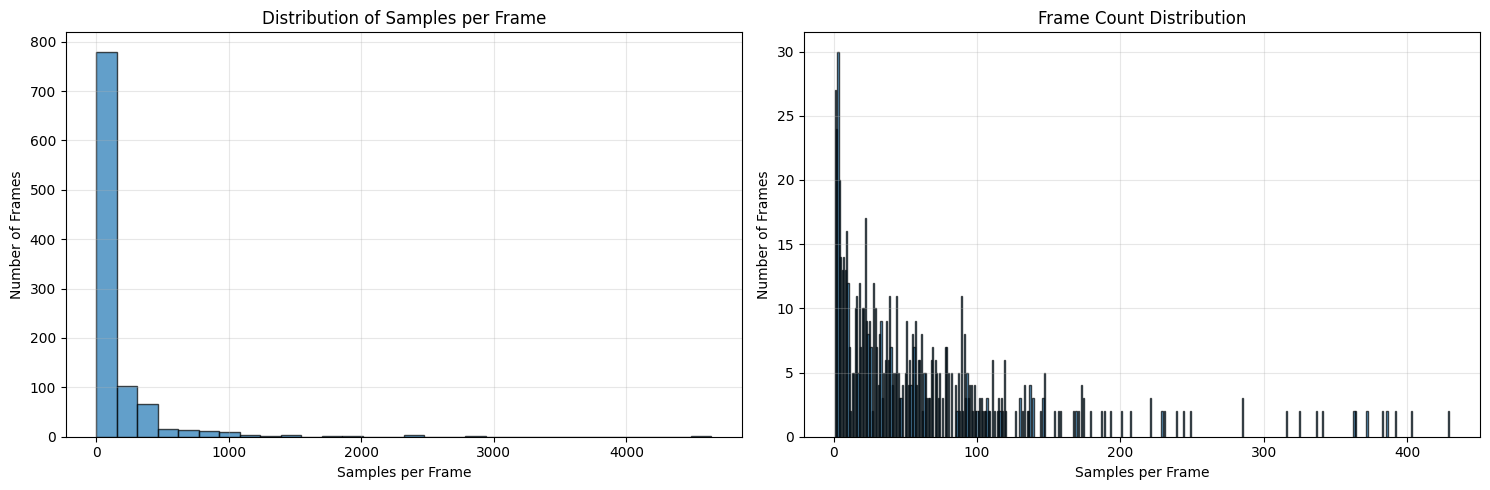


=== Sample Count Distribution ===
 1 samples:  27 frames (  2.7%)
 2 samples:  24 frames (  2.4%)
 3 samples:  30 frames (  3.0%)
 4 samples:  20 frames (  2.0%)
 5 samples:  14 frames (  1.4%)
 6 samples:  13 frames (  1.3%)
 7 samples:  14 frames (  1.4%)
 8 samples:  13 frames (  1.3%)
 9 samples:  16 frames (  1.6%)
10 samples:  12 frames (  1.2%)
11 samples:   7 frames (  0.7%)
12 samples:   2 frames (  0.2%)
13 samples:   5 frames (  0.5%)
14 samples:   5 frames (  0.5%)
15 samples:  10 frames (  1.0%)
16 samples:  11 frames (  1.1%)
17 samples:   5 frames (  0.5%)
18 samples:  12 frames (  1.2%)
19 samples:   7 frames (  0.7%)
20 samples:  10 frames (  1.0%)
... (showing top 20 only)

2. Âπ≥Ë°°Êï∞ÊçÆÂàÜÊûê

=== Frame Statistics ===
Total frames: 1014
Total samples: 39,536
Average samples per frame: 39.0
Median samples per frame: 30.0
Min samples: 1, Max samples: 80
Standard deviation: 28.9


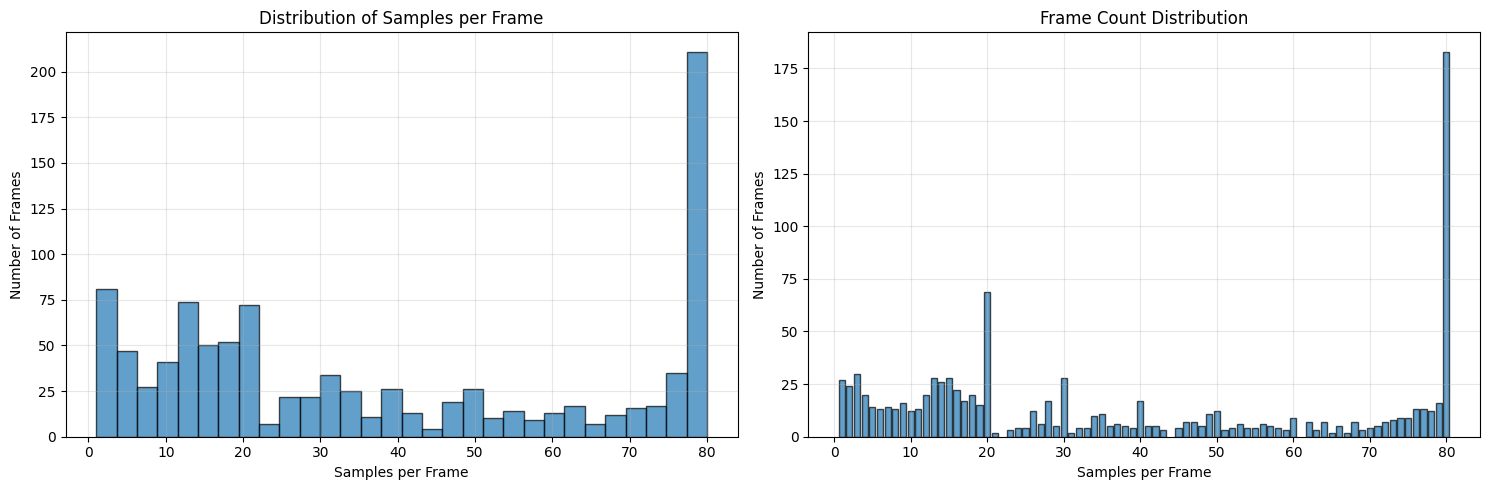


=== Sample Count Distribution ===
 1 samples:  27 frames (  2.7%)
 2 samples:  24 frames (  2.4%)
 3 samples:  30 frames (  3.0%)
 4 samples:  20 frames (  2.0%)
 5 samples:  14 frames (  1.4%)
 6 samples:  13 frames (  1.3%)
 7 samples:  14 frames (  1.4%)
 8 samples:  13 frames (  1.3%)
 9 samples:  16 frames (  1.6%)
10 samples:  12 frames (  1.2%)
11 samples:  13 frames (  1.3%)
12 samples:  20 frames (  2.0%)
13 samples:  28 frames (  2.8%)
14 samples:  26 frames (  2.6%)
15 samples:  28 frames (  2.8%)
16 samples:  22 frames (  2.2%)
17 samples:  17 frames (  1.7%)
18 samples:  20 frames (  2.0%)
19 samples:  15 frames (  1.5%)
20 samples:  69 frames (  6.8%)
... (showing top 20 only)

3. ÂØÜÂ∫¶ÂèòÂåñÂàÜÊûê

=== Density Analysis ===
Frame                     Original   Balanced   Ratio    Reduction
----------------------------------------------------------------------
Self_motion               4639       80         1.72%    98.28%
Stimulus_focus            2897       80         

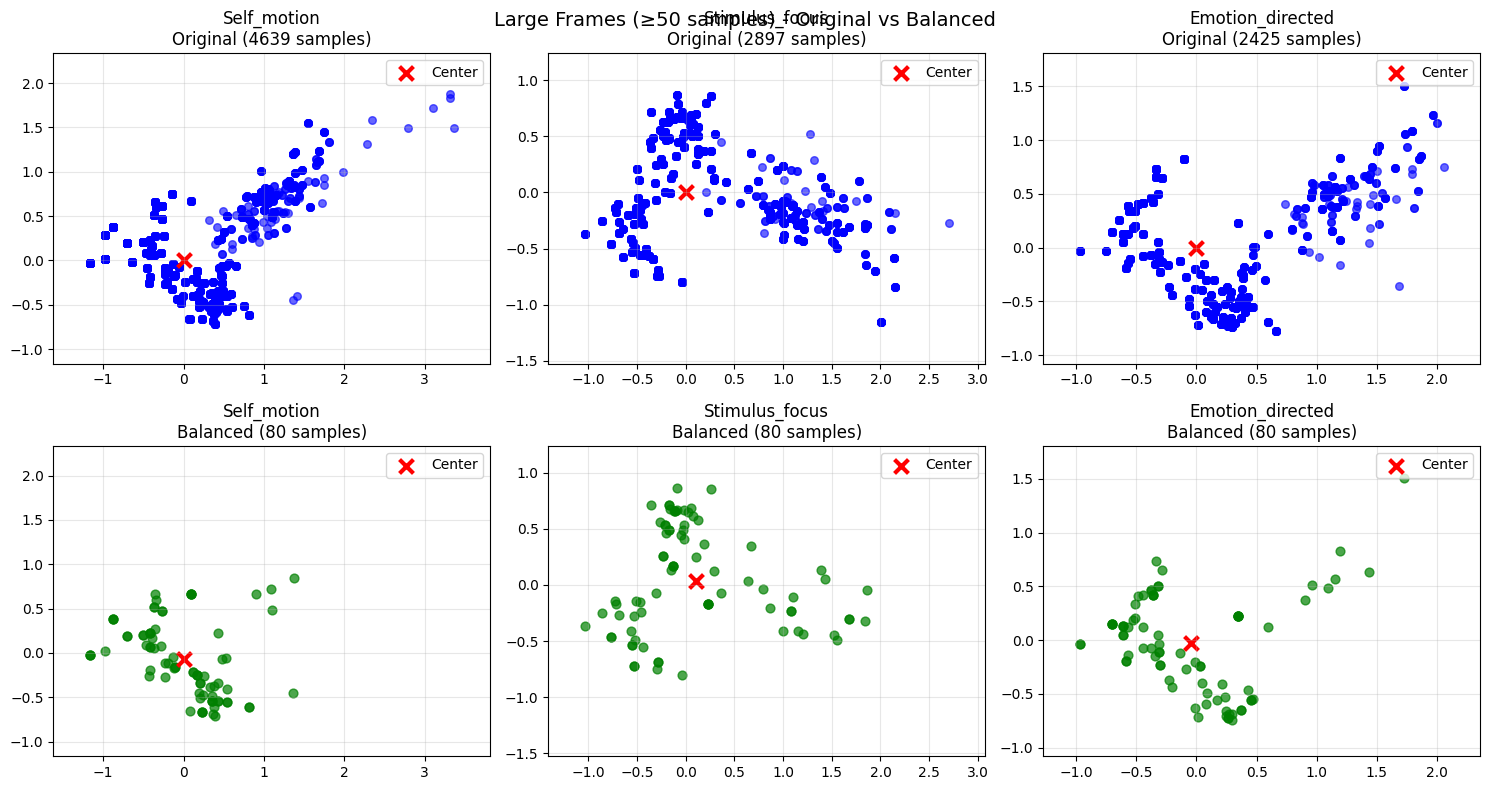


=== Medium Frames (10-49 samples) ===
Selected frames: ['Cause_change_of_phase', 'Conquering', 'Renting']
Extracting embeddings for original dataset...
  Extracted 49 embeddings for Cause_change_of_phase
  Extracted 48 embeddings for Conquering
  Extracted 48 embeddings for Renting
Extracting embeddings for balanced dataset...
  Extracted 30 embeddings for Cause_change_of_phase
  Extracted 30 embeddings for Conquering
  Extracted 25 embeddings for Renting
  Cause_change_of_phase: 49 ‚Üí 30 (61.22%)
    Center shift: 0.20
    Shape change: 10.3%
  Conquering: 48 ‚Üí 30 (62.50%)
    Center shift: 0.14
    Shape change: 8.8%
  Renting: 48 ‚Üí 25 (52.08%)
    Center shift: 0.04
    Shape change: 4.0%


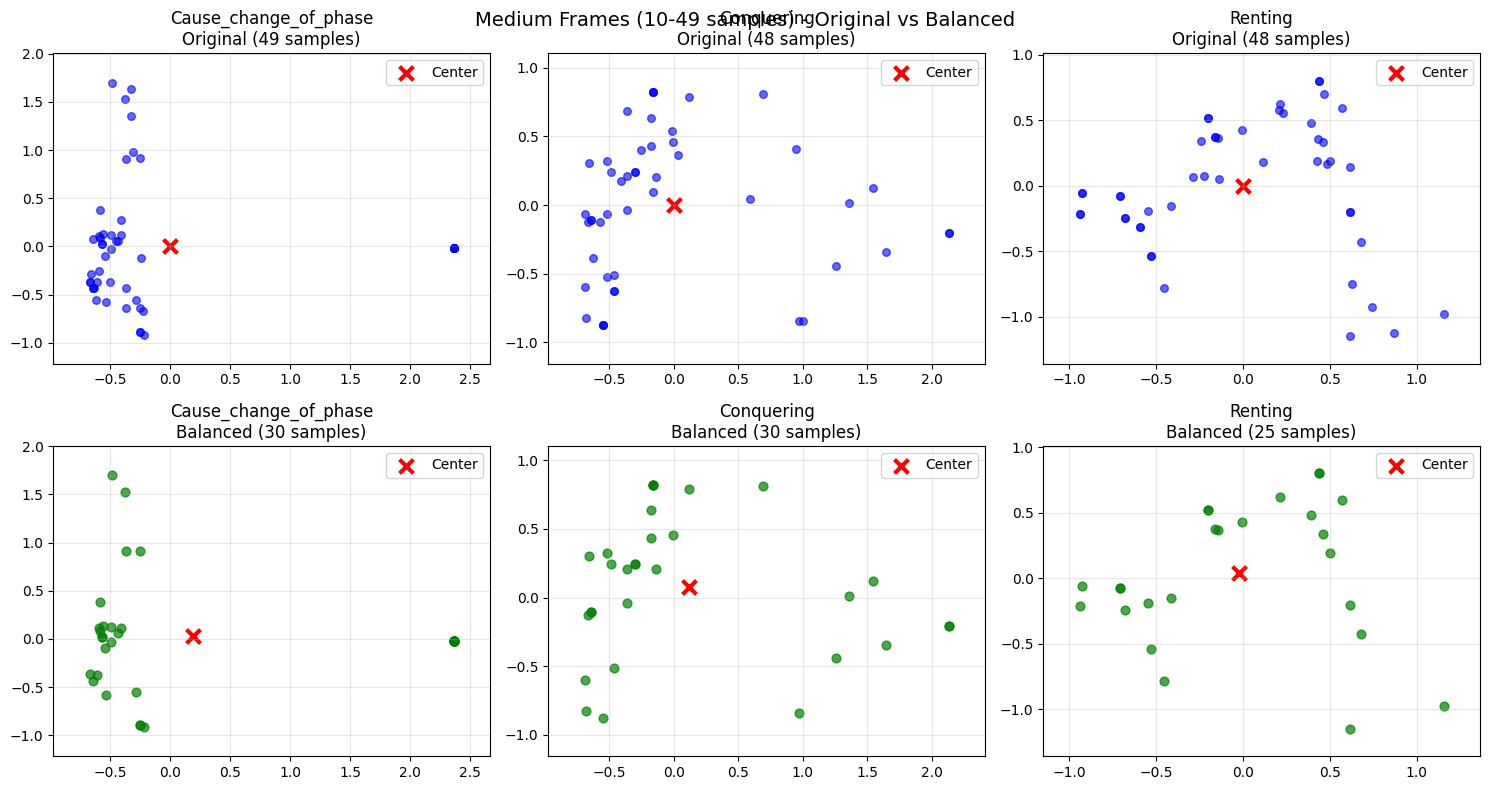


=== Small Frames (<10 samples) ===
Selected frames: ['Jury_deliberation', 'Front_for', 'Regard']
Extracting embeddings for original dataset...
  Extracted 9 embeddings for Jury_deliberation
  Extracted 9 embeddings for Front_for
  Extracted 9 embeddings for Regard
Extracting embeddings for balanced dataset...
  Extracted 9 embeddings for Jury_deliberation
  Extracted 9 embeddings for Front_for
  Extracted 9 embeddings for Regard
  Jury_deliberation: 9 ‚Üí 9 (100.00%)
    Center shift: 0.00
    Shape change: 0.0%
  Front_for: 9 ‚Üí 9 (100.00%)
    Center shift: 0.00
    Shape change: 0.0%
  Regard: 9 ‚Üí 9 (100.00%)
    Center shift: 0.00
    Shape change: 0.0%


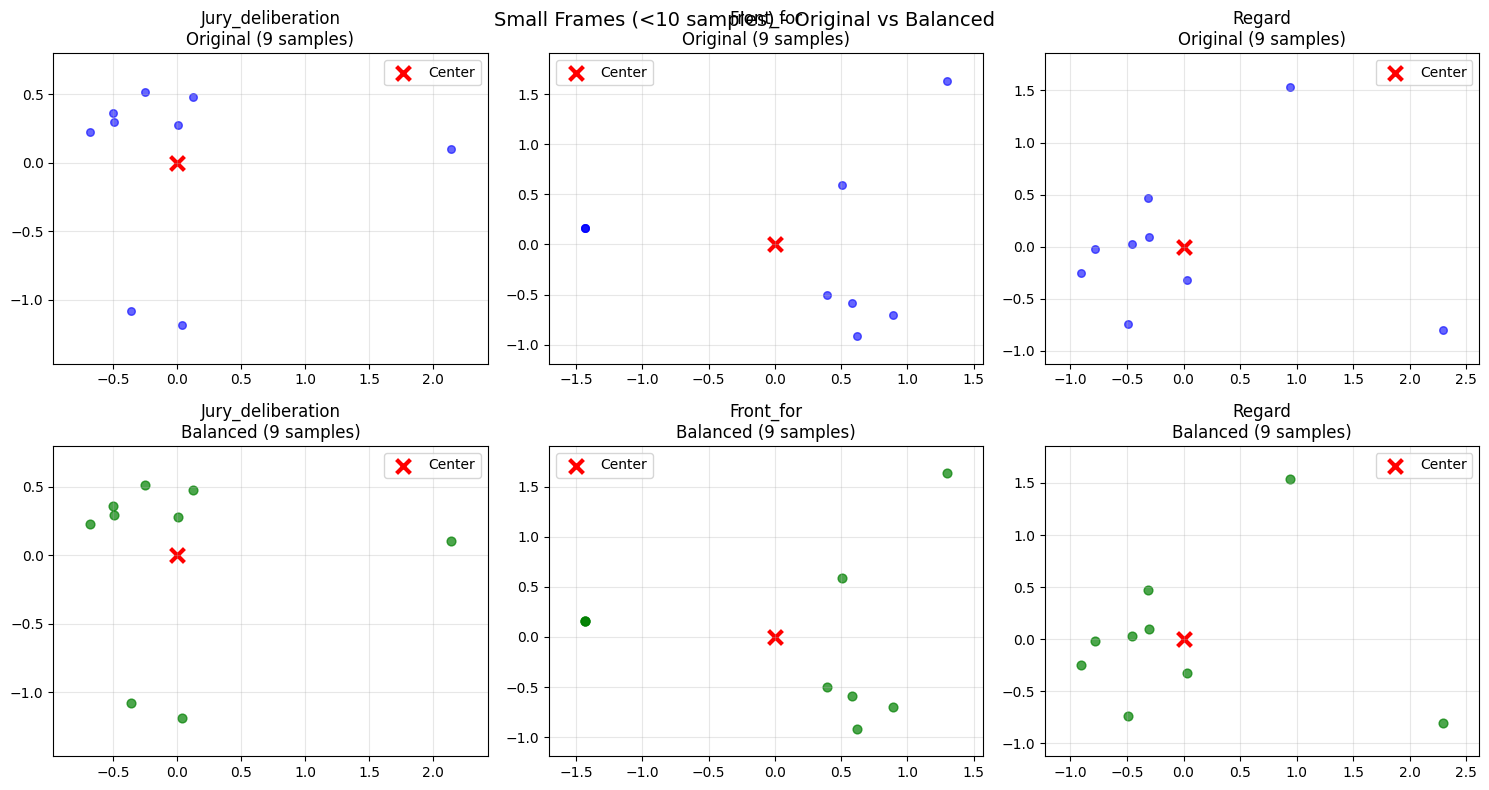


‚úÖ ÂàÜÊûêÂÆåÊàê!


In [ ]:
# @title üì¶ Intelligent Data BalancingÂèØËßÜÂåñ

import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from collections import Counter
import torch

def analyze_frame_statistics(df):
    """Analyze frame statistics"""
    frame_counts = df['frame_name'].value_counts()

    print(f"\n=== Frame Statistics ===")
    print(f"Total frames: {len(frame_counts)}")
    print(f"Total samples: {len(df):,}")
    print(f"Average samples per frame: {frame_counts.mean():.1f}")
    print(f"Median samples per frame: {frame_counts.median():.1f}")
    print(f"Min samples: {frame_counts.min()}, Max samples: {frame_counts.max()}")
    print(f"Standard deviation: {frame_counts.std():.1f}")

    return frame_counts

def plot_frame_distribution(frame_counts):
    """Plot frame sample distribution"""

    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot 1: Histogram of samples per frame
    ax1.hist(frame_counts.values, bins=30, edgecolor='black', alpha=0.7)
    ax1.set_xlabel('Samples per Frame')
    ax1.set_ylabel('Number of Frames')
    ax1.set_title('Distribution of Samples per Frame')
    ax1.grid(True, alpha=0.3)

    # Plot 2: Bar chart of specific counts
    count_distribution = Counter(frame_counts.values)
    counts = sorted(count_distribution.keys())
    frequencies = [count_distribution[c] for c in counts]

    # Only show counts with more than 1 occurrence for clarity
    filtered_counts = [(c, f) for c, f in zip(counts, frequencies) if f > 1 or c in [1, 2, 3, 4, 5]]
    if filtered_counts:
        filtered_counts, filtered_freqs = zip(*filtered_counts)
        ax2.bar(filtered_counts, filtered_freqs, edgecolor='black', alpha=0.7)

    ax2.set_xlabel('Samples per Frame')
    ax2.set_ylabel('Number of Frames')
    ax2.set_title('Frame Count Distribution')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Summary statistics table
    print("\n=== Sample Count Distribution ===")
    for count in sorted(count_distribution.keys())[:20]:  # Show top 20
        freq = count_distribution[count]
        percentage = (freq / len(frame_counts)) * 100
        print(f"{count:2d} samples: {freq:3d} frames ({percentage:5.1f}%)")

    if len(count_distribution) > 20:
        print("... (showing top 20 only)")

def extract_target_embeddings_for_viz(df, selected_frames, model, tokenizer, device):
    """Extract target embeddings for visualization"""

    embeddings_dict = {}

    for frame in selected_frames:
        frame_data = df[df['frame_name'] == frame]
        targets = []
        indices = []

        for idx, row in frame_data.iterrows():
            target_spans = row['target_spans']
            if isinstance(target_spans, list) and len(target_spans) > 0:
                processed_spans = []
                for span in target_spans:
                    if isinstance(span, tuple):
                        processed_spans.append(str(span[0]) if len(span) > 0 else str(span))
                    else:
                        processed_spans.append(str(span))

                target_text = ' '.join(processed_spans) if len(processed_spans) > 1 else processed_spans[0]
                targets.append(target_text)
                indices.append(idx)

        if targets:
            # Batch encode targets
            model.eval()
            embeddings = []
            batch_size = 32

            for i in range(0, len(targets), batch_size):
                batch_targets = targets[i:i+batch_size]
                encoded = tokenizer(
                    batch_targets,
                    padding=True,
                    truncation=True,
                    max_length=128,
                    return_tensors='pt'
                ).to(device)

                with torch.no_grad():
                    outputs = model(**encoded)
                    batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
                    embeddings.extend(batch_embeddings)

            embeddings_dict[frame] = {
                'embeddings': np.array(embeddings),
                'indices': indices,
                'targets': targets
            }

            print(f"  Extracted {len(embeddings)} embeddings for {frame}")

    return embeddings_dict

def visualize_sampling_comparison(original_df, balanced_df, model, tokenizer, device, show_categories=True):
    """Visualize density comparison before/after sampling for different frame sizes"""

    # Get frame counts for both datasets
    frame_counts_original = original_df['frame_name'].value_counts()
    frame_counts_balanced = balanced_df['frame_name'].value_counts()

    # Select frames that appear in both datasets
    common_frames = set(frame_counts_original.index) & set(frame_counts_balanced.index)

    if show_categories:
        # Categorize frames by sample count in original dataset
        large_frames = [f for f in frame_counts_original.index if f in common_frames and frame_counts_original[f] >= 50][:3]
        medium_frames = [f for f in frame_counts_original.index if f in common_frames and 10 <= frame_counts_original[f] < 50][:3]
        small_frames = [f for f in frame_counts_original.index if f in common_frames and frame_counts_original[f] < 10][:3]

        categories = [
            ("Large Frames (‚â•50 samples)", large_frames),
            ("Medium Frames (10-49 samples)", medium_frames),
            ("Small Frames (<10 samples)", small_frames)
        ]

        for category_name, selected_frames in categories:
            if not selected_frames:
                print(f"\n=== {category_name} ===")
                print("No frames found in this category")
                continue

            print(f"\n=== {category_name} ===")
            print(f"Selected frames: {selected_frames}")

            # Extract embeddings for both datasets
            print("Extracting embeddings for original dataset...")
            original_embeddings = extract_target_embeddings_for_viz(original_df, selected_frames, model, tokenizer, device)
            print("Extracting embeddings for balanced dataset...")
            balanced_embeddings = extract_target_embeddings_for_viz(balanced_df, selected_frames, model, tokenizer, device)

            # Create visualization
            n_frames = len(selected_frames)
            fig, axes = plt.subplots(2, n_frames, figsize=(5*n_frames, 8))
            if n_frames == 1:
                axes = axes.reshape(2, 1)

            for i, frame in enumerate(selected_frames):
                if frame not in original_embeddings or frame not in balanced_embeddings:
                    print(f"  Warning: {frame} not found in embeddings")
                    continue

                orig_emb = original_embeddings[frame]['embeddings']
                bal_emb = balanced_embeddings[frame]['embeddings']

                if len(orig_emb) < 2 or len(bal_emb) < 2:
                    print(f"  Warning: {frame} has too few embeddings")
                    continue

                # Use PCA for dimensionality reduction
                pca = PCA(n_components=2, random_state=42)

                # Fit PCA on original data and transform both
                orig_2d = pca.fit_transform(orig_emb)
                bal_2d = pca.transform(bal_emb)

                # Calculate centers for comparison
                orig_center = orig_2d.mean(axis=0)
                bal_center = bal_2d.mean(axis=0)

                # Plot original (top row)
                axes[0, i].scatter(orig_2d[:, 0], orig_2d[:, 1], alpha=0.6, s=30, c='blue')
                axes[0, i].scatter(orig_center[0], orig_center[1], c='red', s=100, marker='x', linewidth=3, label='Center')
                axes[0, i].set_title(f'{frame}\nOriginal ({len(orig_emb)} samples)')
                axes[0, i].grid(True, alpha=0.3)
                axes[0, i].legend()

                # Plot balanced (bottom row)
                axes[1, i].scatter(bal_2d[:, 0], bal_2d[:, 1], alpha=0.7, s=40, c='green')
                axes[1, i].scatter(bal_center[0], bal_center[1], c='red', s=100, marker='x', linewidth=3, label='Center')
                axes[1, i].set_title(f'{frame}\nBalanced ({len(bal_emb)} samples)')
                axes[1, i].grid(True, alpha=0.3)
                axes[1, i].legend()

                # Keep same axis limits for comparison
                x_min = min(orig_2d[:, 0].min(), bal_2d[:, 0].min())
                x_max = max(orig_2d[:, 0].max(), bal_2d[:, 0].max())
                y_min = min(orig_2d[:, 1].min(), bal_2d[:, 1].min())
                y_max = max(orig_2d[:, 1].max(), bal_2d[:, 1].max())

                padding = 0.1 * max(x_max - x_min, y_max - y_min)
                for row in range(2):
                    axes[row, i].set_xlim(x_min - padding, x_max + padding)
                    axes[row, i].set_ylim(y_min - padding, y_max + padding)

                # Calculate and print shape preservation metrics
                center_distance = np.linalg.norm(orig_center - bal_center)
                orig_std = orig_2d.std()
                bal_std = bal_2d.std()
                std_change = abs(bal_std - orig_std) / orig_std if orig_std > 0 else 0

                print(f"  {frame}: {len(orig_emb)} ‚Üí {len(bal_emb)} ({len(bal_emb)/len(orig_emb):.2%})")
                print(f"    Center shift: {center_distance:.2f}")
                print(f"    Shape change: {std_change:.1%}")

            plt.tight_layout()
            plt.suptitle(f'{category_name} - Original vs Balanced', fontsize=14, y=0.98)
            plt.show()

def analyze_density_metrics(original_df, balanced_df):
    """Analyze quantitative density metrics"""

    frame_counts_orig = original_df['frame_name'].value_counts()
    frame_counts_bal = balanced_df['frame_name'].value_counts()

    print("\n=== Density Analysis ===")
    print(f"{'Frame':<25} {'Original':<10} {'Balanced':<10} {'Ratio':<8} {'Reduction'}")
    print("-" * 70)

    total_orig = 0
    total_bal = 0

    for frame in frame_counts_orig.index[:15]:  # Show top 15 frames
        if frame in frame_counts_bal.index:
            orig_count = frame_counts_orig[frame]
            bal_count = frame_counts_bal[frame]
            ratio = bal_count / orig_count

            total_orig += orig_count
            total_bal += bal_count

            print(f"{frame[:24]:<25} {orig_count:<10} {bal_count:<10} {ratio:<8.2%} {1-ratio:.2%}")

    print("-" * 70)
    print(f"{'TOTAL (top 15)':<25} {total_orig:<10} {total_bal:<10} {total_bal/total_orig:<8.2%} {1-total_bal/total_orig:.2%}")

# ÂÆåÊï¥ÁöÑÂàÜÊûêÊµÅÁ®ã
def run_complete_analysis(original_df, balanced_df, model, tokenizer, device):
    """Run complete analysis and visualization"""

    print("üîç ÂºÄÂßãÂÆåÊï¥ÂàÜÊûê...")

    # 1. FrameÂàÜÂ∏ÉÂàÜÊûê
    print("\n" + "="*50)
    print("1. ÂéüÂßãÊï∞ÊçÆÂàÜÊûê")
    original_counts = analyze_frame_statistics(original_df)
    plot_frame_distribution(original_counts)

    print("\n" + "="*50)
    print("2. Âπ≥Ë°°Êï∞ÊçÆÂàÜÊûê")
    balanced_counts = analyze_frame_statistics(balanced_df)
    plot_frame_distribution(balanced_counts)

    # 2. ÂØÜÂ∫¶ÂØπÊØîÂàÜÊûê
    print("\n" + "="*50)
    print("3. ÂØÜÂ∫¶ÂèòÂåñÂàÜÊûê")
    analyze_density_metrics(original_df, balanced_df)

    # 3. ÂΩ¢Áä∂‰øùÊåÅÂèØËßÜÂåñ
    print("\n" + "="*50)
    print("4. ÂΩ¢Áä∂‰øùÊåÅÂàÜÊûê")
    visualize_sampling_comparison(original_df, balanced_df, model, tokenizer, device, show_categories=True)

    print("\n‚úÖ ÂàÜÊûêÂÆåÊàê!")

# ‰ΩøÁî®Á§∫‰æã
try:
    # Âä†ËΩΩÊï∞ÊçÆ
    balanced_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df_balanced.pkl")

    # ÂàùÂßãÂåñÊ®°Âûã
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"‰ΩøÁî®ËÆæÂ§á: {device}")

    # ËøêË°åÂÆåÊï¥ÂàÜÊûê
    run_complete_analysis(train_df, balanced_df, model, tokenizer, device)

except Exception as e:
    print(f"‚ùå ÈîôËØØ: {e}")
    print("ËØ∑Á°Æ‰øùÊâÄÊúâÂøÖË¶ÅÁöÑÂèòÈáèÂíåÊñá‰ª∂ÈÉΩÂ∑≤Âä†ËΩΩ")

In [ ]:
# @title üéØ ‰∏§Èò∂ÊÆµTarget+FEÊéíÂ∫èÂÆûÈ™å


def analyze_frame_specific_fe_types(train_df, top_k=2):
    """
    ‰∏∫ÊØè‰∏™frameÂàÜÊûêÂÖ∂ÊúÄÂ∏∏ËßÅÁöÑFEÁ±ªÂûã
    """
    frame_fe_preferences = {}

    print("üìä ÂàÜÊûêÊØè‰∏™frameÁöÑFEÂÅèÂ•Ω...")

    for frame_name in tqdm(train_df['frame_name'].unique(), desc="ÂàÜÊûêFEÂÅèÂ•Ω"):
        frame_data = train_df[train_df['frame_name'] == frame_name]
        fe_counts = Counter()

        for fe_spans in frame_data['fe_spans']:
            if fe_spans and isinstance(fe_spans, list):
                for fe in fe_spans:
                    if isinstance(fe, dict) and 'fe_name' in fe:
                        fe_counts[fe['fe_name']] += 1

        # Ëé∑ÂèñËØ•frameÊúÄÂ∏∏ËßÅÁöÑtop_k‰∏™FE
        top_fes = [fe_name for fe_name, count in fe_counts.most_common(top_k)]
        frame_fe_preferences[frame_name] = top_fes

    print(f"‚úÖ ÂÆåÊàêFEÂÅèÂ•ΩÂàÜÊûêÔºå{len(frame_fe_preferences)}‰∏™frames")
    return frame_fe_preferences

def extract_target_embeddings_batch(sentences, target_spans_list, model, tokenizer, device, batch_size=64):
    """
    Âè™ÊèêÂèñtarget embeddings (Áî®‰∫éÈò∂ÊÆµ1ÊØîËæÉ)
    """
    all_embeddings = []
    stats = {"success": 0, "failed": 0, "total": len(sentences)}

    model.eval()

    for batch_start in range(0, len(sentences), batch_size):
        batch_end = min(batch_start + batch_size, len(sentences))
        batch_sentences = sentences[batch_start:batch_end]
        batch_target_spans = target_spans_list[batch_start:batch_end]

        encoding = tokenizer(
            batch_sentences,
            return_tensors='pt',
            truncation=True,
            max_length=512,
            padding=True,
            return_offsets_mapping=True,
            return_attention_mask=True
        ).to(device)

        with torch.no_grad():
            outputs = model(input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'])
            last_hidden = outputs.last_hidden_state

            for i in range(len(batch_sentences)):
                try:
                    offset_mapping = encoding['offset_mapping'][i]
                    target_spans = normalize_target_spans(batch_target_spans[i])

                    if not target_spans:
                        embedding = last_hidden[i].mean(dim=0).cpu().numpy()
                        stats["failed"] += 1
                        all_embeddings.append(embedding)
                        continue

                    start_char, end_char = target_spans[0]
                    selected_indices = []

                    for idx, (start, end) in enumerate(offset_mapping):
                        start, end = int(start), int(end)
                        if (start <= start_char < end or start < end_char <= end) and start != end:
                            selected_indices.append(idx)

                    if selected_indices:
                        selected_indices = list(set(selected_indices))
                        selected_hidden = last_hidden[i, selected_indices, :]
                        embedding = selected_hidden.mean(dim=0).cpu().numpy()
                        stats["success"] += 1
                    else:
                        embedding = last_hidden[i].mean(dim=0).cpu().numpy()
                        stats["failed"] += 1

                    all_embeddings.append(embedding)

                except Exception:
                    embedding = last_hidden[i].mean(dim=0).cpu().numpy()
                    all_embeddings.append(embedding)
                    stats["failed"] += 1

    return np.array(all_embeddings), stats

def extract_fe_embeddings_for_query(sentence, fe_spans, preferred_fe_types, model, tokenizer, device):
    """
    ‰∏∫Âçï‰∏™Êü•ËØ¢Ê†∑Êú¨ÊèêÂèñFE embeddings
    """
    if not fe_spans or not isinstance(fe_spans, list) or not preferred_fe_types:
        return {}  # üî• ‰øÆÂ§çÔºöËøîÂõûÁ©∫dictËÄå‰∏çÊòØÁ©∫list

    encoding = tokenizer(
        sentence,
        return_tensors='pt',
        truncation=True,
        max_length=512,
        return_offsets_mapping=True,
        return_attention_mask=True
    ).to(device)

    with torch.no_grad():
        outputs = model(input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'])
        hidden_states = outputs.last_hidden_state[0]  # [seq_len, hidden_size]
        offset_mapping = encoding['offset_mapping'][0]

        fe_embeddings = {}

        for fe in fe_spans:
            if isinstance(fe, dict) and 'fe_name' in fe and fe['fe_name'] in preferred_fe_types:
                if 'start' in fe and 'end' in fe:
                    start_char, end_char = fe['start'], fe['end']
                    selected_indices = []

                    for idx, (start, end) in enumerate(offset_mapping):
                        start, end = int(start), int(end)
                        if (start <= start_char < end or start < end_char <= end) and start != end:
                            selected_indices.append(idx)

                    if selected_indices:
                        selected_indices = list(set(selected_indices))
                        selected_hidden = hidden_states[selected_indices, :]
                        fe_embedding = selected_hidden.mean(dim=0)
                        fe_embeddings[fe['fe_name']] = fe_embedding

        return fe_embeddings  # ÊÄªÊòØËøîÂõûdict
def truly_batched_two_stage_prediction(query_sentences, query_target_spans, query_fe_spans,
                                       frame_prototypes, frame_fe_prototypes, frame_fe_preferences,
                                       model, tokenizer, device, top_k_stage1=10, fe_boost=0.2):
    """
    ÊâπÈáèÊèêÂèñ target Ë°®ËææÁöÑÈ´òÊïà‰∏§Èò∂ÊÆµÈ¢ÑÊµãÂáΩÊï∞
    """
    print("‚ö° ÊâπÈáèÊèêÂèñ Target embeddings...")
    query_target_embs, _ = extract_target_embeddings_batch(
        query_sentences, query_target_spans, model, tokenizer, device, batch_size=64
    )

    predictions = []
    frame_names = list(frame_prototypes.keys())
    frame_proto_matrix = torch.stack([frame_prototypes[f] for f in frame_names]).to(device)  # [N, D]

    print("üîÑ ‰∏§Èò∂ÊÆµÊâìÂàÜ‰∏éÊéíÂ∫è...")

    for i in tqdm(range(len(query_sentences)), desc="È¢ÑÊµãÊ†∑Êú¨"):
        query_emb = torch.tensor(query_target_embs[i], device=device)  # [D]
        sim_scores = F.cosine_similarity(query_emb.unsqueeze(0), frame_proto_matrix)  # [N]
        candidate_scores = list(zip(frame_names, sim_scores.tolist()))
        candidate_scores.sort(key=lambda x: x[1], reverse=True)
        stage1_candidates = candidate_scores[:top_k_stage1]

        # Á¨¨‰∫åÈò∂ÊÆµÔºöÂºïÂÖ• FE ÊéíÂêçÊèêÂçá
        sentence = query_sentences[i]
        fe_spans = query_fe_spans[i]
        final_scores = []

        for frame_name, score in stage1_candidates:
            final_score = score
            preferred_fes = frame_fe_preferences.get(frame_name, [])

            if preferred_fes and frame_name in frame_fe_prototypes:
                query_fe_embs = extract_fe_embeddings_for_query(
                    sentence, fe_spans, preferred_fes, model, tokenizer, device
                )
                fe_bonus = 0
                matched = 0

                for fe_name, fe_emb in query_fe_embs.items():
                    if fe_name in frame_fe_prototypes[frame_name]:
                        fe_proto = frame_fe_prototypes[frame_name][fe_name]
                        fe_sim = F.cosine_similarity(fe_emb, fe_proto, dim=0).item()
                        fe_bonus += fe_sim
                        matched += 1

                if matched > 0:
                    fe_bonus = fe_bonus / matched
                    final_score += fe_boost * fe_bonus

            final_scores.append((frame_name, final_score))

        final_scores.sort(key=lambda x: x[1], reverse=True)
        best_frame = final_scores[0][0]
        predictions.append(best_frame)

    return predictions


def build_fe_prototypes(train_df, frame_fe_preferences, model, tokenizer, device):
    """
    ‰∏∫ÊØè‰∏™frameÁöÑpreferred FEÁ±ªÂûãÊûÑÂª∫ÂéüÂûã
    """
    frame_fe_prototypes = {}

    print("üèóÔ∏è ÊûÑÂª∫FEÂéüÂûã...")

    for frame_name in tqdm(frame_fe_preferences.keys(), desc="ÊûÑÂª∫FEÂéüÂûã"):
        preferred_fes = frame_fe_preferences[frame_name]
        if not preferred_fes:
            continue

        frame_data = train_df[train_df['frame_name'] == frame_name]
        fe_embeddings = {fe_name: [] for fe_name in preferred_fes}

        # Êî∂ÈõÜËØ•frameÁöÑFE embeddings
        for _, row in frame_data.iterrows():
            sentence = row['sentence']
            fe_spans = row['fe_spans']

            if fe_spans and isinstance(fe_spans, list):
                query_fe_embs = extract_fe_embeddings_for_query(
                    sentence, fe_spans, preferred_fes, model, tokenizer, device
                )

                for fe_name, fe_emb in query_fe_embs.items():
                    fe_embeddings[fe_name].append(fe_emb.cpu().numpy())

        # ÊûÑÂª∫FEÂéüÂûã
        frame_fe_prototypes[frame_name] = {}
        for fe_name, emb_list in fe_embeddings.items():
            if len(emb_list) > 0:
                prototype = torch.tensor(emb_list).mean(dim=0).to(device)
                prototype = F.normalize(prototype, p=2, dim=0)
                frame_fe_prototypes[frame_name][fe_name] = prototype

    return frame_fe_prototypes

def run_two_stage_experiment():
    """
    ËøêË°å‰∏§Èò∂ÊÆµÂÆûÈ™å (Â∏¶ÁºìÂ≠ò)
    """
    print("üöÄ ‰∏§Èò∂ÊÆµTarget+FEÊéíÂ∫èÂÆûÈ™å")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"ËÆæÂ§á: {device}")

    # Âä†ËΩΩÊï∞ÊçÆ
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df_distilbert_balanced.pkl")
    val_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/val_df.pkl")

    print(f"ËÆ≠ÁªÉÊ†∑Êú¨: {len(train_df):,}")
    print(f"È™åËØÅÊ†∑Êú¨: {len(val_df):,}")
    print(f"FrameÊï∞Èáè: {len(train_df['frame_name'].unique())}")

    # üî• ÁºìÂ≠òÊñá‰ª∂Ë∑ØÂæÑ
    cache_dir = "/content/drive/MyDrive/more50/framenet_data/two_stage_cache"

    os.makedirs(cache_dir, exist_ok=True)

    fe_preferences_cache = os.path.join(cache_dir, "frame_fe_preferences.pkl")
    target_prototypes_cache = os.path.join(cache_dir, "target_prototypes.pkl")
    fe_prototypes_cache = os.path.join(cache_dir, "fe_prototypes.pkl")

    # üî• Ê£ÄÊü•Âπ∂Âä†ËΩΩFEÂÅèÂ•ΩÁºìÂ≠ò
    if os.path.exists(fe_preferences_cache):
        print("üì¶ Âä†ËΩΩFEÂÅèÂ•ΩÁºìÂ≠ò...")

        with open(fe_preferences_cache, 'rb') as f:
            frame_fe_preferences = pickle.load(f)
        print(f"‚úÖ Âä†ËΩΩ‰∫Ü{len(frame_fe_preferences)}‰∏™framesÁöÑFEÂÅèÂ•Ω")
    else:
        print("üìä ÂàÜÊûêFEÂÅèÂ•Ω (È¶ñÊ¨°ËøêË°å)...")
        frame_fe_preferences = analyze_frame_specific_fe_types(train_df, top_k=2)
        with open(fe_preferences_cache, 'wb') as f:
            pickle.dump(frame_fe_preferences, f)
        print(f"üíæ FEÂÅèÂ•ΩÂ∑≤ÁºìÂ≠ò")

    # ÂàùÂßãÂåñÊ®°Âûã
    model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

    # üî• Ê£ÄÊü•Âπ∂Âä†ËΩΩTargetÂéüÂûãÁºìÂ≠ò
    if os.path.exists(target_prototypes_cache):
        print("üì¶ Âä†ËΩΩTargetÂéüÂûãÁºìÂ≠ò...")

        with open(target_prototypes_cache, 'rb') as f:
            frame_prototypes = pickle.load(f)
        print(f"‚úÖ Âä†ËΩΩ‰∫Ü{len(frame_prototypes)}‰∏™TargetÂéüÂûã")
    else:
        print("\nüèóÔ∏è ÊûÑÂª∫TargetÂéüÂûã (È¶ñÊ¨°ËøêË°å)...")
        frame_prototypes = {}
        for frame_name in tqdm(train_df['frame_name'].unique(), desc="ÊûÑÂª∫TargetÂéüÂûã"):
            frame_data = train_df[train_df['frame_name'] == frame_name]

            sentences = frame_data['sentence'].tolist()
            target_spans_list = frame_data['target_spans'].tolist()

            embeddings, _ = extract_target_embeddings_batch(
                sentences, target_spans_list, model, tokenizer, device, batch_size=32
            )

            if len(embeddings) > 0:
                prototype = build_smart_prototype(embeddings).to(device)
                frame_prototypes[frame_name] = prototype

        with open(target_prototypes_cache, 'wb') as f:
            pickle.dump(frame_prototypes, f)
        print(f"üíæ TargetÂéüÂûãÂ∑≤ÁºìÂ≠ò")

    # üî• Ê£ÄÊü•Âπ∂Âä†ËΩΩFEÂéüÂûãÁºìÂ≠ò
    if os.path.exists(fe_prototypes_cache):
        print("üì¶ Âä†ËΩΩFEÂéüÂûãÁºìÂ≠ò...")

        with open(fe_prototypes_cache, 'rb') as f:
            frame_fe_prototypes = pickle.load(f)
        print(f"‚úÖ Âä†ËΩΩ‰∫Ü{len(frame_fe_prototypes)}‰∏™FEÂéüÂûã")
    else:
        print("üèóÔ∏è ÊûÑÂª∫FEÂéüÂûã (È¶ñÊ¨°ËøêË°å)...")
        frame_fe_prototypes = build_fe_prototypes(train_df, frame_fe_preferences, model, tokenizer, device)
        with open(fe_prototypes_cache, 'wb') as f:
            pickle.dump(frame_fe_prototypes, f)
        print(f"üíæ FEÂéüÂûãÂ∑≤ÁºìÂ≠ò")

    print(f"\nüìä ÂéüÂûãÁªüËÆ°:")
    print(f"   TargetÂéüÂûã: {len(frame_prototypes)}")
    print(f"   FEÂéüÂûãframes: {len(frame_fe_prototypes)}")

    # È™åËØÅÈõÜÊµãËØï
    print(f"\nüéØ È™åËØÅÈõÜÊµãËØï...")

    val_sentences = val_df['sentence'].tolist()
    val_target_spans = val_df['target_spans'].tolist()
    val_fe_spans = val_df['fe_spans'].tolist()
    val_true_frames = val_df['frame_name'].tolist()

    # ‰∏§Èò∂ÊÆµÈ¢ÑÊµã (ÁúüÊ≠£ÊâπÈáèÂåñÁâà)
    predictions = truly_batched_two_stage_prediction(
        val_sentences, val_target_spans, val_fe_spans,
        frame_prototypes, frame_fe_prototypes, frame_fe_preferences,
        model, tokenizer, device, top_k_stage1=10, fe_boost=0.2
    )

    # ËÆ°ÁÆóÂáÜÁ°ÆÁéá
    correct = sum(1 for pred, true in zip(predictions, val_true_frames) if pred == true)
    accuracy = correct / len(val_true_frames)

    print(f"\nüéØ ‰∏§Èò∂ÊÆµÁªìÊûú:")
    print(f"   È™åËØÅÈõÜÂáÜÁ°ÆÁéá: {accuracy:.4f} ({correct:,}/{len(val_true_frames):,})")

    baseline_accuracy = 0.76
    improvement = accuracy - baseline_accuracy
    print(f"   Baseline: {baseline_accuracy:.4f}")
    print(f"   ÊîπËøõ: {improvement:+.4f} ({improvement/baseline_accuracy*100:+.2f}%)")

    return accuracy, frame_prototypes, frame_fe_prototypes

def build_smart_prototype(embeddings):
    """Êô∫ËÉΩÂéüÂûãÊûÑÂª∫"""
    embeddings_tensor = torch.tensor(embeddings, device='cuda')
    n_samples = embeddings_tensor.size(0)

    if n_samples == 1:
        return F.normalize(embeddings_tensor[0], p=2, dim=0)

    if n_samples > 5:
        mean_emb = embeddings_tensor.mean(dim=0)
        distances = torch.norm(embeddings_tensor - mean_emb.unsqueeze(0), dim=1)

        keep_ratio = 0.8
        threshold_idx = int(n_samples * keep_ratio)
        _, sorted_indices = torch.sort(distances)
        keep_indices = sorted_indices[:threshold_idx]

        filtered_embeddings = embeddings_tensor[keep_indices]
        filtered_distances = distances[keep_indices]
        max_dist = filtered_distances.max()
        weights = (max_dist - filtered_distances + 1e-6)
        weights = weights / weights.sum()

        prototype = torch.sum(filtered_embeddings * weights.unsqueeze(1), dim=0)
    else:
        prototype = embeddings_tensor.mean(dim=0)

    return F.normalize(prototype, p=2, dim=0)

"""
# ËøêË°åÂÆûÈ™å
if __name__ == "__main__":
    accuracy, target_prototypes, fe_prototypes = run_two_stage_experiment()
"""

'\n# ËøêË°åÂÆûÈ™å\nif __name__ == "__main__":\n    accuracy, target_prototypes, fe_prototypes = run_two_stage_experiment()\n'

In [ ]:
# @title üéØ Multi-Prototype Initialization System

def adaptive_k_selection_dbi_improved(frame_embeddings, max_k=8, min_samples_for_clustering=6):
    """ÊîπËøõÁöÑDBIËá™ÈÄÇÂ∫îÈÄâÊã©KÂÄº"""
    n_samples = len(frame_embeddings)

    # Ê†∑Êú¨Â§™Â∞ëÊó†Ê≥ïÊúâÊïàËÅöÁ±ª
    if n_samples < 3:
        return 1, float('inf'), ["Too few samples (< 3)"]
    elif n_samples < min_samples_for_clustering:
        # 3-5‰∏™Ê†∑Êú¨ÔºåÊúÄÂ§öÂ∞ùËØï2‰∏™ÂéüÂûã
        return min(2, n_samples - 1), float('inf'), [f"Small sample size ({n_samples}), using K={min(2, n_samples - 1)}"]

    best_k = 1
    best_score = float('inf')
    scores_info = []

    # ‰ªék=2ÂºÄÂßãÂ∞ùËØïÔºàk=1ÁöÑDBIÊó†ÊÑè‰πâÔºâ
    for k in range(2, min(max_k + 1, n_samples)):
        try:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=5, max_iter=100)
            labels = kmeans.fit_predict(frame_embeddings)

            # Ê£ÄÊü•ËÅöÁ±ªÊòØÂê¶ÊàêÂäü
            unique_labels = np.unique(labels)
            if len(unique_labels) < k:
                scores_info.append(f"K={k}: Failed (empty clusters)")
                continue

            dbi_score = davies_bouldin_score(frame_embeddings, labels)
            scores_info.append(f"K={k}: DBI={dbi_score:.3f}")

            if dbi_score < best_score:
                best_score = dbi_score
                best_k = k

        except Exception as e:
            scores_info.append(f"K={k}: Error ({str(e)[:30]})")
            continue

    # Â¶ÇÊûúÊ≤°ÊúâÊâæÂà∞Â•ΩÁöÑËÅöÁ±ªÔºå‰ΩøÁî®K=1
    if best_score == float('inf'):
        best_k = 1
        scores_info.append("No valid clustering found, using K=1")

    return best_k, best_score, scores_info

def extract_target_embeddings_batch(sentences, target_spans_list, model, tokenizer, device, batch_size=16):
    """ÊâπÈáèÊèêÂèñtarget embeddings - ‰ΩøÁî®span‰ΩçÁΩÆÊ†áÊ≥®"""

    all_embeddings = []
    stats = {"success": 0, "failed": 0, "total": len(sentences)}

    # ÂàÜÊâπÂ§ÑÁêÜ
    for batch_start in range(0, len(sentences), batch_size):
        batch_end = min(batch_start + batch_size, len(sentences))
        batch_sentences = sentences[batch_start:batch_end]
        batch_target_spans = target_spans_list[batch_start:batch_end]

        # ÊâπÈáèÁºñÁ†ÅÂè•Â≠ê
        encoded = tokenizer(
            batch_sentences,
            return_tensors='pt',
            max_length=512,
            truncation=True,
            padding=True,
            return_offsets_mapping=True  # ÂÖ≥ÈîÆÔºöËé∑ÂèñtokenÂà∞Â≠óÁ¨¶ÁöÑÊò†Â∞Ñ
        ).to(device)

        offset_mappings = encoded.pop('offset_mapping')  # [batch_size, seq_len, 2]

        with torch.no_grad():
            outputs = model(**encoded)
            hidden_states = outputs.last_hidden_state  # [batch_size, seq_len, hidden_dim]

            # Â§ÑÁêÜbatch‰∏≠ÁöÑÊØè‰∏™Ê†∑Êú¨
            for i, (sentence, target_spans) in enumerate(zip(batch_sentences, batch_target_spans)):
                try:
                    # Â§ÑÁêÜtarget_spansÊ†ºÂºè
                    if isinstance(target_spans, list) and len(target_spans) > 0:
                        if isinstance(target_spans[0], tuple) and len(target_spans[0]) >= 2:
                            # ‰ΩøÁî®span‰ΩçÁΩÆ‰ø°ÊÅØ
                            spans = [(int(span[0]), int(span[1])) for span in target_spans if len(span) >= 2]
                        else:
                            # ÈÄÄÂåñÂà∞Â≠óÁ¨¶‰∏≤ÂåπÈÖç
                            target_text = str(target_spans[0])
                            spans = find_spans_by_text(sentence, target_text)
                    else:
                        target_text = str(target_spans)
                        spans = find_spans_by_text(sentence, target_text)

                    if not spans:
                        stats["failed"] += 1
                        # ‰ΩøÁî®Âè•Â≠ê‰∏≠Èó¥ÁöÑtokenÔºàÈÅøÂÖç[CLS]Âíå[SEP]Ôºâ
                        middle_pos = hidden_states.size(1) // 2
                        target_emb = hidden_states[i, middle_pos, :].cpu().numpy()
                        all_embeddings.append(target_emb)
                        continue

                    # Â∞ÜÂ≠óÁ¨¶spanËΩ¨Êç¢‰∏∫token positions
                    target_token_positions = []
                    current_offset_mapping = offset_mappings[i]  # [seq_len, 2]

                    for char_start, char_end in spans:
                        # ÊâæÂà∞Ë¶ÜÁõñËØ•Â≠óÁ¨¶ËåÉÂõ¥ÁöÑÊâÄÊúâtokens
                        for token_idx, (token_start, token_end) in enumerate(current_offset_mapping):
                            token_start, token_end = int(token_start), int(token_end)

                            # Ê£ÄÊü•tokenÊòØÂê¶‰∏étarget spanÊúâÈáçÂè†
                            if (token_start < char_end and token_end > char_start and
                                token_start != token_end):  # ÊéíÈô§ÁâπÊÆätoken
                                target_token_positions.append(token_idx)

                    if target_token_positions:
                        # ÂØπtarget tokensËøõË°åÂπ≥ÂùáÊ±†Âåñ
                        target_positions = torch.tensor(target_token_positions, device=device)
                        target_emb = torch.mean(hidden_states[i, target_positions, :], dim=0).cpu().numpy()
                        stats["success"] += 1
                    else:
                        # Êâæ‰∏çÂà∞ÂØπÂ∫îtokenÔºå‰ΩøÁî®‰∏≠Èó¥token
                        middle_pos = hidden_states.size(1) // 2
                        target_emb = hidden_states[i, middle_pos, :].cpu().numpy()
                        stats["failed"] += 1

                    all_embeddings.append(target_emb)

                except Exception as e:
                    stats["failed"] += 1
                    # Âá∫ÈîôÊó∂‰ΩøÁî®‰∏≠Èó¥token
                    middle_pos = hidden_states.size(1) // 2
                    target_emb = hidden_states[i, middle_pos, :].cpu().numpy()
                    all_embeddings.append(target_emb)

    return np.array(all_embeddings), stats

def find_spans_by_text(sentence, target_text):
    """Â≠óÁ¨¶‰∏≤ÂåπÈÖçÊâæspan‰ΩçÁΩÆÔºàfallbackÊñπÊ≥ïÔºâ"""
    spans = []
    sentence_lower = sentence.lower()
    target_lower = target_text.lower().strip()

    if target_lower and len(target_lower) > 0:
        start = 0
        while True:
            pos = sentence_lower.find(target_lower, start)
            if pos == -1:
                break
            spans.append((pos, pos + len(target_lower)))
            start = pos + 1

    return spans

def extract_target_embeddings_for_frame(frame_data, model, tokenizer, device, batch_size=16):
    """‰∏∫Âçï‰∏™frameÊâπÈáèÊèêÂèñtarget embeddings"""
    sentences = frame_data['sentence'].tolist()
    target_spans_list = frame_data['target_spans'].tolist()

    return extract_target_embeddings_batch(sentences, target_spans_list, model, tokenizer, device, batch_size)

def analyze_frames_and_build_prototypes(train_df, output_dir="/content/drive/MyDrive/more50/framenet_data",
                                       force_regenerate=False, verbose=True):
    """ÂàÜÊûêÊâÄÊúâframeÂπ∂ÊûÑÂª∫ÂàùÂßãÂéüÂûã - Âº∫Âà∂‰ΩøÁî®target spanÂπ≥ÂùáÊ±†Âåñ"""

    print(f"=== Multi-Prototype Initialization ===")
    print(f"Embedding Strategy: TARGET SPAN AVERAGE POOLING (Mandatory)")
    print(f"  ‚Üí Locating target spans in sentences and averaging target token embeddings")
    print(f"  ‚Üí NO fallback to sentence [CLS] token allowed!")

    # Ê£ÄÊü•ÊòØÂê¶Â∑≤ÊúâÁªìÊûú
    config_file = os.path.join(output_dir, f"frame_analysis_config_target_pooling.pkl")
    prototypes_file = os.path.join(output_dir, f"initial_prototypes_target_pooling.pkl")

    if not force_regenerate and os.path.exists(config_file) and os.path.exists(prototypes_file):
        print(f"Loading existing analysis from {config_file}")
        with open(config_file, 'rb') as f:
            config_data = pickle.load(f)

        with open(prototypes_file, 'rb') as f:
            prototypes_data = pickle.load(f)

        print(f"Loaded {len(config_data['frame_configs'])} frames")
        return config_data, prototypes_data

    # ÂàùÂßãÂåñÊ®°Âûã
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)
    model.eval()

    print(f"Analyzing {len(train_df['frame_name'].unique())} frames...")

    frame_configs = {}
    frame_embeddings = {}
    frame_prototypes = {}
    detailed_analysis = {}
    overall_stats = {"success": 0, "failed": 0}

    # Â§ÑÁêÜÊØè‰∏™frame
    for frame_name in tqdm(train_df['frame_name'].unique(), desc="Processing frames"):
        frame_data = train_df[train_df['frame_name'] == frame_name]
        n_samples = len(frame_data)

        # ÊèêÂèñembeddings - Âº∫Âà∂target pooling
        embeddings, frame_stats = extract_target_embeddings_for_frame(frame_data, model, tokenizer, device)

        # Á¥ØËÆ°ÁªüËÆ°
        overall_stats["success"] += frame_stats["success"]
        overall_stats["failed"] += frame_stats["failed"]

        # Á°ÆÂÆöKÂÄº
        k, dbi_score, scores_info = adaptive_k_selection_dbi_improved(embeddings)

        # ÁîüÊàêÂéüÂûã
        if k == 1:
            prototypes = [np.mean(embeddings, axis=0)]
        else:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans.fit(embeddings)
            prototypes = kmeans.cluster_centers_.tolist()

        # ‰øùÂ≠òÁªìÊûú
        frame_configs[frame_name] = k
        frame_embeddings[frame_name] = embeddings
        frame_prototypes[frame_name] = prototypes

        # ËØ¶ÁªÜÂàÜÊûê‰ø°ÊÅØ
        detailed_analysis[frame_name] = {
            'n_samples': n_samples,
            'k_selected': k,
            'dbi_score': dbi_score,
            'scores_info': scores_info,
            'embedding_dim': embeddings.shape[1],
            'target_pooling_stats': frame_stats
        }

        if verbose and k > 1:  # Âè™ÊòæÁ§∫Â§öÂéüÂûãÁöÑframe
            success_rate = frame_stats["success"] / n_samples * 100
            print(f"  {frame_name}: {n_samples} samples ‚Üí K={k} (DBI={dbi_score:.3f}, target_success={success_rate:.1f}%)")

    # ÊâìÂç∞target poolingÁªüËÆ°
    total_samples = overall_stats["success"] + overall_stats["failed"]
    success_rate = overall_stats["success"] / total_samples * 100 if total_samples > 0 else 0

    print(f"\n=== TARGET POOLING STATISTICS ===")
    print(f"Successfully found and pooled targets: {success_rate:.1f}% ({overall_stats['success']}/{total_samples})")
    print(f"Failed to locate targets: {(100-success_rate):.1f}% ({overall_stats['failed']}/{total_samples})")

    if overall_stats["failed"] > 0:
        print(f"‚ö†Ô∏è  {overall_stats['failed']} cases failed target location")

    # ÁªüËÆ°ÂàÜÊûê
    k_counts = Counter(frame_configs.values())
    print(f"\n=== Frame Analysis Summary ===")
    print(f"Total frames: {len(frame_configs)}")
    for k, count in sorted(k_counts.items()):
        print(f"  K={k}: {count} frames ({count/len(frame_configs)*100:.1f}%)")

    # ‰øùÂ≠òÈÖçÁΩÆ
    config_data = {
        'frame_configs': frame_configs,
        'detailed_analysis': detailed_analysis,
        'target_pooling_stats': overall_stats,
        'summary_stats': {
            'total_frames': len(frame_configs),
            'k_distribution': dict(k_counts),
            'total_prototypes': sum(frame_configs.values())
        },
        'timestamp': datetime.now().strftime("%Y%m%d_%H%M%S"),
        'method': 'dbi_improved_target_pooling_only'
    }

    prototypes_data = {
        'frame_prototypes': frame_prototypes,
        'frame_embeddings': frame_embeddings,
        'timestamp': config_data['timestamp']
    }

    # ‰øùÂ≠òÂà∞Êñá‰ª∂
    os.makedirs(output_dir, exist_ok=True)

    with open(config_file, 'wb') as f:
        pickle.dump(config_data, f)

    with open(prototypes_file, 'wb') as f:
        pickle.dump(prototypes_data, f)

    print(f"\nAnalysis saved to:")
    print(f"  Config: {config_file}")
    print(f"  Prototypes: {prototypes_file}")

    return config_data, prototypes_data

def inspect_frame_details(frame_name, config_data, prototypes_data, top_n=5):
    """Ê£ÄÊü•ÁâπÂÆöframeÁöÑËØ¶ÁªÜ‰ø°ÊÅØ"""

    if frame_name not in config_data['frame_configs']:
        print(f"Frame '{frame_name}' not found!")
        return

    analysis = config_data['detailed_analysis'][frame_name]
    k = config_data['frame_configs'][frame_name]
    prototypes = prototypes_data['frame_prototypes'][frame_name]

    print(f"\n=== Frame Analysis: {frame_name} ===")
    print(f"Samples: {analysis['n_samples']}")
    print(f"Selected K: {k}")
    print(f"DBI Score: {analysis['dbi_score']:.3f}")
    print(f"Embedding Dimension: {analysis['embedding_dim']}")

    print(f"\nScoring Details:")
    for info in analysis['scores_info']:
        print(f"  {info}")

    print(f"\nPrototypes: {len(prototypes)} vectors of dimension {len(prototypes[0])}")

# ÊâßË°åÂàÜÊûê
if __name__ == "__main__":
    # Âä†ËΩΩÊï∞ÊçÆ
    train_file = "/content/drive/MyDrive/more50/framenet_data/train_df_distilbert_balanced.pkl"
    train_df = pd.read_pickle(train_file)

    print(f"Loaded training data: {len(train_df)} samples, {len(train_df['frame_name'].unique())} frames")

    # ÂàÜÊûêÂπ∂ÊûÑÂª∫ÂéüÂûã
    config_data, prototypes_data = analyze_frames_and_build_prototypes(
        train_df,
        force_regenerate=False,  # ËÆæ‰∏∫FalseÂèØ‰ª•ÈáçÁî®Â∑≤ÊúâÁªìÊûú
        verbose=False  # ÂÖ≥Èó≠ËØ¶ÁªÜËæìÂá∫ÔºåÂè™ÊòæÁ§∫ÊÄªËøõÂ∫¶Êù°
    )

    # Ê£ÄÊü•‰∏Ä‰∫õÊúâË∂£ÁöÑcases
    print(f"\n=== Inspecting Some Cases ===")

    # Êâæ‰∏Ä‰∫õK>1ÁöÑframe
    multi_prototype_frames = [frame for frame, k in config_data['frame_configs'].items() if k > 1]
    if multi_prototype_frames:
        inspect_frame_details(multi_prototype_frames[0], config_data, prototypes_data)

    # Êâæ‰∏Ä‰∫õÊ†∑Êú¨Êï∞Â§öÁöÑframe
    large_frames = [(frame, config_data['detailed_analysis'][frame]['n_samples'])
                   for frame in config_data['frame_configs'].keys()]
    large_frames.sort(key=lambda x: x[1], reverse=True)

    if large_frames:
        inspect_frame_details(large_frames[0][0], config_data, prototypes_data)

Loaded training data: 39291 samples, 1014 frames
=== Multi-Prototype Initialization ===
Embedding Strategy: TARGET SPAN AVERAGE POOLING (Mandatory)
  ‚Üí Locating target spans in sentences and averaging target token embeddings
  ‚Üí NO fallback to sentence [CLS] token allowed!
Loading existing analysis from /content/drive/MyDrive/more50/framenet_data/frame_analysis_config_target_pooling.pkl
Loaded 1014 frames

=== Inspecting Some Cases ===

=== Frame Analysis: Accoutrements ===
Samples: 80
Selected K: 8
DBI Score: 2.367
Embedding Dimension: 768

Scoring Details:
  K=2: DBI=3.715
  K=3: DBI=3.259
  K=4: DBI=2.946
  K=5: DBI=2.793
  K=6: DBI=2.753
  K=7: DBI=2.532
  K=8: DBI=2.367

Prototypes: 8 vectors of dimension 768

=== Frame Analysis: Accoutrements ===
Samples: 80
Selected K: 8
DBI Score: 2.367
Embedding Dimension: 768

Scoring Details:
  K=2: DBI=3.715
  K=3: DBI=3.259
  K=4: DBI=2.946
  K=5: DBI=2.793
  K=6: DBI=2.753
  K=7: DBI=2.532
  K=8: DBI=2.367

Prototypes: 8 vectors of di

In [ ]:
# @title üß† Triplet Dataset + Loss

def build_relation_matrix(frame_relations):
    relation_matrix = {}
    for frame, relations in frame_relations.items():
        for target_frame, rel_type, direction, _ in relations:
            relation_matrix[(frame, target_frame)] = rel_type
            if direction in ["in", "out", "undirected"]:
                relation_matrix[(target_frame, frame)] = rel_type
    return relation_matrix


class FrameNetTripletDataset(Dataset):
    def __init__(
        self,
        df,
        frame_relations,
        use_hard_negatives=False,
        frame_names=None,
        frame_similarity_matrix=None,
        top_k_hard=10,
        use_easy_positive=False,
        span_embeddings=None
    ):
        """
        Args:
            df: DataFrame ÂåÖÂê´ÊâÄÊúâËÆ≠ÁªÉÊ†∑Êú¨
            frame_relations: FrameNet ÂÖ≥Á≥ªÁªìÊûÑÂ≠óÂÖ∏
            use_hard_negatives: ÊòØÂê¶ÂêØÁî®Âõ∞ÈöæË¥ü‰æãÁ≠ñÁï•
            frame_names: ‰∏é similarity_matrix ÂØπÂ∫îÁöÑÈ°∫Â∫è
            frame_similarity_matrix: ÂéüÂûãÁõ∏‰ººÂ∫¶Áü©Èòµ
            top_k_hard: ÊØè‰∏™ anchor frame ÊåëÈÄâ top-K ÊúÄÁõ∏‰ºº„ÄÅ‰∏îËØ≠‰πâÁõ∏ÂÖ≥ÁöÑ frames
            use_easy_positive: ÊòØÂê¶ÂêØÁî®‚Äú‰ªéÊòìÂà∞Èöæ‚ÄùÊ≠£‰æãÈÄâÊã©Á≠ñÁï•
            span_embeddings: ÊØè‰∏™Ê†∑Êú¨ÁöÑ target span ÂêëÈáèÔºàÈ°∫Â∫è‰∏é df ‰∏ÄËá¥Ôºâ
        """
        self.df = df.reset_index(drop=True)
        self.frame2idx = df.groupby('frame_name').indices
        self.frame_relations = frame_relations
        self.relation_matrix = build_relation_matrix(frame_relations)

        self.use_hard_negatives = use_hard_negatives
        self.sim_matrix = frame_similarity_matrix
        self.frame_names = frame_names
        self.name2idx = {f: i for i, f in enumerate(frame_names)} if frame_names else {}
        self.top_k_hard = top_k_hard

        self.use_easy_positive = use_easy_positive
        self.span_embeddings = span_embeddings

        self.related_frames = {
            frame: {f2 for (f1, f2), rel in self.relation_matrix.items()
                    if f1 == frame and f2 != frame}
            for frame in df['frame_name'].unique()
        }

    def __len__(self):
        return len(self.df)

    def get_hard_negative(self, anchor_frame):
        if anchor_frame not in self.name2idx:
            return None

        idx = self.name2idx[anchor_frame]
        sim_row = self.sim_matrix[idx]
        top_indices = np.argsort(sim_row)[::-1]

        hard_candidates = []
        for j in top_indices:
            f2 = self.frame_names[j]
            if f2 != anchor_frame and f2 in self.frame2idx and f2 in self.related_frames.get(anchor_frame, set()):
                hard_candidates.append(f2)
            if len(hard_candidates) >= self.top_k_hard:
                break

        return random.choice(hard_candidates) if hard_candidates else None

    def __getitem__(self, idx):
        anchor = self.df.iloc[idx]
        anchor_frame = anchor['frame_name']
        pos_indices = self.frame2idx[anchor_frame]
        pos_candidates = [i for i in pos_indices if i != idx]

        # === Positive sampling
        if self.use_easy_positive and self.span_embeddings and len(pos_candidates) >= 2:
            anchor_emb = self.span_embeddings[idx]
            candidate_embs = torch.stack([self.span_embeddings[i] for i in pos_candidates])
            sims = F.cosine_similarity(anchor_emb.unsqueeze(0), candidate_embs)
            top_k = min(5, len(sims))
            top_idx = sims.topk(top_k).indices.tolist()
            selected_idx = pos_candidates[random.choice(top_idx)]
            positive = self.df.iloc[selected_idx]
        else:
            pos_idx = random.choice(pos_candidates) if pos_candidates else idx
            positive = self.df.iloc[pos_idx]

        # === Negative sampling
        neg_frame = None
        if self.use_hard_negatives:
            neg_frame = self.get_hard_negative(anchor_frame)

        if not neg_frame:
            if random.random() < 0.5:
                unrelated = [f for f in self.frame2idx if f != anchor_frame and
                             f not in self.related_frames.get(anchor_frame, set())]
                if unrelated:
                    neg_frame = random.choice(unrelated)
            else:
                related = list(self.related_frames.get(anchor_frame, set()))
                if related:
                    neg_frame = random.choice(related)

        if not neg_frame or neg_frame not in self.frame2idx:
            candidates = [f for f in self.frame2idx if f != anchor_frame]
            neg_frame = random.choice(candidates) if candidates else anchor_frame

        neg_idx = random.choice(self.frame2idx[neg_frame])
        negative = self.df.iloc[neg_idx]

        relation_type = self.relation_matrix.get((anchor_frame, neg_frame), "Unrelated")

        return {
            'anchor': {
                'sentence': anchor['sentence'],
                'target_spans': anchor['target_spans'],
                'frame_name': anchor_frame
            },
            'positive': {
                'sentence': positive['sentence'],
                'target_spans': positive['target_spans'],
                'frame_name': anchor_frame
            },
            'negative': {
                'sentence': negative['sentence'],
                'target_spans': negative['target_spans'],
                'frame_name': neg_frame
            },
            'relation_type': relation_type
        }




class RelationAwareTripletLoss(nn.Module):
    def __init__(self, relation_types=None, init_margin=0.5):
        super().__init__()
        self.relation_types = relation_types or FRAMENET_RELATION_TYPES
        self.margin_params = nn.ParameterDict({
            rel: nn.Parameter(torch.tensor(init_margin)) for rel in self.relation_types
        })

    def forward(self, anchor_emb, positive_emb, negative_emb, relation_type=None):
        # üîÅ ‰ΩøÁî®‰ΩôÂº¶Ë∑ùÁ¶ªÔºàcosine distanceÔºâ
        pos_dist = 1 - F.cosine_similarity(anchor_emb, positive_emb, dim=-1)
        neg_dist = 1 - F.cosine_similarity(anchor_emb, negative_emb, dim=-1)

        device = anchor_emb.device  # üîß Á°Æ‰øùÂú®Áõ∏ÂêåËÆæÂ§á‰∏ä
        batch_margins = []
        for rel in relation_type:
            margin_param = self.margin_params.get(rel, self.margin_params['Unrelated'])
            margin = F.softplus(margin_param).to(device)
            batch_margins.append(margin)
        batch_margins = torch.stack(batch_margins)


        triplet_loss = F.relu(pos_dist - neg_dist + batch_margins)
        return triplet_loss.mean()


# üîß Functional wrapper
_loss_module = None

def comprehensive_triplet_loss(
    anchor_emb,
    positive_emb,
    negative_emb,
    relation_type=None
):
    global _loss_module
    if _loss_module is None:
        _loss_module = RelationAwareTripletLoss()
    return _loss_module(
        anchor_emb=anchor_emb,
        positive_emb=positive_emb,
        negative_emb=negative_emb,
        relation_type=relation_type
    )
